这里整理了文章所用的模型（20250822-）

# 1.输入模型的数据的绘图整理

## 1.1 验证数据集的矩形shp生成

In [3]:
import geopandas as gpd
from shapely.geometry import Polygon
import os

def create_region_shp(output_folder):
    """
    生成研究区域边界的SHP文件
    
    参数:
    output_folder: 输出文件夹路径
    """
    # 确保输出目录存在
    os.makedirs(output_folder, exist_ok=True)
    
    # 定义研究区域边界
    regions = {
        "SMEX02": {
            "bounds": [(-93.80, 41.92), (-93.40, 41.92), (-93.40, 41.99), (-93.80, 41.99), (-93.80, 41.92)],
            "description": "SMEX02: 41.92-41.99°N; 93.80-93.40°W"
        },
        "CLASIC07": {
            "bounds": [(-98.60, 34.79), (-97.95, 34.79), (-97.95, 35.21), (-98.60, 35.21), (-98.60, 34.79)],
            "description": "CLASIC07: 34.79-35.21°N; 98.60-97.95°W"
        },
        "SMAPVEX08": {
            "bounds": [(-76.09, 38.95), (-75.94, 38.95), (-75.94, 39.02), (-76.09, 39.02), (-76.09, 38.95)],
            "description": "SMAPVEX08: 38.95-39.02°N; 76.09-75.94°W"
        },
        "SMAPVEX16": {
            "bounds": [(-98.10, 49.38), (-97.74, 49.38), (-97.74, 49.76), (-98.10, 49.76), (-98.10, 49.38)],
            "description": "SMAPVEX16: 49.76-49.38°N; 98.10-97.74°W"
        },
        "SMELR": {
            "bounds": [(115.5, 41.0), (117.5, 41.0), (117.5, 43.0), (115.5, 43.0), (115.5, 41.0)],
            "description": "SMELR: 41-43°N; 115.5-117.5°E"
        }
    }
    
    # 创建GeoDataFrame
    geometries = []
    names = []
    descriptions = []
    
    for name, data in regions.items():
        polygon = Polygon(data["bounds"])
        geometries.append(polygon)
        names.append(name)
        descriptions.append(data["description"])
    
    gdf = gpd.GeoDataFrame({
        'name': names,
        'description': descriptions,
        'geometry': geometries
    }, crs="EPSG:4326")  # WGS84坐标系
    
    # 保存为SHP文件
    output_path = os.path.join(output_folder, "Study_Regions.shp")
    gdf.to_file(output_path, encoding='utf-8')
    
    print(f"已生成研究区域边界SHP文件: {output_path}")
    
    # 同时保存为GeoJSON格式（可选，便于Web地图使用）
    geojson_path = os.path.join(output_folder, "Study_Regions.geojson")
    gdf.to_file(geojson_path, driver='GeoJSON', encoding='utf-8')
    
    print(f"已生成研究区域边界GeoJSON文件: {geojson_path}")
    
    return gdf

# 使用示例
if __name__ == "__main__":
    output_folder = r"E:\文章\HUITU\Tif"
    create_region_shp(output_folder)

C:\Users\thy01\AppData\Local\Temp\ipykernel_18972\817840160.py:58: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_path, encoding='utf-8')


已生成研究区域边界SHP文件: E:\文章\HUITU\Tif\Study_Regions.shp
已生成研究区域边界GeoJSON文件: E:\文章\HUITU\Tif\Study_Regions.geojson


D:\ProgramData\anaconda3\envs\project\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'description' to 'descriptio'
  ogr_write(


## 1.2 LFMC原站点shp生成

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os

def create_sample_points_shp(input_path, output_path):
    """
    将LFMC数据转换为点要素SHP文件
    
    参数:
    input_path: 输入Excel文件路径
    output_path: 输出SHP文件路径
    """
    # 确保输出目录存在
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # 读取Excel文件的"LFMC data"工作表
    print("正在读取Excel文件的'LFMC data'工作表...")
    df = pd.read_excel(input_path, sheet_name='LFMC data')
    print(f"成功读取数据，共 {len(df)} 行")
    
    # 检查必要的列是否存在
    required_columns = ['Latitude (WGS84, EPSG:4326)', 'Longitude (WGS84, EPSG:4326)']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Excel文件中缺少必需的列: {col}")
    
    # 移除经纬度为空的记录
    df = df.dropna(subset=required_columns)
    print(f"移除空值后剩余 {len(df)} 行")
    
    # 统计每个点的数据数量
    print("正在统计每个点的数据数量...")
    point_counts = df.groupby(required_columns).size().reset_index(name='count')
    print(f"共找到 {len(point_counts)} 个唯一位置点")
    
    # 创建几何点
    print("正在创建几何点...")
    geometry = [Point(xy) for xy in zip(
        point_counts['Longitude (WGS84, EPSG:4326)'], 
        point_counts['Latitude (WGS84, EPSG:4326)']
    )]
    
    # 创建GeoDataFrame
    gdf = gpd.GeoDataFrame(
        point_counts, 
        geometry=geometry,
        crs="EPSG:4326"  # WGS84坐标系
    )
    
    # 移除原始的经纬度列（因为几何信息已包含位置）
    gdf = gdf.drop(columns=required_columns)
    
    # 保存为SHP文件
    print("正在保存SHP文件...")
    gdf.to_file(output_path, encoding='utf-8')
    print(f"已成功生成点要素SHP文件: {output_path}")
    
    # 同时保存为GeoJSON格式（可选）
    geojson_path = output_path.replace('.shp', '.geojson')
    gdf.to_file(geojson_path, driver='GeoJSON', encoding='utf-8')
    print(f"已生成点要素GeoJSON文件: {geojson_path}")
    
    return gdf

# 使用示例
if __name__ == "__main__":
    input_file = r"G:\Matlab\EX2025\AuxiliaryData\Globe-LFMC-2.0 final.xlsx"
    output_file = r"E:\文章\HUITU\Tif\Sample.shp"
    
    create_sample_points_shp(input_file, output_file)

正在读取Excel文件的'LFMC data'工作表...
成功读取数据，共 293796 行
移除空值后剩余 293796 行
正在统计每个点的数据数量...
共找到 2245 个唯一位置点
正在创建几何点...
正在保存SHP文件...
已成功生成点要素SHP文件: E:\文章\HUITU\Tif\Sample.shp
已生成点要素GeoJSON文件: E:\文章\HUITU\Tif\Sample.geojson


## 1.3 统计训练LFMC数据的个数tif以及shp点状要素的生成

In [1]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import os

def create_count_tif(input_path, output_path):
    """
    生成每个像元数据行数统计的TIF文件
    
    参数:
    input_path: 输入Excel文件路径
    output_path: 输出TIF文件路径
    """
    # 确保输出目录存在
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # 读取数据
    df = pd.read_excel(input_path)
    
    # 创建空网格（1800行×3600列）
    grid = np.full((1800, 3600), -9999, dtype=np.float32)
    
    # 统计每个像元的数据行数
    count_df = df.groupby(['RowVOD', 'ColVOD']).size().reset_index(name='count')
    
    # 填充网格
    for _, row in count_df.iterrows():
        r = int(row['RowVOD']) - 1  # 转换为0-based索引
        c = int(row['ColVOD']) - 1
        if 0 <= r < 1800 and 0 <= c < 3600:
            grid[r, c] = row['count']
    
    # 定义地理变换（WGS84，0.1度分辨率）
    transform = from_origin(-180, 90, 0.1, 0.1)
    
    # 写入TIF文件
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=1800,
        width=3600,
        count=1,
        dtype=np.float32,
        crs='EPSG:4326',  # WGS84
        transform=transform,
        nodata=-9999
    ) as dst:
        dst.write(grid, 1)
    
    print(f"已生成数据行数统计TIF: {output_path}")

# 使用示例
input_file = r"E:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
output_file = r"E:\文章\HUITU\Tif\Sample_Sum.tif"
create_count_tif(input_file, output_file)

已生成数据行数统计TIF: E:\文章\HUITU\Tif\Sample_Sum.tif


In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os

def create_shapefile_from_excel(input_excel, output_shp):
    """
    根据Excel文件中的Latitude和Longitude列生成点状Shapefile

    参数:
    input_excel: 输入Excel路径，需包含Latitude和Longitude列
    output_shp: 输出Shapefile路径
    """
    # 确保输出目录存在
    os.makedirs(os.path.dirname(output_shp), exist_ok=True)

    # 读取Excel
    df = pd.read_excel(input_excel)

    # 将经纬度转为点几何
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')  # WGS84

    # 保存Shapefile
    gdf.to_file(output_shp, driver='ESRI Shapefile')
    print(f"已生成Shapefile: {output_shp}")


# ==================== 使用示例 ====================
input_file = r"E:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
output_shp_file = r"E:\文章\HUITU\Tif\Sample_Sum.shp"

create_shapefile_from_excel(input_file, output_shp_file)


C:\Users\thy01\AppData\Local\Temp\ipykernel_3488\2241916378.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shp, driver='ESRI Shapefile')
D:\ProgramData\anaconda3\envs\project\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SamplingDate' to 'SamplingDa'
  ogr_write(
D:\ProgramData\anaconda3\envs\project\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field SamplingDa create as date field, though DateTime requested.
  ogr_write(
D:\ProgramData\anaconda3\envs\project\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Elevation_Station' to 'Elevation_'
  ogr_write(
D:\ProgramData\anaconda3\envs\project\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'GridSampleCount' to 'GridSample'
  ogr_write(
D:\ProgramData\anaconda3\envs\project\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Norm

已生成Shapefile: E:\文章\HUITU\Tif\Sample_Sum.shp


D:\ProgramData\anaconda3\envs\project\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 'Calluna vulgaris, Erica umbellata, Ulex minor, Cytisus striatus, Pterospartum cantabricum, Ulex europaeus, Erica umbellata, Erica australis, Agrostis capillaris, Plantago lanceolata, Ranunculus repens, Quercus pyrenaica, Quercus robur, Salix atrocinerea, Unidentified grass, Pterospartum cantabricum, Ulex europaeus, Erica umbellata, Erica arborea' of field SpeciesCol has been truncated to 254 characters.  This warning will not be emitted any more for that layer.
  ogr_write(


## 1.4 VWC样本的中位数、平均数

In [2]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin
from datetime import datetime
import os

def get_season(date_str):
    """
    根据日期确定季节
    
    参数:
    date_str: 日期字符串
    
    返回:
    季节名称 ('Spring', 'Summer', 'Autumn', 'Winter')
    """
    try:
        date_obj = datetime.strptime(str(date_str), '%Y-%m-%d')
        month = date_obj.month
        
        if 3 <= month <= 5:
            return 'Spring'
        elif 6 <= month <= 8:
            return 'Summer'
        elif 9 <= month <= 11:
            return 'Autumn'
        else:  # 12月, 1月, 2月
            return 'Winter'
    except:
        return None

def create_seasonal_tifs(input_path, median_output_path, mean_output_path):
    """
    生成季节性统计TIF文件（中位数和平均值）
    
    参数:
    input_path: 输入Excel文件路径
    median_output_path: 中位数输出TIF文件路径
    mean_output_path: 平均值输出TIF文件路径
    """
    # 确保输出目录存在
    os.makedirs(os.path.dirname(median_output_path), exist_ok=True)
    os.makedirs(os.path.dirname(mean_output_path), exist_ok=True)
    
    # 读取数据
    df = pd.read_excel(input_path)
    
    # 计算因变量 (LFMC * AGB / 1000)
    df['target_var'] = df['LFMC'] * df['AGB'] / 1000
    
    # 添加季节列
    df['season'] = df['SamplingDate'].apply(get_season)
    
    # 移除无效数据
    df = df.dropna(subset=['target_var', 'season'])
    
    # 定义季节顺序
    seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
    
    # 为中位数和平均值创建网格
    median_grids = {season: np.full((1800, 3600), -9999, dtype=np.float32) for season in seasons}
    mean_grids = {season: np.full((1800, 3600), -9999, dtype=np.float32) for season in seasons}
    
    # 按季节和像元分组计算统计量
    for season in seasons:
        # 筛选当前季节的数据
        season_data = df[df['season'] == season]
        
        # 按像元分组计算中位数
        median_df = season_data.groupby(['RowVOD', 'ColVOD'])['target_var'].median().reset_index()
        
        # 按像元分组计算平均值
        mean_df = season_data.groupby(['RowVOD', 'ColVOD'])['target_var'].mean().reset_index()
        
        # 填充中位数网格
        for _, row in median_df.iterrows():
            r = int(row['RowVOD']) - 1
            c = int(row['ColVOD']) - 1
            if 0 <= r < 1800 and 0 <= c < 3600:
                median_grids[season][r, c] = row['target_var']
        
        # 填充平均值网格
        for _, row in mean_df.iterrows():
            r = int(row['RowVOD']) - 1
            c = int(row['ColVOD']) - 1
            if 0 <= r < 1800 and 0 <= c < 3600:
                mean_grids[season][r, c] = row['target_var']
    
    # 定义地理变换
    transform = from_origin(-180, 90, 0.1, 0.1)
    
    # 创建中位数TIF（四个波段对应四个季节）
    with rasterio.open(
        median_output_path,
        'w',
        driver='GTiff',
        height=1800,
        width=3600,
        count=4,  # 四个季节
        dtype=np.float32,
        crs='EPSG:4326',
        transform=transform,
        nodata=-9999
    ) as dst:
        for i, season in enumerate(seasons, 1):
            dst.write(median_grids[season], i)
    
    print(f"已生成中位数统计TIF: {median_output_path}")
    
    # 创建平均值TIF（四个波段对应四个季节）
    with rasterio.open(
        mean_output_path,
        'w',
        driver='GTiff',
        height=1800,
        width=3600,
        count=4,  # 四个季节
        dtype=np.float32,
        crs='EPSG:4326',
        transform=transform,
        nodata=-9999
    ) as dst:
        for i, season in enumerate(seasons, 1):
            dst.write(mean_grids[season], i)
    
    print(f"已生成平均值统计TIF: {mean_output_path}")

# 使用示例
input_file = r"E:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
median_output = r"E:\文章\HUITU\Tif\Sample_Median.tif"
mean_output = r"E:\文章\HUITU\Tif\Sample_Mean.tif"
create_seasonal_tifs(input_file, median_output, mean_output)

已生成中位数统计TIF: E:\文章\HUITU\Tif\Sample_Median.tif
已生成平均值统计TIF: E:\文章\HUITU\Tif\Sample_Mean.tif


## 1.5 各个数据集的点状shp

In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os

# 输入和输出路径
input_file = r"E:\data\VWC\test-VWC\SMEX02_CLASIC07_SMEX08_SMAPVEX16\InsituData_Point.xlsx"
output_folder = r"E:\文章\HUITU\Tif"

# 需要处理的sheet和对应输出文件名
sheets = {
    "SMEX02": "Sample_SMEX02.shp",
    "CLASIC07": "Sample_CLASIC07.shp",
    "SMAPVEX08": "Sample_SMAPVEX08.shp",
    "SMAPVEX16": "Sample_SMAPVEX16.shp"
}

for sheet, shp_name in sheets.items():
    # 读取指定sheet
    df = pd.read_excel(input_file, sheet_name=sheet, usecols=["Original_Latitude", "Original_Longitude"])
    
    # 去重
    df = df.drop_duplicates(subset=["Original_Latitude", "Original_Longitude"])
    
    # 重命名字段，避免shapefile字段名超长
    df = df.rename(columns={
        "Original_Latitude": "Lat",
        "Original_Longitude": "Lon"
    })
    
    # 转换为点要素
    geometry = [Point(xy) for xy in zip(df["Lon"], df["Lat"])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    
    # 保存shp
    out_path = os.path.join(output_folder, shp_name)
    gdf.to_file(out_path, driver="ESRI Shapefile", encoding="utf-8")
    
    print(f"{sheet} 已保存为 {out_path}")


SMEX02 已保存为 E:\文章\HUITU\Tif\Sample_SMEX02.shp
CLASIC07 已保存为 E:\文章\HUITU\Tif\Sample_CLASIC07.shp
SMAPVEX08 已保存为 E:\文章\HUITU\Tif\Sample_SMAPVEX08.shp
SMAPVEX16 已保存为 E:\文章\HUITU\Tif\Sample_SMAPVEX16.shp


In [1]:
# SMELR
import geopandas as gpd
from shapely.geometry import Point

# 输出路径
output_path = r"E:\文章\HUITU\Tif\Sample_SMELR.shp"

# 坐标数据（经度, 纬度）
coords = [(116.47, 42.18), (115.93, 42.04)]

# 创建几何对象
geometry = [Point(xy) for xy in coords]

# 创建GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")  # WGS84 经纬度坐标系

# 保存为Shapefile
gdf.to_file(output_path, driver="ESRI Shapefile", encoding="utf-8")

print(f"Shapefile 已生成: {output_path}")


Shapefile 已生成: E:\文章\HUITU\Tif\Sample_SMELR.shp


## 1.6 各个数据集的点状shp（集合）

In [4]:
import os
import geopandas as gpd
from shapely.geometry import Point

# 输出目录
output_dir = r"E:\文章\HUITU\Tif"
os.makedirs(output_dir, exist_ok=True)

# 定义站点经纬度范围
sites = {
    "SMEX02": {"lat": (41.92, 41.99), "lon": (-93.80, -93.40)},
    "CLASIC07": {"lat": (34.35, 37.23), "lon": (-99.53, -95.47)},
    "SMAPVEX08": {"lat": (38.93, 39.09), "lon": (-76.25, -75.55)},
    "SMAPVEX15": {"lat": (31.51, 31.87), "lon": (-110.96, -109.84)},
    "SMAPVEX16-Iowa": {"lat": (42.28, 42.66), "lon": (-93.58, -93.21)},
    "SMAPVEX16-Manitoba": {"lat": (49.36, 49.79), "lon": (-98.12, -97.75)},
    "SMELR": {"lat": (41.0, 43.0), "lon": (115.5, 117.5)}
}

# 遍历生成每个站点的中心点 Shapefile
for name, coords in sites.items():
    lat_min, lat_max = coords["lat"]
    lon_min, lon_max = coords["lon"]
    
    # 计算中心点
    center_lat = (lat_min + lat_max) / 2
    center_lon = (lon_min + lon_max) / 2
    
    # 创建 GeoDataFrame
    gdf = gpd.GeoDataFrame(
        {"name": [name]},
        geometry=[Point(center_lon, center_lat)],
        crs="EPSG:4326"  # WGS84
    )
    
    # 保存 Shapefile
    out_path = os.path.join(output_dir, f"{name}.shp")
    gdf.to_file(out_path)
    print(f"已生成: {out_path}")


2025-09-15 16:48:29,998 - INFO - Created 1 records
2025-09-15 16:48:30,024 - INFO - Created 1 records
2025-09-15 16:48:30,050 - INFO - Created 1 records
2025-09-15 16:48:30,068 - INFO - Created 1 records
2025-09-15 16:48:30,091 - INFO - Created 1 records
2025-09-15 16:48:30,107 - INFO - Created 1 records
2025-09-15 16:48:30,132 - INFO - Created 1 records


已生成: E:\文章\HUITU\Tif\SMEX02.shp
已生成: E:\文章\HUITU\Tif\CLASIC07.shp
已生成: E:\文章\HUITU\Tif\SMAPVEX08.shp
已生成: E:\文章\HUITU\Tif\SMAPVEX15.shp
已生成: E:\文章\HUITU\Tif\SMAPVEX16-Iowa.shp
已生成: E:\文章\HUITU\Tif\SMAPVEX16-Manitoba.shp
已生成: E:\文章\HUITU\Tif\SMELR.shp


# 2. 绘制概述类图像（问题已解决）

## 2.1 IGBP LC分类 + LFMC原站点分布情况

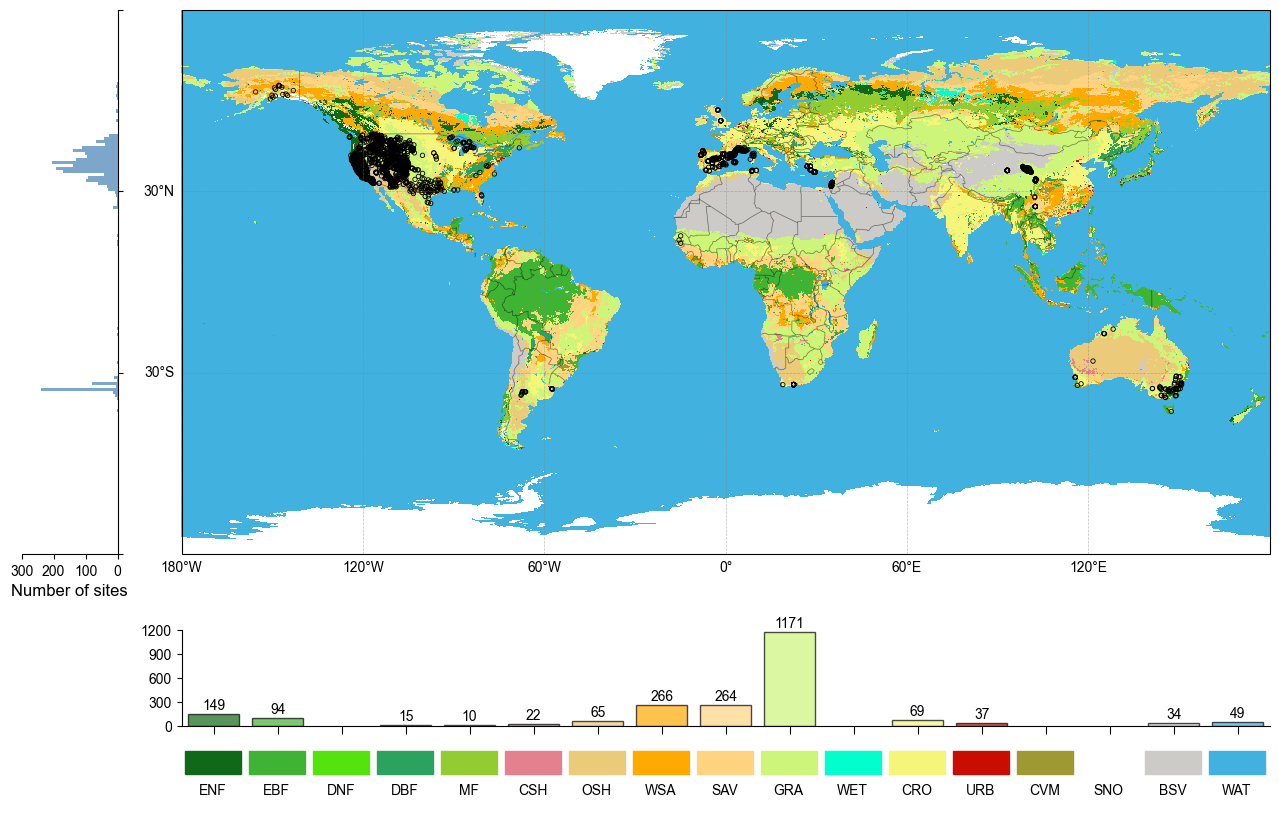

In [ ]:
import numpy as np
# import os
# os.environ["PROJ_LIB"] = r"D:\ProgramData\anaconda3\envs\project\Library\share\proj"
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import h5py
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

# 设置全局Arial字体
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

def load_igbp_data(mat_path):
    with h5py.File(mat_path, 'r') as f:
        igbp_data = np.array(f['IGBP_25']).T
    return igbp_data

def load_lfmc_shp(shp_path):
    return gpd.read_file(shp_path)

def load_custom_coastline(coastline_path):
    return gpd.read_file(coastline_path)

def create_composite_map():
    # ==================== 数据加载 ====================
    igbp_data = load_igbp_data(r"G:\Matlab\Matlab_code\graduation_project\00AuxilaryData\00AuxilaryData\IGBP_25.mat")
    lfmc_gdf = load_lfmc_shp(r"G:\文章\HUITU\Tif\Sample.shp")
    coastline_gdf = load_custom_coastline(r"G:\data\SHP\natural_earth_vector\boundary\ne_10m_coastline.shp")
    
    # ==================== 图形 ====================
    fig = plt.figure(figsize=(16, 12))
    
    # -------------------- 地图 --------------------
    ax_map = plt.axes([0.19, 0.3, 0.68, 0.6], projection=ccrs.PlateCarree())
    ax_map.set_aspect('auto')
    
    # -------------------- 左侧纬度直方图 --------------------
    ax_hist = fig.add_axes([0.09, 0.373, 0.06, 0.454], sharey=ax_map)
    lats = lfmc_gdf.geometry.y.values
    bins = np.arange(-90, 91, 1)
    hist, _ = np.histogram(lats, bins=bins)
    ax_hist.barh(bins[:-1], hist, height=1, align='edge', color='steelblue', alpha=0.7)
    ax_hist.set_xlabel('Number of sites', fontsize=12)
    ax_hist.set_xlim(0, 300)
    ax_hist.set_xticks([0, 100, 200, 300])
    ax_hist.set_yticks([-90, -30, 30, 90])
    ax_hist.set_yticklabels([])
    ax_hist.invert_xaxis()
    ax_hist.xaxis.set_ticks_position('bottom')
    ax_hist.xaxis.set_label_position('bottom')
    ax_hist.yaxis.set_ticks_position('right')
    ax_hist.yaxis.set_label_position('right')
    ax_hist.spines['left'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.grid(False)
    
    # -------------------- 主地图 --------------------
    igbp_colors = [
        '#106919', '#3fb334', '#54e30d', '#2ca25f', '#93cc31', '#e3818e', '#ebca79',
        '#ffaa01', '#ffd380', '#cdf57a', '#00ffcc', '#f5f579', '#c90d01', '#9e9933',
        '#ffffff', '#cccbc7', '#41b1df'
    ]
    cmap_igbp = ListedColormap(igbp_colors)
    
    lon = np.linspace(-180, 180, igbp_data.shape[1])
    lat = np.linspace(90, -90, igbp_data.shape[0])
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    
    ax_map.pcolormesh(lon_grid, lat_grid, igbp_data, cmap=cmap_igbp, vmin=1, vmax=17, transform=ccrs.PlateCarree())
    coastline_gdf.plot(ax=ax_map, color='black', linewidth=0, alpha=0)  # 保持图片宽度不变形的同时防止海岸线影响美观
    
    ax_map.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', alpha=0.5)
    
    # 站点数据
    ax_map.scatter(
        lfmc_gdf.geometry.x, 
        lfmc_gdf.geometry.y,
        facecolors='none',  # 内部空心
        edgecolors='black',  # 黑色边框
        s=10,               # 点大小（可调）
        linewidth=0.6       # 边框线宽
    )
    
    gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120])
    gl.ylocator = mticker.FixedLocator([-90, -30, 30, 90])
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.bottom_labels = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # -------------------- 下方直方图 --------------------
    def assign_igbp_to_sites(lfmc_gdf, igbp_data):
        lons = ((lfmc_gdf.geometry.x.values + 180) / 360 * igbp_data.shape[1]).astype(int)
        lats = ((90 - lfmc_gdf.geometry.y.values) / 180 * igbp_data.shape[0]).astype(int)
        lons = np.clip(lons, 0, igbp_data.shape[1]-1)
        lats = np.clip(lats, 0, igbp_data.shape[0]-1)
        return igbp_data[lats, lons]
    
    site_classes = assign_igbp_to_sites(lfmc_gdf, igbp_data)
    unique, counts = np.unique(site_classes, return_counts=True)
    
    ax_hist_class = fig.add_axes([0.19, 0.23, 0.68, 0.08])  # 下方直方图位置
    num_classes = 17
    bar_width = 0.8
    
    for i, val in enumerate(counts):
        cls = int(unique[i])
        ax_hist_class.bar(cls, val, width=bar_width, color=igbp_colors[cls-1], alpha=0.7, edgecolor='black')
    
    for x, y in zip(unique, counts):
        ax_hist_class.text(x, y + 20, str(y), ha='center', va='bottom', fontsize=10)
    
    ax_hist_class.set_xlim(0.5, 17.5)
    ax_hist_class.set_ylim(0, 1200)
    ax_hist_class.set_yticks([0, 300, 600, 900, 1200])
    ax_hist_class.set_xticks([])  # 横轴不显示默认刻度
    ax_hist_class.set_xticks(range(1, 18))
    ax_hist_class.set_xticklabels(['']*17)  # 显式设置空字符串
    ax_hist_class.tick_params(axis='x', which='both', labelbottom=False, length=6)
    ax_hist_class.spines['top'].set_visible(False)
    ax_hist_class.spines['right'].set_visible(False)
    ax_hist_class.spines['left'].set_visible(True)
    
    # # 下方颜色注记（简写）
    # igbp_names = ['ENF', 'EBF', 'DNF', 'DBF', 'MF', 'CSH', 'OSH',
    #               'WSA', 'SAV', 'GRA', 'WET', 'CRO', 'URB', 'CVM', 'SNO', 'BSV', 'WAT']
    # for i, color in enumerate(igbp_colors):
    #     x_center = i + 1
    #     ax_hist_class.add_patch(plt.Rectangle((x_center - bar_width/2, -100), bar_width, 50, color=color))
    #     ax_hist_class.text(x_center, -120, igbp_names[i], ha='center', va='top', fontsize=10)
    
    # -------------------- 地图图例 --------------------
    ax_legend = plt.axes([0.19, 0.165, 0.68, 0.05])  # 与地图宽度对齐
    ax_legend.axis('off')
    
    # patches = [mpatches.Patch(color=igbp_colors[i], label=igbp_names[i]) for i in range(17)]
    # ax_legend.legend(handles=patches, ncol=17, fontsize=8, loc='center', frameon=False)
    
    # 类别颜色和简写
    igbp_names = ['ENF', 'EBF', 'DNF', 'DBF', 'MF', 'CSH', 'OSH', 'WSA', 'SAV', 'GRA', 'WET', 'CRO', 'URB', 'CVM', 'SNO', 'BSV', 'WAT']
    num_classes = len(igbp_colors)
    bar_width = 1.0 / num_classes * 0.9 - 0.0016  # 每个颜色块占的相对宽度，后面的减数为微调
    
    # 绘制颜色块和文字
    for i in range(num_classes):
        x = i / num_classes + (1 - 0.9)/2/num_classes  # 居中对齐
        ax_legend.add_patch(plt.Rectangle((x, 0.5), bar_width, 0.39, color=igbp_colors[i], transform=ax_legend.transAxes))
        ax_legend.text(x + bar_width/2, 0.1, igbp_names[i], ha='center', va='bottom', fontsize=10, transform=ax_legend.transAxes)
    
    # -------------------- 标题 --------------------
    plt.suptitle('', fontsize=16, x=0.55)
    
    # ==================== 保存/显示 ====================
    plt.savefig(r"G:\文章\HUITU\Fig\Composite_Map.png", dpi=300, bbox_inches='tight')
    plt.show()

create_composite_map()

In [1]:
# mat文件转化为tif文件
import h5py
import numpy as np
from osgeo import gdal, osr
import os

# ==================== 配置 ====================
MAT_PATH = r"E:\Matlab\Matlab_code\graduation_project\00AuxilaryData\00AuxilaryData\IGBP_25.mat"
OUTPUT_TIF = MAT_PATH.replace('.mat', '.tif')

# 经纬度信息
ROWS = 720
COLS = 1440
LAT_START = 89.875
LON_START = -179.875
LAT_STEP = -0.25
LON_STEP = 0.25

# ==================== 读取 MAT 文件 ====================
with h5py.File(MAT_PATH, 'r') as f:
    data = np.array(f['IGBP_25']).T  # 转置为行=纬度，列=经度
    data = data.astype(np.float32)

# ==================== 创建 GeoTIFF ====================
driver = gdal.GetDriverByName('GTiff')
ds = driver.Create(OUTPUT_TIF, COLS, ROWS, 1, gdal.GDT_Float32, options=['COMPRESS=LZW', 'TILED=YES'])

# 设置地理变换（左上角经纬度，像素大小）
# 注意 GeoTransform: [左上角x, pixel宽度, 0, 左上角y, 0, 像素高度]
geotransform = (LON_START - LON_STEP/2, LON_STEP, 0, LAT_START - LAT_STEP/2, 0, LAT_STEP)
ds.SetGeoTransform(geotransform)

# 设置投影 WGS84
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
ds.SetProjection(srs.ExportToWkt())

# 写入数据
band = ds.GetRasterBand(1)
band.WriteArray(data)
band.SetNoDataValue(np.nan)
band.SetDescription('IGBP_25')

# 保存
ds.FlushCache()
ds = None

print(f"已生成 GeoTIFF: {OUTPUT_TIF}")


已生成 GeoTIFF: E:\Matlab\Matlab_code\graduation_project\00AuxilaryData\00AuxilaryData\IGBP_25.tif


D:\ProgramData\anaconda3\envs\project\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


### 补充：python绘制地图的proj的相关调试内容

In [8]:
import os, pyproj
print(pyproj.datadir.get_data_dir())
print(os.listdir(pyproj.datadir.get_data_dir()))


D:\ProgramData\anaconda3\envs\project\Lib\site-packages\pyproj\proj_dir\share\proj
['CH', 'copyright', 'deformation_model.schema.json', 'GL27', 'ITRF2000', 'ITRF2008', 'ITRF2014', 'nad.lst', 'nad27', 'nad83', 'other.extra', 'proj-config-version.cmake', 'proj-config.cmake', 'proj-targets-debug.cmake', 'proj-targets-release.cmake', 'proj-targets.cmake', 'proj.db', 'proj.ini', 'proj4-targets-debug.cmake', 'proj4-targets-release.cmake', 'proj4-targets.cmake', 'projjson.schema.json', 'triangulation.schema.json', 'usage', 'vcpkg.spdx.json', 'vcpkg_abi_info.txt', 'world']


In [3]:
from pyproj import CRS
# print(CRS.from_epsg(4326))

crs = CRS(proj='utm', zone=10, ellps='WGS84')
print(crs.to_wkt(pretty=True))

PROJCRS["unknown",
    BASEGEOGCRS["unknown",
        DATUM["Unknown based on WGS 84 ellipsoid",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1],
                ID["EPSG",7030]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8901]]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["met

In [6]:
import geopandas as gpd, shapely, pyproj, fiona, pyogrio
print("GeoPandas:", gpd.__version__)
print("Shapely:", shapely.__version__)
print("PyProj:", pyproj.__version__)
print("Fiona:", fiona.__version__)
print("Pyogrio:", pyogrio.__version__)


GeoPandas: 1.1.1
Shapely: 2.1.1
PyProj: 3.7.2
Fiona: 1.9.5
Pyogrio: 0.10.0


In [5]:
import geopandas as gpd
print(gpd.__version__)

1.1.1


## 2.2 VWC分布图（总数+各季节中位数+试验区）

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import matplotlib.colors as colors
import matplotlib.cm as cm
import fiona
from shapely.geometry import shape
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

# ----- 全局设置 -----
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

# ----- 研究区域中心点示例 -----
study_regions = [
    {"lon": -93.60, "lat": 41.955, "continent": "NorthAmerica_Mainland"}, 
    {"lon": -98.275, "lat": 35.0, "continent": "NorthAmerica_Mainland"},
    {"lon": -76.015, "lat": 38.985, "continent": "NorthAmerica_Mainland"},
    {"lon": -97.92, "lat": 49.57, "continent": "NorthAmerica_Mainland"},
    {"lon": 116.2, "lat": 42.11, "continent": "Asia_Main"} ]

# ----- 绘图区域设置 -----
plot_regions = [
    {'name': 'NorthAmerica_Mainland', 'lon_range': [-125, -65], 'lat_range': [25, 65],
     'insets':[{'name':'NorthAmerica_Alaska','lon_range':[-160,-140],'lat_range':[57,77]}]},
    {'name': 'Africa_Main','lon_range':[-20,55],'lat_range':[-35,38],
     'insets':[{'name':'Africa_Dakar','lon_range':[-20,-10],'lat_range':[10,20]},
               {'name':'Africa_CapeOfGoodHope','lon_range':[15,20],'lat_range':[-35,-30]}]},
    {'name':'Asia_Main','lon_range':[85,115],'lat_range':[15,45],
     'insets':[{'name':'Asia_West','lon_range':[26,36],'lat_range':[30,40]}]},
    {'name':'Europe_Main','lon_range':[-10,5],'lat_range':[35,50],
     'insets':[{'name':'Europe_England','lon_range':[-10,0],'lat_range':[50,60]}]},
    {'name':'Oceania_Main','lon_range':[115,155],'lat_range':[-50,-10],
     'insets':[{'name':'Oceania_NewZealand','lon_range':[165,180],'lat_range':[-45,-35]}]},
    {'name':'SouthAmerica_Main','lon_range':[-75,-60],'lat_range':[-45,-30],
     'insets':[{'name':'SouthAmerica_BrazilEast','lon_range':[-50,-35],'lat_range':[-15,0]}]}
]

# ----- coastline shp -----
coastline_path = r"G:\data\SHP\natural_earth_vector\boundary\ne_10m_coastline.shp"
coastline_features = []
try:
    with fiona.open(coastline_path) as src:
        for feature in src:
            coastline_features.append({'geometry': shape(feature['geometry']),'properties': feature['properties']})
except Exception as e:
    print(f"Error reading coastline file: {e}")

# ----- 读取 TIF 数据 -----
tif_path = r"G:\文章\HUITU\Tif\Sample_Sum.tif"
valid_coords, valid_values = [], []
try:
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        height, width = data.shape
        for i in range(height):
            for j in range(width):
                if data[i, j] != src.nodata:
                    lon, lat = rasterio.transform.xy(src.transform, i, j, offset='center')
                    valid_coords.append((lon, lat, data[i, j]))
                    valid_values.append(data[i, j])
except:
    valid_coords = [(0,0,50),(10,10,100),(20,20,150)]
    valid_values = [50,100,150]

# ----- 颜色映射 -----
norm = colors.Normalize(vmin=0, vmax=200)
cmap = cm.viridis
scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

# ----- 绘制区域函数 -----
def plot_region(region):
    lon_min, lon_max = region['lon_range']
    lat_min, lat_max = region['lat_range']

    # 主图数据
    lons_main, lats_main, vals_main = [],[],[]
    for lon, lat, val in valid_coords:
        if lon_min<=lon<=lon_max and lat_min<=lat<=lat_max:
            lons_main.append(lon); lats_main.append(lat); vals_main.append(val)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
    ax.set_aspect('auto')  # 不强制方形

    # 海岸线
    for feature in coastline_features:
        geom = feature['geometry']
        if geom.geom_type == 'LineString':
            x, y = geom.xy
            ax.plot(x, y, color='black', linewidth=0.6, transform=ccrs.PlateCarree())
        elif geom.geom_type == 'MultiLineString':
            for line in geom.geoms:
                x, y = line.xy
                ax.plot(x, y, color='black', linewidth=0.6, transform=ccrs.PlateCarree())

    # 数据点
    if lons_main:
        colors_pts = [scalar_map.to_rgba(v) for v in vals_main]
        ax.scatter(lons_main, lats_main, s=10.2, marker='s', c=colors_pts, transform=ccrs.PlateCarree(), zorder=6, alpha=0.8)

    # 绘制研究区域中心点（只要在当前主图范围内）
    for reg_point in study_regions:
        if lon_min <= reg_point["lon"] <= lon_max and lat_min <= reg_point["lat"] <= lat_max:
            ax.plot(reg_point["lon"], reg_point["lat"], 's', color='red', markersize=8,
                    markeredgecolor='black', markeredgewidth=1.5, transform=ccrs.PlateCarree(), zorder=10)

    # 网格 10°主图
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.MultipleLocator(10)
    gl.ylocator = mticker.MultipleLocator(10)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.set_title(region['name'])
    save_path = fr"G:\文章\HUITU\Fig\{region['name']}.png"
    plt.savefig(save_path,dpi=300,bbox_inches='tight')
    plt.close(fig)
    print(f"Saved main map: {save_path}")

    # 子图独立输出，5°网格
    for inset in region.get('insets',[]):
        lon_min_i, lon_max_i = inset['lon_range']
        lat_min_i, lat_max_i = inset['lat_range']
        lons_i, lats_i, vals_i = [],[],[]
        for lon, lat, val in valid_coords:
            if lon_min_i<=lon<=lon_max_i and lat_min_i<=lat<=lat_max_i:
                lons_i.append(lon); lats_i.append(lat); vals_i.append(val)

        fig_i = plt.figure(figsize=(6,6))
        ax_i = fig_i.add_subplot(1,1,1,projection=ccrs.PlateCarree())
        ax_i.set_extent([lon_min_i, lon_max_i, lat_min_i, lat_max_i], ccrs.PlateCarree())
        ax_i.set_aspect('auto')

        # 海岸线
        for feature in coastline_features:
            geom = feature['geometry']
            if geom.geom_type == 'LineString':
                x, y = geom.xy
                ax_i.plot(x, y, color='black', linewidth=0.6, transform=ccrs.PlateCarree())
            elif geom.geom_type == 'MultiLineString':
                for line in geom.geoms:
                    x, y = line.xy
                    ax_i.plot(x, y, color='black', linewidth=0.6, transform=ccrs.PlateCarree())

        # 数据点
        if lons_i:
            colors_i = [scalar_map.to_rgba(v) for v in vals_i]
            ax_i.scatter(lons_i, lats_i, s=8, c=colors_i, transform=ccrs.PlateCarree(), zorder=6, alpha=0.8)

        # 子图研究点
        for reg_point in study_regions:
            if lon_min_i <= reg_point["lon"] <= lon_max_i and lat_min_i <= reg_point["lat"] <= lat_max_i:
                ax_i.plot(reg_point["lon"], reg_point["lat"], 's', color='red', markersize=8,
                          markeredgecolor='black', markeredgewidth=1.5, transform=ccrs.PlateCarree(), zorder=10)

        # 5°网格
        gl_i = ax_i.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl_i.top_labels = False
        gl_i.right_labels = False
        gl_i.xlocator = mticker.MultipleLocator(5)
        gl_i.ylocator = mticker.MultipleLocator(5)
        gl_i.xformatter = LONGITUDE_FORMATTER
        gl_i.yformatter = LATITUDE_FORMATTER

        save_path_i = fr"G:\文章\HUITU\Fig\{inset['name']}.png"
        plt.savefig(save_path_i,dpi=300,bbox_inches='tight')
        plt.close(fig_i)
        print(f"Saved inset map: {save_path_i}")

# ----- 批量绘制 -----
for region in plot_regions:
    plot_region(region)


Saved main map: G:\文章\HUITU\Fig\NorthAmerica_Mainland.png
Saved inset map: G:\文章\HUITU\Fig\NorthAmerica_Alaska.png
Saved main map: G:\文章\HUITU\Fig\Africa_Main.png
Saved inset map: G:\文章\HUITU\Fig\Africa_Dakar.png
Saved inset map: G:\文章\HUITU\Fig\Africa_CapeOfGoodHope.png
Saved main map: G:\文章\HUITU\Fig\Asia_Main.png
Saved inset map: G:\文章\HUITU\Fig\Asia_West.png
Saved main map: G:\文章\HUITU\Fig\Europe_Main.png
Saved inset map: G:\文章\HUITU\Fig\Europe_England.png
Saved main map: G:\文章\HUITU\Fig\Oceania_Main.png
Saved inset map: G:\文章\HUITU\Fig\Oceania_NewZealand.png
Saved main map: G:\文章\HUITU\Fig\SouthAmerica_Main.png
Saved inset map: G:\文章\HUITU\Fig\SouthAmerica_BrazilEast.png


In [1]:
# ================== 全局地图独立脚本 ==================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import matplotlib.cm as cm
import rasterio
import fiona
from shapely.geometry import shape
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# ----------- 基本设置 -----------
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False

# ----------- 研究区（全部绘制） -----------
study_regions = [
    {"lon": -93.60, "lat": 41.955, "continent": "NorthAmerica_Mainland"}, 
    {"lon": -98.275, "lat": 35.0, "continent": "NorthAmerica_Mainland"},
    {"lon": -76.015, "lat": 38.985, "continent": "NorthAmerica_Mainland"},
    {"lon": -97.92, "lat": 49.57, "continent": "NorthAmerica_Mainland"},
    {"lon": 116.5, "lat": 42.0, "continent": "Asia_Main"}
]

# ----------- TIF 读取 -----------
tif_path = r"G:\文章\HUITU\Tif\Sample_Sum.tif"
valid_coords, valid_values = [], []
try:
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        height, width = data.shape
        for i in range(height):
            for j in range(width):
                if data[i, j] != src.nodata:
                    lon, lat = rasterio.transform.xy(src.transform, i, j, offset='center')
                    valid_coords.append((lon, lat, data[i, j]))
                    valid_values.append(data[i, j])
    print(f"✅ 成功读取 TIF，共 {len(valid_coords)} 个有效像元")
except:
    print("⚠️ 无法读取 TIF，使用模拟数据")
    valid_coords = [(0,0,50), (10,10,100), (20,20,150)]
    valid_values = [50,100,150]

# ----------- coastline shapefile -----------
coastline_path = r"G:\data\SHP\natural_earth_vector\boundary\ne_10m_coastline.shp"
coastline_features = []
try:
    with fiona.open(coastline_path) as src:
        for feature in src:
            coastline_features.append({'geometry': shape(feature['geometry']),
                                       'properties': feature['properties']})
    print("✅ 成功读取 coastline shapefile")
except:
    print("⚠️ 无法读取 coastline shapefile，使用 cartopy 内置海岸线")

# ----------- colormap 设置 -----------
norm = colors.Normalize(vmin=0, vmax=200)
cmap = cm.viridis
scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

# ----------- 全局绘图函数 -----------
def plot_global(save_path=r"G:\文章\HUITU\Fig\Global_map.png"):
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines(resolution='110m', linewidth=0.6, zorder=1)

    # 如果 shapefile 可用，覆盖绘制
    if coastline_features:
        for feature in coastline_features:
            geom = feature['geometry']
            if geom.geom_type == 'LineString':
                x, y = geom.xy
                ax.plot(x, y, color='black', linewidth=0.6,
                        transform=ccrs.PlateCarree(), zorder=2)
            elif geom.geom_type == 'MultiLineString':
                for line in geom.geoms:
                    x, y = line.xy
                    ax.plot(x, y, color='black', linewidth=0.6,
                            transform=ccrs.PlateCarree(), zorder=2)

    # 有效像元点 (圆点)
    scatter = None
    if valid_coords:
        lons = [c[0] for c in valid_coords]
        lats = [c[1] for c in valid_coords]
        vals = [c[2] for c in valid_coords]
        colors_pts = [scalar_map.to_rgba(v) for v in vals]
        scatter = ax.scatter(lons, lats, s=6, c=colors_pts, transform=ccrs.PlateCarree(),
                             zorder=5, alpha=0.85, linewidths=0, label="VWC Sample")
        scalar_map.set_array(vals)
        cbar = fig.colorbar(scalar_map, ax=ax, orientation='vertical',
                            fraction=0.03, pad=0.02)
        cbar.set_label("TIF value")

    # 研究区点 (红色方块)
    for reg in study_regions:
        ax.plot(reg["lon"], reg["lat"], marker='s', markersize=7, color='red',
                markeredgecolor='black', markeredgewidth=1.2,
                transform=ccrs.PlateCarree(), zorder=10)

    # 网格
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.6, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.MultipleLocator(30)
    gl.ylocator = mticker.MultipleLocator(30)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.set_title("Global map with TIF and in-situ points")

    # ----------- 图例 ----------- 
    # 手动添加图例元素
    circle_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=6, label="VWC Sample")
    square_handle = mlines.Line2D([], [], color='red', marker='s', linestyle='None',
                                  markeredgecolor='black', markeredgewidth=1.2,
                                  markersize=7, label="inSitu VWC")
    ax.legend(handles=[circle_handle, square_handle],
              loc="lower center", bbox_to_anchor=(0.5, -0.15),
              ncol=2, frameon=False)

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"✅ Saved global map: {save_path}")

# ----------- 执行 -----------
plot_global(r"G:\文章\HUITU\Fig\Global_map.png")


ImportError: DLL load failed while importing _context: 找不到指定的模块。

### 2.2.1 生成4个季节下的各洲的VWC中值图，每个洲拼接为2*2的子图

### 2.2.2 仿照LFMC的VWC全球制图(使用geo_env3.9来运行)

In [27]:
# ================== 全局地图独立脚本（NASA底图+水体掩膜） ==================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import rasterio
import fiona
from shapely.geometry import shape
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap

# ----------- 基本设置 -----------
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False

# ----------- 研究区（全部绘制） -----------
study_regions = [
    {"lon": -93.60, "lat": 41.955, "continent": "NorthAmerica_Mainland"}, 
    {"lon": -98.275, "lat": 35.0, "continent": "NorthAmerica_Mainland"},
    {"lon": -76.015, "lat": 38.985, "continent": "NorthAmerica_Mainland"},
    {"lon": -97.92, "lat": 49.57, "continent": "NorthAmerica_Mainland"},
    {"lon": -110.9, "lat": 31.69, "continent": "NorthAmerica_Mainland"},
    {"lon": -93.395, "lat": 42.47, "continent": "NorthAmerica_Mainland"},  
    {"lon": 116.5, "lat": 42.0, "continent": "Asia_Main"}
]

# ----------- TIF 数据读取 -----------
tif_path = r"G:\文章\HUITU\Tif\Sample_Sum.tif"
valid_coords, valid_values = [], []
try:
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        height, width = data.shape
        for i in range(height):
            for j in range(width):
                if data[i, j] != src.nodata:
                    lon, lat = rasterio.transform.xy(src.transform, i, j, offset='center')
                    valid_coords.append((lon, lat, data[i, j]))
                    valid_values.append(data[i, j])
    print(f"✅ 成功读取 TIF，共 {len(valid_coords)} 个有效像元")
except:
    print("⚠️ 无法读取 TIF，使用模拟数据")
    valid_coords = [(0,0,50), (10,10,100), (20,20,150)]
    valid_values = [50,100,150]

# ----------- Coastline shapefile -----------
coastline_path = r"G:\data\SHP\natural_earth_vector\boundary\ne_10m_coastline.shp"
coastline_features = []
try:
    with fiona.open(coastline_path) as src:
        for feature in src:
            coastline_features.append({'geometry': shape(feature['geometry']),
                                       'properties': feature['properties']})
    print("✅ 成功读取 coastline shapefile")
except:
    print("⚠️ 无法读取 coastline shapefile，使用 cartopy 内置海岸线")

# ----------- NASA Visible Earth 底图路径 -----------
base_map_path = r"G:\data\NASA Visible Earth Explorer Base Map\eo_base_2020_clean_geo.tif"

# ----------- 全局绘图函数 -----------
def plot_global(save_path=r"G:\文章\HUITU\Fig\Global_map_NASA_mask.png",
                legend_path=r"G:\文章\HUITU\Fig\Legend_only.png"):
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
    ax.set_global()

    # --- 读取并绘制 NASA Visible Earth 底图 ---
    try:
        with rasterio.open(base_map_path) as src_base:
            base_data = src_base.read(1)
            base_extent = [src_base.bounds.left, src_base.bounds.right,
                           src_base.bounds.bottom, src_base.bounds.top]

        base_cmap = LinearSegmentedColormap.from_list("white_gray", ["white", "#8c8c8c"])
        ax.imshow(base_data, origin='upper', extent=base_extent,
                  transform=ccrs.PlateCarree(), cmap=base_cmap, zorder=0)

        # ax.text(-180, -88,
        #         "The base map for this figure is derived from NASA’s Visible Earth ‘Explorer Base Map’",
        #         fontsize=16, ha='left', va='bottom', color='gray', transform=ccrs.PlateCarree())
        print("✅ 成功加载 NASA Visible Earth Explorer Base Map 作为底图")
    except Exception as e:
        print(f"⚠️ 无法加载 NASA 底图，原因：{e}")

    # --- 添加水体掩膜（深灰覆盖） ---
    water_mask = cfeature.NaturalEarthFeature('physical', 'ocean', '110m',
                                               edgecolor='none', facecolor='#555555')
    ax.add_feature(water_mask, zorder=2)
    print("✅ 添加深灰色水体掩膜")

    # --- 海岸线绘制 ---
    if coastline_features:
        for feature in coastline_features:
            geom = feature['geometry']
            if geom.geom_type == 'LineString':
                x, y = geom.xy
                ax.plot(x, y, color='black', linewidth=0.4,
                        transform=ccrs.PlateCarree(), zorder=3)
            elif geom.geom_type == 'MultiLineString':
                for line in geom.geoms:
                    x, y = line.xy
                    ax.plot(x, y, color='black', linewidth=0.4,
                            transform=ccrs.PlateCarree(), zorder=3)
    else:
        ax.coastlines(resolution='110m', linewidth=0.4, zorder=3, color='black')

    # --- 自定义颜色映射（数据点，渐变） ---
    cmap_colors = ["#fea64d", "#fc670d", "#d23e00", "#a12300", "#750c09"]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors)
    norm = mcolors.Normalize(vmin=100, vmax=500)

    # --- 绘制有效点 ---
    if valid_coords:
        lons = [c[0] for c in valid_coords]
        lats = [c[1] for c in valid_coords]
        vals = [c[2] for c in valid_coords]
        ax.scatter(
            lons, lats, s=30, c=vals, cmap=cmap, norm=norm,
            transform=ccrs.PlateCarree(), zorder=5,
            alpha=0.85,
            linewidths=1,
            edgecolors=(0, 0, 0, 0.85)   # 黑边透明度与内部色一致
        )

    # --- 研究区点 ---
    for reg in study_regions:
        ax.plot(reg["lon"], reg["lat"], marker='^', markersize=7, color='red',
                markeredgecolor='black', markeredgewidth=1.2,
                transform=ccrs.PlateCarree(), zorder=10)

    # --- 自定义水平颜色条 ---
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                        ax=ax, orientation='horizontal',
                        fraction=0.035, pad=0.12)  # pad更大让颜色条更靠下
    cbar.set_ticks([100, 200, 300, 400, 500])
    cbar.set_ticklabels(['<100', '200', '300', '400', '>500'])
    cbar.ax.tick_params(labelsize=12, length=0)
    cbar.outline.set_visible(False)

    # 颜色条标题（位于颜色条正上方）
    cbar.ax.set_title('VWC training data per site', fontsize=16, pad=6)

    # --- 网格线 ---
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.6, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.MultipleLocator(30)
    gl.ylocator = mticker.MultipleLocator(30)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black', 'fontfamily': 'Arial'}
    gl.ylabel_style = {'size': 12, 'color': 'black', 'fontfamily': 'Arial'}
    # --- 去掉标题 ---
    # ax.set_title("Global map with NASA Visible Earth base and water mask")

    # --- 图例 ---
    circle_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                    markerfacecolor='white', markeredgecolor='black',
                                    markersize=8, label="VWC Training Dataset"
    )
    square_handle = mlines.Line2D([], [], color='red', marker='^', linestyle='None',
                                  markeredgecolor='black', markeredgewidth=1.2,
                                  markersize=8, label="VWC Ground Experiment (VWC Validation Data)")
    # ax.legend(handles=[circle_handle, square_handle],
    #           loc="lower center", bbox_to_anchor=(0.5, -0.15),
    #           ncol=2, frameon=False)

    # --- 保存主图 ---
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"✅ 主图已保存: {save_path}")

    # --- 单独输出图注 ---
    fig_legend = plt.figure(figsize=(3, 1))
    ax_legend = fig_legend.add_subplot(111)
    ax_legend.axis('off')
    ax_legend.legend(handles=[circle_handle, square_handle],
                     loc='center', frameon=False, ncol=2, fontsize=20)
    plt.savefig(legend_path, dpi=300, bbox_inches='tight', transparent=True)
    plt.close(fig_legend)
    print(f"✅ 图注单独导出: {legend_path}")

# ----------- 执行 -----------
plot_global(r"G:\文章\HUITU\Fig\Global_map_NASA_mask.png")


✅ 成功读取 TIF，共 1206 个有效像元
✅ 成功读取 coastline shapefile
✅ 成功加载 NASA Visible Earth Explorer Base Map 作为底图
✅ 添加深灰色水体掩膜
✅ 主图已保存: G:\文章\HUITU\Fig\Global_map_NASA_mask.png
✅ 图注单独导出: G:\文章\HUITU\Fig\Legend_only.png


### 2.2.3 各个试验区的子图（绘图代码运行前先运行下面两个函数）

#### 前置处理函数(已经放在DrawMap.py中)

#### 地面实验实测点图标输出


In [28]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Arial'        # 全局英文字体设为 Arial
matplotlib.rcParams['axes.unicode_minus'] = False   # 避免负号显示异常
# 创建空白图
fig, ax = plt.subplots(figsize=(4, 1))

# 用一个虚拟的散点对象来创建图例项，但不在坐标系中绘制
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0],
           marker='s',
           color='black',       # 边框色
           markerfacecolor='red',  # 填充色
           markersize=8,        
           linewidth=0,
           markeredgewidth=1,
           label='VWC Validation Dataset (In situ VWC)')
]

# 仅绘制图例
ax.legend(handles=legend_elements, loc='center', frameon=False, fontsize=20)

# 隐藏坐标轴
ax.axis('off')

# 保存为 PNG 文件
output_path = r'G:\文章\HUITU\Fig\VWC Validation Dataset Label.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', transparent=True)
plt.close()


#### 1': SMAPVEX16（Manitoba+Iowa）：Manitoba可以使用站点，Iowa去下载站点

In [4]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS

input_txt = r"G:\data\VWC\test-VWC\SMAPVEX16_Iowa\data\SV16I_PLTBSM_PALS_VSM_SFhi_M500_v033_v064_20160528_both.txt"
output_tif = r"G:\data\VWC\test-VWC\SMAPVEX16_Iowa\data\SV16I_VWC.tif"

# 尝试先用逗号分隔读取
try:
    df = pd.read_csv(input_txt, sep=",", engine='python', encoding='utf-8-sig')
except Exception:
    # 如果不行则退回空格分隔
    df = pd.read_csv(input_txt, sep=r"\s+", engine='python', encoding='utf-8-sig')

# 去除列名中多余空格和逗号
df.columns = df.columns.str.strip().str.replace(",", "", regex=False)

required_cols = ['Lon', 'Lat', 'VWC']
print("文件列名：", df.columns.tolist())
if not all(col in df.columns for col in required_cols):
    raise ValueError(f"文件中缺少必要列：{required_cols}")

# 去除缺失值
df = df.dropna(subset=required_cols)

# 提取经纬度与VWC
lons = df['Lon'].values
lats = df['Lat'].values
vwcs = df['VWC'].values

# 分辨率（度）
lon_res = 0.01
lat_res = 0.01

# 边界与尺寸
min_lon, max_lon = lons.min(), lons.max()
min_lat, max_lat = lats.min(), lats.max()
ncols = int(np.ceil((max_lon - min_lon) / lon_res))
nrows = int(np.ceil((max_lat - min_lat) / lat_res))

# 初始化
data_array = np.full((nrows, ncols), np.nan, dtype=np.float32)

# 映射点
for lon, lat, vwc in zip(lons, lats, vwcs):
    col = int((lon - min_lon) / lon_res)
    row = int((max_lat - lat) / lat_res)
    if 0 <= row < nrows and 0 <= col < ncols:
        data_array[row, col] = vwc

# 仿射变换
transform = from_origin(min_lon, max_lat, lon_res, lat_res)

# 写入 GeoTIFF
with rasterio.open(
    output_tif,
    'w',
    driver='GTiff',
    height=nrows,
    width=ncols,
    count=1,
    dtype='float32',
    crs=CRS.from_epsg(4326),
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(data_array, 1)

print(f"GeoTIFF 文件已保存到: {output_tif}")


文件列名： ['Date', 'SecUTC', 'Row', 'Col', 'Lat', 'Lon', 'VSM', 'TAV', 'TAH', 'Tsoil', 'Tveg', 'VWC', 'LC', 'S%', 'C%', 'VSM err']
GeoTIFF 文件已保存到: G:\data\VWC\test-VWC\SMAPVEX16_Iowa\data\SV16I_VWC.tif


In [5]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS

input_txt = r"G:\data\VWC\test-VWC\SMAPVEX16_Manitoba\SV16M_PLTBSM_PALS_VSM_MBhi_M500_v033_v064_20160608_both.txt"
output_tif = r"G:\data\VWC\test-VWC\SMAPVEX16_Manitoba\SV16M_VWC.tif"

# 尝试先用逗号分隔读取
try:
    df = pd.read_csv(input_txt, sep=",", engine='python', encoding='utf-8-sig')
except Exception:
    # 如果不行则退回空格分隔
    df = pd.read_csv(input_txt, sep=r"\s+", engine='python', encoding='utf-8-sig')

# 去除列名中多余空格和逗号
df.columns = df.columns.str.strip().str.replace(",", "", regex=False)

required_cols = ['Lon', 'Lat', 'VWC']
print("文件列名：", df.columns.tolist())
if not all(col in df.columns for col in required_cols):
    raise ValueError(f"文件中缺少必要列：{required_cols}")

# 去除缺失值
df = df.dropna(subset=required_cols)

# 提取经纬度与VWC
lons = df['Lon'].values
lats = df['Lat'].values
vwcs = df['VWC'].values

# 分辨率（度）
lon_res = 0.01
lat_res = 0.01

# 边界与尺寸
min_lon, max_lon = lons.min(), lons.max()
min_lat, max_lat = lats.min(), lats.max()
ncols = int(np.ceil((max_lon - min_lon) / lon_res))
nrows = int(np.ceil((max_lat - min_lat) / lat_res))

# 初始化
data_array = np.full((nrows, ncols), np.nan, dtype=np.float32)

# 映射点
for lon, lat, vwc in zip(lons, lats, vwcs):
    col = int((lon - min_lon) / lon_res)
    row = int((max_lat - lat) / lat_res)
    if 0 <= row < nrows and 0 <= col < ncols:
        data_array[row, col] = vwc

# 仿射变换
transform = from_origin(min_lon, max_lat, lon_res, lat_res)

# 写入 GeoTIFF
with rasterio.open(
    output_tif,
    'w',
    driver='GTiff',
    height=nrows,
    width=ncols,
    count=1,
    dtype='float32',
    crs=CRS.from_epsg(4326),
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(data_array, 1)

print(f"GeoTIFF 文件已保存到: {output_tif}")


文件列名： ['Date', 'SecUTC', 'Row', 'Col', 'Lat', 'Lon', 'VSM', 'TAV', 'TAH', 'Tsoil', 'Tveg', 'VWC', 'LC', 'S%', 'C%', 'VSM err']
GeoTIFF 文件已保存到: G:\data\VWC\test-VWC\SMAPVEX16_Manitoba\SV16M_VWC.tif


In [22]:
# ====== 导入自定义模块 ======
import sys
import os

# 如果 DrawMap.py 在当前目录下（与 Notebook 同级）
# 这一步不是必须，但能确保模块路径正确
sys.path.append(os.getcwd())

# 防止修改py后重启内核
import importlib
import DrawMap
importlib.reload(DrawMap)
from DrawMap import extract_unique_coords, plot_vwc_with_stations


# ====== 主流程（SMAPVEX16 Manitoba） ======
def main():
    # 输入与输出路径
    input_xlsx = r"G:\data\VWC\test-VWC\SMEX02_CLASIC07_SMEX08_SMAPVEX16\InsituData_Point_ML.xlsx"
    sheet_name = "SMAPVEX16 Manitoba"
    site_output = r"G:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\Site.xlsx"

    tif_file = r"G:\data\VWC\test-VWC\SMAPVEX16_Manitoba\SV16M_VWC.tif"
    fig_output = r"G:\文章\HUITU\Fig\SMAPVEX16_Manitoba.png"

    # 1. 提取唯一经纬度表格
    extract_unique_coords(
        file_path=input_xlsx,
        output_path=site_output,
        sheet_name=sheet_name
    )

    # 2. 绘制TIF影像与站点
    plot_vwc_with_stations(
        tif_path=tif_file,
        output_path=fig_output,
        station_file=site_output,
        station_marker="s",   # 方形站点
        sheet_name=sheet_name,
        vmin=0,               # 自定义颜色条下限
        vmax=5               # 自定义颜色条上限
    )


# ====== 运行主流程 ======
if __name__ == "__main__":
    main()


✅ 已保存唯一经纬度表格，共 301 条记录 -> G:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\Site.xlsx (SMAPVEX16 Manitoba)
✅ 图像已保存: G:\文章\HUITU\Fig\SMAPVEX16_Manitoba.png（颜色条范围: 0–5）


In [20]:
# Iowa(只有图像需要绘制)
# ====== 导入自定义模块 ======
import sys
import os

# 若 DrawMap.py 在当前目录下（与本脚本同级）
sys.path.append(os.getcwd())

# 防止修改 py 后需要重启内核
import importlib
import DrawMap
importlib.reload(DrawMap)
from DrawMap import plot_vwc_with_stations


# ====== 主流程（SMAPVEX16 Iowa，无实测点） ======
def main():
    # 输入与输出路径
    tif_file = r"G:\data\VWC\test-VWC\SMAPVEX16_Iowa\data\SV16I_VWC.tif"
    fig_output = r"G:\文章\HUITU\Fig\SMAPVEX16_Iowa.png"

    # 仅绘制TIF影像（无站点）
    plot_vwc_with_stations(
        tif_path=tif_file,
        output_path=fig_output,
        station_file=None,
        station_marker=None,   # 方形站点
        sheet_name="SMAPVEX16 Iowa",
        vmin=0,      # 自定义颜色条下限
        vmax=5       # 自定义颜色条上限
        # station_file=None —— 不传入，即不绘制站点
    )


# ====== 运行主流程 ======
if __name__ == "__main__":
    main()


✅ 图像已保存: G:\文章\HUITU\Fig\SMAPVEX16_Iowa.png（颜色条范围: 0–5）


#### 2':SMAPVEX15：不使用站点

In [12]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

csv_file = r"G:\data\VWC\test-VWC\SMAPVEX15\SV15PLSM_PALS_VSM_WG_M500_v040_20150802_both.csv"
output_tif = r"G:\data\VWC\test-VWC\SMAPVEX15\SV15PLSM.tif"

# 1. 读取 CSV 并清理列名
df = pd.read_csv(csv_file)
df.columns = [c.strip() for c in df.columns]  # ✅ 去掉空格

# 2. 检查列
required_cols = {"Lat", "Lon", "VWC"}
if not required_cols.issubset(df.columns):
    raise ValueError(f"CSV 文件缺少列：{required_cols - set(df.columns)}")

# 3. 提取经纬度与数值
lats = df["Lat"].values
lons = df["Lon"].values
vals = df["VWC"].values

# 4. 创建规则网格
lon_unique = np.sort(np.unique(lons))
lat_unique = np.sort(np.unique(lats))[::-1]  # 纬度从北到南递减

lon_res = np.mean(np.diff(lon_unique))
lat_res = np.mean(np.diff(lat_unique))

grid = np.full((len(lat_unique), len(lon_unique)), np.nan, dtype=np.float32)

lon_to_idx = {v: i for i, v in enumerate(lon_unique)}
lat_to_idx = {v: i for i, v in enumerate(lat_unique)}

for la, lo, va in zip(lats, lons, vals):
    if la in lat_to_idx and lo in lon_to_idx:
        grid[lat_to_idx[la], lon_to_idx[lo]] = va

# 5. 写入 GeoTIFF（WGS84）
transform = from_origin(lon_unique.min() - lon_res / 2,
                        lat_unique.max() + lat_res / 2,
                        lon_res, lat_res)

with rasterio.open(
    output_tif,
    "w",
    driver="GTiff",
    height=grid.shape[0],
    width=grid.shape[1],
    count=1,
    dtype=grid.dtype,
    crs="EPSG:4326",
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(grid, 1)

print(f"✅ 已成功生成 WGS84 投影下的 TIF 文件：{output_tif}")


✅ 已成功生成 WGS84 投影下的 TIF 文件：G:\data\VWC\test-VWC\SMAPVEX15\SV15PLSM.tif


In [19]:
# Iowa(只有图像需要绘制)
# ====== 导入自定义模块 ======
import sys
import os

# 若 DrawMap.py 在当前目录下（与本脚本同级）
sys.path.append(os.getcwd())

# 防止修改 py 后需要重启内核
import importlib
import DrawMap
importlib.reload(DrawMap)
from DrawMap import plot_vwc_with_stations


# ====== 主流程（SMAPVEX16 Iowa，无实测点） ======
def main():
    # 输入与输出路径
    tif_file = r"G:\data\VWC\test-VWC\SMAPVEX15\SV15PLSM.tif"
    fig_output = r"G:\文章\HUITU\Fig\SMAPVEX15.png"

    # 仅绘制TIF影像（无站点）
    plot_vwc_with_stations(
        tif_path=tif_file,
        output_path=fig_output,
        station_file=None,
        station_marker=None,  
        sheet_name="SMAPVEX15",
        vmin=0,      # 自定义颜色条下限
        vmax=3       # 自定义颜色条上限
        # station_file=None —— 不传入，即不绘制站点
    )


# ====== 运行主流程 ======
if __name__ == "__main__":
    main()


✅ 图像已保存: G:\文章\HUITU\Fig\SMAPVEX15.png（颜色条范围: 0–3）


#### 3' SMAPVEX08：使用站点

In [41]:
# xlsx转换为tif(绘制结果太小)
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata

# 读取Excel文件
excel_path = r"G:\data\VWC\test-VWC\Insitu SMEX08\processed_from_txt.xlsx"
df = pd.read_excel(excel_path, sheet_name='Sheet1')

# 提取数据
lons = df['Longitude'].values
lats = df['Latitude'].values
values = df['VWC-NDVI'].values

# 创建规则网格
grid_res = 0.001  # 约100米分辨率
lon_grid = np.arange(lons.min(), lons.max(), grid_res)
lat_grid = np.arange(lats.min(), lats.max(), grid_res)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# 使用插值填充网格
grid = griddata(
    (lons, lats), 
    values, 
    (lon_mesh, lat_mesh), 
    method='nearest',  # 或 'linear'/'cubic'
    fill_value=np.nan
)

# 创建地理变换
transform = from_origin(
    lon_grid.min(), 
    lat_grid.max(), 
    grid_res, 
    grid_res
)

# 保存为TIFF
output_path = r"G:\data\VWC\test-VWC\Insitu SMEX08\SMAPVEX08.tif"
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=grid.shape[0],
    width=grid.shape[1],
    count=1,
    dtype=grid.dtype,
    crs='EPSG:4326',
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(grid, 1)

In [23]:
# ====== 导入自定义模块 ======
import sys
import os

# 如果 DrawMap.py 在当前目录下（与 Notebook 同级）
# 这一步不是必须，但能确保模块路径正确
sys.path.append(os.getcwd())

# 防止修改py后重启内核
import importlib
import DrawMap
importlib.reload(DrawMap)
from DrawMap import extract_unique_coords, plot_vwc_with_stations


# ====== 主流程（SMAPVEX16 Manitoba） ======
def main():
    # 输入与输出路径
    input_xlsx = r"G:\data\VWC\test-VWC\SMEX02_CLASIC07_SMEX08_SMAPVEX16\InsituData_Point_ML.xlsx"
    sheet_name = "SMAPVEX08"
    site_output = r"G:\data\VWC\test-VWC\Insitu SMEX08\Site.xlsx"

    tif_file = r"G:\data\VWC\test-VWC\Insitu SMEX08\SMAPVEX08.tif" # G:\data\VWC\test-VWC\Insitu SMEX08\SMAPVEX08 Map\SV08VWC_vwc_gdal_WGS84.tif
    # 这个效果还行
    fig_output = r"G:\文章\HUITU\Fig\SMAPVEX08.png"

    # 1. 提取唯一经纬度表格
    extract_unique_coords(
        file_path=input_xlsx,
        output_path=site_output,
        sheet_name=sheet_name
    )

    # 2. 绘制TIF影像与站点
    plot_vwc_with_stations(
        tif_path=tif_file,
        output_path=fig_output,
        station_file=site_output,
        station_marker="s",   # 方形站点
        sheet_name=sheet_name,
        vmin=0,               # 自定义颜色条下限
        vmax=6               # 自定义颜色条上限
    )


# ====== 运行主流程 ======
if __name__ == "__main__":
    main()


✅ 已保存唯一经纬度表格，共 7 条记录 -> G:\data\VWC\test-VWC\Insitu SMEX08\Site.xlsx (SMAPVEX08)
✅ 图像已保存: G:\文章\HUITU\Fig\SMAPVEX08.png（颜色条范围: 0–6）


#### 4' CLASIC07：使用站点

##### 转化txt文件至tif（绘图结果很差）

In [37]:
# 合并xlsx
import pandas as pd
import os

# 设置文件路径
input_file1 = r"G:\data\VWC\test-VWC\Insitu CLASIC07\processed_from_txt1.xlsx"
input_file2 = r"G:\data\VWC\test-VWC\Insitu CLASIC07\processed_from_txt2.xlsx"
output_file = r"G:\data\VWC\test-VWC\Insitu CLASIC07\processed_from_txt.xlsx"

# 检查文件是否存在
for f in [input_file1, input_file2]:
    if not os.path.exists(f):
        raise FileNotFoundError(f"文件不存在: {f}")

# 读取两个Excel文件
print("正在读取文件...")
df1 = pd.read_excel(input_file1)
df2 = pd.read_excel(input_file2)

# 检查列名是否一致
if list(df1.columns) != list(df2.columns):
    print("警告：两个文件的列名不完全一致")
    print(f"文件1列名: {list(df1.columns)}")
    print(f"文件2列名: {list(df2.columns)}")
    
    # 尝试找出共同列
    common_cols = list(set(df1.columns) & set(df2.columns))
    print(f"共同列: {common_cols}")
    
    # 只保留共同列
    df1 = df1[common_cols]
    df2 = df2[common_cols]

# 合并数据框
print("合并数据...")
combined_df = pd.concat([df1, df2], ignore_index=True)

# 保存合并后的文件
print(f"保存合并文件到: {output_file}")
combined_df.to_excel(output_file, index=False)

print("✅ 文件合并完成！")
print(f"文件1记录数: {len(df1)}")
print(f"文件2记录数: {len(df2)}")
print(f"合并后记录数: {len(combined_df)}")

正在读取文件...
合并数据...
保存合并文件到: G:\data\VWC\test-VWC\Insitu CLASIC07\processed_from_txt.xlsx
✅ 文件合并完成！
文件1记录数: 1400
文件2记录数: 4032
合并后记录数: 5432


In [38]:
# xlsx转换为tif(绘制结果太小)
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata

# 读取Excel文件
excel_path = r"G:\data\VWC\test-VWC\Insitu CLASIC07\processed_from_txt.xlsx"
df = pd.read_excel(excel_path, sheet_name='Sheet1')

# 提取数据
lons = df['Longitude'].values
lats = df['Latitude'].values
values = df['VWC-NDVI'].values

# 创建规则网格
grid_res = 0.001  # 约100米分辨率
lon_grid = np.arange(lons.min(), lons.max(), grid_res)
lat_grid = np.arange(lats.min(), lats.max(), grid_res)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# 使用插值填充网格
grid = griddata(
    (lons, lats), 
    values, 
    (lon_mesh, lat_mesh), 
    method='nearest',  # 或 'linear'/'cubic'
    fill_value=np.nan
)

# 创建地理变换
transform = from_origin(
    lon_grid.min(), 
    lat_grid.max(), 
    grid_res, 
    grid_res
)

# 保存为TIFF
output_path = r"G:\data\VWC\test-VWC\Insitu CLASIC07\CLASIC07.tif"
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=grid.shape[0],
    width=grid.shape[1],
    count=1,
    dtype=grid.dtype,
    crs='EPSG:4326',
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(grid, 1)

In [24]:

# ====== 导入自定义模块 ======
import sys
import os

# 如果 DrawMap.py 在当前目录下（与 Notebook 同级）
# 这一步不是必须，但能确保模块路径正确
sys.path.append(os.getcwd())

# 防止修改py后重启内核
import importlib
import DrawMap
importlib.reload(DrawMap)
from DrawMap import extract_unique_coords, plot_vwc_with_stations


# ====== 主流程（SMAPVEX16 Manitoba） ======
def main():
    # 输入与输出路径
    input_xlsx = r"G:\data\VWC\test-VWC\SMEX02_CLASIC07_SMEX08_SMAPVEX16\InsituData_Point_ML.xlsx"
    sheet_name = "CLASIC07"
    site_output = r"G:\data\VWC\test-VWC\Insitu CLASIC07\Site.xlsx"

    tif_file = r"G:\data\VWC\test-VWC\Insitu CLASIC07\CLASIC07 Map\CL07VWC_wgs84.tif"
    fig_output = r"G:\文章\HUITU\Fig\CLASIC07.png"

    # 1. 提取唯一经纬度表格
    extract_unique_coords(
        file_path=input_xlsx,
        output_path=site_output,
        sheet_name=sheet_name
    )

    # 2. 绘制TIF影像与站点
    plot_vwc_with_stations(
        tif_path=tif_file,
        output_path=fig_output,
        station_file=site_output,
        station_marker="s",   # 方形站点
        sheet_name=sheet_name,
        vmin=0,               # 自定义颜色条下限
        vmax=8               # 自定义颜色条上限
    )


# ====== 运行主流程 ======
if __name__ == "__main__":
    main()



✅ 已保存唯一经纬度表格，共 19 条记录 -> G:\data\VWC\test-VWC\Insitu CLASIC07\Site.xlsx (CLASIC07)
✅ 图像已保存: G:\文章\HUITU\Fig\CLASIC07.png（颜色条范围: 0–8）


#### 5' SMELR：绘制区域+两个站点+航带样方

##### 5’.1 将2018航带同步数据加入至数据中

In [13]:
import pandas as pd
import os

# 源文件列表
source_files = [
    r"G:\data\VWC\test-VWC\SMELR_航带样方\南北航带样方.xls",
    r"G:\data\VWC\test-VWC\SMELR_航带样方\微波辐射计观测样方.xls",
    r"G:\data\VWC\test-VWC\SMELR_航带样方\西南-东北航带样方.xls"
]

# 目标文件
target_file = r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\Site.xlsx"

# 检查所有文件是否存在
for file in source_files + [target_file]:
    if not os.path.exists(file):
        raise FileNotFoundError(f"文件不存在: {file}")

# 读取所有源文件的经纬度数据
all_lats = []
all_lons = []

print("正在读取源文件...")
for file in source_files:
    # 读取Excel文件
    df = pd.read_excel(file)
    
    # 检查列名是否存在
    if "纬度" not in df.columns or "经度" not in df.columns:
        print(f"警告: 文件 {os.path.basename(file)} 缺少'纬度'或'经度'列")
        continue
    
    # 提取经纬度数据
    lats = df["纬度"].tolist()
    lons = df["经度"].tolist()
    
    # 添加到总列表
    all_lats.extend(lats)
    all_lons.extend(lons)
    
    print(f"已从 {os.path.basename(file)} 提取 {len(lats)} 个点位")

# 读取目标文件
print(f"读取目标文件: {os.path.basename(target_file)}")
target_df = pd.read_excel(target_file)

# 检查目标文件是否有足够的行
if len(target_df) < len(all_lats):
    # 如果目标文件行数不足，添加空行
    new_rows = len(all_lats) - len(target_df)
    empty_df = pd.DataFrame(index=range(new_rows), columns=target_df.columns)
    target_df = pd.concat([target_df, empty_df], ignore_index=True)
    print(f"已添加 {new_rows} 个空行到目标文件")
elif len(target_df) > len(all_lats):
    # 如果目标文件行数过多，截断
    target_df = target_df.iloc[:len(all_lats)]
    print(f"已截断目标文件至 {len(all_lats)} 行")

# 更新经纬度列
target_df["纬度"] = all_lats
target_df["经度"] = all_lons

# 保存目标文件
print(f"保存更新后的文件到: {target_file}")
target_df.to_excel(target_file, index=False)

print("✅ 操作完成!")
print(f"总计处理了 {len(all_lats)} 个点位数据")

正在读取源文件...
已从 南北航带样方.xls 提取 40 个点位
已从 微波辐射计观测样方.xls 提取 6 个点位
已从 西南-东北航带样方.xls 提取 9 个点位
读取目标文件: Site.xlsx
保存更新后的文件到: G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\Site.xlsx
✅ 操作完成!
总计处理了 55 个点位数据


##### 5’.2 将图像的分辨率以及边界设置为相同。（切换环境为pyproj_env）

In [4]:
import os
import xarray as xr
import rioxarray

# ---------------------------
# 1. 文件路径设置
# ---------------------------
reference_tif = r"G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_map\NDVI_SMELR.tif"

target_files = [
    r"G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_max\NDVI_max_2017.tif",
    r"G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_max\NDVI_max_2018.tif",
    r"G:\data\VWC\test-VWC\SMELR\stemfactor\stemfactor2017.tif"
]

# ---------------------------
# 2. 打开参考文件
# ---------------------------
ref_ds = xr.open_dataarray(reference_tif)
ref_ds = ref_ds.rio.write_crs(ref_ds.rio.crs or "EPSG:4326")  # 确保有 CRS

print("✅ 参考文件信息：")
print(f"  CRS: {ref_ds.rio.crs}")
print(f"  分辨率: {ref_ds.rio.resolution()}")
print(f"  边界: {ref_ds.rio.bounds()}")

# ---------------------------
# 3. 重采样匹配处理
# ---------------------------
for target_path in target_files:
    if not os.path.exists(target_path):
        print(f"❌ 文件不存在: {target_path}")
        continue

    print(f"\n🔧 正在处理: {target_path}")
    try:
        # 打开目标数据
        target_ds = xr.open_dataarray(target_path)
        target_ds = target_ds.rio.write_crs(target_ds.rio.crs or "EPSG:4326")

        # 使用参考数据重投影匹配（包括分辨率和边界）
        matched = target_ds.rio.reproject_match(ref_ds)

        # 覆盖保存
        matched.rio.to_raster(target_path)
        print(f"✅ 已重采样并覆盖保存: {target_path}")

    except Exception as e:
        print(f"⚠️ 处理失败: {target_path}，错误信息: {e}")

print("\n🎉 所有文件处理完成！")


✅ 参考文件信息：
  CRS: EPSG:4326
  分辨率: (0.004491576420597608, -0.004491576420597608)
  边界: (115.49639607924688, 40.99910956721497, 117.50413073925402, 43.006844227222096)

🔧 正在处理: G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_max\NDVI_max_2017.tif
⚠️ 处理失败: G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_max\NDVI_max_2017.tif，错误信息: Deleting G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_max\NDVI_max_2017.tif failed: Permission denied

🔧 正在处理: G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_max\NDVI_max_2018.tif
⚠️ 处理失败: G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_max\NDVI_max_2018.tif，错误信息: Deleting G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_max\NDVI_max_2018.tif failed: Permission denied

🔧 正在处理: G:\data\VWC\test-VWC\SMELR\stemfactor\stemfactor2017.tif
⚠️ 处理失败: G:\data\VWC\test-VWC\SMELR\stemfactor\stemfactor2017.tif，错误信息: Deleting G:\data\VWC\test-VWC\SMELR\stemfactor\stemfactor2017.tif failed: Permission denied

🎉 所有文件处理完成！


##### 5’.3 VWC Map计算

In [16]:
import xarray as xr
import rioxarray
import numpy as np
import os

# ---------------------------
# 1. 输入与输出路径
# ---------------------------
ndvi_path = r"G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_map\NDVI_SMELR.tif"
ndvi_max_path = r"G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_max\NDVI_max_2017.tif"
stemfactor_path = r"G:\data\VWC\test-VWC\SMELR\stemfactor\stemfactor2017.tif"

output_path = r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\SMELR_VWC.tif"

# ---------------------------
# 2. 打开数据并对齐（以 NDVI 为参考）
# ---------------------------
print("🔍 正在加载栅格数据...")

ndvi = xr.open_dataarray(ndvi_path)
ndvi = ndvi.rio.write_crs(ndvi.rio.crs or "EPSG:4326")

ndvi_max = xr.open_dataarray(ndvi_max_path)
stemfactor = xr.open_dataarray(stemfactor_path)

# 对齐到 NDVI 的空间范围和分辨率
ndvi_max = ndvi_max.rio.reproject_match(ndvi)
stemfactor = stemfactor.rio.reproject_match(ndvi)

# ---------------------------
# 3. 执行像元计算
# ---------------------------
print("⚙️ 正在进行 VWC 计算...")

# 使用 numpy 进行逐像元计算
vwc = (
    1.9134 * ndvi**2
    - 0.3215 * ndvi
    + stemfactor * ((ndvi_max - 0.1) / (1 - 0.1))
)

# 保留原来的空间属性
vwc = vwc.rio.write_crs(ndvi.rio.crs)
vwc.rio.set_spatial_dims(x_dim=ndvi.rio.x_dim, y_dim=ndvi.rio.y_dim, inplace=True)

# ---------------------------
# 4. 保存输出结果
# ---------------------------
os.makedirs(os.path.dirname(output_path), exist_ok=True)
vwc.rio.to_raster(output_path)

print(f"✅ VWC 计算完成并保存至：\n{output_path}")


ModuleNotFoundError: No module named 'xarray'

##### 5’.4 出图

In [25]:
# ====== 导入自定义模块 ======
import sys
import os

# 如果 DrawMap.py 在当前目录下（与 Notebook 同级）
# 这一步不是必须，但能确保模块路径正确
sys.path.append(os.getcwd())

# 防止修改py后重启内核
import importlib
import DrawMap
importlib.reload(DrawMap)
from DrawMap import extract_unique_coords, plot_vwc_with_stations


# ====== 主流程（SMAPVEX16 Manitoba） ======
def main():
    # 输入与输出路径
    sheet_name = "SMELR"
    site_output = r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\Site.xlsx"
    tif_file = r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\SMELR_VWC.tif"
    fig_output = r"G:\文章\HUITU\Fig\SMELR.png"

    # 绘制TIF影像与站点
    plot_vwc_with_stations(
        tif_path=tif_file,
        output_path=fig_output,
        station_file=site_output,
        station_marker="s",   # 方形站点
        sheet_name=sheet_name,
        vmin=0,               # 自定义颜色条下限
        vmax=4               # 自定义颜色条上限
    )


# ====== 运行主流程 ======
if __name__ == "__main__":
    main()


✅ 图像已保存: G:\文章\HUITU\Fig\SMELR.png（颜色条范围: 0–4）


#### 6' SMEX 02：绘制区域+站点

In [32]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata

# 读取Excel文件
excel_path = r"G:\data\VWC\test-VWC\NSIDC_0666\SMEX02\processed_from_txt.xlsx"
df = pd.read_excel(excel_path, sheet_name='Sheet1')

# 提取数据
lons = df['Longitude'].values
lats = df['Latitude'].values
values = df['VWC-NDVI'].values

# 创建规则网格
grid_res = 0.001  # 约100米分辨率
lon_grid = np.arange(lons.min(), lons.max(), grid_res)
lat_grid = np.arange(lats.min(), lats.max(), grid_res)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# 使用插值填充网格
grid = griddata(
    (lons, lats), 
    values, 
    (lon_mesh, lat_mesh), 
    method='nearest',  # 或 'linear'/'cubic'
    fill_value=np.nan
)

# 创建地理变换
transform = from_origin(
    lon_grid.min(), 
    lat_grid.max(), 
    grid_res, 
    grid_res
)

# 保存为TIFF
output_path = r"G:\data\VWC\test-VWC\NSIDC_0666\SMEX02\SMEX02.tif"
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=grid.shape[0],
    width=grid.shape[1],
    count=1,
    dtype=grid.dtype,
    crs='EPSG:4326',
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(grid, 1)

In [26]:
# ====== 导入自定义模块 ======
import sys
import os

# 如果 DrawMap.py 在当前目录下（与 Notebook 同级）
# 这一步不是必须，但能确保模块路径正确
sys.path.append(os.getcwd())

# 防止修改py后重启内核
import importlib
import DrawMap
importlib.reload(DrawMap)
from DrawMap import extract_unique_coords, plot_vwc_with_stations


# ====== 主流程（SMAPVEX16 Manitoba） ======
def main():
    # 输入与输出路径
    input_xlsx = r"G:\data\VWC\test-VWC\SMEX02_CLASIC07_SMEX08_SMAPVEX16\InsituData_Point_ML.xlsx"
    sheet_name = "SMEX02"
    site_output = r"G:\data\VWC\test-VWC\NSIDC_0666\SMEX02\Site.xlsx"

    tif_file = r"G:\data\VWC\test-VWC\NSIDC_0666\SMEX02\SMEX02.tif"
    fig_output = r"G:\文章\HUITU\Fig\SMEX02.png"

    # 1. 提取唯一经纬度表格
    extract_unique_coords(
        file_path=input_xlsx,
        output_path=site_output,
        sheet_name=sheet_name
    )

    # 2. 绘制TIF影像与站点
    plot_vwc_with_stations(
        tif_path=tif_file,
        output_path=fig_output,
        station_file=site_output,
        station_marker="s",   # 方形站点
        sheet_name=sheet_name,
        vmin=0,               # 自定义颜色条下限
        vmax=6               # 自定义颜色条上限
    )


# ====== 运行主流程 ======
if __name__ == "__main__":
    main()



✅ 已保存唯一经纬度表格，共 13 条记录 -> G:\data\VWC\test-VWC\NSIDC_0666\SMEX02\Site.xlsx (SMEX02)
✅ 图像已保存: G:\文章\HUITU\Fig\SMEX02.png（颜色条范围: 0–6）


## 2.3 Visio的流程图中的各个输入变量的图像 (使用Project312)

### （1）VOD-0.1°，Daily

In [23]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# ========== 配置 ==========
mat_path = r"G:\data\VOD\mat\kuxcVOD\ASC\MCCA_AMSR2_010D_CCXH_VSM_VOD_Asc_20150702_V0.nc4.mat"
dataset_name = "ku_vod_H"
save_dir = r"G:\文章\HUITU\Fig\visioDatasetDraw"
save_name = "VOD.png"

# 地理范围
lat_min, lat_max = 40.95, 43.05
lon_min, lon_max = 115.45, 117.55

# 原始网格
nrows, ncols = 1800, 3600
lat_top, lat_step = 89.95, -0.1
lon_left, lon_step = -179.95, 0.1

# ========== 索引计算 ==========
def row_index_for_lat(lat): return int(round((lat_top - lat) / 0.1))
def col_index_for_lon(lon): return int(round((lon - lon_left) / lon_step))

row_start, row_end = row_index_for_lat(lat_max), row_index_for_lat(lat_min)
col_start, col_end = col_index_for_lon(lon_min), col_index_for_lon(lon_max)
row_start, row_end = max(0, row_start), min(nrows-1, row_end)
col_start, col_end = max(0, col_start), min(ncols-1, col_end)

print(f"Computed indices: rows {row_start}-{row_end}, cols {col_start}-{col_end}")

# ========== 读取数据 ==========
def find_dataset(h5obj, name):
    found = []
    def visit(name_full, obj):
        if isinstance(obj, h5py.Dataset) and name_full.split('/')[-1] == name:
            found.append(name_full)
    h5obj.visititems(visit)
    return found[0] if found else None

with h5py.File(mat_path, 'r') as f:
    dset_path = find_dataset(f, dataset_name)
    if dset_path is None:
        raise KeyError(f"无法在文件中找到名为 '{dataset_name}' 的 dataset")
    print("Found dataset at:", dset_path)

    dset = f[dset_path]
    print("Dataset shape:", dset.shape)

    # ✅ 一次性读取并转置：得到 (1800, 3600)
    data_full = np.array(dset, dtype=float).T
    print("Transposed shape:", data_full.shape)

# 提取目标区域
data = data_full[row_start:row_end+1, col_start:col_end+1]

# ========== 数据清理 ==========
data_clipped = np.copy(data)
data_clipped[~np.isfinite(data_clipped)] = np.nan
data_clipped[data_clipped > 1.0] = 1.0
valid_pixels = np.isfinite(data_clipped).sum()

print(f"Data stats:\n  min={np.nanmin(data_clipped):.3f}, max={np.nanmax(data_clipped):.3f}, valid={valid_pixels}")

if valid_pixels == 0:
    raise ValueError("所选区域全为 NaN/Inf，无法绘制")

# ========== 自定义颜色 ==========
rgb_list = [
    (204,  87,  51),
    (214, 103,  43),
    (247, 180,  10),
    (248, 252,   3),
    (  9, 219,  12),
    ( 16, 135, 129),
]
colors = [(r/255, g/255, b/255) for r,g,b in rgb_list]
cmap = ListedColormap(colors)
cmap.set_bad(color='white')
bounds = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, np.inf]
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N, clip=True)

# ========== 绘制纯图 ==========
lat_top_of_slice = lat_top - row_start * 0.1
lat_bottom_of_slice = lat_top - (row_end + 1) * 0.1
lon_left_of_slice = lon_left + col_start * lon_step
lon_right_of_slice = lon_left + (col_end + 1) * lon_step
extent = (lon_left_of_slice, lon_right_of_slice, lat_bottom_of_slice, lat_top_of_slice)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(data_clipped, origin='upper', cmap=cmap, norm=norm,
          extent=extent, aspect='equal', interpolation='nearest')

# 去除所有边框和标注
ax.set_axis_off()
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# 保存
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, save_name)
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)
print(f"✅ Saved pure grid figure to: {save_path}")


Computed indices: rows 469-490, cols 2954-2975
Found dataset at: ku_vod_H
Dataset shape: (3600, 1800)
Transposed shape: (1800, 3600)
Data stats:
  min=0.304, max=1.000, valid=450
✅ Saved pure grid figure to: G:\文章\HUITU\Fig\visioDatasetDraw\VOD.png


### （2.1）LAI-0.1°，Monthly

In [25]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# ========== 配置 ==========
mat_path = r"G:\data\GLASS LAI\mat\0.1Deg\Dataset\2015-07-01.tif.mat"
dataset_name = "lai"
save_dir = r"G:\文章\HUITU\Fig\visioDatasetDraw"
save_name = "LAI.png"

# 已知索引范围（与 VOD 一致）
row_start, row_end = 469, 490
col_start, col_end = 2954, 2975

print(f"Using fixed indices: rows {row_start}-{row_end}, cols {col_start}-{col_end}")

# 原始网格信息
nrows, ncols = 1800, 3600
lat_top, lat_step = 89.95, -0.1
lon_left, lon_step = -179.95, 0.1

# ========== 递归查找 dataset ==========
def find_dataset(h5obj, name):
    found = []
    def visitor(name_full, obj):
        if isinstance(obj, h5py.Dataset) and name_full.split('/')[-1] == name:
            found.append(name_full)
    h5obj.visititems(visitor)
    return found[0] if found else None

# ========== 读取 MAT 文件 ==========
with h5py.File(mat_path, 'r') as f:
    dset_path = find_dataset(f, dataset_name)
    if dset_path is None:
        raise KeyError(f"未找到变量 '{dataset_name}'，请检查文件结构。")
    print("Found dataset at:", dset_path)
    
    dset = f[dset_path]
    print("Dataset shape:", dset.shape)

    # 检查维度情况
    if dset.shape == (nrows, ncols):
        data_full = dset[()]
    elif dset.shape == (ncols, nrows):
        data_full = dset[()].T   # 转置以保证行=纬度，列=经度
    elif len(dset.shape) == 3:
        # 若存在多层，取第一层
        data_full = dset[0, :, :]
        if data_full.shape == (ncols, nrows):
            data_full = data_full.T
    else:
        raise ValueError(f"不支持的数据维度 {dset.shape}")

# 转为 float
data_full = np.array(data_full, dtype=float)
print("Transposed shape:", data_full.shape)

# 提取目标区域
data = data_full[row_start:row_end+1, col_start:col_end+1]

# ========== 数据清理 ==========
data_clipped = np.copy(data)
data_clipped[~np.isfinite(data_clipped)] = np.nan
valid_pixels = np.isfinite(data_clipped).sum()

print(f"Data stats:\n  min={np.nanmin(data_clipped):.3f}, max={np.nanmax(data_clipped):.3f}, valid={valid_pixels}")
if valid_pixels == 0:
    raise ValueError("所选区域全为 NaN/Inf，无法绘制")

# ========== 自定义颜色表 (0–6) ==========
rgb_list = [
    (94,  81, 158),   # 0
    (120, 194, 173),  # 1.5
    (250, 218, 157),  # 3.0
    (219,  98,  77),  # 4.5
    (168,  37,  61),  # 6.0
]
colors = [(r/255.0, g/255.0, b/255.0) for (r,g,b) in rgb_list]
cmap = ListedColormap(colors, name='lai_custom')
cmap.set_bad(color='white')  # NaN 显示为白色

bounds = [0.0, 1.5, 3.0, 4.5, 6.0, np.inf]
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N, clip=True)

# ========== 计算绘图范围 ==========
lat_top_of_slice = lat_top - row_start * 0.1
lat_bottom_of_slice = lat_top - (row_end + 1) * 0.1
lon_left_of_slice = lon_left + col_start * lon_step
lon_right_of_slice = lon_left + (col_end + 1) * lon_step
extent = (lon_left_of_slice, lon_right_of_slice, lat_bottom_of_slice, lat_top_of_slice)

# ========== 绘图（纯格网，无标注） ==========
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(
    data_clipped,
    origin='upper',
    cmap=cmap,
    norm=norm,
    extent=extent,
    aspect='equal',
    interpolation='nearest'
)

# 去除所有标记与边框
ax.set_axis_off()
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# ========== 保存 ==========
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, save_name)
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)

print(f"✅ Saved pure grid figure to: {save_path}")


Using fixed indices: rows 469-490, cols 2954-2975
Found dataset at: lai
Dataset shape: (3600, 1800)
Transposed shape: (1800, 3600)
Data stats:
  min=0.500, max=5.000, valid=484
✅ Saved pure grid figure to: G:\文章\HUITU\Fig\visioDatasetDraw\LAI.png


### （2.2）LAI-0.1°，Daily (两个月做一个均值当作日插值)

In [28]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# ========== 配置 ==========
mat_paths = [
    r"G:\data\GLASS LAI\mat\0.1Deg\Dataset\2015-07-01.tif.mat",
    r"G:\data\GLASS LAI\mat\0.1Deg\Dataset\2015-09-01.tif.mat"
]
dataset_name = "lai"
save_dir = r"G:\文章\HUITU\Fig\visioDatasetDraw"
save_name = "LAI_Dailymean.png"

# 已知索引范围（与前面一致）
row_start, row_end = 469, 490
col_start, col_end = 2954, 2975

print(f"Using fixed indices: rows {row_start}-{row_end}, cols {col_start}-{col_end}")

# 原始网格信息
nrows, ncols = 1800, 3600
lat_top, lat_step = 89.95, -0.1
lon_left, lon_step = -179.95, 0.1

# ========== 工具函数 ==========
def find_dataset(h5obj, name):
    """在 h5 文件中查找指定变量名"""
    found = []
    def visitor(name_full, obj):
        if isinstance(obj, h5py.Dataset) and name_full.split('/')[-1] == name:
            found.append(name_full)
    h5obj.visititems(visitor)
    return found[0] if found else None


def load_lai_data(path, dataset_name):
    """读取 lai 数据，并保证输出 shape=(1800,3600)"""
    with h5py.File(path, 'r') as f:
        dset_path = find_dataset(f, dataset_name)
        if dset_path is None:
            raise KeyError(f"未找到变量 '{dataset_name}' in {os.path.basename(path)}")
        dset = f[dset_path]
        print(f"Found '{dataset_name}' at: {dset_path}  shape={dset.shape}")
        
        # 检查维度与转置
        if dset.shape == (nrows, ncols):
            data_full = dset[()]
        elif dset.shape == (ncols, nrows):
            data_full = dset[()].T
        elif len(dset.shape) == 3:
            data_full = dset[0, :, :]
            if data_full.shape == (ncols, nrows):
                data_full = data_full.T
        else:
            raise ValueError(f"不支持的维度: {dset.shape}")
    
    return np.array(data_full, dtype=float)


# ========== 读取两个文件 ==========
lai_arrays = []
for path in mat_paths:
    print(f"\n📂 Reading: {os.path.basename(path)}")
    data = load_lai_data(path, dataset_name)
    lai_arrays.append(data)

# ========== 计算逐像素平均 ==========
lai_stack = np.stack(lai_arrays, axis=0)
lai_mean = np.nanmean(lai_stack, axis=0)

# ========== 截取感兴趣区域 ==========
data = lai_mean[row_start:row_end+1, col_start:col_end+1]
data_clipped = np.copy(data)
data_clipped[~np.isfinite(data_clipped)] = np.nan
valid_pixels = np.isfinite(data_clipped).sum()

print(f"\nData stats (mean of 2 months):")
print(f"  min={np.nanmin(data_clipped):.3f}, max={np.nanmax(data_clipped):.3f}, valid={valid_pixels}")
if valid_pixels == 0:
    raise ValueError("所选区域全为 NaN，无法绘制")

# ========== 自定义颜色表 (0–6) ==========
rgb_list = [
    (94,  81, 158),   # 0
    (120, 194, 173),  # 1.5
    (250, 218, 157),  # 3.0
    (219,  98,  77),  # 4.5
    (168,  37,  61),  # 6.0
]
colors = [(r/255.0, g/255.0, b/255.0) for (r,g,b) in rgb_list]
cmap = ListedColormap(colors, name='lai_custom')
cmap.set_bad(color='white')

bounds = [0.0, 1.5, 3.0, 4.5, 6.0, np.inf]
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N, clip=True)

# ========== 计算绘图范围 ==========
lat_top_of_slice = lat_top - row_start * 0.1
lat_bottom_of_slice = lat_top - (row_end + 1) * 0.1
lon_left_of_slice = lon_left + col_start * lon_step
lon_right_of_slice = lon_left + (col_end + 1) * lon_step
extent = (lon_left_of_slice, lon_right_of_slice, lat_bottom_of_slice, lat_top_of_slice)

# ========== 绘图（纯格网） ==========
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(
    data_clipped,
    origin='upper',
    cmap=cmap,
    norm=norm,
    extent=extent,
    aspect='equal',
    interpolation='nearest'
)
ax.set_axis_off()
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# ========== 保存 ==========
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, save_name)
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)

print(f"\n✅ Saved daily mean LAI figure to: {save_path}")


Using fixed indices: rows 469-490, cols 2954-2975

📂 Reading: 2015-07-01.tif.mat
Found 'lai' at: lai  shape=(3600, 1800)

📂 Reading: 2015-09-01.tif.mat
Found 'lai' at: lai  shape=(3600, 1800)

Data stats (mean of 2 months):
  min=0.400, max=3.900, valid=484

✅ Saved daily mean LAI figure to: G:\文章\HUITU\Fig\visioDatasetDraw\LAI_Dailymean.png


### （3.1）Hveg-10m

In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import rasterio

# ========== 文件路径 ==========
tif_path = r"G:\data\CanopyHeight\CanopyHeight-SMELR-10m.tif"
save_dir = r"G:\文章\HUITU\Fig\visioDatasetDraw"
save_name = "Hveg_10m.png"

# ========== 连续调色板（GEE风格） ==========
gee_colors = [
    '#010005','#150b37','#3b0964','#61136e','#85216b',
    '#a92e5e','#cc4248','#e75e2e','#f78410','#fcae12',
    '#f5db4c','#fcffa4'
]
cmap = ListedColormap(gee_colors, name='GEE_canopy')
cmap.set_bad(color='white')

# ========== 读取数据 ==========
with rasterio.open(tif_path) as src:
    print(f"Raster size: {src.width} x {src.height}")
    scale_factor = 1
    if src.width * src.height > 2e7:  # 如果像素超过 2000 万，自动缩小
        scale_factor = int(np.ceil((src.width * src.height / 2e7) ** 0.5))
        print(f"⚠️ 图像过大，缩小比例 {scale_factor} 倍以防内存溢出。")
    data = src.read(
        1,
        out_shape=(
            int(src.height / scale_factor),
            int(src.width / scale_factor)
        )
    ).astype(np.float32)
    data[data < 0] = np.nan
    bounds = src.bounds

print(f"Data shape: {data.shape}, min={np.nanmin(data):.3f}, max={np.nanmax(data):.3f}")

# 经纬度范围
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

# ========== 绘图 ==========
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(
    data,
    origin='upper',
    cmap=cmap,
    vmin=0, vmax=20,
    extent=extent,
    aspect='equal',
    interpolation='nearest'
)
ax.set_axis_off()
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# ========== 保存 ==========
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, save_name)
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)
print(f"✅ 图像保存成功: {save_path}")


Raster size: 22265 x 22313
⚠️ 图像过大，缩小比例 5 倍以防内存溢出。
Data shape: (4462, 4453), min=0.000, max=36.000
✅ 图像保存成功: G:\文章\HUITU\Fig\visioDatasetDraw\Hveg_10m.png


### （3.2）Hveg-0.1°

In [30]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ========== 配置 ==========
mat_path = r"G:\data\CanopyHeight\CH.mat"
dataset_name = "Hveg"
save_dir = r"G:\文章\HUITU\Fig\visioDatasetDraw"
save_name = "CH.png"

# 预设行列索引（与前面一致）
row_start, row_end = 469, 490
col_start, col_end = 2954, 2975

print(f"Using fixed indices: rows {row_start}-{row_end}, cols {col_start}-{col_end}")

# 网格信息
nrows, ncols = 1800, 3600
lat_top, lat_step = 89.95, -0.1
lon_left, lon_step = -179.95, 0.1


# ========== 工具函数 ==========
def find_dataset(h5obj, name):
    """递归查找 h5 文件中的变量"""
    found = []
    def visitor(name_full, obj):
        if isinstance(obj, h5py.Dataset) and name_full.split('/')[-1] == name:
            found.append(name_full)
    h5obj.visititems(visitor)
    return found[0] if found else None


# ========== 读取 MAT 文件 ==========
with h5py.File(mat_path, 'r') as f:
    dset_path = find_dataset(f, dataset_name)
    if dset_path is None:
        raise KeyError(f"无法在文件中找到名为 '{dataset_name}' 的 dataset")
    print(f"Found dataset at: {dset_path}")

    dset = f[dset_path]
    shape = dset.shape
    print("Dataset shape:", shape)

    # 处理维度与转置
    if shape == (nrows, ncols):
        data_full = dset[()]
    elif shape == (ncols, nrows):
        data_full = dset[()].T
    elif len(shape) == 3:
        data_full = dset[0, :, :]
        if data_full.shape == (ncols, nrows):
            data_full = data_full.T
    else:
        raise ValueError(f"不支持的数据维度: {shape}")

# ========== 提取目标区域 ==========
data = data_full[row_start:row_end+1, col_start:col_end+1]

# 数据清理
data_clipped = np.copy(data)
data_clipped[~np.isfinite(data_clipped)] = np.nan
valid_pixels = np.isfinite(data_clipped).sum()
print(f"Data stats:\n  min={np.nanmin(data_clipped):.3f}, max={np.nanmax(data_clipped):.3f}, valid={valid_pixels}")
if valid_pixels == 0:
    raise ValueError("所选区域全为 NaN，无法绘制")

# 限制最大值到 20
data_clipped[data_clipped > 20] = 20.0


# ========== 连续调色板（GEE风格） ==========
gee_colors = [
    '#010005','#150b37','#3b0964','#61136e','#85216b',
    '#a92e5e','#cc4248','#e75e2e','#f78410','#fcae12',
    '#f5db4c','#fcffa4'
]
cmap = ListedColormap(gee_colors, name='GEE_canopy')
cmap.set_bad(color='white')  # NaN 区域白色

# ========== 经纬范围 ==========
lat_top_of_slice = lat_top - row_start * 0.1
lat_bottom_of_slice = lat_top - (row_end + 1) * 0.1
lon_left_of_slice = lon_left + col_start * lon_step
lon_right_of_slice = lon_left + (col_end + 1) * lon_step
extent = (lon_left_of_slice, lon_right_of_slice, lat_bottom_of_slice, lat_top_of_slice)


# ========== 绘图 ==========
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(
    data_clipped,
    origin='upper',
    cmap=cmap,
    vmin=0, vmax=20,      # 连续映射范围
    extent=extent,
    aspect='equal',
    interpolation='nearest'
)

# 去除所有坐标轴和文字
ax.set_axis_off()
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# ========== 保存 ==========
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, save_name)
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)

print(f"✅ Saved GEE-style canopy height map to: {save_path}")


Using fixed indices: rows 469-490, cols 2954-2975
Found dataset at: Hveg
Dataset shape: (3600, 1800)
Data stats:
  min=0.002, max=18.903, valid=484
✅ Saved GEE-style canopy height map to: G:\文章\HUITU\Fig\visioDatasetDraw\CH.png


### （4.1） PFT-300m, Yearly

In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from netCDF4 import Dataset

# ========== 配置 ==========
nc_path = r"G:\data\ESACCI PFT\PFT\ESACCI-LC-L4-PFT-Map-300m-P1Y-2015-v2.0.8.nc"
save_dir = r"G:\文章\HUITU\Fig\visioDatasetDraw"
save_name = "PFT_300m.png"

# 目标经纬范围
lat_min, lat_max = 40.95, 43.05
lon_min, lon_max = 115.45, 117.55

# 变量顺序即类别编号
pft_vars = [
    'WATER','BARE','SNOWICE','BUILT',
    'GRASS-MAN','GRASS-NAT',
    'SHRUBS-BD','SHRUBS-BE','SHRUBS-ND','SHRUBS-NE',
    'TREES-BD','TREES-BE','TREES-ND','TREES-NE'
]

# 颜色表（0..13）
rgb_colors = {
    0: (135, 200, 225),
    1: (204, 204, 204),
    2: (255, 255, 255),
    3: (255,   0,   0),
    4: (163, 214, 133),
    5: (219, 240,  98),
    6: (255, 181,  50),
    7: ( 56, 168,   0),
    8: (255, 211, 127),
    9: ( 30, 128,  60),
    10:(  0, 151, 120),
    11:(  0,  99,   0),
    12:(148, 214, 166),
    13:(  0,  59,   0),
}

# ========== 读取 lat/lon 并稳健计算索引范围 ==========
with Dataset(nc_path) as ds:
    # 读取经纬（按你提供的变量名）
    lat = ds.variables['lat'][:]   # shape (64800,)
    lon = ds.variables['lon'][:]   # shape (129600,)

    print(f"lat range: {lat[0]:.6f} ... {lat[-1]:.6f}, size={lat.size}")
    print(f"lon range: {lon[0]:.6f} ... {lon[-1]:.6f}, size={lon.size}")

    # 使用 argmin(abs(...)) 找最接近的索引 — 对升序/降序都稳健
    idx_north = int(np.argmin(np.abs(lat - lat_max)))  # 对应 43.05
    idx_south = int(np.argmin(np.abs(lat - lat_min)))  # 对应 40.95
    row_start, row_end = min(idx_north, idx_south), max(idx_north, idx_south)

    idx_west = int(np.argmin(np.abs(lon - lon_min)))   # 对应 115.45
    idx_east = int(np.argmin(np.abs(lon - lon_max)))   # 对应 117.55
    col_start, col_end = min(idx_west, idx_east), max(idx_west, idx_east)

    # 边界保护
    row_start = max(0, min(row_start, lat.size - 1))
    row_end   = max(0, min(row_end, lat.size - 1))
    col_start = max(0, min(col_start, lon.size - 1))
    col_end   = max(0, min(col_end, lon.size - 1))

    print(f"Computed index ranges (inclusive): rows {row_start}-{row_end}, cols {col_start}-{col_end}")

    nrows = row_end - row_start + 1
    ncols = col_end - col_start + 1
    print(f"Output slice size: {nrows} × {ncols}")

    # ========== 读取所有 PFT 变量的切片（自动适配维度顺序） ==========
    stacked = np.zeros((len(pft_vars), nrows, ncols), dtype=np.float32)

    for i, varname in enumerate(pft_vars):
        if varname not in ds.variables:
            raise KeyError(f"Variable '{varname}' not found in file.")
        var = ds.variables[varname]
        dims = tuple(d.lower() for d in var.dimensions)  # e.g. ('lat','lon') or ('lon','lat') or ('time','lat','lon')
        # 构造切片：对 lat/ lon 使用找到的行列区间，其它维取第一个(0)
        sl = []
        for d in dims:
            if d.startswith('lat'):
                sl.append(slice(row_start, row_end + 1))
            elif d.startswith('lon'):
                sl.append(slice(col_start, col_end + 1))
            else:
                sl.append(0)
        data = var[tuple(sl)]
        data = np.array(data, dtype=np.float32)  # 强制 numpy array

        # 现在 data 应该是 2D（lat×lon）或 (lon×lat) 视变量维度而定
        if data.ndim != 2:
            # 如果还有额外维度（如 time）没有被压成标量，尝试压缩单层
            data = np.squeeze(data)
        if data.ndim != 2:
            raise ValueError(f"After slicing, variable {varname} has unexpected ndim={data.ndim}")

        # 若形状为 (ncols, nrows) 则转置为 (nrows, ncols)
        if data.shape == (ncols, nrows):
            data = data.T
        elif data.shape != (nrows, ncols):
            # 若仍不匹配，尝试打印调试信息并报错
            raise ValueError(f"Variable {varname} sliced to shape {data.shape}, expected {(nrows, ncols)}")

        stacked[i, :, :] = data
        print(f"Loaded {varname}: dims={var.dimensions} -> slice shape {data.shape} (stack idx {i})")

# ========== 逐像元取占比最大类别 ==========
mainType = np.argmax(stacked, axis=0).astype(np.uint8)  # 值在 0..13

print("mainType shape:", mainType.shape, "unique types:", np.unique(mainType))

# ========== 绘制 & 保存 ==========
# 构造 colormap
colors = [tuple(np.array(rgb_colors[i]) / 255.0) for i in range(14)]
cmap = ListedColormap(colors, name='pft_cmap')
cmap.set_bad(color='white')
bounds = np.arange(-0.5, 14, 1)
norm = BoundaryNorm(bounds, ncolors=cmap.N, clip=False)

# extent：取切片两端对应经纬作为边界（用 min/max 保证顺序）
lon_vals = lon[col_start:col_end+1]
lat_vals = lat[row_start:row_end+1]
lon_min_e, lon_max_e = float(lon_vals.min()), float(lon_vals.max())
lat_min_e, lat_max_e = float(lat_vals.min()), float(lat_vals.max())
extent = (lon_min_e, lon_max_e, lat_min_e, lat_max_e)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(mainType, origin='upper', cmap=cmap, norm=norm,
          extent=extent, aspect='equal', interpolation='nearest')
ax.set_axis_off()
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

os.makedirs(save_dir, exist_ok=True)
outpath = os.path.join(save_dir, save_name)
plt.savefig(outpath, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)
print("Saved:", outpath)


lat range: 89.998611 ... -89.998611, size=64800
lon range: -179.998611 ... 179.998611, size=129600
Computed index ranges (inclusive): rows 16901-17657, cols 106361-107117
Output slice size: 757 × 757
Loaded WATER: dims=('time', 'lat', 'lon') -> slice shape (757, 757) (stack idx 0)
Loaded BARE: dims=('time', 'lat', 'lon') -> slice shape (757, 757) (stack idx 1)
Loaded SNOWICE: dims=('time', 'lat', 'lon') -> slice shape (757, 757) (stack idx 2)
Loaded BUILT: dims=('time', 'lat', 'lon') -> slice shape (757, 757) (stack idx 3)
Loaded GRASS-MAN: dims=('time', 'lat', 'lon') -> slice shape (757, 757) (stack idx 4)
Loaded GRASS-NAT: dims=('time', 'lat', 'lon') -> slice shape (757, 757) (stack idx 5)
Loaded SHRUBS-BD: dims=('time', 'lat', 'lon') -> slice shape (757, 757) (stack idx 6)
Loaded SHRUBS-BE: dims=('time', 'lat', 'lon') -> slice shape (757, 757) (stack idx 7)
Loaded SHRUBS-ND: dims=('time', 'lat', 'lon') -> slice shape (757, 757) (stack idx 8)
Loaded SHRUBS-NE: dims=('time', 'lat', 'l

### （4.2） PFT-0.1°, Yearly

In [38]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# ========== 配置 ==========
tif_path = r"G:\data\ESACCI PFT\Resample\Data\MainType_2015.tif"
save_dir = r"G:\文章\HUITU\Fig\visioDatasetDraw"
save_name = "PFT.png"

lat_min, lat_max = 40.95, 43.05
lon_min, lon_max = 115.45, 117.55

nrows, ncols = 1800, 3600
lat_top, lat_step = 89.95, -0.1
lon_left, lon_step = -179.95, 0.1

# ========== 计算索引 ==========
def row_index_for_lat(lat): return int(round((lat_top - lat) / abs(lat_step)))
def col_index_for_lon(lon): return int(round((lon - lon_left) / lon_step))

row_start = max(0, row_index_for_lat(lat_max))
row_end   = min(nrows-1, row_index_for_lat(lat_min))
col_start = max(0, col_index_for_lon(lon_min))
col_end   = min(ncols-1, col_index_for_lon(lon_max))

print(f"Computed indices: rows {row_start}-{row_end}, cols {col_start}-{col_end}")

# ========== 读取 TIF ==========
with rasterio.open(tif_path) as src:
    data = src.read(1)

# 转置检查
if data.shape == (ncols, nrows):
    data = data.T
elif data.shape != (nrows, ncols):
    raise ValueError(f"Unexpected shape {data.shape}")

# ========== 裁剪 ==========
data_slice = data[row_start:row_end+1, col_start:col_end+1]

# ========== 颜色表 ==========
rgb_colors = {
    0: (135, 200, 225),
    1: (204, 204, 204),
    2: (255, 255, 255),
    3: (255,   0,   0),
    4: (163, 214, 133),
    5: (219, 240,  98),
    6: (255, 181,  50),
    7: ( 56, 168,   0),
    8: (255, 211, 127),
    9: ( 30, 128,  60),  # 常绿针叶灌木
    10:(  0, 151, 120),
    11:(  0,  99,   0),
    12:(148, 214, 166),
    13:(  0,  59,   0),
}

colors = [tuple(np.array(rgb_colors[i])/255.0) for i in range(14)]
cmap = ListedColormap(colors, name='pft_cmap')
bounds = np.arange(-0.5, 14, 1)
norm = BoundaryNorm(bounds, ncolors=cmap.N, clip=False)

# ========== 绘图 ==========
lat_top_of_slice = lat_top - row_start * abs(lat_step)
lat_bottom_of_slice = lat_top - (row_end + 1) * abs(lat_step)
lon_left_of_slice = lon_left + col_start * lon_step
lon_right_of_slice = lon_left + (col_end + 1) * lon_step
extent = (lon_left_of_slice, lon_right_of_slice, lat_bottom_of_slice, lat_top_of_slice)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(data_slice, origin='upper', cmap=cmap, norm=norm,
          extent=extent, aspect='equal', interpolation='nearest')

ax.set_axis_off()
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# ========== 保存 ==========
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, save_name), dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)

print(f"✅ Saved PFT figure to: {os.path.join(save_dir, save_name)}")


Computed indices: rows 469-490, cols 2954-2975
✅ Saved PFT figure to: G:\文章\HUITU\Fig\visioDatasetDraw\PFT.png


### （5.1） AGB-100m, Yearly

In [63]:
import rasterio
import numpy as np
from rasterio.transform import from_origin
import os

# --------------------------
# 目标范围（经纬度）
# --------------------------
lon_min, lon_max = -111.05, -108.95
lat_min, lat_max = 32.45, 34.55

# --------------------------
# 瓦片信息（完整路径和左下角经纬度）
# --------------------------
tiles = [
    {
        "file": r"G:\data\ESACCI AGB\2015Tiff\N40W120_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2015-fv5.0.tif",
        "lon0": -120,
        "lat0": 30
    },
    {
        "file": r"G:\data\ESACCI AGB\2015Tiff\N40W110_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2015-fv5.0.tif",
        "lon0": -110,
        "lat0": 30
    }
]

dx = dy = 10 / 11250  # 每像素度数
subarrays = []

for tile in tiles:
    with rasterio.open(tile["file"]) as src:
        x_start = max(0, int(round((lon_min - tile["lon0"]) / dx)))
        x_end   = min(11250, int(round((lon_max - tile["lon0"]) / dx)))
        y_start = max(0, int(round((tile["lat0"] + 10 - lat_max) / dy)))
        y_end   = min(11250, int(round((tile["lat0"] + 10 - lat_min) / dy)))

        window = rasterio.windows.Window(x_start, y_start, x_end - x_start, y_end - y_start)
        sub = src.read(1, window=window)

        # 去掉 flipud
        subarrays.append(sub)

# 横向拼接
merged = np.hstack(subarrays)

# 输出路径
output_dir = r"G:\data\ESACCI AGB\Clip"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "target_region.tif")

# 仿射变换
transform = from_origin(
    west=lon_min,
    north=lat_max,
    xsize=dx,
    ysize=dy  # 保持正值
)

with rasterio.open(
    output_file,
    "w",
    driver="GTiff",
    height=merged.shape[0],
    width=merged.shape[1],
    count=1,
    dtype=merged.dtype,
    crs="EPSG:4326",
    transform=transform
) as dst:
    dst.write(merged, 1)

print(f"裁切完成，输出文件：{output_file}")


裁切完成，输出文件：G:\data\ESACCI AGB\Clip\target_region.tif


In [64]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio

# ========== 文件路径 ==========
tif_path = r"G:\data\ESACCI AGB\Clip\target_region.tif"
save_dir = r"G:\文章\HUITU\Fig\visioDatasetDraw"
save_name = "AGB_100m.png"

# ========== 颜色表 ==========
rgb_list = [
    (255, 255, 255),  # 0
    (164, 252, 114),  # 10
    (87, 232, 2),     # 20
    (63, 189, 0),     # 30
    (38, 115, 0),     # 40
]
bounds = [0, 10, 20, 30, 40]
colors = [(r/255.0, g/255.0, b/255.0) for r,g,b in rgb_list]
cmap = ListedColormap(colors, name='agb_cmap')
cmap.set_bad(color='white')
bounds_with_top = bounds + [np.inf]
norm = BoundaryNorm(boundaries=bounds_with_top, ncolors=cmap.N, clip=True)

# ========== 读取 TIFF ==========
with rasterio.open(tif_path) as src:
    data = src.read(1).astype(np.float32)
    data[data < 0] = np.nan  # 若有负值
    bounds = src.bounds  # left, bottom, right, top
    transform = src.transform

print(f"Data shape: {data.shape}, min={np.nanmin(data):.2f}, max={np.nanmax(data):.2f}")

# ========== 经纬度范围 ==========
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

# ========== 绘图 ==========
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(
    data,
    origin='upper',
    cmap=cmap,
    norm=norm,
    extent=extent,
    aspect='equal',
    interpolation='nearest'
)

# 去掉所有标记和轴
ax.set_axis_off()
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# ========== 保存 ==========
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, save_name)
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)

print(f"✅ AGB 图像已保存: {save_path}")


Data shape: (2363, 2362), min=0.00, max=299.00
✅ AGB 图像已保存: G:\文章\HUITU\Fig\visioDatasetDraw\AGB_100m.png


### （5.2） AGB-0.1°, Yearly

In [46]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# ========== 基本配置 ==========
mat_path = r"G:\data\ESACCI AGB\GlobBiomass_mat\GlobBiomass2015.mat"
dataset_name = "AGB"
save_dir = r"G:\文章\HUITU\Fig\visioDatasetDraw"
save_name = "AGB.png"

# 目标地理范围（沿用之前 VOD 范围）
lat_min, lat_max = 32.45, 34.55
lon_min, lon_max = -111.05, -108.95

# 原始数据网格信息（0.1° 分辨率）
nrows, ncols = 1800, 3600
lat_top, lat_step = 89.95, -0.1
lon_left, lon_step = -179.95, 0.1

# ========== 计算索引 ==========
def row_index_for_lat(lat): 
    return int(round((lat_top - lat) / abs(lat_step)))

def col_index_for_lon(lon): 
    return int(round((lon - lon_left) / lon_step))

row_start = row_index_for_lat(lat_max)
row_end   = row_index_for_lat(lat_min)
col_start = col_index_for_lon(lon_min)
col_end   = col_index_for_lon(lon_max)

row_start = max(0, row_start)
row_end   = min(nrows-1, row_end)
col_start = max(0, col_start)
col_end   = min(ncols-1, col_end)

print(f"Computed indices (0-based): rows {row_start}-{row_end}, cols {col_start}-{col_end}")

# ========== 打开 .mat 文件并读取 ==========
def find_dataset(h5obj, name):
    found = []
    def visitor(name_full, obj):
        if isinstance(obj, h5py.Dataset) and name_full.split('/')[-1] == name:
            found.append(name_full)
    h5obj.visititems(visitor)
    return found[0] if found else None

with h5py.File(mat_path, 'r') as f:
    dset_path = find_dataset(f, dataset_name)
    if dset_path is None:
        raise KeyError(f"无法在文件中找到名为 '{dataset_name}' 的 dataset")
    print("Found dataset at:", dset_path)
    dset = f[dset_path]
    shape = dset.shape
    print("Dataset shape:", shape)

    # 转置成 (1800, 3600)
    if shape == (3600, 1800):
        data = np.array(dset).T
    elif shape == (1800, 3600):
        data = np.array(dset)
    else:
        raise ValueError(f"Unexpected shape: {shape}")

# ========== 提取子区域 ==========
data_slice = data[row_start:row_end+1, col_start:col_end+1]

# 数据清理
data_clipped = np.copy(data_slice)
data_clipped[~np.isfinite(data_clipped)] = np.nan
valid_pixels = np.isfinite(data_clipped).sum()

print(f"Data stats: min={np.nanmin(data_clipped):.3f}, max={np.nanmax(data_clipped):.3f}, valid={valid_pixels}")
if valid_pixels == 0:
    raise ValueError("所选区域全为 NaN/Inf，无法绘制")

# ========== 颜色表 ==========
rgb_list = [
    (255, 255, 255),  # 0
    (164, 252, 114),  # 10
    (87, 232, 2),     # 20
    (63, 189, 0),     # 30
    (38, 115, 0),     # 40
]
bounds = [0, 10, 20, 30, 40]
colors = [(r/255.0, g/255.0, b/255.0) for r,g,b in rgb_list]
cmap = ListedColormap(colors, name='agb_cmap')
cmap.set_bad(color='white')
bounds_with_top = bounds + [np.inf]
norm = BoundaryNorm(boundaries=bounds_with_top, ncolors=cmap.N, clip=True)

# ========== 地理范围（extent） ==========
lat_top_of_slice = lat_top - row_start * abs(lat_step)
lat_bottom_of_slice = lat_top - (row_end + 1) * abs(lat_step)
lon_left_of_slice = lon_left + col_start * lon_step
lon_right_of_slice = lon_left + (col_end + 1) * lon_step
extent = (lon_left_of_slice, lon_right_of_slice, lat_bottom_of_slice, lat_top_of_slice)

# ========== 绘图 ==========
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(
    data_clipped,
    origin='upper',
    cmap=cmap,
    norm=norm,
    extent=extent,
    aspect='equal',
    interpolation='nearest'   # 这里控制像素平滑方式
)

# 去除所有标记、文字、边框
ax.set_axis_off()
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# ========== 保存 ==========
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, save_name)
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)
print(f"✅ Saved pure grid figure to: {save_path}")


Computed indices (0-based): rows 554-575, cols 689-710
Found dataset at: AGB
Dataset shape: (3600, 1800)
Data stats: min=0.000, max=143.095, valid=484
✅ Saved pure grid figure to: G:\文章\HUITU\Fig\visioDatasetDraw\AGB.png


### （6.1） RF VWC Map-0.1°, Daily

In [2]:
# =====================================================
# 稳定版：VWC 局部绘图（颜色映射固定 0–8，完全可复现）
# =====================================================
import os
import gc
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# ========== 基本配置 ==========
tif_path = r"G:\data\VWC\VWCMap\Daily\VWC-20150702.tif"
save_dir = r"G:\文章\HUITU\Fig\visioDatasetDraw"
save_name = "VWC.png"

# 目标地理范围（0.1°分辨率）
lat_min, lat_max = 40.95, 43.05
lon_min, lon_max = 115.45, 117.55

# 原始网格参数（NASA SMAP 典型分辨率）
nrows, ncols = 1800, 3600
lat_top, lat_step = 89.95, -0.1
lon_left, lon_step = -179.95, 0.1


# ========== 工具函数 ==========
def row_index_for_lat(lat): 
    return int(round((lat_top - lat) / abs(lat_step)))

def col_index_for_lon(lon): 
    return int(round((lon - lon_left) / lon_step))


# ========== 计算索引 ==========
row_start = max(0, row_index_for_lat(lat_max))
row_end   = min(nrows - 1, row_index_for_lat(lat_min))
col_start = max(0, col_index_for_lon(lon_min))
col_end   = min(ncols - 1, col_index_for_lon(lon_max))
print(f"Rows: {row_start}-{row_end}, Cols: {col_start}-{col_end}")

# ========== 确保释放旧内存 ==========
gc.collect()

# ========== 读取 TIF ==========
with rasterio.open(tif_path) as src:
    data = src.read(1).copy()  # ✅ copy() 保证重新分配内存
    print("Dataset shape:", data.shape)

# ========== 转置检查 ==========
if data.shape == (ncols, nrows):
    data = data.T
    print("Transposed to shape:", data.shape)
elif data.shape != (nrows, ncols):
    raise ValueError(f"Unexpected shape {data.shape}, expected (1800,3600) or (3600,1800)")

# ========== 裁剪数据 ==========
data_slice = data[row_start:row_end + 1, col_start:col_end + 1]

# ========== 数据清理 ==========
data_clipped = np.copy(data_slice)
data_clipped[~np.isfinite(data_clipped)] = np.nan
data_clipped[data_clipped < 0] = np.nan
data_clipped[data_clipped > 20] = 20  # 上限保护

valid_pixels = np.isfinite(data_clipped).sum()
print(f"Data stats: min={np.nanmin(data_clipped):.3f}, max={np.nanmax(data_clipped):.3f}, valid={valid_pixels}")
if valid_pixels == 0:
    raise ValueError("⚠️ 所选区域全为 NaN/Inf，无法绘制")

# ========== 强制使用新的 colormap/norm ==========
# 不注册到全局，不缓存，不重名
colors = ['#fe3c19', '#ffac18', '#f2fe2a', '#7cb815', '#147218']
cmap = ListedColormap(colors, name=None)
bounds = [0, 2, 4, 6, 8]        # ✅ 0–4 区间分层
norm = BoundaryNorm(boundaries=bounds + [np.inf], ncolors=len(colors), clip=True)

# ========== 计算地理范围 ==========
lat_top_of_slice = lat_top - row_start * abs(lat_step)
lat_bottom_of_slice = lat_top - (row_end + 1) * abs(lat_step)
lon_left_of_slice = lon_left + col_start * lon_step
lon_right_of_slice = lon_left + (col_end + 1) * lon_step
extent = (lon_left_of_slice, lon_right_of_slice, lat_bottom_of_slice, lat_top_of_slice)

# ========== 绘图 ==========
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(
    data_clipped,
    origin='upper',
    cmap=cmap,
    norm=norm,
    extent=extent,
    aspect='equal',
    interpolation='nearest'
)

ax.set_axis_off()
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# ========== 保存 ==========
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, save_name)
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)

print(f"✅ 图像已保存: {save_path}")


Rows: 469-490, Cols: 2954-2975
Dataset shape: (1800, 3600)
Data stats: min=0.091, max=7.666, valid=479
✅ 图像已保存: G:\文章\HUITU\Fig\visioDatasetDraw\VWC.png


### （6.2）VWC-0.1°——SMELR VWC制图

In [ ]:
# =====================================================
# 稳定版：VWC 局部绘图（颜色映射固定 0–4.5，完全可复现）
# =====================================================
import os
import gc
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# ========== 基本配置 ==========
tif_path = r"G:\data\VWC\VWCMap\Daily\VWC-20150702.tif"
save_dir = r"G:\文章\HUITU\Fig\visioDatasetDraw"
save_name = "VWC_toArea.png"

# 目标地理范围（0.1°分辨率）
lat_min, lat_max = 40.95, 43.05
lon_min, lon_max = 115.45, 117.55

# 原始网格参数（NASA SMAP 典型分辨率）
nrows, ncols = 1800, 3600
lat_top, lat_step = 89.95, -0.1
lon_left, lon_step = -179.95, 0.1


# ========== 工具函数 ==========
def row_index_for_lat(lat): 
    return int(round((lat_top - lat) / abs(lat_step)))

def col_index_for_lon(lon): 
    return int(round((lon - lon_left) / lon_step))


# ========== 计算索引 ==========
row_start = max(0, row_index_for_lat(lat_max))
row_end   = min(nrows - 1, row_index_for_lat(lat_min))
col_start = max(0, col_index_for_lon(lon_min))
col_end   = min(ncols - 1, col_index_for_lon(lon_max))
print(f"Rows: {row_start}-{row_end}, Cols: {col_start}-{col_end}")

# ========== 确保释放旧内存 ==========
gc.collect()

# ========== 读取 TIF ==========
with rasterio.open(tif_path) as src:
    data = src.read(1).copy()  # ✅ copy() 保证重新分配内存
    print("Dataset shape:", data.shape)

# ========== 转置检查 ==========
if data.shape == (ncols, nrows):
    data = data.T
    print("Transposed to shape:", data.shape)
elif data.shape != (nrows, ncols):
    raise ValueError(f"Unexpected shape {data.shape}, expected (1800,3600) or (3600,1800)")

# ========== 裁剪数据 ==========
data_slice = data[row_start:row_end + 1, col_start:col_end + 1]

# ========== 数据清理 ==========
data_clipped = np.copy(data_slice)
data_clipped[~np.isfinite(data_clipped)] = np.nan
data_clipped[data_clipped < 0] = np.nan
data_clipped[data_clipped > 20] = 20  # 上限保护

valid_pixels = np.isfinite(data_clipped).sum()
print(f"Data stats: min={np.nanmin(data_clipped):.3f}, max={np.nanmax(data_clipped):.3f}, valid={valid_pixels}")
if valid_pixels == 0:
    raise ValueError("⚠️ 所选区域全为 NaN/Inf，无法绘制")

# ========== 强制使用新的 colormap/norm ==========
# 不注册到全局，不缓存，不重名
colors = ['#fe3c19', '#ffac18', '#f2fe2a', '#7cb815', '#147218']
cmap = ListedColormap(colors, name=None)
bounds = [0, 1.125, 2.25, 3.375, 4.5]        # ✅ 0–4 区间分层
norm = BoundaryNorm(boundaries=bounds + [np.inf], ncolors=len(colors), clip=True)

# ========== 计算地理范围 ==========
lat_top_of_slice = lat_top - row_start * abs(lat_step)
lat_bottom_of_slice = lat_top - (row_end + 1) * abs(lat_step)
lon_left_of_slice = lon_left + col_start * lon_step
lon_right_of_slice = lon_left + (col_end + 1) * lon_step
extent = (lon_left_of_slice, lon_right_of_slice, lat_bottom_of_slice, lat_top_of_slice)

# ========== 绘图 ==========
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(
    data_clipped,
    origin='upper',
    cmap=cmap,
    norm=norm,
    extent=extent,
    aspect='equal',
    interpolation='nearest'
)

ax.set_axis_off()
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# ========== 保存 ==========
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, save_name)
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)

print(f"✅ 图像已保存: {save_path}")


Rows: 469-490, Cols: 2954-2975
Dataset shape: (1800, 3600)
Data stats: min=0.091, max=7.666, valid=479
✅ 图像已保存: G:\文章\HUITU\Fig\visioDatasetDraw\VWC_toArea.png


In [6]:
import os
import numpy as np
import rasterio
from rasterio.windows import from_bounds
from rasterio.transform import from_origin

# ========= 输入输出路径 =========
src_path = r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\SMELR_VWC.tif"
dst_path = r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\SMELR_VWC_01Degree.tif"

# ========= 目标范围与分辨率 =========
lat_min, lat_max = 40.95, 43.05
lon_min, lon_max = 115.45, 117.55
res = 0.1

# 输出大小（22×22）
width = int(round((lon_max - lon_min) / res)) + 1
height = int(round((lat_max - lat_min) / res)) + 1
print(f"目标网格大小: {width} × {height}")

# ========= 打开源数据 =========
with rasterio.open(src_path) as src:
    src_crs = src.crs or "EPSG:4326"
    src_data = src.read(1)
    src_transform = src.transform
    nodata = src.nodata
    print(f"源数据形状: {src_data.shape}, nodata: {nodata}")

    # ========= 提取感兴趣区域 =========
    window = from_bounds(lon_min, lat_min, lon_max, lat_max, src.transform)
    data = src.read(1, window=window)
    transform = src.window_transform(window)

    # 转换成 float32，方便计算
    data = data.astype("float32")
    data[data == nodata] = np.nan

    # ========= 计算聚合系数 =========
    # 每个0.1°对应多少原始像元（大约）
    orig_res_x = abs(src.transform.a)
    orig_res_y = abs(src.transform.e)
    factor_x = int(round(res / orig_res_x))
    factor_y = int(round(res / orig_res_y))
    print(f"聚合系数: X方向 {factor_x}, Y方向 {factor_y}")

    # ========= 区域平均（只对有效像元） =========
    out = np.full((height, width), np.nan, dtype=np.float32)
    for i in range(height):
        for j in range(width):
            row_start = i * factor_y
            row_end = row_start + factor_y
            col_start = j * factor_x
            col_end = col_start + factor_x

            # 如果超出原始数据范围，则跳过
            if row_end > data.shape[0] or col_end > data.shape[1]:
                continue

            block = data[row_start:row_end, col_start:col_end]
            valid = block[np.isfinite(block)]
            if valid.size > 0:
                out[i, j] = valid.mean()

    # ========= 定义输出的地理变换 =========
    dst_transform = from_origin(lon_min, lat_max, res, res)

    # ========= 写出结果 =========
    profile = src.profile
    profile.update({
        "height": height,
        "width": width,
        "transform": dst_transform,
        "dtype": "float32",
        "nodata": np.nan,
        "compress": "lzw"
    })

    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    with rasterio.open(dst_path, "w", **profile) as dst:
        dst.write(out, 1)

print(f"✅ 输出已保存：{dst_path}")


目标网格大小: 22 × 22
源数据形状: (447, 447), nodata: None
聚合系数: X方向 22, Y方向 22
✅ 输出已保存：G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\SMELR_VWC_01Degree.tif


In [12]:
# =====================================================
# 稳定版：SMELR_VWC_01Degree 格网绘图（颜色映射固定 0–4）
# =====================================================
import os
import gc
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# ========== 基本配置 ==========
tif_path = r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\SMELR_VWC_01Degree.tif"
save_dir = r"G:\文章\HUITU\Fig\visioDatasetDraw"
save_name = "SMELR_VWC_01Degree_Grid.png"

# ========== 清理内存 ==========
gc.collect()

# ========== 读取 TIF ==========
with rasterio.open(tif_path) as src:
    data = src.read(1).copy()  # 复制数据，避免只读缓存
    transform = src.transform
    res_x = abs(transform[0])
    res_y = abs(transform[4])

    extent = [
        transform[2] - res_x / 2,                          # xmin 往左移半个像元
        transform[2] + res_x * src.width - res_x / 2,      # xmax 往右移半个像元
        transform[5] + transform[4] * src.height + res_y / 2,  # ymin 往下移半个像元
        transform[5] + res_y / 2                           # ymax 往上移半个像元
    ]
    nodata = src.nodata
    if nodata is not None:
        data = np.where(data == nodata, np.nan, data)

print(f"✅ 读取成功: {os.path.basename(tif_path)}")
print(f"Shape: {data.shape}, Min={np.nanmin(data):.3f}, Max={np.nanmax(data):.3f}")

# ========== 数据清理 ==========
data_clean = np.copy(data)
data_clean[~np.isfinite(data_clean)] = np.nan
data_clean[data_clean < 0] = np.nan
data_clean[data_clean > 4] = 4  # 限制范围为 0–4

valid_pixels = np.isfinite(data_clean).sum()
print(f"有效像元数量: {valid_pixels}")
if valid_pixels == 0:
    raise ValueError("⚠️ 所选区域全为 NaN/Inf，无法绘制")

# ========== 定义颜色表 ==========
colors = ['#fe3c19', '#ffac18', '#f2fe2a', '#7cb815', '#147218']
cmap = ListedColormap(colors, name=None)
cmap.set_bad(color='white')  # NaN 区域为空白
bounds = [0, 0.75, 1.5, 2.25, 3]     # 0–4 区间分层
norm = BoundaryNorm(boundaries=bounds + [np.inf], ncolors=len(colors), clip=True)

# ========== 绘图 ==========
fig, ax = plt.subplots(figsize=(6, 6))

im = ax.imshow(
    data_clean,
    origin='upper',
    cmap=cmap,
    norm=norm,
    extent=extent,
    aspect='equal',
    interpolation='nearest'  # 保留格网结构
)

# 去掉坐标轴与边框
ax.set_axis_off()
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# ========== 保存 ==========
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, save_name)
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)

print(f"✅ 图像已保存: {save_path}")


✅ 读取成功: SMELR_VWC_01Degree.tif
Shape: (22, 22), Min=0.353, Max=5.715
有效像元数量: 400
✅ 图像已保存: G:\文章\HUITU\Fig\visioDatasetDraw\SMELR_VWC_01Degree_Grid.png


### （7） LFMC,In situ

In [53]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

# ========== 文件路径 ==========
shp_path = r"G:\文章\HUITU\Tif\Sample.shp"
save_dir = r"G:\文章\HUITU\Fig\visioDatasetDraw"
save_name = "LFMC_Sites.png"

# ========== 经纬度范围 ==========
lat_min, lat_max = 32.45, 34.55
lon_min, lon_max = -111.05, -108.95

# ========== 读取 Shapefile ==========
print("📘 正在读取 Shapefile ...")
gdf = gpd.read_file(shp_path)
print(f"成功读取，共 {len(gdf)} 个点")

# ========== 坐标筛选 ==========
# 提取点的经纬度坐标
gdf["lon"] = gdf.geometry.x
gdf["lat"] = gdf.geometry.y

# 筛选空间范围
gdf_sel = gdf[
    (gdf["lat"] >= lat_min) & (gdf["lat"] <= lat_max) &
    (gdf["lon"] >= lon_min) & (gdf["lon"] <= lon_max)
].copy()

print(f"选中 {len(gdf_sel)} 个点，位于指定经纬度范围内")

if gdf_sel.empty:
    raise ValueError("未找到符合经纬度范围的样点，请检查范围设置。")

# ========== 绘制 ==========
fig, ax = plt.subplots(figsize=(6, 6))
gdf_sel.plot(ax=ax, color='red', markersize=50, alpha=0.8)

# # 可选：绘制边界框
# rect = plt.Rectangle(
#     (lon_min, lat_min),
#     lon_max - lon_min,
#     lat_max - lat_min,
#     linewidth=1.0, edgecolor='black', facecolor='none', linestyle='--'
# )
# ax.add_patch(rect)

# 美化图像
ax.set_xlim(lon_min - 0.1, lon_max + 0.1)
ax.set_ylim(lat_min - 0.1, lat_max + 0.1)
ax.set_axis_off()
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# ========== 保存 ==========
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, save_name)
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)

print(f"样点分布图已保存至：{save_path}")


📘 正在读取 Shapefile ...
成功读取，共 2245 个点
选中 21 个点，位于指定经纬度范围内
样点分布图已保存至：G:\文章\HUITU\Fig\visioDatasetDraw\LFMC_Sites.png


# 3.数据型实验图像

## 3.1 SHAP系列图像

### 3.1.1 全局特征重要性图(对于数据量很少的值，一般那几个类型占比都是0，将0替换为0-1之间的随机值即可，反正也不需要输出值，同时保证PFT数值之和不超过1)

In [8]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import random
import os
import warnings

# 忽略特定警告
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning)

# -------------------------------
# 1. 设置随机种子
# -------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# -------------------------------
# 2. 文件路径
# -------------------------------
DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
MODEL_PATH = r"models/RFR_6VOD_LAI_PFTs_Hveg.pkl"
SHAP_PLOT_PATH = r"G:\文章\HUITU\Fig\SummaryPlot.png"
MEAN_ABS_SHAP_PATH = r"G:\文章\HUITU\Fig\MeanAbsShap.png"
SHAP_VALUES_CSV = r"G:\文章\HUITU\Fig\ShapValues.csv"

# -------------------------------
# 3. 数据加载和预处理（与训练模型时一致）
# -------------------------------
vod_columns = [
    'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
    'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
    'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
]
pft_columns = [
    'Grass_man', 'Grass_nat',
    'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
    'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
]

feature_columns = vod_columns + ['LAI', 'Hveg'] + pft_columns

# 读取数据
df = pd.read_excel(DATA_FILE_PATH, usecols=['AGB','LFMCValue','SamplingDate'] + feature_columns)

# 清理缺失值
df = df.dropna(subset=feature_columns + ['AGB','LFMCValue'])

# 计算 VWC_sample 并过滤
df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
df = df[df['VWC_sample'] <= 30]

# 计算年份差
if 'SamplingDate' in df and pd.api.types.is_datetime64_any_dtype(df['SamplingDate']):
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)

# 定义特征和目标
X = df[feature_columns]
y = df['VWC_sample']

# -------------------------------
# 4. 加载训练好的模型
# -------------------------------
model = joblib.load(MODEL_PATH)

# -------------------------------
# 5. 随机抽样 1000 个样本（使用显式随机数生成器）
# -------------------------------
sample_size = min(1000, len(X))
rng = np.random.default_rng(SEED)  # 使用显式随机数生成器
sample_idx = rng.choice(len(X), size=sample_size, replace=False)
X_sample = X.iloc[sample_idx]

for col in feature_columns:
    if X[col].dtype != np.float64:
        print(f"将特征 {col} 从 {X[col].dtype} 转换为 float64")
        X[col] = X[col].astype(np.float64)
y = y.astype(np.float64)
# -------------------------------
# 6. SHAP 分析
# -------------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# 计算每个特征的平均绝对 SHAP 值
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# -------------------------------
# 7. 保存 SHAP 值数据
# -------------------------------
# 创建包含特征名称和平均绝对SHAP值的数据框
shap_df = pd.DataFrame({
    'Feature': feature_columns,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values('Mean_Abs_SHAP', ascending=False)

# 保存到CSV
os.makedirs(os.path.dirname(SHAP_VALUES_CSV), exist_ok=True)
shap_df.to_csv(SHAP_VALUES_CSV, index=False)
print(f"SHAP值数据已保存至: {SHAP_VALUES_CSV}")

# -------------------------------
# 8. 绘制 SHAP summary_plot
# -------------------------------
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_sample, show=False, plot_type="dot")

# 保存图像
os.makedirs(os.path.dirname(SHAP_PLOT_PATH), exist_ok=True)
plt.tight_layout()
plt.savefig(SHAP_PLOT_PATH, dpi=300, bbox_inches='tight')
plt.close()
print(f"SHAP summary_plot 已保存至: {SHAP_PLOT_PATH}")

# -------------------------------
# 9. 单独绘制平均绝对SHAP值条形图
# -------------------------------
# 按平均绝对SHAP值排序（与summary_plot相同顺序）
sorted_idx = np.argsort(-mean_abs_shap)  # 降序排列
sorted_features = [feature_columns[i] for i in sorted_idx]
sorted_values = mean_abs_shap[sorted_idx]

# 创建水平条形图
plt.figure(figsize=(6, 6))
plt.barh(range(len(sorted_features)), sorted_values, align='center', color='skyblue')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('')
plt.title('')
plt.gca().invert_yaxis()  # 反转y轴使最重要的特征在顶部
plt.tight_layout()

# 保存图像
os.makedirs(os.path.dirname(MEAN_ABS_SHAP_PATH), exist_ok=True)
plt.savefig(MEAN_ABS_SHAP_PATH, dpi=300, bbox_inches='tight')
plt.close()
print(f"平均绝对SHAP值条形图已保存至: {MEAN_ABS_SHAP_PATH}")

print("所有图像和数据已保存，可用于后续拼接")

将特征 Shrub_be 从 object 转换为 float64
将特征 Tree_bd 从 object 转换为 float64
将特征 Tree_be 从 object 转换为 float64
将特征 Tree_nd 从 object 转换为 float64
将特征 Tree_ne 从 object 转换为 float64
SHAP值数据已保存至: G:\文章\HUITU\Fig\ShapValues.csv
SHAP summary_plot 已保存至: G:\文章\HUITU\Fig\SummaryPlot.png
平均绝对SHAP值条形图已保存至: G:\文章\HUITU\Fig\MeanAbsShap.png
所有图像和数据已保存，可用于后续拼接


In [ ]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import random
import os
import warnings
import seaborn as sns

# 忽略特定警告
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning)

# -------------------------------
# 1. 设置随机种子
# -------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# -------------------------------
# 2. 文件路径
# -------------------------------
DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
MODEL_PATH = r"models/RFR_6VOD_LAI_PFTs_Hveg.pkl"
SHAP_PLOT_PATH = r"G:\文章\HUITU\Fig\SummaryPlot.png"
MEAN_ABS_SHAP_PATH = r"G:\文章\HUITU\Fig\MeanAbsShap.png"
SHAP_VALUES_CSV = r"G:\文章\HUITU\Fig\ShapValues.csv"
PROBLEM_FEATURES_PLOT = r"G:\文章\HUITU\Fig\ProblemFeatures_Distribution.png"

# -------------------------------
# 3. 数据加载和预处理（与训练模型时一致）
# -------------------------------
vod_columns = [
    'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
    'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
    'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
]
pft_columns = [
    'Grass_man', 'Grass_nat',
    'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
    'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
]

feature_columns = vod_columns + ['LAI', 'Hveg'] + pft_columns

# 定义问题特征
problem_features = ['Tree_ne', 'Tree_bd', 'Tree_nd', 'Tree_be', 'Shrub_be']

# 读取数据
df = pd.read_excel(DATA_FILE_PATH, usecols=['AGB','LFMCValue','SamplingDate'] + feature_columns)

# 清理缺失值
df = df.dropna(subset=feature_columns + ['AGB','LFMCValue'])

# 计算 VWC_sample 并过滤
df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
df = df[df['VWC_sample'] <= 30]

# 计算年份差
if 'SamplingDate' in df and pd.api.types.is_datetime64_any_dtype(df['SamplingDate']):
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)

# 定义特征和目标
X = df[feature_columns]
y = df['VWC_sample']

# -------------------------------
# 4. 加载训练好的模型
# -------------------------------
model = joblib.load(MODEL_PATH)

# -------------------------------
# 5. 随机抽样 1000 个样本（使用显式随机数生成器）
# -------------------------------
sample_size = min(1000, len(X))
rng = np.random.default_rng(SEED)  # 使用显式随机数生成器
sample_idx = rng.choice(len(X), size=sample_size, replace=False)
X_sample = X.iloc[sample_idx]

# -------------------------------
# 6. 打印问题特征的分布情况
# -------------------------------
print("\n问题特征分布分析:")
print("="*80)

# 创建子图展示问题特征的分布
plt.figure(figsize=(15, 10))
for i, feature in enumerate(problem_features, 1):
    plt.subplot(2, 3, i)
    
    # 绘制直方图
    sns.histplot(X_sample[feature], bins=30, kde=True, color='skyblue')
    
    # 添加统计信息
    min_val = X_sample[feature].min()
    max_val = X_sample[feature].max()
    mean_val = X_sample[feature].mean()
    std_val = X_sample[feature].std()
    unique_count = X_sample[feature].nunique()
    
    plt.title(f"{feature}\nMin: {min_val:.4f}, Max: {max_val:.4f}\nMean: {mean_val:.4f}, Std: {std_val:.4f}\nUnique: {unique_count}")
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig(PROBLEM_FEATURES_PLOT, dpi=300, bbox_inches='tight')
plt.close()
print(f"问题特征分布图已保存至: {PROBLEM_FEATURES_PLOT}")

# 打印详细的统计信息
for feature in problem_features:
    print(f"\n特征: {feature}")
    print("-"*50)
    
    # 基本统计
    min_val = X_sample[feature].min()
    max_val = X_sample[feature].max()
    mean_val = X_sample[feature].mean()
    median_val = X_sample[feature].median()
    std_val = X_sample[feature].std()
    unique_count = X_sample[feature].nunique()
    
    print(f"最小值: {min_val:.6f}")
    print(f"最大值: {max_val:.6f}")
    print(f"平均值: {mean_val:.6f}")
    print(f"中位数: {median_val:.6f}")
    print(f"标准差: {std_val:.6f}")
    print(f"唯一值数量: {unique_count}")
    
    # 分位数统计
    quantiles = X_sample[feature].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
    print("\n分位数:")
    for q, value in quantiles.items():
        print(f"  {int(q*100)}%: {value:.6f}")
    
    # 值分布统计
    value_counts = X_sample[feature].value_counts().sort_index()
    print("\n值分布统计:")
    print(value_counts.head(10))  # 打印前10个最常见的值
    
    # 检查是否为离散值
    is_discrete = unique_count < 50  # 如果唯一值少于50个，认为是离散值
    print(f"是否为离散值: {is_discrete}")

print("\n" + "="*80)


问题特征分布分析:
问题特征分布图已保存至: E:\文章\HUITU\Fig\ProblemFeatures_Distribution.png

特征: Tree_ne
--------------------------------------------------
最小值: 0.000000
最大值: 0.903225
平均值: 0.227196
中位数: 0.160374
标准差: 0.215570
唯一值数量: 605

分位数:
  1%: 0.000000
  5%: 0.000077
  25%: 0.041698
  50%: 0.160374
  75%: 0.376522
  95%: 0.661674
  99%: 0.731198

值分布统计:
Tree_ne
0           25
0.000008     8
0.000023     4
0.000031    10
0.000046     2
0.000077     2
0.000116     1
0.000123     2
0.000224     2
0.000231     2
Name: count, dtype: int64
是否为离散值: False

特征: Tree_bd
--------------------------------------------------
最小值: 0.000000
最大值: 0.777832
平均值: 0.021277
中位数: 0.000000
标准差: 0.087970
唯一值数量: 149

分位数:
  1%: 0.000000
  5%: 0.000000
  25%: 0.000000
  50%: 0.000000
  75%: 0.000494
  95%: 0.095069
  99%: 0.505168

值分布统计:
Tree_bd
0           695
0.000008      3
0.000015      2
0.000116      1
0.000123      9
0.000193      2
0.000208      1
0.000347      2
0.000363      1
0.00037      22
Name: count, dtype: int

### 3.1.2 分植被类型的6波段VOD重要性→找出纯植被类型站点(单类型≥90%)，分析6个VOD的影响大小（）

In [9]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import random
import os
import warnings

# 忽略特定警告
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning)

# -------------------------------
# 1. 设置随机种子
# -------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# -------------------------------
# 2. 文件路径
# -------------------------------
DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
MODEL_PATH = r"models/RFR_6VOD_LAI_PFTs_Hveg.pkl"
SAVE_DIR = r"G:\文章\HUITU\Fig"
os.makedirs(SAVE_DIR, exist_ok=True)

# -------------------------------
# 3. 数据加载和预处理
# -------------------------------
vod_columns = [
    'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
    'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
    'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
]
pft_columns = [
    'Grass_man', 'Grass_nat',
    'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
    'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
]
feature_columns = vod_columns + ['LAI', 'Hveg'] + pft_columns

df = pd.read_excel(DATA_FILE_PATH, usecols=['AGB', 'LFMCValue', 'SamplingDate'] + feature_columns)
df = df.dropna(subset=feature_columns + ['AGB', 'LFMCValue'])

# 计算 VWC_sample 并过滤
df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
df = df[df['VWC_sample'] <= 30]

# 计算年份差
if 'SamplingDate' in df and pd.api.types.is_datetime64_any_dtype(df['SamplingDate']):
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)

# 定义特征和目标
X = df[feature_columns].copy()
y = df['VWC_sample'].astype(np.float64)

# 确保数值型
for col in feature_columns:
    if X[col].dtype != np.float64:
        X[col] = X[col].astype(np.float64)

# -------------------------------
# 4. 加载训练好的模型
# -------------------------------
model = joblib.load(MODEL_PATH)
explainer = shap.TreeExplainer(model)

# -------------------------------
# 5. 修改 shap 图上的显示名称
# -------------------------------
rename_dict = {
    "VOD_Ku_Hpol_Asc": "VOD(Ku-Band,H-pol)",
    "VOD_Ku_Vpol_Asc": "VOD(Ku-Band,V-pol)",
    "VOD_X_Hpol_Asc": "VOD(X-Band,H-pol)",
    "VOD_X_Vpol_Asc": "VOD(X-Band,V-pol)",
    "VOD_C_Hpol_Asc": "VOD(C-Band,H-pol)",
    "VOD_C_Vpol_Asc": "VOD(C-Band,V-pol)",
}
vod_columns_renamed = [rename_dict.get(c, c) for c in vod_columns]

# -------------------------------
# 6. 定义新的分组变量（合并 Shrub / Tree / Grass）
# -------------------------------
df["Grass"] = df["Grass_man"] + df["Grass_nat"]
df["Shrub"] = df["Shrub_bd"] + df["Shrub_be"] + df["Shrub_nd"] + df["Shrub_ne"]
df["Tree"] = df["Tree_bd"] + df["Tree_be"] + df["Tree_nd"] + df["Tree_ne"]

groups = ["Grass", "Shrub", "Tree"]
vod_indices = [feature_columns.index(c) for c in vod_columns]

# -------------------------------
# 7. 分组计算并绘图
# -------------------------------
for group in groups:
    if group != "Shrub":
        # Grass 和 Tree 用真实数据
        df_group = df[df[group] >= 0.9]
        n = len(df_group)
        if n == 0:
            print(f"组 {group} 没有数据，跳过")
            continue
        if n > 100:
            df_group = df_group.sample(n=100, random_state=SEED)
        if len(df_group) < 5:
            print(f"组 {group} 数据量过少（{len(df_group)}），不计算 shap")
            continue
        X_group = df_group[feature_columns]
    else:
        # Shrub 使用模拟数据
        # 1. Hveg 和 LAI 从最接近的100行找
        target = np.array([0.25,0.25,0.25,0.25])
        shrubs = df[['Shrub_bd','Shrub_be','Shrub_nd','Shrub_ne']].values
        distances = np.sum(np.abs(shrubs - target), axis=1)
        idx = np.argsort(distances)[:100]
        hveg_lai = df.iloc[idx][['Hveg','LAI']].reset_index(drop=True)
        
        # 2. VOD 随机选 100 个组合
        vod_grid = np.linspace(0.1, 1.0, 10)
        vod_combinations = np.array(np.meshgrid(*[vod_grid]*6)).T.reshape(-1,6)
        rng = np.random.default_rng(SEED)
        vod_sample = vod_combinations[rng.choice(len(vod_combinations), 100, replace=False)]
        vod_df = pd.DataFrame(vod_sample, columns=vod_columns)
        
        # 3. 拼接模拟 Shrub 数据
        shrub_sim = pd.concat([vod_df, hveg_lai], axis=1)
        shrub_sim['Shrub_bd'] = 0.25
        shrub_sim['Shrub_be'] = 0.25
        shrub_sim['Shrub_nd'] = 0.25
        shrub_sim['Shrub_ne'] = 0.25
        for pft in ['Grass_man','Grass_nat','Tree_bd','Tree_be','Tree_nd','Tree_ne']:
            shrub_sim[pft] = 0.0
        X_group = shrub_sim[feature_columns]

    # -------------------------------
    # 计算 SHAP
    # -------------------------------
    shap_values_group = explainer.shap_values(X_group)
    shap_values_vod = shap_values_group[:, vod_indices]
    X_vod = X_group[vod_columns]
    X_vod.columns = vod_columns_renamed

    # -------------------------------
    # summary plot
    # -------------------------------
    plt.figure(figsize=(10, 5))
    shap.summary_plot(shap_values_vod, X_vod, show=False, plot_type="dot")
    plt.xlabel("SHAP value", fontsize=12)

    # 颜色条两端标注
    cbar = plt.gcf().axes[-1]
    cbar.set_yticks([cbar.get_ylim()[0], cbar.get_ylim()[1]])
    cbar.set_yticklabels([f"{cbar.get_ylim()[0]:.2f}", f"{cbar.get_ylim()[1]:.2f}"])

    plt.tight_layout()
    save_path_summary = os.path.join(SAVE_DIR, f"{group}_summary.png")
    plt.savefig(save_path_summary, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"组 {group} 的 summary_plot 已保存至: {save_path_summary}")

    # -------------------------------
    # 平均绝对 SHAP 条形图
    # -------------------------------
    mean_abs_shap = np.abs(shap_values_vod).mean(axis=0)
    sorted_idx = np.argsort(-mean_abs_shap)
    sorted_features = [vod_columns_renamed[i] for i in sorted_idx]
    sorted_values = mean_abs_shap[sorted_idx]

    plt.figure(figsize=(6, 5))
    plt.barh(range(len(sorted_features)), sorted_values, align='center', color='skyblue')
    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    save_path_bar = os.path.join(SAVE_DIR, f"{group}_bar.png")
    plt.savefig(save_path_bar, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"组 {group} 的平均绝对 SHAP 值条形图已保存至: {save_path_bar}")


组 Grass 的 summary_plot 已保存至: G:\文章\HUITU\Fig\Grass_summary.png
组 Grass 的平均绝对 SHAP 值条形图已保存至: G:\文章\HUITU\Fig\Grass_bar.png
组 Shrub 的 summary_plot 已保存至: G:\文章\HUITU\Fig\Shrub_summary.png
组 Shrub 的平均绝对 SHAP 值条形图已保存至: G:\文章\HUITU\Fig\Shrub_bar.png
组 Tree 的 summary_plot 已保存至: G:\文章\HUITU\Fig\Tree_summary.png
组 Tree 的平均绝对 SHAP 值条形图已保存至: G:\文章\HUITU\Fig\Tree_bar.png


### 3.1.3 单变量散点图(Project312)

In [6]:
import os
import random
import warnings

import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import shap

# 忽略部分警告（可选）
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning)
mpl.rcParams['font.weight'] = 'normal'  # 全局不加粗
mpl.rcParams['axes.labelweight'] = 'normal'

# -------------------------------
# 配置
# -------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
MODEL_PATH = r"models\RFR_6VOD_LAI_PFTs_Hveg.pkl"
SCATTER_DIR = r"G:\文章\HUITU\Fig\ShapScatter"
COMBINED_FIG = r"G:\文章\HUITU\Fig\ShapScatter_All.png"

# 特征列（原始用于模型的列名，不改）
vod_columns = [
    'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
    'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
    'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
]
pft_columns = [
    'Grass_man', 'Grass_nat',
    'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
    'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
]
feature_columns = vod_columns + ['LAI', 'Hveg'] + pft_columns

# -------------------------------
# 绘图标签映射（仅用于显示，不改列名）
# - VOD 六个变量用完整说明
# - Hveg 中的 veg 作为下标
# - PFT 列名的下划线替换为空格
# -------------------------------
label_map = {}

# VOD 映射（按你要求的具体文本）
label_map.update({
    'VOD_Ku_Hpol_Asc': "VOD (Ku-Band, H-pol)",
    'VOD_Ku_Vpol_Asc': "VOD (Ku-Band, V-pol)",
    'VOD_X_Hpol_Asc':  "VOD (X-Band, H-pol)",
    'VOD_X_Vpol_Asc':  "VOD (X-Band, V-pol)",
    'VOD_C_Hpol_Asc':  "VOD (C-Band, H-pol)",
    'VOD_C_Vpol_Asc':  "VOD (C-Band, V-pol)",
})

# LAI 与 Hveg（H 下标 veg，用 LaTeX mathtext）
label_map['LAI'] = "LAI"
label_map['Hveg'] = r"H$_{\mathrm{veg}}$"   # 视觉上 H_{veg}

# PFT 列名：将中间的下划线/横杠替换为空格（并保留大小写原样）
for p in pft_columns:
    pretty = p.replace('_', ' ').replace('-', ' ')
    label_map[p] = pretty

# -------------------------------
# 读取数据（只读必要列）
# -------------------------------
usecols = ['AGB', 'LFMCValue', 'SamplingDate'] + feature_columns
df = pd.read_excel(DATA_FILE_PATH, usecols=usecols)

# 丢弃有缺失的样本
df = df.dropna(subset=feature_columns + ['AGB', 'LFMCValue'])

# 计算目标
df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
df = df[df['VWC_sample'] <= 30]

# 特征矩阵与目标（保持列顺序）
X = df[feature_columns].copy()
y = df['VWC_sample'].astype(np.float64)

# 确保数据为 float（SHAP/模型通常希望数值类型）
for col in X.columns:
    X[col] = X[col].astype(np.float64)

# -------------------------------
# 加载模型
# -------------------------------
model = joblib.load(MODEL_PATH)

# 如果模型保存了 feature_names_in_，确保 X 的列顺序和模型一致
orig_feature_columns = feature_columns.copy()
if hasattr(model, "feature_names_in_"):
    model_cols = list(model.feature_names_in_)
    missing = [c for c in model_cols if c not in X.columns]
    if missing:
        raise KeyError(f"模型要求的特征列缺失: {missing}")
    # 重新排列 X，确保顺序与模型一致（不改列名，只是重排序）
    X = X[model_cols]
    feature_columns = model_cols  # 后续 indexing 使用这个顺序

# -------------------------------
# 随机抽样（最多 1000 个）
# -------------------------------
sample_size = min(1000, len(X))
rng = np.random.default_rng(SEED)
sample_idx = rng.choice(len(X), size=sample_size, replace=False)
X_sample = X.iloc[sample_idx].reset_index(drop=True)  # 重置索引方便绘图

# -------------------------------
# SHAP 计算（兼容不同 shap 版本的返回结构）
# -------------------------------
explainer = shap.TreeExplainer(model)
# 兼容 old/new API
try:
    raw_shap = explainer.shap_values(X_sample)   # 旧版/常见用法
except Exception:
    # 新 API: explainer(X) -> returns object with .values
    shap_out = explainer(X_sample)
    raw_shap = getattr(shap_out, "values", None)
    if raw_shap is None:
        # 兜底，再尝试 .data / .values 失败则 raise
        raise RuntimeError("无法从 shap.Explainer 得到 shap values（请检查 shap 版本）")

# 规范 shap_values 到形状 (n_samples, n_features)
shap_values = np.array(raw_shap)

# 常见情况：shap_values 可能是 (n_samples, n_features) -> 正常
# 也可能是 (n_outputs, n_samples, n_features) (多输出) 或 (n_samples, n_features, n_outputs)
if shap_values.ndim == 3:
    # 如果为 (n_outputs, n_samples, n_features) 通常取第一个输出（回归单输出时 shap 返回的第0元素）
    # 这里选择第一个输出，通常为目标变量的 SHAP 值
    shap_values = shap_values[0]
elif shap_values.ndim == 2:
    pass
else:
    raise ValueError(f"无法处理 shap_values 维度: {shap_values.shape}")

# 最终校验
if shap_values.shape[1] != X_sample.shape[1]:
    # 若列数不匹配，尝试转置一次（某些版本会返回转置）
    if shap_values.shape[0] == X_sample.shape[1] and shap_values.shape[1] == X_sample.shape[0]:
        shap_values = shap_values.T
    else:
        raise ValueError(
            f"SHAP values 列数 ({shap_values.shape[1]}) 与特征列数 ({X_sample.shape[1]}) 不匹配"
        )

# 映射列->在 X_sample 中的索引（保证使用实际 X_sample 的列顺序）
feat_index_map = {col: i for i, col in enumerate(X_sample.columns)}

# -------------------------------
# 单变量散点图（保证导出尺寸一致，y范围自适应）
# -------------------------------
os.makedirs(SCATTER_DIR, exist_ok=True)

# 固定画布与输出参数
FIG_WIDTH, FIG_HEIGHT = 4, 3   # 每张图 4x3 英寸
DPI = 500                      # 导出分辨率
MARKER_SIZE = 15               # 散点大小

for feature in X_sample.columns:
    i = feat_index_map[feature]

    # 创建画布
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=DPI)

    # 绘制散点图
    ax.scatter(
        X_sample[feature],
        shap_values[:, i],
        alpha=0.5,
        s=MARKER_SIZE,
        edgecolors='none'
    )

    # 标签与字体
    ax.set_xlabel(label_map.get(feature, feature), fontsize=20)
    ax.set_ylabel("", fontsize=20)
    ax.tick_params(axis='both', labelsize=18)
    ax.grid(alpha=0.3)

    # ✅ 固定画布边距（保证图像比例完全一致）
    # 不使用 tight_layout 或 bbox_inches='tight'，避免自动裁剪
    plt.subplots_adjust(left=0.20, right=0.95, top=0.90, bottom=0.20)

    # ✅ 可选：固定长宽比，保持所有图视觉一致
    # ax.set_box_aspect(0.75)  # 高宽比固定为 3:4（可按需要启用）

    # 导出文件路径
    out_file = os.path.join(SCATTER_DIR, f"SHAP_{feature}.png")
    fig.tight_layout(pad=0.5)
    # 保存时禁止自动裁剪
    fig.savefig(
        out_file,
        dpi=DPI,
        bbox_inches=None,
        pad_inches=0.05,
        facecolor='white'
    )
    plt.close(fig)

print(f"✅ 单变量散点图已导出（尺寸一致，范围自适应）: {SCATTER_DIR}")

# -------------------------------
# 单独导出一个“Y轴标题图”
# -------------------------------
fig, ax = plt.subplots(figsize=(1.0, 3), dpi=DPI)  # 窄高长条形图
ax.axis("off")
ax.text(
    0.5, 0.5, "SHAP value",
    fontsize=24,
    rotation=90,           # 竖排
    va='center', ha='center'
)
y_label_file = os.path.join(SCATTER_DIR, "Y_axis_label_SHAP.png")
fig.savefig(y_label_file, dpi=DPI, bbox_inches='tight', pad_inches=0.1, facecolor='white')
plt.close(fig)

print(f"✅ 已额外导出Y轴标题图: {y_label_file}")

# -------------------------------
# 拼接大图（3行6列，恰好 18 个特征）
# -------------------------------
n_features = len(X_sample.columns)
# 计算合适的行/列：你之前使用 3x6 正好符合 18 个特征
nrows, ncols = 3, 6
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 12))
# fig.subplots_adjust(
#     wspace=0.35,  # 控制列间距（左右）
#     hspace=0.45   # 控制行间距（上下）
# )
axes = axes.flatten()

# 按顺序把 VOD 放在最前面（如果 model_cols 顺序被改变，这里仍然把 vod 六个列名放前）
# 我们只调整展示顺序，不改 X_sample 列的索引（mapping 使用 feat_index_map）
ordered_features = []
# 先把 vod 放在前（仅加入存在于 X_sample.columns 的 vod 列）
for v in vod_columns:
    if v in X_sample.columns:
        ordered_features.append(v)
# 然后其余的按 X_sample.columns 顺序加入（去掉已加入的）
for c in X_sample.columns:
    if c not in ordered_features:
        ordered_features.append(c)

# 如果特征数少于子图数，将剩余子图隐藏
for idx, feature in enumerate(ordered_features):
    ax = axes[idx]
    i = feat_index_map[feature]
    ax.scatter(
        X_sample[feature], shap_values[:, i],
        alpha=0.5, s=10, edgecolors='none'
    )
    ax.set_xlabel(label_map.get(feature, feature), fontsize=20)
    ax.set_ylabel("SHAP", fontsize=20)
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(alpha=0.3)

# 关掉多余子图（如果有）
for j in range(len(ordered_features), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
# 保存（直接覆盖原路径）
plt.savefig(COMBINED_FIG, dpi=500, bbox_inches='tight')
plt.close()
print(f"拼接图已保存（覆盖）: {COMBINED_FIG}")


✅ 单变量散点图已导出（尺寸一致，范围自适应）: G:\文章\HUITU\Fig\ShapScatter
✅ 已额外导出Y轴标题图: G:\文章\HUITU\Fig\ShapScatter\Y_axis_label_SHAP.png
拼接图已保存（覆盖）: G:\文章\HUITU\Fig\ShapScatter_All.png


In [7]:
# 完全对齐，大小一致的版本
import os
import random
import warnings

import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import shap

# 忽略警告
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning)
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['axes.labelweight'] = 'normal'

# -------------------------------
# 配置
# -------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
MODEL_PATH = r"models\RFR_6VOD_LAI_PFTs_Hveg.pkl"

SCATTER_DIR = r"G:\文章\HUITU\Fig\ShapScatter"      # 坐标图
XLABEL_DIR = r"G:\文章\HUITU\Fig\ShapScatterXlabel"  # X轴标签图
os.makedirs(SCATTER_DIR, exist_ok=True)
os.makedirs(XLABEL_DIR, exist_ok=True)

# 特征列定义
vod_columns = [
    'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
    'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
    'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
]
pft_columns = [
    'Grass_man', 'Grass_nat',
    'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
    'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
]
feature_columns = vod_columns + ['LAI', 'Hveg'] + pft_columns

# 标签映射
label_map = {
    'VOD_Ku_Hpol_Asc': "VOD (Ku-Band, H-pol)",
    'VOD_Ku_Vpol_Asc': "VOD (Ku-Band, V-pol)",
    'VOD_X_Hpol_Asc':  "VOD (X-Band, H-pol)",
    'VOD_X_Vpol_Asc':  "VOD (X-Band, V-pol)",
    'VOD_C_Hpol_Asc':  "VOD (C-Band, H-pol)",
    'VOD_C_Vpol_Asc':  "VOD (C-Band, V-pol)",
    'LAI': "LAI",
    'Hveg': r"H$_{\mathrm{veg}}$"
}
for p in pft_columns:
    label_map[p] = p.replace('_', ' ').replace('-', ' ')

# -------------------------------
# 读取与准备数据
# -------------------------------
usecols = ['AGB', 'LFMCValue'] + feature_columns
df = pd.read_excel(DATA_FILE_PATH, usecols=usecols)
df = df.dropna(subset=feature_columns + ['AGB', 'LFMCValue'])
df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
df = df[df['VWC_sample'] <= 30]

X = df[feature_columns].astype(np.float64)
y = df['VWC_sample'].astype(np.float64)

# -------------------------------
# 模型加载
# -------------------------------
model = joblib.load(MODEL_PATH)
if hasattr(model, "feature_names_in_"):
    model_cols = list(model.feature_names_in_)
    X = X[model_cols]
    feature_columns = model_cols

# -------------------------------
# SHAP 计算
# -------------------------------
sample_size = min(1000, len(X))
rng = np.random.default_rng(SEED)
sample_idx = rng.choice(len(X), size=sample_size, replace=False)
X_sample = X.iloc[sample_idx].reset_index(drop=True)

explainer = shap.TreeExplainer(model)
try:
    raw_shap = explainer.shap_values(X_sample)
except Exception:
    shap_out = explainer(X_sample)
    raw_shap = getattr(shap_out, "values", None)
    if raw_shap is None:
        raise RuntimeError("无法获取 shap values")
shap_values = np.array(raw_shap)
if shap_values.ndim == 3:
    shap_values = shap_values[0]
elif shap_values.ndim != 2:
    raise ValueError(f"Unexpected SHAP shape: {shap_values.shape}")

if shap_values.shape[1] != X_sample.shape[1]:
    if shap_values.shape[0] == X_sample.shape[1]:
        shap_values = shap_values.T
    else:
        raise ValueError("SHAP shape mismatch")

feat_index_map = {col: i for i, col in enumerate(X_sample.columns)}

# -------------------------------
# 绘图参数
# -------------------------------
FIG_WIDTH, FIG_HEIGHT = 4, 3
DPI = 500
MARKER_SIZE = 15

# -------------------------------
# 主循环：分别保存坐标图和 xlabel 图
# -------------------------------
for feature in X_sample.columns:
    i = feat_index_map[feature]
    xlabel_text = label_map.get(feature, feature)

    # ========== 第一部分：坐标图 ==========
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=DPI)
    ax.scatter(X_sample[feature], shap_values[:, i],
               alpha=0.5, s=MARKER_SIZE, edgecolors='none')
    ax.set_xlabel("")  # 不画 X 轴标签
    ax.set_ylabel("")  # 无 Y 轴
    ax.tick_params(axis='both', labelsize=18)
    ax.grid(alpha=0.3)
    plt.subplots_adjust(left=0.18, right=0.97, top=0.95, bottom=0.18)

    scatter_path = os.path.join(SCATTER_DIR, f"SHAP_{feature}.png")
    fig.savefig(scatter_path, dpi=DPI, bbox_inches=None, facecolor='white')
    plt.close(fig)

    # ========== 第二部分：X轴标签图 ==========
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, 0.6), dpi=DPI)
    ax.axis("off")
    ax.text(
        0.5, 0.5,
        xlabel_text,
        fontsize=20,
        ha='center',
        va='center'
    )
    plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0.05)

    xlabel_path = os.path.join(XLABEL_DIR, f"Xlabel_{feature}.png")
    fig.savefig(xlabel_path, dpi=DPI, bbox_inches='tight', pad_inches=0.02, facecolor='white')
    plt.close(fig)

print(f"✅ 坐标图已保存到: {SCATTER_DIR}")
print(f"✅ X轴名称图已保存到: {XLABEL_DIR}")


✅ 坐标图已保存到: G:\文章\HUITU\Fig\ShapScatter
✅ X轴名称图已保存到: G:\文章\HUITU\Fig\ShapScatterXlabel


### 3.1.4 SHAP空间分布

In [ ]:
import os
import numpy as np
import h5py
import joblib
from tqdm import tqdm
from osgeo import gdal, osr
import shap
import concurrent.futures
import logging
import multiprocessing
from datetime import datetime, timedelta

# ==============================
# 配置日志
# ==============================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('LAI_SHAP_2015_full.log')
    ]
)
logger = logging.getLogger()

# ==============================
# 参数配置
# ==============================
ROWS, COLS = 1800, 3600
BLOCK_SIZE = 200  # 分块大小
VWC_DIR = r'G:\data\VWC\VWCMap\Daily'  # 已经预处理过的VWC
MAIN_TYPE_FILE = r'G:\data\ESACCI PFT\Resample\Data\mainType.tif'  # 主地物类型文件
NODATA_VALUE = -9999.0
OUTPUT_PATH = r'G:\data\VWC\SHAP_LAI_2015'
os.makedirs(OUTPUT_PATH, exist_ok=True)

# 随机森林模型路径
MODEL_PATH = r'D:\Python\jupyter\jupyter\VWC_RFRegression\models\RFR_6VOD_LAI_PFTs_Hveg.pkl'

# 使用CPU核数
NUM_WORKERS = multiprocessing.cpu_count()

# 每月10,20,30日
start_date = datetime(2015,1,1)
end_date = datetime(2015,12,31)
dates_all = [start_date + timedelta(days=i) for i in range((end_date-start_date).days+1)]
selected_dates = [d for d in dates_all if d.day in (10,20,30)]
logger.info(f"总样本数量: {len(selected_dates)}")

# SHAP特征列表
FEATURES = ['VOD_Ku_Hpol_Asc','VOD_Ku_Vpol_Asc','VOD_X_Hpol_Asc','VOD_X_Vpol_Asc',
            'VOD_C_Hpol_Asc','VOD_C_Vpol_Asc','LAI','Hveg',
            'Grass_man','Grass_nat','Shrub_bd','Shrub_be','Shrub_nd','Shrub_ne',
            'Tree_bd','Tree_be','Tree_nd','Tree_ne']

# 需要掩膜的地物类型
MASK_TYPES = [0,1,2]  # water, bare, snowice

# ==============================
# 辅助函数
# ==============================
def create_land_mask(rows=ROWS, cols=COLS):
    """基础陆地掩膜"""
    lats = np.linspace(90,-90,rows)
    mask = np.zeros((rows, cols), dtype=bool)
    for i in range(rows):
        if -60 <= lats[i] <= 80:
            mask[i,:] = True
    return mask

def load_main_type_mask():
    """加载地物类型掩膜"""
    ds = gdal.Open(MAIN_TYPE_FILE, gdal.GA_ReadOnly)
    if ds is None:
        logger.error(f"无法打开 {MAIN_TYPE_FILE}")
        return None
    band = ds.GetRasterBand(1)
    main_type = band.ReadAsArray()
    nodata = band.GetNoDataValue()
    mask = np.isin(main_type, MASK_TYPES)
    if nodata is not None:
        mask = np.logical_and(mask, main_type != nodata)
    ds = None
    logger.info(f"地物掩膜加载完成: {mask.shape}")
    return mask

def load_h5_matrix(file_path, var_names, shape=(ROWS,COLS)):
    """通用H5/MAT矩阵加载"""
    if not os.path.exists(file_path):
        return np.zeros(shape)
    try:
        with h5py.File(file_path,'r') as f:
            for v in var_names:
                if v in f:
                    mat = np.array(f[v][:])
                    if mat.shape == (shape[1], shape[0]):
                        mat = mat.T
                    elif mat.shape != shape:
                        logger.warning(f"未知形状 {mat.shape}，用零填充")
                        mat = np.zeros(shape)
                    return mat
        logger.warning(f"未找到变量 {var_names}，用零填充")
        return np.zeros(shape)
    except:
        logger.error(f"加载失败 {file_path}")
        return np.zeros(shape)

def create_geotiff(data, out_path, nodata=NODATA_VALUE):
    """输出GeoTIFF"""
    driver = gdal.GetDriverByName('GTiff')
    ds = driver.Create(out_path, COLS, ROWS, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
    ds.SetGeoTransform([-180,0.1,0,90,0,-0.1])
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    ds.SetProjection(srs.ExportToWkt())
    band = ds.GetRasterBand(1)
    band.WriteArray(data)
    band.SetNoDataValue(nodata)
    ds.FlushCache()
    ds = None

def compute_block_shap(row_start,row_end,col_start,col_end,feature_dict,valid_mask,explainer):
    """计算一个块的LAI SHAP值"""
    block_mask = valid_mask[row_start:row_end,col_start:col_end]
    n_valid = np.count_nonzero(block_mask)
    if n_valid == 0:
        return np.zeros((row_end-row_start,col_end-col_start))
    feat_matrix = []
    for f in FEATURES:
        mat = feature_dict[f][row_start:row_end,col_start:col_end]
        feat_matrix.append(mat[block_mask])
    feat_matrix = np.column_stack(feat_matrix)
    shap_vals = explainer.shap_values(feat_matrix)
    lai_idx = FEATURES.index('LAI')
    shap_block = np.zeros((row_end-row_start,col_end-col_start))
    shap_block[block_mask] = shap_vals[:,lai_idx]
    return shap_block

# ==============================
# 主流程
# ==============================
def main():
    logger.info("开始处理 LAI SHAP 空间分布")

    # 1. 加载掩膜
    land_mask = create_land_mask()
    main_type_mask = load_main_type_mask()
    valid_mask = np.logical_and(land_mask, ~main_type_mask)

    # 2. 初始化
    valid_count = np.zeros((ROWS,COLS),dtype=np.int32)
    shap_sum = np.zeros((ROWS,COLS),dtype=np.float32)

    # 3. 加载模型
    MODEL = joblib.load(MODEL_PATH)
    explainer = shap.TreeExplainer(MODEL)

    # 4. 遍历日期
    for date in tqdm(selected_dates, desc="日期循环"):
        feature_dict = {}
        # 根据实际路径加载 VOD/LAI/Hveg/PFT
        feature_dict['VOD_Ku_Hpol_Asc'] = load_h5_matrix(f'G:/data/VOD/{date.strftime("%Y%m%d")}_Ku_H.mat',['ku_vod_H'])
        feature_dict['VOD_Ku_Vpol_Asc'] = load_h5_matrix(f'G:/data/VOD/{date.strftime("%Y%m%d")}_Ku_V.mat',['ku_vod_V'])
        feature_dict['VOD_X_Hpol_Asc'] = load_h5_matrix(f'G:/data/VOD/{date.strftime("%Y%m%d")}_X_H.mat',['x_vod_H'])
        feature_dict['VOD_X_Vpol_Asc'] = load_h5_matrix(f'G:/data/VOD/{date.strftime("%Y%m%d")}_X_V.mat',['x_vod_V'])
        feature_dict['VOD_C_Hpol_Asc'] = load_h5_matrix(f'G:/data/VOD/{date.strftime("%Y%m%d")}_C_H.mat',['c_vod_H'])
        feature_dict['VOD_C_Vpol_Asc'] = load_h5_matrix(f'G:/data/VOD/{date.strftime("%Y%m%d")}_C_V.mat',['c_vod_V'])
        feature_dict['LAI'] = load_h5_matrix(f'G:/data/LAI/{date.strftime("%Y%m")}.mat',['lai'])
        feature_dict['Hveg'] = load_h5_matrix(f'G:/data/Hveg/CH.mat',['Hveg'])
        # PFT 示例
        feature_dict['Grass_man'] = load_h5_matrix(f'G:/data/PFT/PFT_2015.mat',['grassman'])
        feature_dict['Grass_nat'] = load_h5_matrix(f'G:/data/PFT/PFT_2015.mat',['grassnat'])
        feature_dict['Shrub_bd'] = load_h5_matrix(f'G:/data/PFT/PFT_2015.mat',['shrubbd'])
        feature_dict['Shrub_be'] = load_h5_matrix(f'G:/data/PFT/PFT_2015.mat',['shrubbe'])
        feature_dict['Shrub_nd'] = load_h5_matrix(f'G:/data/PFT/PFT_2015.mat',['shrubnd'])
        feature_dict['Shrub_ne'] = load_h5_matrix(f'G:/data/PFT/PFT_2015.mat',['shrubne'])
        feature_dict['Tree_bd'] = load_h5_matrix(f'G:/data/PFT/PFT_2015.mat',['treebd'])
        feature_dict['Tree_be'] = load_h5_matrix(f'G:/data/PFT/PFT_2015.mat',['treebe'])
        feature_dict['Tree_nd'] = load_h5_matrix(f'G:/data/PFT/PFT_2015.mat',['treend'])
        feature_dict['Tree_ne'] = load_h5_matrix(f'G:/data/PFT/PFT_2015.mat',['treene'])

        # 5. 分块计算
        shap_date = np.zeros((ROWS,COLS),dtype=np.float32)
        blocks_row = (ROWS+BLOCK_SIZE-1)//BLOCK_SIZE
        blocks_col = (COLS+BLOCK_SIZE-1)//BLOCK_SIZE

        def process_block(i,j):
            r0 = i*BLOCK_SIZE
            r1 = min((i+1)*BLOCK_SIZE, ROWS)
            c0 = j*BLOCK_SIZE
            c1 = min((j+1)*BLOCK_SIZE, COLS)
            return compute_block_shap(r0,r1,c0,c1,feature_dict,valid_mask,explainer)

        with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
            futures = []
            for i in range(blocks_row):
                for j in range(blocks_col):
                    futures.append(executor.submit(process_block,i,j))
            for idx,f in enumerate(futures):
                i = idx // blocks_col
                j = idx % blocks_col
                r0 = i*BLOCK_SIZE
                r1 = min((i+1)*BLOCK_SIZE, ROWS)
                c0 = j*BLOCK_SIZE
                c1 = min((j+1)*BLOCK_SIZE, COLS)
                shap_date[r0:r1,c0:c1] = f.result()

        shap_sum += shap_date
        valid_count += (shap_date != 0).astype(np.int32)

    # 6. 平均 SHAP
    shap_avg = np.divide(shap_sum, valid_count, out=np.zeros_like(shap_sum), where=valid_count>0)
    out_file = os.path.join(OUTPUT_PATH,'LAI_SHAP_2015.tif')
    create_geotiff(shap_avg,out_file)
    logger.info(f"完成！输出文件: {out_file}")

# ==============================
if __name__=="__main__":
    try:
        main()
    except Exception as e:
        logger.error(f"程序异常: {str(e)}", exc_info=True)


2025-09-26 19:58:31,264 - INFO - 总样本数量: 35
2025-09-26 19:58:31,267 - INFO - 开始处理 LAI SHAP 空间分布
2025-09-26 19:58:31,311 - INFO - 地物掩膜加载完成: (1800, 3600)
c:\Users\Ronin\.conda\envs\Project312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Ronin\.conda\envs\Project312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
日期循环:   0%|      

## 3.2 模型绘图的进一步梳理

### 3.2.1 测试集散点密度图

In [10]:
# density_plot.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

plt.rcParams['font.family'] = 'Arial'
SEED = 42

DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
MODEL_PATH = r"models\RFR_6VOD_LAI_PFTs_Hveg.pkl"
SAVE_DIR = r"G:\文章\HUITU\Fig"
os.makedirs(SAVE_DIR, exist_ok=True)

# --- 必须与训练时使用的特征一致（6 VOD + LAI + Hveg + 10 PFTs） ---
vod_columns = [
    'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
    'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
    'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
]
pft_columns = [
    'Grass_man', 'Grass_nat',
    'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
    'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
]
FEATURE_COLUMNS = vod_columns + ['LAI', 'Hveg'] + pft_columns

def load_and_clean(feature_cols):
    df = pd.read_excel(DATA_FILE_PATH)
    # 强制数值处理：AGB, LFMCValue -> 目标VWC_sample
    if 'AGB' not in df.columns or 'LFMCValue' not in df.columns:
        raise KeyError("数据中必须包含 'AGB' 与 'LFMCValue' 列用于构造目标变量 VWC_sample。")
    df['AGB'] = pd.to_numeric(df['AGB'], errors='coerce')
    df['LFMCValue'] = pd.to_numeric(df['LFMCValue'], errors='coerce')
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000.0

    # 过滤极端值和空值
    df = df[df['VWC_sample'].notna()]
    df = df[df['VWC_sample'] <= 30]

    # 检查特征存在并强制数值
    missing = [c for c in feature_cols if c not in df.columns]
    if missing:
        raise KeyError(f"缺少特征列: {missing}。请确认 FEATURE_COLUMNS 与训练时完全一致。")
    for c in feature_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    before = len(df)
    df = df.dropna(subset=feature_cols + ['VWC_sample'])
    after = len(df)
    if after < before:
        print(f"警告: 删除 {before-after} 行（含缺失或非法值）。剩余样本: {after}")

    X = df[feature_cols].copy()
    y = df['VWC_sample'].copy()
    return X, y, df

def align_features_for_model(X, model):
    # 如果模型包含 feature_names_in_，用它来重排序并检查缺失
    if hasattr(model, "feature_names_in_"):
        model_cols = list(model.feature_names_in_)
        missing_in_df = [c for c in model_cols if c not in X.columns]
        if missing_in_df:
            raise KeyError(f"模型期望这些特征但在数据中未找到: {missing_in_df}")
        # 重排
        return X[model_cols]
    else:
        # 无该属性时，按 X 的列顺序返回（仍需保证 X 列与训练时一致）
        return X

def plot_density(y_true, y_pred, save_path, plot_type='hex', gridsize=50):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean(((y_pred - y_true) - bias) ** 2))

    fig, ax = plt.subplots(figsize=(6,6))
    if plot_type == 'hex':
        hb = ax.hexbin(y_true, y_pred, vmin=0, vmax=100, gridsize=gridsize, cmap='viridis', mincnt=1)
        cb = fig.colorbar(hb, ax=ax)
        cb.set_label('Counts', fontsize=20)
        cb.ax.tick_params(labelsize=18)
    else:
        h = ax.hist2d(y_true, y_pred, bins=gridsize, vmin=0, vmax=100, cmap='viridis')
        cb = fig.colorbar(h[3], ax=ax)
        cb.set_label('Counts', fontsize=20)
        cb.ax.tick_params(labelsize=18)

    max_val = float(np.nanmax(np.concatenate([np.asarray(y_true).ravel(), np.asarray(y_pred).ravel()])))
    ax.plot([0, max_val], [0, max_val], 'r--', lw=1.2, alpha=0.8)
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    ax.set_xlabel("Observed VWC (kg/m²)", fontsize=20)
    ax.set_ylabel("Estimated VWC (kg/m²)", fontsize=20)
    ax.set_title("")
    ax.tick_params(axis='both', labelsize=20)

    ax.text(0.02, 0.98, f"RMSE = {rmse:.3f} kg/m²\nubRMSE = {ubrmse:.3f} kg/m²",
            transform=ax.transAxes, fontsize=20, fontweight='bold',
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax.set_aspect('equal')
    plt.tight_layout()
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"密度图已保存: {save_path}")

if __name__ == "__main__":
    X, y, df = load_and_clean(FEATURE_COLUMNS)
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, df.index, test_size=0.333, random_state=SEED, shuffle=True
    )

    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"模型文件不存在: {MODEL_PATH}")

    model = joblib.load(MODEL_PATH)

    # 确保用于 predict 的 X_test 列正好是模型期望的列（且顺序匹配）
    try:
        X_test_for_pred = align_features_for_model(X_test, model)
    except Exception as e:
        raise

    # 预测
    try:
        y_pred = model.predict(X_test_for_pred)
    except Exception as e:
        raise RuntimeError("模型预测失败 — 请检查模型期望的特征数量和顺序。详见原始异常：\n" + str(e))

    # 保存测试行（带预测）
    test_rows = df.loc[idx_test].copy()
    test_rows['y_true'] = y_test.values
    test_rows['y_pred'] = y_pred
    test_rows.to_csv(os.path.join(SAVE_DIR, "test_rows_for_density_plot.csv"), index=False)

    # 绘图（六边形）
    plot_density(y_test.values, y_pred, os.path.join(SAVE_DIR, "density_hexbin.png"), plot_type='hex', gridsize=50)
    # 如需方形格改为 plot_type='square'


警告: 删除 72891 行（含缺失或非法值）。剩余样本: 16013


c:\Users\Ronin\.conda\envs\geo_env39\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Ronin\.conda\envs\geo_env39\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


密度图已保存: G:\文章\HUITU\Fig\density_hexbin.png


### 3.2.2 分季节的残差箱线图

In [22]:
# seasonal_boxplot.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ========== 配置 ==========
plt.rcParams['font.family'] = 'Arial'
SEED = 42

DATA_FILE_PATH = r"E:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
MODEL_PATH = r"models\RFR_6VOD_LAI_PFTs_Hveg.pkl"
SAVE_DIR = r"E:\文章\HUITU\Fig"
os.makedirs(SAVE_DIR, exist_ok=True)

# 特征列
vod_columns = [
    'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
    'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
    'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
]
pft_columns = [
    'Grass_man', 'Grass_nat',
    'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
    'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
]
FEATURE_COLUMNS = vod_columns + ['LAI', 'Hveg'] + pft_columns

# 背景色（春、夏、秋、冬）
SEASON_COLORS = ["#e6f5e6", "#e6f0ff", "#fff0e0", "#ffe6f0"]

# ========== 工具函数 ==========
def load_and_clean(feature_cols):
    df = pd.read_excel(DATA_FILE_PATH)
    # 构造目标
    if 'AGB' not in df.columns or 'LFMCValue' not in df.columns:
        raise KeyError("数据中必须包含 'AGB' 与 'LFMCValue' 列。")
    df['AGB'] = pd.to_numeric(df['AGB'], errors='coerce')
    df['LFMCValue'] = pd.to_numeric(df['LFMCValue'], errors='coerce')
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000.0

    # 采样日期和纬度
    if 'SamplingDate' not in df.columns:
        raise KeyError("必须包含 'SamplingDate' 列用于季节划分。")
    if 'Latitude' not in df.columns:
        raise KeyError("必须包含 'Latitude' 列用于半球判断。")
    df['SamplingDate'] = pd.to_datetime(df['SamplingDate'], errors='coerce')
    df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')

    # 特征数值化
    missing = [c for c in feature_cols if c not in df.columns]
    if missing:
        raise KeyError(f"缺少特征列: {missing}。请确认 FEATURE_COLUMNS 与训练时一致。")
    for c in feature_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    before = len(df)
    df = df.dropna(subset=feature_cols + ['VWC_sample', 'SamplingDate', 'Latitude'])
    after = len(df)
    if after < before:
        print(f"提示: 删除 {before-after} 行（含缺失或非法值）。剩余样本: {after}")

    X = df[feature_cols].copy()
    y = df['VWC_sample'].copy()
    return X, y, df

def month_to_season(month, lat):
    # 北半球：3-5 Spring, 6-8 Summer, 9-11 Autumn, 12-2 Winter
    if pd.isna(lat) or lat >= 0:
        if month in (3,4,5): return 'Spring'
        if month in (6,7,8): return 'Summer'
        if month in (9,10,11): return 'Autumn'
        return 'Winter'
    else:
        # 南半球季节相反
        if month in (3,4,5): return 'Autumn'
        if month in (6,7,8): return 'Winter'
        if month in (9,10,11): return 'Spring'
        return 'Summer'

def calc_ubrmse(y_true, y_pred):
    residuals = (y_pred - y_true).astype(float)
    bias = np.nanmean(residuals)
    unbiased = residuals - bias
    return np.sqrt(np.nanmean(unbiased**2))

# ========== 主流程 ==========
if __name__ == "__main__":
    # 1. 加载数据
    X, y, df = load_and_clean(FEATURE_COLUMNS)

    # 2. 划分训练/测试
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, df.index, test_size=0.333, random_state=SEED, shuffle=True
    )

    # 3. 加载模型
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"模型文件未找到: {MODEL_PATH}")
    model = joblib.load(MODEL_PATH)

    # 4. 对齐特征
    if hasattr(model, "feature_names_in_"):
        model_cols = list(model.feature_names_in_)
        X_test_for_pred = X_test[model_cols]
    else:
        X_test_for_pred = X_test

    # 5. 预测
    y_pred = model.predict(X_test_for_pred)
    test_rows = df.loc[idx_test].copy()
    test_rows['y_true'] = y_test.values
    test_rows['y_pred'] = y_pred
    test_rows['Residual'] = test_rows['y_pred'] - test_rows['y_true']
    test_rows['Month'] = test_rows['SamplingDate'].dt.month
    test_rows['Season'] = test_rows.apply(lambda r: month_to_season(r['Month'], r['Latitude']), axis=1)

    # 6. 计算统计量
    seasons_order = ['Spring', 'Summer', 'Autumn', 'Winter']
    season_residuals = {}
    season_stats = {}
    for s in seasons_order:
        arr = test_rows.loc[test_rows['Season']==s, 'Residual'].dropna().values
        season_residuals[s] = arr
        if arr.size > 0:
            median = np.median(arr)
            q75, q25 = np.percentile(arr, [75,25])
            iqr = q75 - q25
            rmse = np.sqrt(np.nanmean(arr**2))
            ubrmse = calc_ubrmse(test_rows.loc[test_rows['Season']==s, 'y_true'].values,
                                 test_rows.loc[test_rows['Season']==s, 'y_pred'].values)
            season_stats[s] = {'median':median, 'iqr':iqr, 'rmse':rmse, 'ubrmse':ubrmse, 'n':int(arr.size)}
        else:
            season_stats[s] = {'median':np.nan, 'iqr':np.nan, 'rmse':np.nan, 'ubrmse':np.nan, 'n':0}

    # 7. 准备绘图数据
    plot_data = []
    plot_positions = []
    for i, s in enumerate(seasons_order):
        if season_stats[s]['n'] > 0:
            plot_data.append(season_residuals[s])
            plot_positions.append(i+1)  # x 位置

    # 8. 绘图
    y_lower, y_upper = -0.6, 1.1
    fig, ax = plt.subplots(figsize=(9,6))
    ax.set_ylim(y_lower, y_upper)
    ax.set_xlim(0.5, 4.5)

    # 背景色
    for i, color in enumerate(SEASON_COLORS):
        left, right = i + 0.5, i + 1.5
        ax.axvspan(left, right, facecolor=color, alpha=0.45, edgecolor='none', zorder=0)

    # 箱线图
    if len(plot_data) > 0:
        bplot = ax.boxplot(
            plot_data,
            positions=plot_positions,
            widths=0.6,
            patch_artist=True,
            showfliers=False,
            medianprops=dict(color='red', linewidth=2.0),
            boxprops=dict(facecolor='white', color='#333333', linewidth=1.2),
            whiskerprops=dict(color='#333333', linewidth=1.2),
            capprops=dict(color='#333333', linewidth=1.2),
            zorder=3
        )
        for patch in bplot['boxes']:
            patch.set_facecolor('white')

    # x轴
    x_positions = np.arange(1, len(seasons_order)+1)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(seasons_order, fontsize=11)
    ax.set_ylabel("Model Bias (VWC$_{est}$ - VWC$_{obs}$, kg/m²)", fontsize=12)
    # ax.set_title("Seasonal Residuals (Test Set) with stats", fontsize=14, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # 9. 在每个季节箱线上方添加统计量（四行换行显示在背景区域内）
    for i, s in enumerate(seasons_order):
        if season_stats[s]['n'] == 0:
            continue
        x_pos = i+1
        stats = season_stats[s]
        stats_text = (
            f"Median={stats['median']:.2f}\n"
            f"IQR={stats['iqr']:.2f}\n"
            f"RMSE={stats['rmse']:.2f}\n"
            f"ubRMSE={stats['ubrmse']:.2f}"
        )
        ax.text(
            x_pos, 0.75,
            stats_text,
            ha="center", va="bottom",
            fontsize=10, fontweight="bold",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
        )

    # 参考线
    ax.axhline(0.0, color='black', linestyle='--', linewidth=1.0, alpha=0.8, zorder=2)

    # 保存
    plt.tight_layout()
    out_path = os.path.join(SAVE_DIR, "seasonal_residuals.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"季节残差箱线图已保存: {out_path}")


提示: 删除 75983 行（含缺失或非法值）。剩余样本: 16099
季节残差箱线图已保存: E:\文章\HUITU\Fig\seasonal_residuals.png


#### 1'变体，显示每个月的结果

In [4]:
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split

# ========== 配置 ==========
SEED = 42
DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
MODEL_PATH = r"models\RFR_6VOD_LAI_PFTs_Hveg.pkl"

vod_columns = [
    'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
    'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
    'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
]
pft_columns = [
    'Grass_man', 'Grass_nat',
    'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
    'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
]
FEATURE_COLUMNS = vod_columns + ['LAI', 'Hveg'] + pft_columns

# ========== 工具函数 ==========
def load_and_clean(feature_cols):
    df = pd.read_excel(DATA_FILE_PATH)
    df['AGB'] = pd.to_numeric(df['AGB'], errors='coerce')
    df['LFMCValue'] = pd.to_numeric(df['LFMCValue'], errors='coerce')
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000.0
    df['SamplingDate'] = pd.to_datetime(df['SamplingDate'], errors='coerce')
    df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')

    for c in feature_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    df = df.dropna(subset=feature_cols + ['VWC_sample', 'SamplingDate', 'Latitude'])
    X = df[feature_cols].copy()
    y = df['VWC_sample'].copy()
    return X, y, df

def month_to_season(month, lat):
    # 北半球：3-5春，6-8夏，9-11秋，12-2冬；南半球相反
    if pd.isna(lat) or lat >= 0:
        if month in (3,4,5): return 'Spring'
        if month in (6,7,8): return 'Summer'
        if month in (9,10,11): return 'Autumn'
        return 'Winter'
    else:
        if month in (3,4,5): return 'Autumn'
        if month in (6,7,8): return 'Winter'
        if month in (9,10,11): return 'Spring'
        return 'Summer'

# ========== 主流程 ==========
if __name__ == "__main__":
    X, y, df = load_and_clean(FEATURE_COLUMNS)

    # 划分训练/测试集
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, df.index, test_size=0.333, random_state=SEED, shuffle=True
    )

    # 加载模型并预测
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"模型文件未找到: {MODEL_PATH}")
    model = joblib.load(MODEL_PATH)
    if hasattr(model, "feature_names_in_"):
        X_test_for_pred = X_test[list(model.feature_names_in_)]
    else:
        X_test_for_pred = X_test
    y_pred = model.predict(X_test_for_pred)

    # 组合结果
    test_rows = df.loc[idx_test].copy()
    test_rows['y_true'] = y_test.values
    test_rows['y_pred'] = y_pred
    test_rows['Residual'] = test_rows['y_pred'] - test_rows['y_true']
    test_rows['Month'] = test_rows['SamplingDate'].dt.month
    test_rows['Season'] = test_rows.apply(
        lambda r: month_to_season(r['Month'], r['Latitude']), axis=1
    )
    test_rows['Hemisphere'] = test_rows['Latitude'].apply(
        lambda x: 'North' if x >= 0 else 'South'
    )

    # 按季节 + 半球统计样本数
    counts = test_rows.groupby(['Season','Hemisphere']).size().unstack(fill_value=0)
    print("各季节南北半球样本数：")
    print(counts)


各季节南北半球样本数：
Hemisphere  North  South
Season                  
Autumn       1058      7
Spring       1052     12
Summer       2930     15
Winter        286      1


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split

# ========== 配置 ==========
plt.rcParams['font.family'] = 'Arial'
SEED = 42

DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
MODEL_PATH = r"models\RFR_6VOD_LAI_PFTs_Hveg.pkl"
SAVE_DIR = r"G:\文章\HUITU\Fig"
os.makedirs(SAVE_DIR, exist_ok=True)

vod_columns = [
    'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
    'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
    'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
]
pft_columns = [
    'Grass_man', 'Grass_nat',
    'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
    'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
]
FEATURE_COLUMNS = vod_columns + ['LAI', 'Hveg'] + pft_columns

# 背景色（春、夏、秋、冬）
SEASON_COLORS = ["#e6f5e6", "#e6f0ff", "#fff0e0", "#ffe6f0"]
SEASON_NAMES = ["Spring", "Summer", "Autumn", "Winter"]

# ========== 工具函数 ==========
def load_and_clean(feature_cols):
    df = pd.read_excel(DATA_FILE_PATH)
    df['AGB'] = pd.to_numeric(df['AGB'], errors='coerce')
    df['LFMCValue'] = pd.to_numeric(df['LFMCValue'], errors='coerce')
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000.0
    df['SamplingDate'] = pd.to_datetime(df['SamplingDate'], errors='coerce')
    df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')

    for c in feature_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    df = df.dropna(subset=feature_cols + ['VWC_sample', 'SamplingDate', 'Latitude'])
    X = df[feature_cols].copy()
    y = df['VWC_sample'].copy()
    return X, y, df

# ========== 主流程 ==========
if __name__ == "__main__":
    # 1. 加载数据
    X, y, df = load_and_clean(FEATURE_COLUMNS)

    # 2. 划分训练/测试集
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, df.index, test_size=0.333, random_state=SEED, shuffle=True
    )

    # 3. 加载模型
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"模型文件未找到: {MODEL_PATH}")
    model = joblib.load(MODEL_PATH)
    if hasattr(model, "feature_names_in_"):
        X_test_for_pred = X_test[list(model.feature_names_in_)]
    else:
        X_test_for_pred = X_test

    # 4. 预测
    y_pred = model.predict(X_test_for_pred)

    # 5. 组合结果
    test_rows = df.loc[idx_test].copy()
    test_rows['y_true'] = y_test.values
    test_rows['y_pred'] = y_pred
    test_rows['Residual'] = test_rows['y_pred'] - test_rows['y_true']
    test_rows['Month'] = test_rows['SamplingDate'].dt.month
    test_rows['Hemisphere'] = test_rows['Latitude'].apply(lambda x: 'North' if x >= 0 else 'South')

    # 6. 去掉南半球
    test_rows = test_rows[test_rows['Hemisphere'] == 'North']

    # 7. 月份顺序（按季节展开）
    month_order = [3,4,5,6,7,8,9,10,11,12,1,2]
    month_labels = ["Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec","Jan","Feb"]

    plot_data = []
    plot_positions = []
    month_stats = {}

    for i, m in enumerate(month_order):
        arr = test_rows.loc[test_rows['Month']==m, 'Residual'].dropna().values
        if arr.size > 0:
            plot_data.append(arr)
            plot_positions.append(i+1)  # 位置从1开始
            month_stats[m] = {
                'median': np.median(arr),
                'iqr': np.percentile(arr, 75) - np.percentile(arr, 25),
                'rmse': np.sqrt(np.nanmean(arr**2)),
                'n': int(arr.size)
            }
        else:
            month_stats[m] = {'median': np.nan, 'iqr': np.nan, 'rmse': np.nan, 'n':0}

    # 8. 绘制箱线图
    y_lower, y_upper = -0.6, 1.1
    fig, ax = plt.subplots(figsize=(13,6))
    ax.set_ylim(y_lower, y_upper)
    ax.set_xlim(0.5, len(month_order)+0.5)

    # 添加季节背景色和名称
    season_blocks = {
        "Spring": (0, 3),
        "Summer": (3, 6),
        "Autumn": (6, 9),
        "Winter": (9, 12)
    }
    for i, (season, (start, end)) in enumerate(season_blocks.items()):
        ax.axvspan(start+0.5, end+0.5, facecolor=SEASON_COLORS[i],
                   alpha=0.45, edgecolor='none', zorder=0)
        # 在背景上方添加季节名字
        ax.text((start+end)/2+0.5, y_upper-0.2, SEASON_NAMES[i],
                ha="center", va="top", fontsize=20, fontweight="bold")

    # 箱线图
    if len(plot_data) > 0:
        bplot = ax.boxplot(
            plot_data,
            positions=plot_positions,
            widths=0.2,
            patch_artist=True,
            showfliers=False,
            medianprops=dict(color='red', linewidth=2.0),
            boxprops=dict(facecolor='white', color='#333333', linewidth=1.2),
            whiskerprops=dict(color='#333333', linewidth=1.2),
            capprops=dict(color='#333333', linewidth=1.2),
            zorder=3
        )
        for patch in bplot['boxes']:
            patch.set_facecolor('white')

    # X轴
    ax.set_xticks(range(1, len(month_order)+1))
    ax.set_xticklabels(month_labels, fontsize=20)
    ax.set_xlabel("Month", fontsize=20)
    ax.set_ylabel("Model Bias (VWC$_{est}$ - VWC$_{obs}$, kg/m²)", fontsize=20)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(axis='both', labelsize=20)
    # 参考线
    ax.axhline(0.0, color='black', linestyle='--', linewidth=1.0, alpha=0.8, zorder=2)

    # 保存
    plt.tight_layout()
    out_path = os.path.join(SAVE_DIR, "monthly_residuals.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"月度残差箱线图（按季节排序、带背景色和季节名称）已保存: {out_path}")


c:\Users\Ronin\.conda\envs\geo_env39\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Ronin\.conda\envs\geo_env39\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


月度残差箱线图（按季节排序、带背景色和季节名称）已保存: G:\文章\HUITU\Fig\monthly_residuals.png


### 3.2.3 17类地表类型的箱线图

In [7]:
# igbp_boxplot.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

plt.rcParams['font.family'] = 'Arial'
SEED = 42

DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
MODEL_PATH = r"models\RFR_6VOD_LAI_PFTs_Hveg.pkl"
IGBP_MAT_PATH = r"G:\Matlab\Matlab_code\graduation_project\00AuxilaryData\00AuxilaryData\IGBP_25.mat"
SAVE_DIR = r"G:\文章\HUITU\Fig"
os.makedirs(SAVE_DIR, exist_ok=True)

# 特征（必须与模型一致）
vod_columns = [
    'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
    'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
    'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
]
pft_columns = [
    'Grass_man', 'Grass_nat',
    'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
    'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
]
FEATURE_COLUMNS = vod_columns + ['LAI', 'Hveg'] + pft_columns

# IGBP 颜色与简写
IGBP_COLORS = [
    '#106919', '#3fb334', '#54e30d', '#2ca25f', '#93cc31', '#e3818e', '#ebca79',
    '#ffaa01', '#ffd380', '#cdf57a', '#00ffcc', '#f5f579', '#c90d01', '#9e9933',
    '#ffffff', '#cccbc7', '#41b1df'
]
IGBP_NAMES = [
    'ENF', 'EBF', 'DNF', 'DBF', 'MF', 'CSH', 'OSH', 'WSA', 'SAV', 'GRA', 'WET',
    'CRO', 'URB', 'CVM', 'SNO', 'BSV', 'WAT'
]

# ---------------- 工具函数 ----------------
def load_and_clean(feature_cols):
    df = pd.read_excel(DATA_FILE_PATH)
    if 'AGB' not in df.columns or 'LFMCValue' not in df.columns:
        raise KeyError("数据中必须包含 'AGB' 与 'LFMCValue' 列。")
    df['AGB'] = pd.to_numeric(df['AGB'], errors='coerce')
    df['LFMCValue'] = pd.to_numeric(df['LFMCValue'], errors='coerce')
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000.0
    for c in feature_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna(subset=feature_cols + ['VWC_sample', 'Latitude', 'Longitude'])
    X = df[feature_cols].copy()
    y = df['VWC_sample'].copy()
    return X, y, df

def calc_ubrmse(y_true, y_pred):
    residuals = (y_pred - y_true).astype(float)
    bias = np.nanmean(residuals)
    unbiased = residuals - bias
    return np.sqrt(np.nanmean(unbiased**2))

def assign_igbp_to_sites(df, igbp_data):
    lons = ((df['Longitude'].values + 180) / 360 * igbp_data.shape[1]).astype(int)
    lats = ((90 - df['Latitude'].values) / 180 * igbp_data.shape[0]).astype(int)
    lons = np.clip(lons, 0, igbp_data.shape[1]-1)
    lats = np.clip(lats, 0, igbp_data.shape[0]-1)
    return igbp_data[lats, lons]

# ---------------- 主流程 ----------------
if __name__ == "__main__":
    # 1. 加载数据
    X, y, df = load_and_clean(FEATURE_COLUMNS)

    # 2. 划分测试集
    _, X_test, _, y_test, _, idx_test = train_test_split(
        X, y, df.index, test_size=0.333, random_state=SEED, shuffle=True
    )

    # 3. 加载模型
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"模型文件未找到: {MODEL_PATH}")
    model = joblib.load(MODEL_PATH)
    if hasattr(model, "feature_names_in_"):
        X_test_for_pred = X_test[model.feature_names_in_]
    else:
        X_test_for_pred = X_test

    # 4. 预测残差
    y_pred = model.predict(X_test_for_pred)
    test_rows = df.loc[idx_test].copy()
    test_rows['y_true'] = y_test.values
    test_rows['y_pred'] = y_pred
    test_rows['Residual'] = test_rows['y_pred'] - test_rows['y_true']

    # 5. 加载 IGBP MAT 数据
    with h5py.File(IGBP_MAT_PATH, 'r') as f:
        igbp_data = np.array(f['IGBP_25']).T  # 转置以匹配 lat/lon

    # 6. 给测试点赋值地表类型
    test_rows['IGBP'] = assign_igbp_to_sites(test_rows, igbp_data)

    # 7. 分组统计
    igbp_stats = {}
    igbp_residuals = {}
    for i, name in enumerate(IGBP_NAMES, start=1):
        arr = test_rows.loc[test_rows['IGBP'] == i, 'Residual'].dropna().values
        if arr.size > 0:
            median = np.median(arr)
            q75, q25 = np.percentile(arr, [75, 25])
            iqr = q75 - q25
            rmse = np.sqrt(np.nanmean(arr**2))
            ubrmse = calc_ubrmse(test_rows.loc[test_rows['IGBP']==i,'y_true'].values,
                                 test_rows.loc[test_rows['IGBP']==i,'y_pred'].values)
            igbp_stats[name] = {'median': median, 'iqr': iqr, 'rmse': rmse, 'ubrmse': ubrmse, 'n': arr.size}
            igbp_residuals[name] = arr
        else:
            igbp_stats[name] = None  # 无数据
            igbp_residuals[name] = None

    # 去掉无数据类别
    exclude_types = ['URB', 'WAT']
    plot_names = [n for n in IGBP_NAMES if igbp_residuals[n] is not None and n not in exclude_types]
    plot_colors = [IGBP_COLORS[IGBP_NAMES.index(n)] for n in plot_names]
    plot_data = [igbp_residuals[n] for n in plot_names]
    positions = np.arange(1, len(plot_names)+1)

    # 8. 绘图
    fig, ax = plt.subplots(figsize=(14,6))
    ax.set_ylim(-3, 3)
    ax.set_xlim(0.5, len(plot_names)+0.5)

    # 背景色
    for i, color in enumerate(plot_colors):
        left = i + 0.5
        right = i + 1.5
        ax.axvspan(left, right, facecolor=color, alpha=0.4, edgecolor='none', zorder=0)

    # 箱线图
    bplot = ax.boxplot(
        plot_data,
        positions=positions,
        widths=0.2,
        patch_artist=True,
        showfliers=False,
        medianprops=dict(color='red', linewidth=2.0),
        boxprops=dict(facecolor='white', color='#333333', linewidth=1.2),
        whiskerprops=dict(color='#333333', linewidth=1.2),
        capprops=dict(color='#333333', linewidth=1.2),
        zorder=3
    )
    for patch in bplot['boxes']:
        patch.set_facecolor('white')

    # # 统计指标文字
    # for pos, name in zip(positions, plot_names):
    #     stats = igbp_stats[name]
    #     if stats is None:
    #         continue
    #     stats_text = (f"Median={stats['median']:.2f}\n"
    #                   f"IQR={stats['iqr']:.2f}\n"
    #                   f"RMSE={stats['rmse']:.2f}\n"
    #                   f"ubRMSE={stats['ubrmse']:.2f}")
    #     ax.text(pos, 2.0, stats_text, ha='center', va='bottom',
    #             fontsize=24, fontweight='bold',
    #             bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    # 设置轴
    ax.set_xticks(positions)
    ax.set_xticklabels(plot_names, fontsize=20)
    ax.set_ylabel("Model Bias (VWC$_{est}$ - VWC$_{obs}$, kg/m²)", fontsize=20)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.axhline(0.0, color='black', linestyle='--', linewidth=1.0, alpha=0.8, zorder=2)
    ax.tick_params(axis='both', labelsize=20)
    
    plt.tight_layout()
    out_path = os.path.join(SAVE_DIR, "IGBP_residuals_boxplot.png")
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"地表类型残差箱线图已保存: {out_path}")


c:\Users\Ronin\.conda\envs\geo_env39\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Ronin\.conda\envs\geo_env39\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


地表类型残差箱线图已保存: G:\文章\HUITU\Fig\IGBP_residuals_boxplot.png


## 3.3 站点实测数据验证情况→美国的数据集均修改为使用Map进行验证（先运行下面的程序）

In [1]:
# 将数据处理内容包装为函数
import pandas as pd
import numpy as np
from pyproj import Transformer
import os

def process_vwc_txt_to_map(txt_file, processed_xlsx, output_file,
                           lon_min=-93.85, lon_max=-93.65,
                           lat_min=41.85, lat_max=42.05,
                           step=0.1, utm_epsg=32615):
    """
    读取TXT文件（包含UTM坐标和VWC-NDVI等列），
    转换UTM->WGS84经纬度，
    保存为中间Excel文件，
    然后按指定经纬度范围的0.1°栅格重采样VWC-NDVI，
    输出最终重采样Excel文件。
    
    参数：
    txt_file: 输入TXT文件路径
    processed_xlsx: 中间Excel文件保存路径
    output_file: 重采样结果Excel保存路径
    lon_min, lon_max: 栅格经度范围（中心点）
    lat_min, lat_max: 栅格纬度范围（中心点）
    step: 栅格步长（默认0.1°）
    utm_epsg: 原坐标系
    默认为SMEX02的数据情况。
    """
    # ---------------------------
    # 1. 读取txt并处理
    # ---------------------------
    df = pd.read_csv(txt_file, delim_whitespace=True)
    df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])
    
    transformer = Transformer.from_crs(f"epsg:{utm_epsg}", "epsg:4326", always_xy=True)
    lons, lats = transformer.transform(df["UTM-E"].values, df["UTM-N"].values)
    df["Longitude"] = lons
    df["Latitude"] = lats
    
    os.makedirs(os.path.dirname(processed_xlsx), exist_ok=True)
    df.to_excel(processed_xlsx, index=False)
    print("TXT数据处理完成，保存到：", processed_xlsx)
    
    # ---------------------------
    # 2. 构建栅格中心点
    # ---------------------------
    lon_centers = np.round(np.arange(lon_min, lon_max + step, step), 5)
    lat_centers = np.round(np.arange(lat_min, lat_max + step, step), 5)
    
    def assign_grid_simple(row):
        lon, lat = row["Longitude"], row["Latitude"]
        lon_c = lon_centers[np.argmin(np.abs(lon_centers - lon))]
        lat_c = lat_centers[np.argmin(np.abs(lat_centers - lat))]
        return lon_c, lat_c
    
    df[["LonC", "LatC"]] = df.apply(assign_grid_simple, axis=1, result_type="expand")
    
    df["VWC-NDVI"] = pd.to_numeric(df["VWC-NDVI"], errors="coerce")
    df.loc[df["VWC-NDVI"] <= 0, "VWC-NDVI"] = np.nan
    
    result = df.groupby(["Date", "LonC", "LatC"])["VWC-NDVI"].mean().reset_index()
    result.rename(columns={"VWC-NDVI": "Map VWC"}, inplace=True)
    
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    result.to_excel(output_file, index=False)
    print("重采样结果已保存到：", output_file)
    
    return result


In [2]:
# 该函数只包括重采样，考虑到部分数据的源数据不是txt开头的
import pandas as pd
import numpy as np
import os

def resample_vwc(processed_xlsx, output_file,
                 lon_min=-93.85, lon_max=-93.65,
                 lat_min=41.85, lat_max=42.05,
                 step=0.1):
    """
    对已处理好的xlsx文件（包含经纬度和VWC-NDVI）进行0.1°重采样。
    
    参数：
    processed_xlsx: 输入xlsx文件（需包含Longitude、Latitude、VWC-NDVI列）
    output_file: 输出结果xlsx路径
    lon_min, lon_max: 栅格经度范围（中心点）
    lat_min, lat_max: 栅格纬度范围（中心点）
    step: 栅格步长（默认0.1°）
    """
    # 读取
    df = pd.read_excel(processed_xlsx)
    
    # 构建栅格中心点
    lon_centers = np.round(np.arange(lon_min, lon_max + step, step), 5)
    lat_centers = np.round(np.arange(lat_min, lat_max + step, step), 5)
    
    # 计算最近栅格中心点
    def assign_grid_simple(row):
        lon, lat = row["Longitude"], row["Latitude"]
        lon_c = lon_centers[np.argmin(np.abs(lon_centers - lon))]
        lat_c = lat_centers[np.argmin(np.abs(lat_centers - lat))]
        return lon_c, lat_c
    
    df[["LonC", "LatC"]] = df.apply(assign_grid_simple, axis=1, result_type="expand")
    
    # 清洗数据
    df["VWC-NDVI"] = pd.to_numeric(df["VWC-NDVI"], errors="coerce")
    df.loc[df["VWC-NDVI"] <= 0, "VWC-NDVI"] = np.nan
    
    # 分组平均
    result = df.groupby(["LonC", "LatC"])["VWC-NDVI"].mean().reset_index()
    result.rename(columns={"VWC-NDVI": "Map VWC"}, inplace=True)
    
    # 保存
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    result.to_excel(output_file, index=False)
    print(f"重采样结果已保存到：{output_file}")
    
    return result


### （1）SMEX02→读取xlsx的VWC-NDVI→整理为0.1°

In [3]:
txt_file = r"E:\data\VWC\test-VWC\NSIDC_0666\NSIDC0666_matchup_pals_grid_v107_111012_SMEX02.txt"
processed_xlsx = r"E:\data\VWC\test-VWC\NSIDC_0666\SMEX02\processed_from_txt.xlsx"
output_file = r"E:\data\VWC\test-VWC\NSIDC_0666\SMEX02\VWC_Map_results.xlsx"

result_df = process_vwc_txt_to_map(txt_file, processed_xlsx, output_file,
                                   lon_min=-93.75, lon_max=-93.45,
                                   lat_min=41.85, lat_max=42.05,
                                   step=0.1, utm_epsg=32615)
print(result_df.head())

C:\Users\thy01\AppData\Local\Temp\ipykernel_5948\3391337516.py:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(txt_file, delim_whitespace=True)


TXT数据处理完成，保存到： E:\data\VWC\test-VWC\NSIDC_0666\SMEX02\processed_from_txt.xlsx
重采样结果已保存到： E:\data\VWC\test-VWC\NSIDC_0666\SMEX02\VWC_Map_results.xlsx
        Date   LonC   LatC   Map VWC
0 2002-06-25 -93.75  41.95  1.227727
1 2002-06-25 -93.65  41.95  1.272182
2 2002-06-25 -93.55  41.95  1.634000
3 2002-06-25 -93.45  41.95  2.145818
4 2002-06-27 -93.75  41.95  1.453545


### （2）CLASIC07→读取txt数据的VWC-NDVI，整理为表格数据→整理为0.1°

In [4]:
txt_file = r"E:\data\VWC\test-VWC\NSIDC_0666\NSIDC0666_matchup_pals_grid_v107_111012_CLASIC07_050.txt"
processed_xlsx = r"E:\data\VWC\test-VWC\Insitu CLASIC07\processed_from_txt1.xlsx"
output_file = r"E:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results1.xlsx"

result_df = process_vwc_txt_to_map(txt_file, processed_xlsx, output_file,
                                   lon_min=-98.65, lon_max=-97.85,
                                   lat_min=34.85, lat_max=35.25,
                                   step=0.1, utm_epsg=32614)
print(result_df.head())

C:\Users\thy01\AppData\Local\Temp\ipykernel_5948\3391337516.py:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(txt_file, delim_whitespace=True)


TXT数据处理完成，保存到： E:\data\VWC\test-VWC\Insitu CLASIC07\processed_from_txt1.xlsx
重采样结果已保存到： E:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results1.xlsx
        Date   LonC   LatC   Map VWC
0 2007-06-11 -98.65  35.15  1.395556
1 2007-06-11 -98.65  35.25  0.921111
2 2007-06-11 -98.55  35.15  1.432727
3 2007-06-11 -98.55  35.25  0.720909
4 2007-06-11 -98.45  35.15  1.597576


In [5]:
txt_file = r"E:\data\VWC\test-VWC\NSIDC_0666\NSIDC0666_matchup_pals_grid_v107_111012_CLASIC07_060.txt"
processed_xlsx = r"E:\data\VWC\test-VWC\Insitu CLASIC07\processed_from_txt2.xlsx"
output_file = r"E:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results2.xlsx"

result_df = process_vwc_txt_to_map(txt_file, processed_xlsx, output_file,
                                   lon_min=-98.65, lon_max=-97.85,
                                   lat_min=34.85, lat_max=35.25,
                                   step=0.1, utm_epsg=32614)
print(result_df.head())

C:\Users\thy01\AppData\Local\Temp\ipykernel_5948\3391337516.py:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(txt_file, delim_whitespace=True)


TXT数据处理完成，保存到： E:\data\VWC\test-VWC\Insitu CLASIC07\processed_from_txt2.xlsx
重采样结果已保存到： E:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results2.xlsx
        Date   LonC   LatC   Map VWC
0 2007-06-11 -98.35  34.95  1.160139
1 2007-06-11 -98.25  34.95  1.180645
2 2007-06-11 -98.15  34.95  1.219263
3 2007-06-11 -98.05  34.95  1.266591
4 2007-06-11 -97.95  34.95  1.223125


In [6]:
# xlsx文件合并
import pandas as pd

# 输入文件
file1 = r"E:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results1.xlsx"
file2 = r"E:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results2.xlsx"

# 输出文件
output_file = r"E:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results.xlsx"

# 读取两个Excel（单sheet）
df1 = pd.read_excel(file1)
df2 = pd.read_excel(file2)

# 按行合并
df_all = pd.concat([df1, df2], ignore_index=True)

# 保存合并结果
df_all.to_excel(output_file, index=False)

print(f"合并完成，保存到：{output_file}")


合并完成，保存到：E:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results.xlsx


### （3）SMAPVEX08→txt

In [7]:
txt_file = r"E:\data\VWC\test-VWC\NSIDC_0666\NSIDC0666_matchup_pals_grid_v107_111012_SMAPVEX08.txt"
processed_xlsx = r"E:\data\VWC\test-VWC\Insitu SMEX08\processed_from_txt.xlsx"
output_file = r"E:\data\VWC\test-VWC\Insitu SMEX08\VWC_Map_results.xlsx"

result_df = process_vwc_txt_to_map(txt_file, processed_xlsx, output_file,
                                   lon_min=-76.15, lon_max=-75.55,
                                   lat_min=38.95, lat_max=39.15,                                   
                                   step=0.1, utm_epsg=32618)
print(result_df.head())

C:\Users\thy01\AppData\Local\Temp\ipykernel_5948\3391337516.py:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(txt_file, delim_whitespace=True)


TXT数据处理完成，保存到： E:\data\VWC\test-VWC\Insitu SMEX08\processed_from_txt.xlsx
重采样结果已保存到： E:\data\VWC\test-VWC\Insitu SMEX08\VWC_Map_results.xlsx
        Date   LonC   LatC   Map VWC
0 2008-09-29 -76.15  38.95  0.928000
1 2008-09-29 -76.15  39.05  1.190000
2 2008-09-29 -76.05  38.95  1.638409
3 2008-09-29 -76.05  39.05  1.412769
4 2008-09-29 -75.95  38.95  1.530000


### （3.1）SMAPVEX08→tif

### （4）SMAPVEX12→tif

In [8]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm

def tif_folder_to_resampled_xlsx(
    tif_folder,
    output_xlsx,
    band=1,
    lon_min=-98.95, lon_max=-97.25,
    lat_min=49.25, lat_max=50.25,
    step=0.1
):
    """
    批量读取tif文件，直接在读取时重采样到0.1°，
    并保存结果到一个xlsx文件。
    """
    all_results = []
    tif_files = sorted(glob.glob(os.path.join(tif_folder, "*.tif")))
    if not tif_files:
        print("没有找到tif文件")
        return pd.DataFrame()

    # 构建输出网格
    lon_centers = np.arange(lon_min, lon_max + step, step)
    lat_centers = np.arange(lat_max, lat_min - step, -step)  # 注意纬度方向反转
    dst_height = len(lat_centers)
    dst_width = len(lon_centers)

    dst_transform = rasterio.transform.from_origin(
        lon_min, lat_max, step, step
    )

    for tif_file in tqdm(tif_files, desc="处理进度", unit="file"):
        fname = os.path.basename(tif_file)
        date_str = os.path.splitext(fname)[0]
        try:
            date = pd.to_datetime(date_str, format="%Y%m%d")
        except ValueError:
            print(f"跳过文件（无法解析日期）: {fname}")
            continue

        with rasterio.open(tif_file) as src:
            data = src.read(
                band,
                out_shape=(dst_height, dst_width),
                resampling=Resampling.average  # 直接在读取时重采样
            )

        data = np.where(data > 0, data, np.nan)

        # 展开为表格
        lon_grid, lat_grid = np.meshgrid(lon_centers, lat_centers)
        df = pd.DataFrame({
            "LonC": lon_grid.ravel(),
            "LatC": lat_grid.ravel(),
            "Map VWC": data.ravel()
        })
        df["Date"] = date
        df = df.dropna(subset=["Map VWC"])

        all_results.append(df)

    if all_results:
        df_all = pd.concat(all_results, ignore_index=True)
        os.makedirs(os.path.dirname(output_xlsx), exist_ok=True)
        df_all.to_excel(output_xlsx, index=False)
        print(f"\n所有结果已保存到：{output_xlsx}")
        return df_all
    else:
        print("没有有效的tif文件")
        return pd.DataFrame()


# ======================
# 使用示例
# ======================
tif_folder = r"E:\data\VWC\test-VWC\SMAPVEX12\WGS84file\WGS84file"
output_xlsx = r"E:\data\VWC\test-VWC\SMAPVEX12\VWC_Map_results.xlsx"

df_all = tif_folder_to_resampled_xlsx(tif_folder, output_xlsx)
print(df_all.head())


处理进度: 100%|███████████████████████████████████████████████| 17/17 [02:40<00:00,  9.41s/file]



所有结果已保存到：E:\data\VWC\test-VWC\SMAPVEX12\VWC_Map_results.xlsx
    LonC   LatC   Map VWC       Date
0 -98.65  50.15  3.671697 2012-07-03
1 -98.55  50.15  2.449793 2012-07-03
2 -98.45  50.15  2.218267 2012-07-03
3 -98.35  50.15  2.166244 2012-07-03
4 -98.25  50.15  2.911991 2012-07-03


### （5）SMAPVEX16-Iowa→mat（有整理好的mat）% EASE-Grid已经处理为了WGS84的经纬度投影

In [9]:
import h5py
import scipy.io as sio
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm


def load_mat_file(mat_file):
    """
    读取MAT文件，自动判断格式：
    - v7.3 (HDF5) 用 h5py
    - v7.0 及更早版本用 scipy.io.loadmat
    返回 lon, lat, vwc, mode
    """
    try:
        # 尝试 v7.3 格式 (HDF5)
        with h5py.File(mat_file, "r") as f:
            lon = np.array(f["LON"]).squeeze()
            lat = np.array(f["LAT"]).squeeze()
            vwc = np.array(f["VWC"]).squeeze()
        return lon, lat, vwc, "h5py"
    except (OSError, KeyError):
        # 如果不是HDF5格式，则退回到老版本
        mat = sio.loadmat(mat_file)
        lon = mat["LON"].squeeze()
        lat = mat["LAT"].squeeze()
        vwc = mat["VWC"].squeeze()
        return lon, lat, vwc, "scipy"


def mat_folder_to_resampled_xlsx(
    mat_folder,
    output_xlsx,
    lon_min=-93.55, lon_max=-93.25,
    lat_min=42.25, lat_max=42.65,
    step=0.1
):
    """
    批量处理文件夹下的MAT文件，提取LON/LAT/VWC，
    直接按0.1°重采样，并保存合并结果到Excel。

    参数：
    mat_folder: MAT文件所在文件夹
    output_xlsx: 输出xlsx路径
    lon_min, lon_max, lat_min, lat_max: 重采样经纬度范围
    step: 重采样步长
    """
    # 构建栅格中心点
    lon_centers = np.round(np.arange(lon_min, lon_max + step, step), 5)
    lat_centers = np.round(np.arange(lat_min, lat_max + step, step), 5)

    all_results = []

    mat_files = sorted(glob.glob(os.path.join(mat_folder, "*.mat")))
    if not mat_files:
        print("没有找到mat文件")
        return pd.DataFrame()

    for mat_file in tqdm(mat_files, desc="处理进度", unit="file"):
        fname = os.path.basename(mat_file)
        date_str = os.path.splitext(fname)[0]  # 假设文件名 = YYYYMMDD.mat
        try:
            date = pd.to_datetime(date_str, format="%Y%m%d")
        except ValueError:
            print(f"跳过文件（无法解析日期）: {fname}")
            continue

        try:
            lon, lat, vwc, mode = load_mat_file(mat_file)
        except Exception as e:
            print(f"读取失败: {fname}, 错误: {e}")
            continue

        # 展平成点表
        df = pd.DataFrame({
            "Longitude": lon.flatten(),
            "Latitude": lat.flatten(),
            "VWC-NDVI": vwc.flatten()
        })

        # 筛选有效值
        df = df[df["VWC-NDVI"] > 0].copy()
        if df.empty:
            print(f"文件无有效值: {fname}")
            continue

        # 分配到最近的0.1°中心点
        def assign_grid_simple(row):
            lon_c = lon_centers[np.argmin(np.abs(lon_centers - row["Longitude"]))]
            lat_c = lat_centers[np.argmin(np.abs(lat_centers - row["Latitude"]))]
            return lon_c, lat_c

        df[["LonC", "LatC"]] = df.apply(assign_grid_simple, axis=1, result_type="expand")

        # 重采样（均值）
        result = df.groupby(["LonC", "LatC"])["VWC-NDVI"].mean().reset_index()
        result.rename(columns={"VWC-NDVI": "Map VWC"}, inplace=True)
        result["Date"] = date

        all_results.append(result)
        print(f"完成重采样: {fname} (读取方式: {mode})")

    # 合并所有文件结果
    if all_results:
        df_all = pd.concat(all_results, ignore_index=True)
        os.makedirs(os.path.dirname(output_xlsx), exist_ok=True)
        df_all.to_excel(output_xlsx, index=False)
        print(f"\n所有结果已保存到：{output_xlsx}")
        return df_all
    else:
        print("没有有效的mat文件")
        return pd.DataFrame()


# ======================
# 使用示例
# ======================
mat_folder = r"E:\data\VWC\test-VWC\SMAPVEX16_Iowa\mat"
output_xlsx = r"E:\data\VWC\test-VWC\SMAPVEX16_Iowa\VWC_Map_results.xlsx"

df_all = mat_folder_to_resampled_xlsx(mat_folder, output_xlsx)
print(df_all.head())


处理进度:   8%|████                                            | 1/12 [00:00<00:03,  2.96file/s]

完成重采样: 20160528.mat (读取方式: scipy)


处理进度:  17%|████████                                        | 2/12 [00:00<00:02,  3.83file/s]

完成重采样: 20160531.mat (读取方式: scipy)
完成重采样: 20160601.mat (读取方式: scipy)


处理进度:  33%|████████████████                                | 4/12 [00:00<00:01,  4.71file/s]

完成重采样: 20160602.mat (读取方式: scipy)
完成重采样: 20160603.mat (读取方式: scipy)


处理进度:  50%|████████████████████████                        | 6/12 [00:01<00:01,  4.92file/s]

完成重采样: 20160605.mat (读取方式: scipy)


处理进度:  58%|████████████████████████████                    | 7/12 [00:01<00:01,  4.76file/s]

完成重采样: 20160803.mat (读取方式: scipy)


处理进度:  67%|████████████████████████████████                | 8/12 [00:01<00:00,  4.71file/s]

完成重采样: 20160805.mat (读取方式: scipy)


处理进度:  75%|████████████████████████████████████            | 9/12 [00:01<00:00,  4.70file/s]

完成重采样: 20160806.mat (读取方式: scipy)
完成重采样: 20160813.mat (读取方式: scipy)


处理进度:  92%|███████████████████████████████████████████    | 11/12 [00:02<00:00,  5.05file/s]

完成重采样: 20160814.mat (读取方式: scipy)
完成重采样: 20160816.mat (读取方式: scipy)


处理进度: 100%|███████████████████████████████████████████████| 12/12 [00:02<00:00,  4.75file/s]


所有结果已保存到：E:\data\VWC\test-VWC\SMAPVEX16_Iowa\VWC_Map_results.xlsx
    LonC   LatC   Map VWC       Date
0 -93.55  42.25  0.158500 2016-05-28
1 -93.55  42.35  0.124366 2016-05-28
2 -93.55  42.45  0.140742 2016-05-28
3 -93.55  42.55  0.197789 2016-05-28
4 -93.55  42.65  0.486970 2016-05-28


### （6）SMAPVEX16-Manitoba（txt）

In [10]:
import os
import pandas as pd
import numpy as np
import re

# ================================
# 1. 定义处理函数
# ================================
def process_vwc_txt_to_map(txt_file, lon_min, lon_max, lat_min, lat_max, step=0.1):
    """
    处理单个 VWC txt 文件 -> 按格网 (LatC/LonC) 聚合 -> 返回 DataFrame
    """
    # 读取 txt 文件
    df = pd.read_csv(txt_file, sep=",")
    df.columns = df.columns.str.strip()  # 清理列名里的空格

    # 确认 Lat/Lon/VWC 存在
    if not {"Lat", "Lon", "VWC"}.issubset(df.columns):
        raise ValueError(f"{txt_file} 缺少必要列，实际列名: {df.columns.tolist()}")

    # 生成格网中心点
    lon_centers = np.round(np.arange(lon_min, lon_max + step, step), 5)
    lat_centers = np.round(np.arange(lat_min, lat_max + step, step), 5)

    # 向量化映射：找最近的格网中心点
    xs = df["Lon"].values
    ys = df["Lat"].values
    values = df["VWC"].values

    # 只保留有效值
    mask = values > 0
    xs, ys, values = xs[mask], ys[mask], values[mask]

    # 最近经度
    lon_idx = np.searchsorted(lon_centers, xs)
    lon_idx = np.clip(lon_idx, 1, len(lon_centers)-1)
    lon_c = np.where(
        np.abs(xs - lon_centers[lon_idx-1]) <= np.abs(xs - lon_centers[lon_idx]),
        lon_centers[lon_idx-1],
        lon_centers[lon_idx]
    )

    # 最近纬度
    lat_idx = np.searchsorted(lat_centers, ys)
    lat_idx = np.clip(lat_idx, 1, len(lat_centers)-1)
    lat_c = np.where(
        np.abs(ys - lat_centers[lat_idx-1]) <= np.abs(ys - lat_centers[lat_idx]),
        lat_centers[lat_idx-1],
        lat_centers[lat_idx]
    )

    # 提取日期（假设文件名包含 YYYYMMDD）

    fname = os.path.basename(txt_file)
    match = re.search(r"\d{8}", fname)
    if match:
        date_str = match.group(0)
        date = pd.to_datetime(date_str, format="%Y%m%d")
    else:
        date = pd.NaT

    # 构建 DataFrame
    df_grid = pd.DataFrame({"LonC": lon_c, "LatC": lat_c, "VWC": values})
    result = df_grid.groupby(["LonC", "LatC"])["VWC"].mean().reset_index()
    result.rename(columns={"VWC": "Map VWC"}, inplace=True)
    result["Date"] = date

    return result


# ================================
# 2. 批量处理所有 txt 文件
# ================================
input_dir = r"E:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map"
final_output = os.path.join(input_dir, "VWC_Map_results.xlsx")

lon_min, lon_max = -98.15, -97.75
lat_min, lat_max = 49.35, 49.75
step = 0.1 

all_results = []

for txt_file in sorted(os.listdir(input_dir)):
    if txt_file.endswith(".txt"):
        txt_path = os.path.join(input_dir, txt_file)
        print(f"处理文件: {txt_path}")

        try:
            result_df = process_vwc_txt_to_map(
                txt_file=txt_path,
                lon_min=lon_min, lon_max=lon_max,
                lat_min=lat_min, lat_max=lat_max,
                step=step
            )
            all_results.append(result_df)
        except Exception as e:
            print(f"跳过 {txt_file}, 错误: {e}")

# ================================
# 3. 合并所有结果
# ================================
if all_results:
    merged_df = pd.concat(all_results, ignore_index=True)
    merged_df.to_excel(final_output, index=False)
    print(f"\n所有结果已合并保存至: {final_output}")
    print(merged_df.head())
else:
    print("没有处理到任何数据")


处理文件: E:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\SV16M_PLTBSM_PALS_VSM_MBhi_M500_v033_v064_20160608_both.txt
处理文件: E:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\SV16M_PLTBSM_PALS_VSM_MBhi_M500_v033_v064_20160611_both.txt
处理文件: E:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\SV16M_PLTBSM_PALS_VSM_MBhi_M500_v033_v064_20160614_both.txt
处理文件: E:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\SV16M_PLTBSM_PALS_VSM_MBhi_M500_v033_v064_20160616_both.txt
处理文件: E:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\SV16M_PLTBSM_PALS_VSM_MBhi_M500_v033_v064_20160619_both.txt
处理文件: E:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\SV16M_PLTBSM_PALS_VSM_MBhi_M500_v033_v064_20160620_both.txt
处理文件: E:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\SV16M_PLTBSM_PALS_VSM_MBhi_M500_v033_v064_20160714_both.txt
处理文件: E:\data\VWC\test-VWC\Insitu SMAPVEX16 Mani

### （7）SMAPVEX15 Map→csv

In [9]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# ================================
# 1. 定义处理函数
# ================================
def process_vwc_csv_to_map(csv_file, lon_min, lon_max, lat_min, lat_max, step=0.1):
    """
    处理单个 VWC CSV 文件 -> 按格网 (LatC/LonC) 聚合 -> 返回 DataFrame
    """
    # 读取 CSV 文件
    df = pd.read_csv(csv_file)
    df.columns = df.columns.str.strip()  # 清理列名里的空格

    # 确认必要列存在
    if not {"Lat", "Lon", "VWC", "Date"}.issubset(df.columns):
        raise ValueError(f"{csv_file} 缺少必要列，实际列名: {df.columns.tolist()}")

    # 转换日期（先转字符串，再按 YYYYMMDD 格式解析）
    df["Date"] = df["Date"].astype(str).str.strip()
    df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d", errors="coerce")

    # 生成格网中心点（包含边界）
    lon_centers = np.round(np.arange(lon_min, lon_max + step, step), 5)
    lat_centers = np.round(np.arange(lat_min, lat_max + step, step), 5)

    # 向量化映射：找最近的格网中心点
    xs = df["Lon"].values
    ys = df["Lat"].values
    values = df["VWC"].values
    dates = df["Date"].values

    # 只保留有效值
    mask = values > 0
    xs, ys, values, dates = xs[mask], ys[mask], values[mask], dates[mask]

    if len(values) == 0:
        return pd.DataFrame()  # 没有有效点

    # 最近经度
    lon_idx = np.searchsorted(lon_centers, xs)
    lon_idx = np.clip(lon_idx, 1, len(lon_centers) - 1)
    lon_c = np.where(
        np.abs(xs - lon_centers[lon_idx - 1]) <= np.abs(xs - lon_centers[lon_idx]),
        lon_centers[lon_idx - 1],
        lon_centers[lon_idx]
    )

    # 最近纬度
    lat_idx = np.searchsorted(lat_centers, ys)
    lat_idx = np.clip(lat_idx, 1, len(lat_centers) - 1)
    lat_c = np.where(
        np.abs(ys - lat_centers[lat_idx - 1]) <= np.abs(ys - lat_centers[lat_idx]),
        lat_centers[lat_idx - 1],
        lat_centers[lat_idx]
    )

    # 构建 DataFrame
    df_grid = pd.DataFrame({
        "LonC": lon_c,
        "LatC": lat_c,
        "VWC": values,
        "Date": dates
    })

    # 聚合：同一格网、同一日期取平均
    result = df_grid.groupby(["LonC", "LatC", "Date"])["VWC"].mean().reset_index()
    result.rename(columns={"VWC": "Map VWC"}, inplace=True)

    return result


# ================================
# 2. 批量处理所有 CSV 文件
# ================================
input_dir = r"E:\data\VWC\test-VWC\SMAPVEX15"
final_output = os.path.join(input_dir, "VWC_Map_results.xlsx")

lon_min, lon_max = -110.95, -109.85
lat_min, lat_max = 31.55, 31.85
step = 0.1

all_results = []

csv_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".csv")])

for csv_file in tqdm(csv_files, desc="处理 CSV 文件", unit="file"):
    csv_path = os.path.join(input_dir, csv_file)

    try:
        result_df = process_vwc_csv_to_map(
            csv_file=csv_path,
            lon_min=lon_min, lon_max=lon_max,
            lat_min=lat_min, lat_max=lat_max,
            step=step
        )
        if not result_df.empty:
            all_results.append(result_df)
    except Exception as e:
        print(f"跳过 {csv_file}, 错误: {e}")

# ================================
# 3. 合并所有结果
# ================================
if all_results:
    merged_df = pd.concat(all_results, ignore_index=True)
    merged_df.to_excel(final_output, index=False)
    print(f"\n所有结果已合并保存至: {final_output}")
    print(merged_df.head())
else:
    print("没有处理到任何数据")


处理 CSV 文件: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 18.16file/s]



所有结果已合并保存至: E:\data\VWC\test-VWC\SMAPVEX15\VWC_Map_results.xlsx
     LonC   LatC       Date   Map VWC
0 -110.95  31.55 2015-08-02  0.559517
1 -110.95  31.65 2015-08-02  0.546667
2 -110.95  31.75 2015-08-02  0.494545
3 -110.95  31.85 2015-08-02  0.385444
4 -110.85  31.55 2015-08-02  0.546043


### （8）1'上述数据填充输入变量→计算出经纬度对应的行列号，然后填充变量

In [1]:

from xlsx_processor import process_xlsx_file

# 需要处理的文件列表
file_list = [
    r"E:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results.xlsx",
    r"E:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\VWC_Map_results.xlsx",
    r"E:\data\VWC\test-VWC\Insitu SMEX08\VWC_Map_results.xlsx",
    r"E:\data\VWC\test-VWC\NSIDC_0666\SMEX02\VWC_Map_results.xlsx",
    r"E:\data\VWC\test-VWC\SMAPVEX12\VWC_Map_results.xlsx",
    r"E:\data\VWC\test-VWC\SMAPVEX16_Iowa\VWC_Map_results.xlsx",
    r"E:\data\VWC\test-VWC\SMAPVEX15\VWC_Map_results.xlsx"
]

if __name__ == "__main__":
    for file_path in file_list:
        print(f"开始处理文件: {file_path}")
        success = process_xlsx_file(file_path)
        if success:
            print(f"文件处理完成: {file_path}")
        else:
            print(f"文件处理失败: {file_path}")


开始处理文件: E:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results.xlsx
处理工作表: Sheet1
工作表 Sheet1 处理完成，共 128 行
文件处理完成，已保存至: E:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results_ML.xlsx
文件处理完成: E:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results.xlsx
开始处理文件: E:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\VWC_Map_results.xlsx
处理工作表: Sheet1
工作表 Sheet1 处理完成，共 300 行
文件处理完成，已保存至: E:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\VWC_Map_results_ML.xlsx
文件处理完成: E:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\VWC_Map_results.xlsx
开始处理文件: E:\data\VWC\test-VWC\Insitu SMEX08\VWC_Map_results.xlsx
处理工作表: Sheet1
工作表 Sheet1 处理完成，共 98 行
文件处理完成，已保存至: E:\data\VWC\test-VWC\Insitu SMEX08\VWC_Map_results_ML.xlsx
文件处理完成: E:\data\VWC\test-VWC\Insitu SMEX08\VWC_Map_results.xlsx
开始处理文件: E:\data\VWC\test-VWC\NSIDC_0666\SMEX02\VWC_Map_results.xlsx
处理工作表: Sheet1
工作表 Sheet1 处理完成，共 32 行
文件处理完成，已保存至: E:\data\VWC\test-VWC\NSIDC_0666\SMEX02\VWC_Map_results_ML.

### （8）2'使用填充变量于与机器学习模型预测数值

In [4]:
import os
import pandas as pd
import numpy as np
import joblib

# 模型路径
MODEL_PATH = r"models/RFR_6VOD_LAI_PFTs_Hveg.pkl"

# 输入文件与sheet对应关系
FILE_SHEET_MAP = {
    r"G:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results_ML.xlsx": "CLASIC07",
    r"G:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\VWC_Map_results_ML.xlsx": "SMAPVEX16 Manitoba",
    r"G:\data\VWC\test-VWC\Insitu SMEX08\VWC_Map_results_ML.xlsx": "SMAPVEX08",
    r"G:\data\VWC\test-VWC\NSIDC_0666\SMEX02\VWC_Map_results_ML.xlsx": "SMEX02",
    r"G:\data\VWC\test-VWC\SMAPVEX12\VWC_Map_results_ML.xlsx": "SMAPVEX12",
    r"G:\data\VWC\test-VWC\SMAPVEX16_Iowa\VWC_Map_results_ML.xlsx": "SMAPVEX16 Iowa",
    r"G:\data\VWC\test-VWC\SMAPVEX15\VWC_Map_results_ML.xlsx": "SMAPVEX15",
}

# 输出文件夹与文件路径
OUTPUT_DIR = r"G:\data\VWC\test-VWC\VWC Map Validation"
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "VWC_Map_results_ML.xlsx")

# 模型需要的特征列
FEATURE_COLUMNS = [
    'VOD_Ku_Hpol_Asc',
    'VOD_Ku_Vpol_Asc',
    'VOD_X_Hpol_Asc',
    'VOD_X_Vpol_Asc',
    'VOD_C_Hpol_Asc',
    'VOD_C_Vpol_Asc',
    'LAI',
    'Hveg',
    'Grass_man',
    'Grass_nat',
    'Shrub_bd',
    'Shrub_be',
    'Shrub_nd',
    'Shrub_ne',
    'Tree_bd',
    'Tree_be',
    'Tree_nd',
    'Tree_ne'
]

# PFT 列
PFT_COLUMNS = [
    'Grass_man',
    'Grass_nat',
    'Shrub_bd',
    'Shrub_be',
    'Shrub_nd',
    'Shrub_ne',
    'Tree_bd',
    'Tree_be',
    'Tree_nd',
    'Tree_ne'
]

def predict_with_model(input_file, sheet_name, writer, model):
    """载入文件并用训练好的模型预测，然后写入指定的sheet"""
    print(f"处理文件: {input_file} → sheet: {sheet_name}")
    df = pd.read_excel(input_file)
    
    # 检查特征列
    missing_cols = [col for col in FEATURE_COLUMNS if col not in df.columns]
    if missing_cols:
        raise ValueError(f"文件 {input_file} 缺少以下特征列: {missing_cols}")
    
    # 提取特征
    X = df[FEATURE_COLUMNS].copy()
    
    # ✅ 将 PFT 变量除以 100
    for col in PFT_COLUMNS:
        X[col] = pd.to_numeric(X[col], errors="coerce") / 100.0
    
    # 逐行预测（遇到 NaN 跳过）
    predictions = []
    for _, row in X.iterrows():
        if row.isna().any():
            predictions.append(np.nan)
        else:
            row_df = pd.DataFrame([row.values], columns=FEATURE_COLUMNS)  # 保留列名，避免警告
            pred = model.predict(row_df)[0]
            predictions.append(pred)
    
    # 写入预测结果
    df["VWC RF"] = predictions
    
    # 写入指定 sheet
    df.to_excel(writer, sheet_name=sheet_name, index=False)

def main():
    # 加载模型
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"模型文件不存在: {MODEL_PATH}")
    model = joblib.load(MODEL_PATH)
    
    # 创建ExcelWriter，一次性写入多个sheet
    with pd.ExcelWriter(OUTPUT_FILE, engine="openpyxl") as writer:
        for input_file, sheet_name in FILE_SHEET_MAP.items():
            if os.path.exists(input_file):
                predict_with_model(input_file, sheet_name, writer, model)
            else:
                print(f"警告: 文件不存在 {input_file}")
    
    print(f"\n所有结果已合并保存至: {OUTPUT_FILE}")

if __name__ == "__main__":
    main()

处理文件: G:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results_ML.xlsx → sheet: CLASIC07
处理文件: G:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\VWC_Map_results_ML.xlsx → sheet: SMAPVEX16 Manitoba
处理文件: G:\data\VWC\test-VWC\Insitu SMEX08\VWC_Map_results_ML.xlsx → sheet: SMAPVEX08
处理文件: G:\data\VWC\test-VWC\NSIDC_0666\SMEX02\VWC_Map_results_ML.xlsx → sheet: SMEX02
处理文件: G:\data\VWC\test-VWC\SMAPVEX12\VWC_Map_results_ML.xlsx → sheet: SMAPVEX12
处理文件: G:\data\VWC\test-VWC\SMAPVEX16_Iowa\VWC_Map_results_ML.xlsx → sheet: SMAPVEX16 Iowa
处理文件: G:\data\VWC\test-VWC\SMAPVEX15\VWC_Map_results_ML.xlsx → sheet: SMAPVEX15

所有结果已合并保存至: G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx


### （9）使用上述结果绘制散点图

图像已保存到: G:\文章\HUITU\Fig\Scatter_American.png


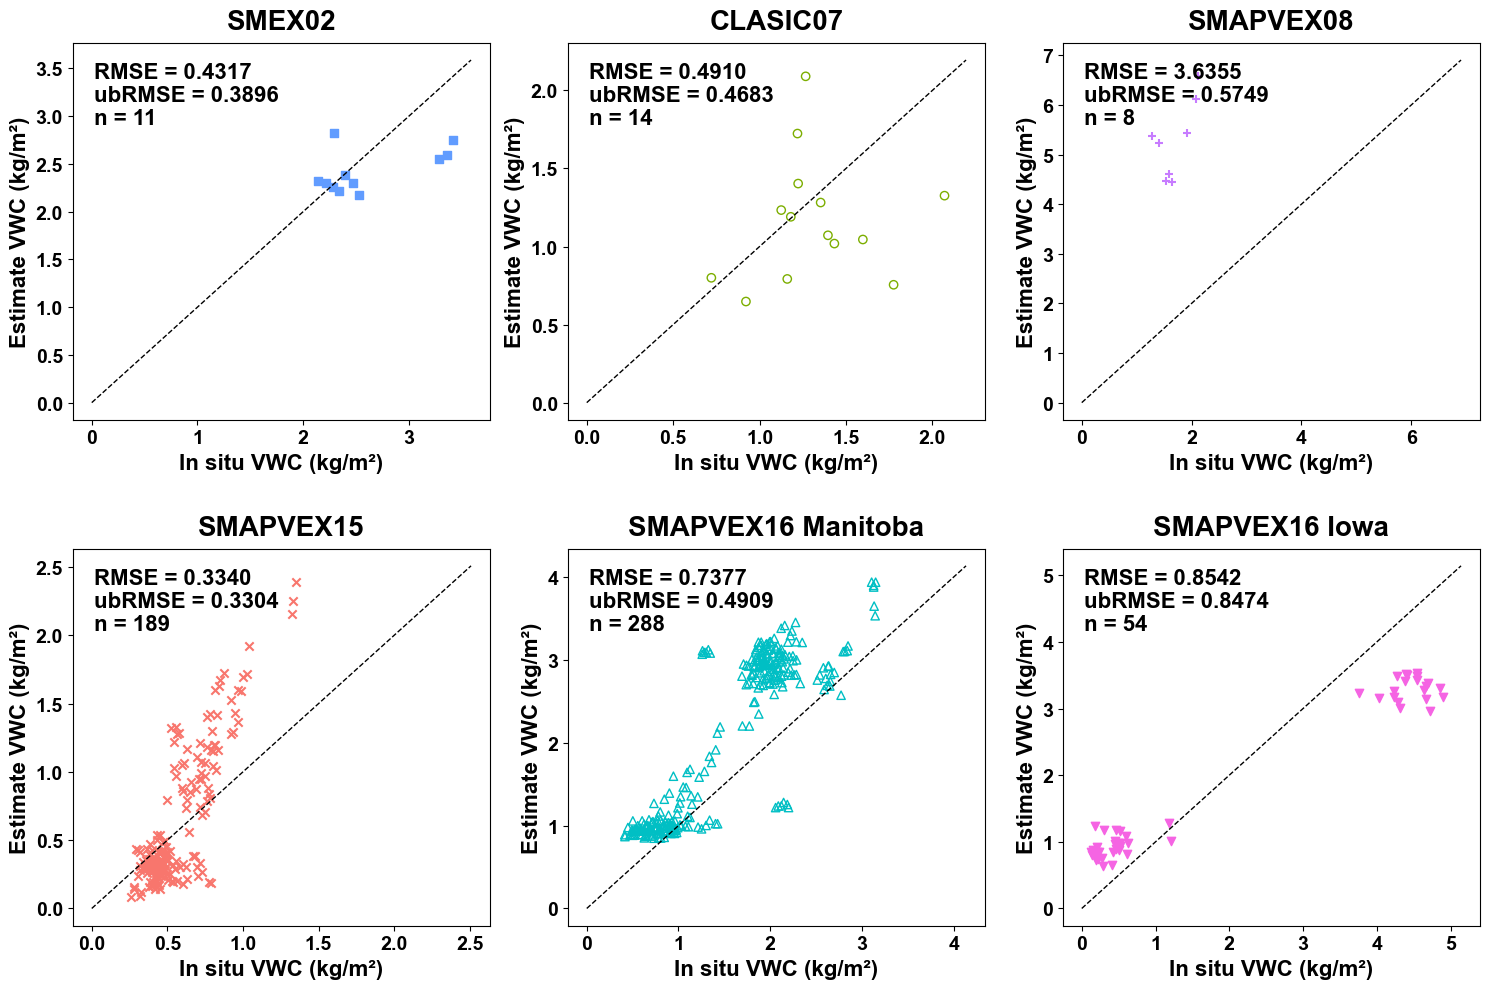

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 输入和sheet对应关系
INPUT_FILE = r"G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx"
OUTPUT_FILE = r"G:\文章\HUITU\Fig\Scatter_American.png"

# Sheet名称和绘制样式
SHEET_MAP = {
    "SMEX02": {"marker": "s", "color": "#619CFF"},
    "CLASIC07": {"marker": "o", "facecolor": "none", "edgecolor": "#7CAE00"},
    "SMAPVEX08": {"marker": "+", "color": "#C77CFF"},
    "SMAPVEX15": {"marker": "x", "color": "#F8766D"},  # 替换12为15
    "SMAPVEX16 Manitoba": {"marker": "^", "facecolor": "none", "edgecolor": "#00BFC4"},
    "SMAPVEX16 Iowa": {"marker": "v", "color": "#F564E3"},
}

# 计算指标函数
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean(((y_pred - y_true) - bias) ** 2))
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return rmse, ubrmse, r2, n

# 主函数
def main():
    # 全局字体设为 Arial
    plt.rcParams["font.family"] = "Arial"

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, (sheet, style) in enumerate(SHEET_MAP.items()):
        # 读取数据
        df = pd.read_excel(INPUT_FILE, sheet_name=sheet)

        # 数据清洗
        df = df.dropna(subset=["Map VWC", "VWC RF"])
        df = df.drop_duplicates(subset=["LonC", "LatC", "Map VWC"], keep="first")

        if df.empty:
            print(f"跳过 {sheet}，没有有效数据")
            continue

        y_true = df["Map VWC"].values
        y_pred = df["VWC RF"].values

        rmse, ubrmse, r2, n = calc_metrics(y_true, y_pred)

        ax = axes[idx]
        ax.scatter(y_true, y_pred, **style)

        # 1:1 线
        max_val = max(np.max(y_true), np.max(y_pred)) * 1.05
        ax.plot([0, max_val], [0, max_val], "k--", lw=1)

        # 坐标轴标签
        ax.set_xlabel("In situ VWC (kg/m²)", fontsize=16)
        ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=16)

        # 标题
        ax.set_title(sheet, fontsize=20, fontweight="bold", pad=10)

        # 指标文字
        ax.text(
            0.05,
            0.95,
            f"RMSE = {rmse:.4f}\n"
            f"ubRMSE = {ubrmse:.4f}\n"
            # f"R² = {r2:.4f}\n"
            f"n = {n}",
            transform=ax.transAxes,
            fontsize=16,
            verticalalignment="top",
        )

    # 布局调整并保存
    plt.tight_layout(h_pad=3.0)  # 增加行间距
    plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
    print(f"图像已保存到: {OUTPUT_FILE}")
    plt.show()  # 保持图像窗口打开

if __name__ == "__main__":
    main()


图像已保存到: G:\文章\HUITU\Fig\Scatter_American_New.png


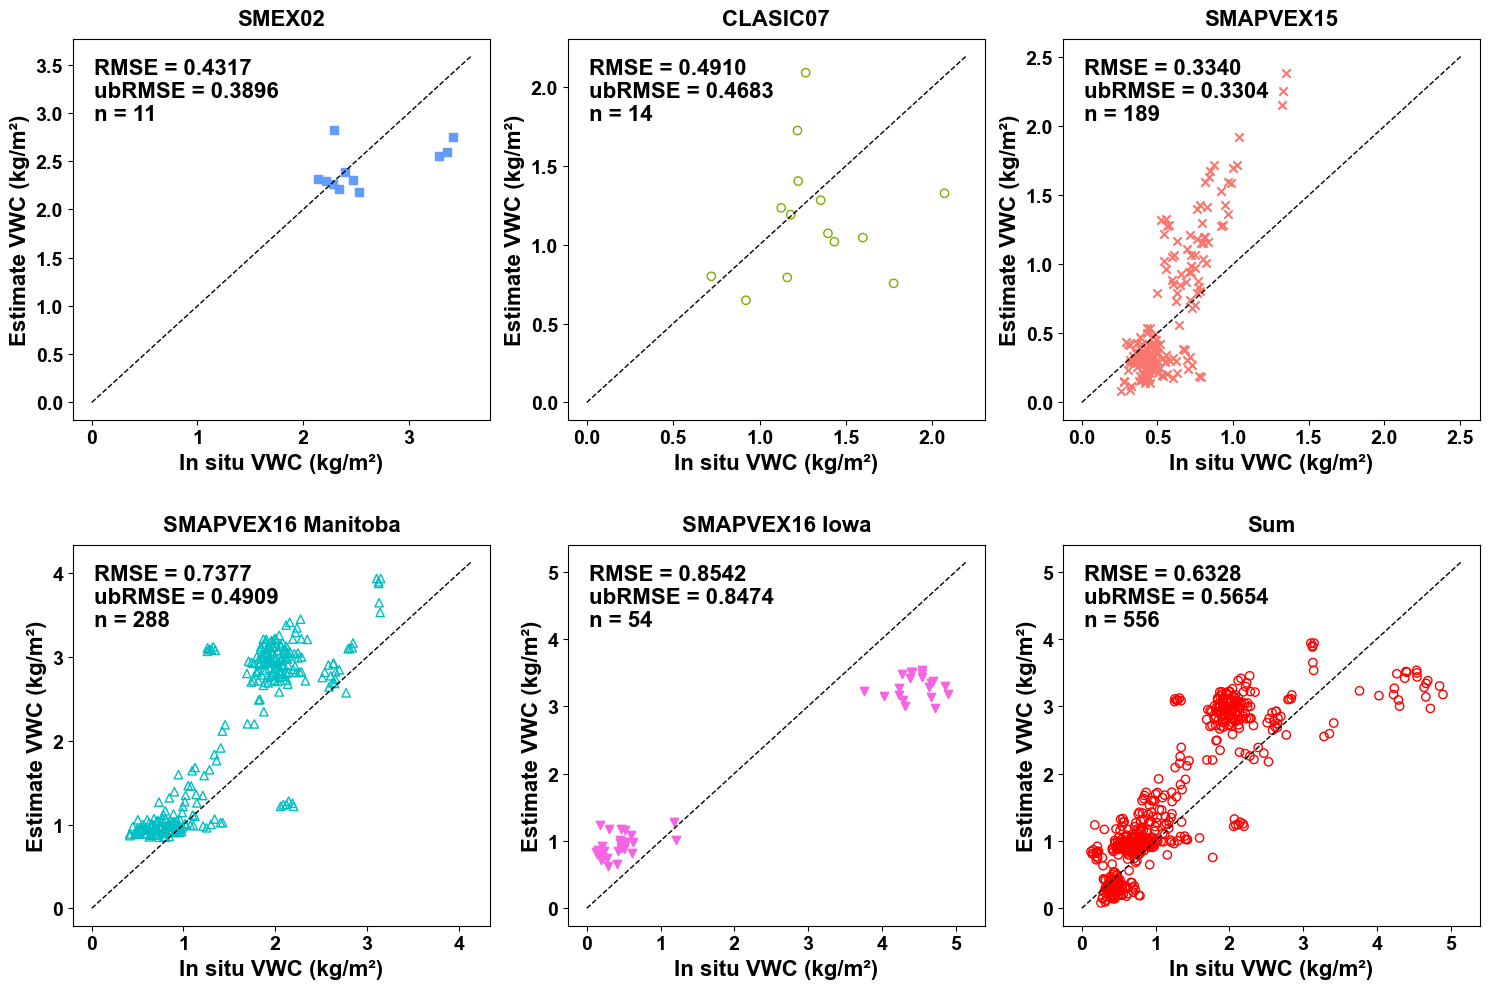

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 输入和输出文件
INPUT_FILE = r"G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx"
OUTPUT_FILE = r"G:\文章\HUITU\Fig\Scatter_American_New.png"

# Sheet名称和绘制样式（去掉 SMAPVEX08）
SHEET_MAP = {
    "SMEX02": {"marker": "s", "color": "#619CFF"},
    "CLASIC07": {"marker": "o", "facecolor": "none", "edgecolor": "#7CAE00"},
    "SMAPVEX15": {"marker": "x", "color": "#F8766D"},  
    "SMAPVEX16 Manitoba": {"marker": "^", "facecolor": "none", "edgecolor": "#00BFC4"},
    "SMAPVEX16 Iowa": {"marker": "v", "color": "#F564E3"},
}

# 计算指标函数
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean(((y_pred - y_true) - bias) ** 2))
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return rmse, ubrmse, r2, n

def main():
    plt.rcParams["font.family"] = "Arial"

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    all_y_true = []
    all_y_pred = []

    for idx, (sheet, style) in enumerate(SHEET_MAP.items()):
        df = pd.read_excel(INPUT_FILE, sheet_name=sheet)
        df = df.dropna(subset=["Map VWC", "VWC RF"])
        df = df.drop_duplicates(subset=["LonC", "LatC", "Map VWC"], keep="first")

        if df.empty:
            print(f"跳过 {sheet}，没有有效数据")
            continue

        y_true = df["Map VWC"].values
        y_pred = df["VWC RF"].values

        # 累积所有数据集
        all_y_true.append(y_true)
        all_y_pred.append(y_pred)

        rmse, ubrmse, r2, n = calc_metrics(y_true, y_pred)

        ax = axes[idx]
        ax.scatter(y_true, y_pred, **style)

        max_val = max(np.max(y_true), np.max(y_pred)) * 1.05
        ax.plot([0, max_val], [0, max_val], "k--", lw=1)

        ax.set_xlabel("In situ VWC (kg/m²)", fontsize=16)
        ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=16)
        ax.set_title(sheet, fontsize=16, fontweight="bold", pad=10)

        ax.text(
            0.05,
            0.95,
            f"RMSE = {rmse:.4f}\n"
            f"ubRMSE = {ubrmse:.4f}\n"
            f"n = {n}",
            transform=ax.transAxes,
            fontsize=16,
            verticalalignment="top",
        )

    # 合并所有数据集（去掉 SMAPVEX08）
    all_y_true = np.concatenate(all_y_true)
    all_y_pred = np.concatenate(all_y_pred)

    rmse, ubrmse, r2, n = calc_metrics(all_y_true, all_y_pred)

    # 最后一张子图画总结果
    ax_total = axes[-1]
    ax_total.scatter(all_y_true, all_y_pred, marker="o", facecolors="none", edgecolors="red")

    max_val = max(np.max(all_y_true), np.max(all_y_pred)) * 1.05
    ax_total.plot([0, max_val], [0, max_val], "k--", lw=1)

    ax_total.set_xlabel("In situ VWC (kg/m²)", fontsize=16)
    ax_total.set_ylabel("Estimate VWC (kg/m²)", fontsize=16)
    ax_total.set_title("Sum", fontsize=16, fontweight="bold", pad=10)

    ax_total.text(
        0.05,
        0.95,
        f"RMSE = {rmse:.4f}\n"
        f"ubRMSE = {ubrmse:.4f}\n"
        f"n = {n}",
        transform=ax_total.transAxes,
        fontsize=16,
        verticalalignment="top",
    )

    plt.tight_layout(h_pad=3.0)
    plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
    print(f"图像已保存到: {OUTPUT_FILE}")
    plt.show()

if __name__ == "__main__":
    main()


### （10）自定义的PFT类型尝试

### （11） 直接填充VWC的TIF数据，以满足正确的产品验证思路

In [2]:
import os
import pandas as pd
import rasterio
from datetime import datetime

# 配置路径
excel_path = r"G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx"
tif_folder = r"G:\data\VWC\VWCMap\Daily"

# 读取Excel文件
with pd.ExcelFile(excel_path) as xls:
    sheet_names = xls.sheet_names
    sheets_dict = {sheet: pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_names}

# 处理每个sheet
for sheet_name, df in sheets_dict.items():
    # 添加新列
    df['VWC RF products'] = None
    
    # 检查是否存在日期列
    if 'Date' not in df.columns and 'Datetime' not in df.columns:
        print(f"Sheet '{sheet_name}' 缺少日期列，跳过处理")
        continue
    
    # 确定日期列名
    date_col = 'Date' if 'Date' in df.columns else 'Datetime'
    
    # 转换日期为字符串格式YYYYMMDD
    df['date_str'] = df[date_col].apply(
        lambda x: x.strftime('%Y%m%d') if isinstance(x, datetime) else str(x).split()[0].replace('-', '')
    )
    
    # 分组处理相同日期的数据
    grouped = df.groupby('date_str')
    
    for date_str, group in grouped:
        tif_path = os.path.join(tif_folder, f"VWC-{date_str}.tif")
        
        # 检查TIFF文件是否存在
        if not os.path.exists(tif_path):
            print(f"文件不存在: {tif_path}")
            continue
        
        try:
            # 读取TIFF文件
            with rasterio.open(tif_path) as src:
                # 检查TIFF尺寸
                if src.height != 1800 or src.width != 3600:
                    print(f"警告: {tif_path} 尺寸不符 ({src.height}x{src.width})")
                
                # 提取数据
                for idx, row in group.iterrows():
                    try:
                        # 转换为整数索引（假设行列索引从1开始）
                        row_idx = int(row['row']) - 1
                        col_idx = int(row['col']) - 1
                        
                        # 验证索引范围
                        if 0 <= row_idx < 1800 and 0 <= col_idx < 3600:
                            # 读取像素值
                            value = src.read(1, window=((row_idx, row_idx+1), (col_idx, col_idx+1)))
                            df.at[idx, 'VWC RF products'] = value[0, 0]
                    except (ValueError, KeyError) as e:
                        print(f"行列索引错误: {e}")
        except rasterio.RasterioIOError:
            print(f"无法读取文件: {tif_path}")
    
    # 删除临时列
    df.drop('date_str', axis=1, inplace=True)

# 保存更新后的Excel文件
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    for sheet_name, df in sheets_dict.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("处理完成！")

处理完成！


### （12）由于VWC单天不完全覆盖，所以采用5日的窗口进行平均，测试结果（差不多）

In [15]:
import os
import pandas as pd
import rasterio
import numpy as np

# 配置路径
excel_path = r"G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx"
tif_folder = r"G:\data\VWC\VWCMap\Daily"

# 读取 Excel
with pd.ExcelFile(excel_path) as xls:
    sheet_names = xls.sheet_names
    sheets_dict = {sheet: pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_names}

# 处理每个 sheet
for sheet_name, df in sheets_dict.items():

    # 检查是否存在日期列
    if "Date" not in df.columns and "Datetime" not in df.columns:
        print(f"Sheet '{sheet_name}' 缺少日期列，跳过")
        continue

    # 日期列名
    date_col = "Date" if "Date" in df.columns else "Datetime"

    # 转换日期为字符串，不改变格式
    # ——如果是 datetime → 格式化为 yyyyMMdd
    # ——如果是数字/字符串 → 原样转换
    def safe_date_to_str(x):
        try:
            return x.strftime("%Y%m%d")
        except:
            return str(x).split()[0].replace("-", "")

    df["date_str"] = df[date_col].apply(safe_date_to_str)

    # 新增 5 日窗口列（float类型，避免FutureWarning）
    df["VWC RF products 5 Day"] = -9999.0

    # 分组处理
    grouped = df.groupby("date_str")

    for date_str, group in grouped:
        try:
            center_date = pd.to_datetime(date_str, format="%Y%m%d")
        except:
            print(f"无法解析日期（跳过）: {date_str}")
            continue

        # 构造 5 日窗口
        window_dates = [
            (center_date + pd.Timedelta(days=d)).strftime("%Y%m%d")
            for d in [-2, -1, 0, 1, 2]
        ]

        # 收集像元值
        for idx, row in group.iterrows():
            row_idx = int(row["row"]) - 1
            col_idx = int(row["col"]) - 1

            values = []

            for dstr in window_dates:
                tif_path = os.path.join(tif_folder, f"VWC-{dstr}.tif")

                if not os.path.exists(tif_path):
                    continue

                try:
                    with rasterio.open(tif_path) as src:
                        val = src.read(
                            1,
                            window=((row_idx, row_idx + 1), (col_idx, col_idx + 1)),
                        )[0, 0]

                        # 过滤无效值
                        if np.isfinite(val) and val != -9999:
                            values.append(val)

                except:
                    continue

            # 计算均值或设为 -9999
            if len(values) == 0:
                df.at[idx, "VWC RF products 5 Day"] = -9999.0
            else:
                df.at[idx, "VWC RF products 5 Day"] = float(np.mean(values))

# 删除临时列
for df in sheets_dict.values():
    df.drop(columns=["date_str"], inplace=True)

# 保存
with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
    for sheet_name, df in sheets_dict.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("处理完成！")


处理完成！


### （13）将产品填充的VWC值重新绘制散点图

跳过 SMEX02，没有有效数据
图像已保存到: G:\文章\HUITU\Fig\Scatter_American_RFproducts.png


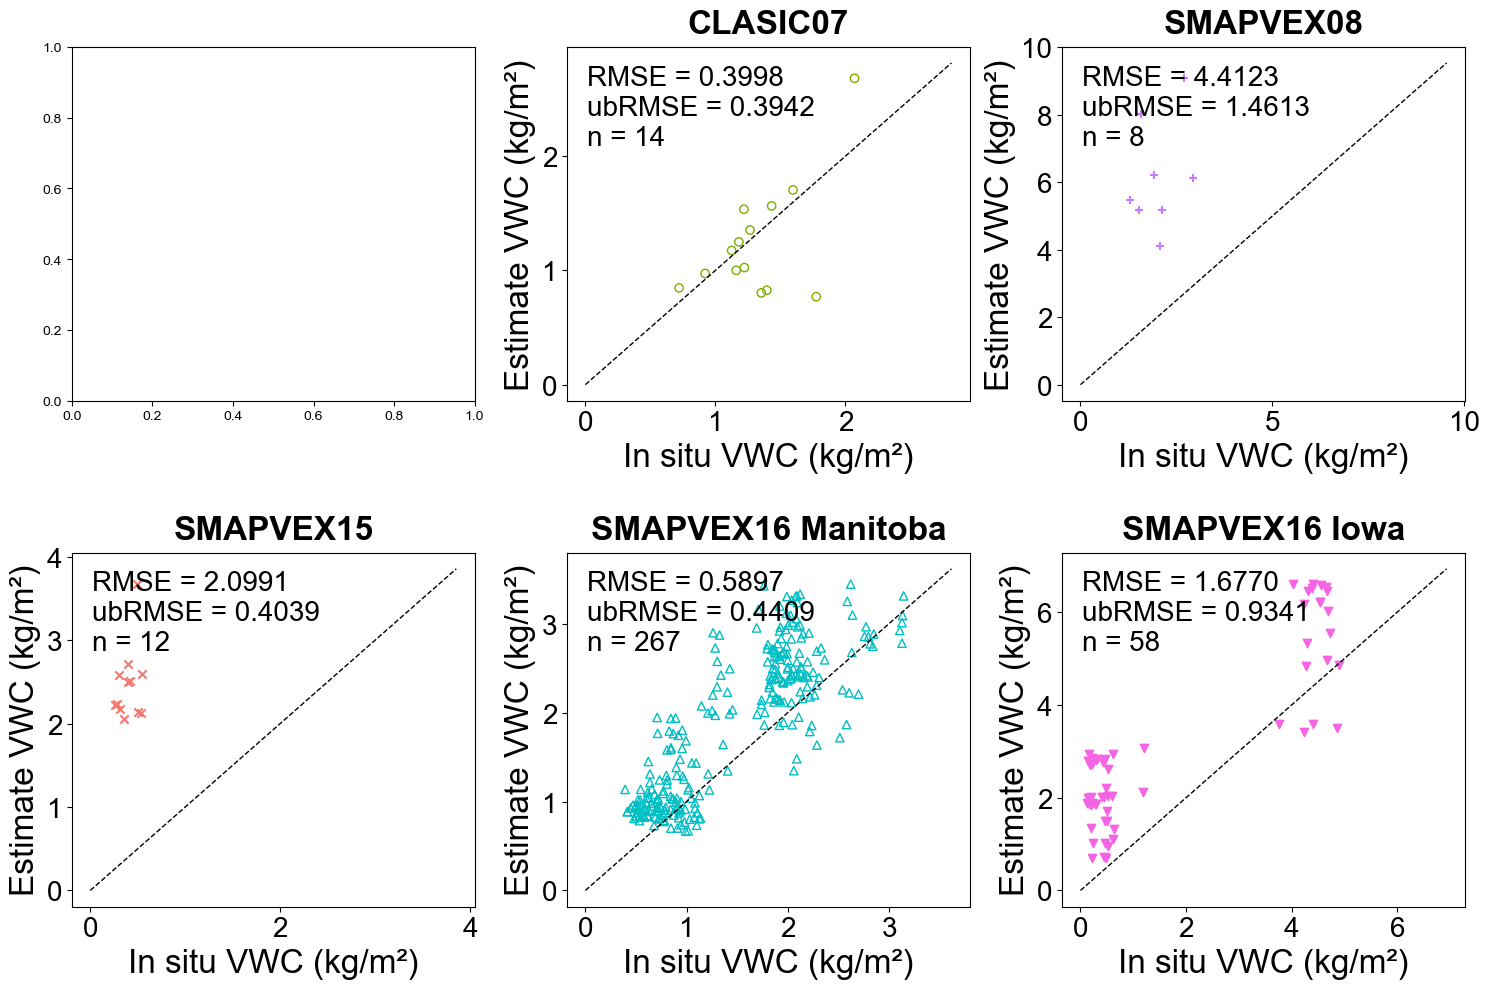

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 输入和sheet对应关系
INPUT_FILE = r"G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx"
OUTPUT_FILE = r"G:\文章\HUITU\Fig\Scatter_American_RFproducts.png"  # 更新文件名

# Sheet名称和绘制样式
SHEET_MAP = {
    "SMEX02": {"marker": "s", "color": "#619CFF"},
    "CLASIC07": {"marker": "o", "facecolor": "none", "edgecolor": "#7CAE00"},
    "SMAPVEX08": {"marker": "+", "color": "#C77CFF"},
    "SMAPVEX15": {"marker": "x", "color": "#F8766D"},
    "SMAPVEX16 Manitoba": {"marker": "^", "facecolor": "none", "edgecolor": "#00BFC4"},
    "SMAPVEX16 Iowa": {"marker": "v", "color": "#F564E3"},
}

# 计算指标函数
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean(((y_pred - y_true) - bias) ** 2))
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return rmse, ubrmse, r2, n

# 主函数
def main():
    # 全局字体设为 Arial
    plt.rcParams["font.family"] = "Arial"

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, (sheet, style) in enumerate(SHEET_MAP.items()):
        # 读取数据
        df = pd.read_excel(INPUT_FILE, sheet_name=sheet)
        
        # 使用新列"VWC RF products"替代"VWC RF"
        # 处理无效值：将-9999替换为NaN
        df["VWC RF products"] = df["VWC RF products"].replace(-9999, np.nan)
        
        # 数据清洗：去除新列中的NaN值
        df = df.dropna(subset=["Map VWC", "VWC RF products"])
        df = df.drop_duplicates(subset=["LonC", "LatC", "Map VWC"], keep="first")

        if df.empty:
            print(f"跳过 {sheet}，没有有效数据")
            continue

        y_true = df["Map VWC"].values
        y_pred = df["VWC RF products"].values  # 使用新列

        rmse, ubrmse, r2, n = calc_metrics(y_true, y_pred)

        ax = axes[idx]
        ax.scatter(y_true, y_pred, **style)

        # 1:1 线
        max_val = max(np.max(y_true), np.max(y_pred)) * 1.05
        ax.plot([0, max_val], [0, max_val], "k--", lw=1)

        # 坐标轴标签
        ax.set_xlabel("In situ VWC (kg/m²)", fontsize=24)
        ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=24)
        ax.tick_params(axis='both', labelsize=20)
        # 标题
        ax.set_title(sheet, fontsize=24, fontweight="bold", pad=10)

        # 指标文字
        ax.text(
            0.05,
            0.95,
            f"RMSE = {rmse:.4f}\n"
            f"ubRMSE = {ubrmse:.4f}\n"
            f"n = {n}",
            transform=ax.transAxes,
            fontsize=20,
            verticalalignment="top",
        )

    # 布局调整并保存
    plt.tight_layout(h_pad=3.0)
    plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
    print(f"图像已保存到: {OUTPUT_FILE}")
    plt.show()

if __name__ == "__main__":
    main()

#### 1’添加总散点图

✅ 图像已保存至:
G:\文章\HUITU\Fig\Scatter_American_RFproducts_AndSummary.png


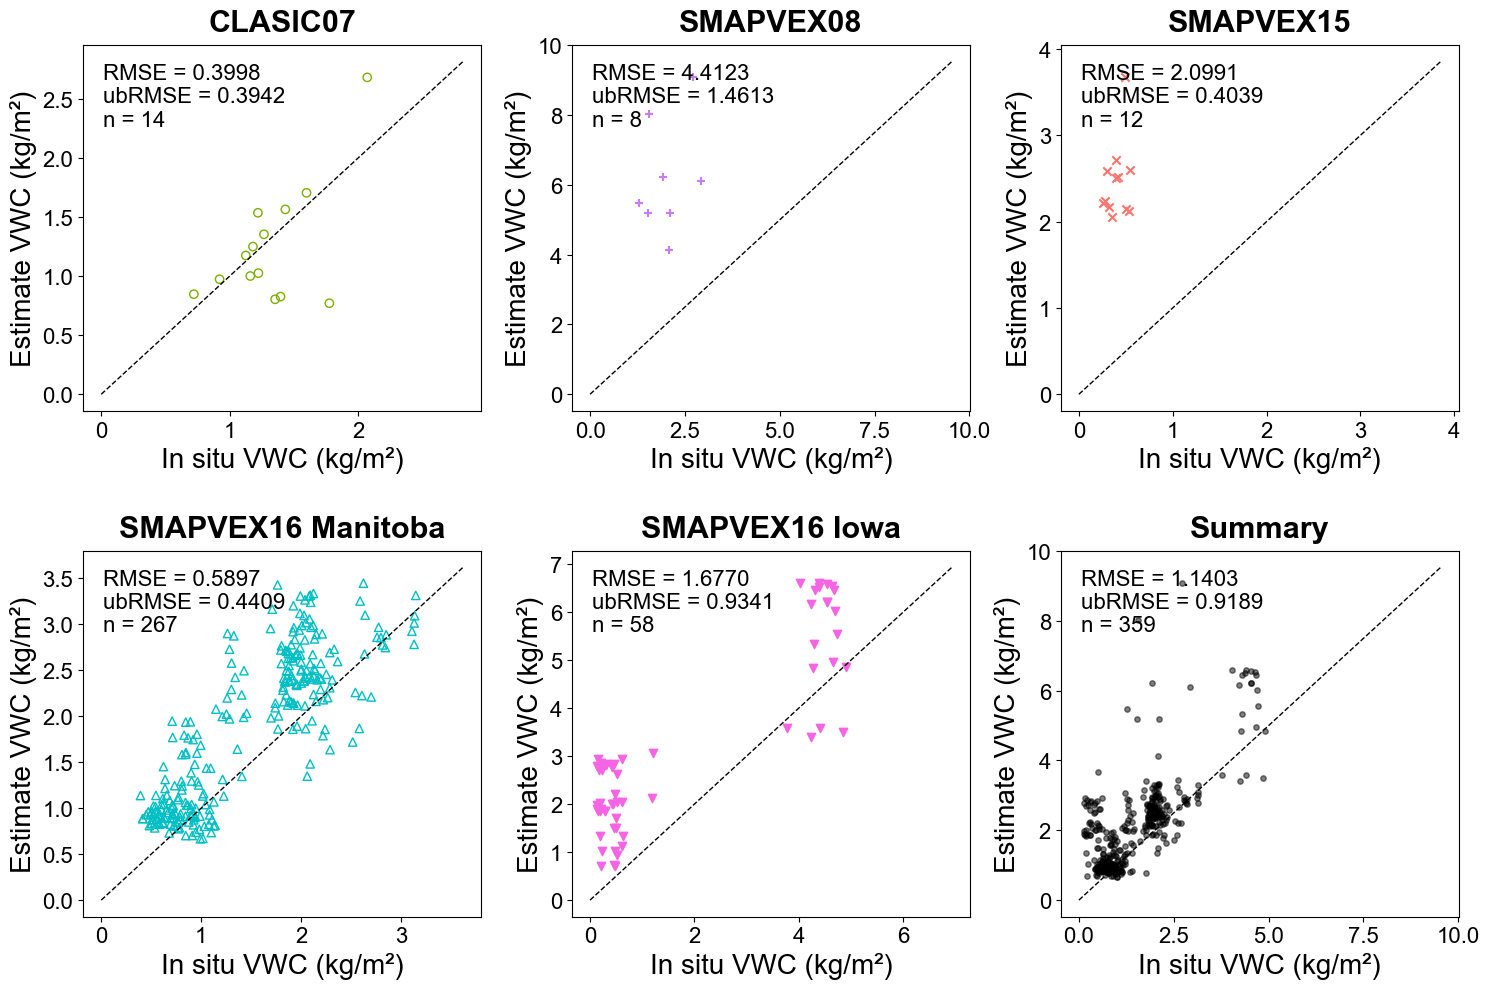

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 输入与输出路径
INPUT_FILE = r"G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx"
OUTPUT_FILE = r"G:\文章\HUITU\Fig\Scatter_American_RFproducts_AndSummary.png"

# Sheet名称与样式（去掉 SMEX02）
SHEET_MAP = {
    "CLASIC07": {"marker": "o", "facecolor": "none", "edgecolor": "#7CAE00"},
    "SMAPVEX08": {"marker": "+", "color": "#C77CFF"},
    "SMAPVEX15": {"marker": "x", "color": "#F8766D"},
    "SMAPVEX16 Manitoba": {"marker": "^", "facecolor": "none", "edgecolor": "#00BFC4"},
    "SMAPVEX16 Iowa": {"marker": "v", "color": "#F564E3"},
}

# 计算指标函数
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean(((y_pred - y_true) - bias) ** 2))
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return rmse, ubrmse, r2, n

def main():
    plt.rcParams["font.family"] = "Arial"

    # 调整布局：共 6 个子图（去掉 SMEX02 后，右下角留给 Summary）
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    all_true, all_pred = [], []  # 用于汇总 Summary 数据
    idx = 0

    for sheet, style in SHEET_MAP.items():
        df = pd.read_excel(INPUT_FILE, sheet_name=sheet)
        df["VWC RF products"] = df["VWC RF products"].replace(-9999, np.nan)
        df = df.dropna(subset=["Map VWC", "VWC RF products"])
        df = df.drop_duplicates(subset=["LonC", "LatC", "Map VWC"], keep="first")

        if df.empty:
            print(f"⚠️ 跳过 {sheet}（无有效数据）")
            continue

        y_true = df["Map VWC"].values
        y_pred = df["VWC RF products"].values

        # 汇总保存
        all_true.extend(y_true)
        all_pred.extend(y_pred)

        rmse, ubrmse, r2, n = calc_metrics(y_true, y_pred)
        ax = axes[idx]
        idx += 1

        ax.scatter(y_true, y_pred, **style)

        max_val = max(np.max(y_true), np.max(y_pred)) * 1.05
        ax.plot([0, max_val], [0, max_val], "k--", lw=1)
        ax.set_xlabel("In situ VWC (kg/m²)", fontsize=20)
        ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=20)
        ax.tick_params(axis='both', labelsize=16)
        ax.set_title(sheet, fontsize=22, fontweight="bold", pad=10)

        ax.text(
            0.05,
            0.95,
            f"RMSE = {rmse:.4f}\n"
            f"ubRMSE = {ubrmse:.4f}\n"
            f"n = {n}",
            transform=ax.transAxes,
            fontsize=16,
            verticalalignment="top",
        )

    # 绘制 Summary 子图
    summary_ax = axes[-1]
    if all_true and all_pred:
        all_true = np.array(all_true)
        all_pred = np.array(all_pred)
        rmse, ubrmse, r2, n = calc_metrics(all_true, all_pred)

        summary_ax.scatter(
            all_true, all_pred, s=15, color="black", alpha=0.5, label="All points"
        )
        max_val = max(np.max(all_true), np.max(all_pred)) * 1.05
        summary_ax.plot([0, max_val], [0, max_val], "k--", lw=1)
        summary_ax.set_xlabel("In situ VWC (kg/m²)", fontsize=20)
        summary_ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=20)
        summary_ax.tick_params(axis='both', labelsize=16)
        summary_ax.set_title("Summary", fontsize=22, fontweight="bold", pad=10)
        summary_ax.text(
            0.05,
            0.95,
            f"RMSE = {rmse:.4f}\n"
            f"ubRMSE = {ubrmse:.4f}\n"
            f"n = {n}",
            transform=summary_ax.transAxes,
            fontsize=16,
            verticalalignment="top",
        )
    else:
        summary_ax.axis("off")
        summary_ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=20)

    plt.tight_layout(h_pad=3.0)
    plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
    print(f"✅ 图像已保存至:\n{OUTPUT_FILE}")
    plt.show()

if __name__ == "__main__":
    main()


#### 2‘5日窗口平均散点图

跳过 SMEX02，没有有效数据
图像已保存到: G:\文章\HUITU\Fig\Scatter_American_RFproducts_5Days.png


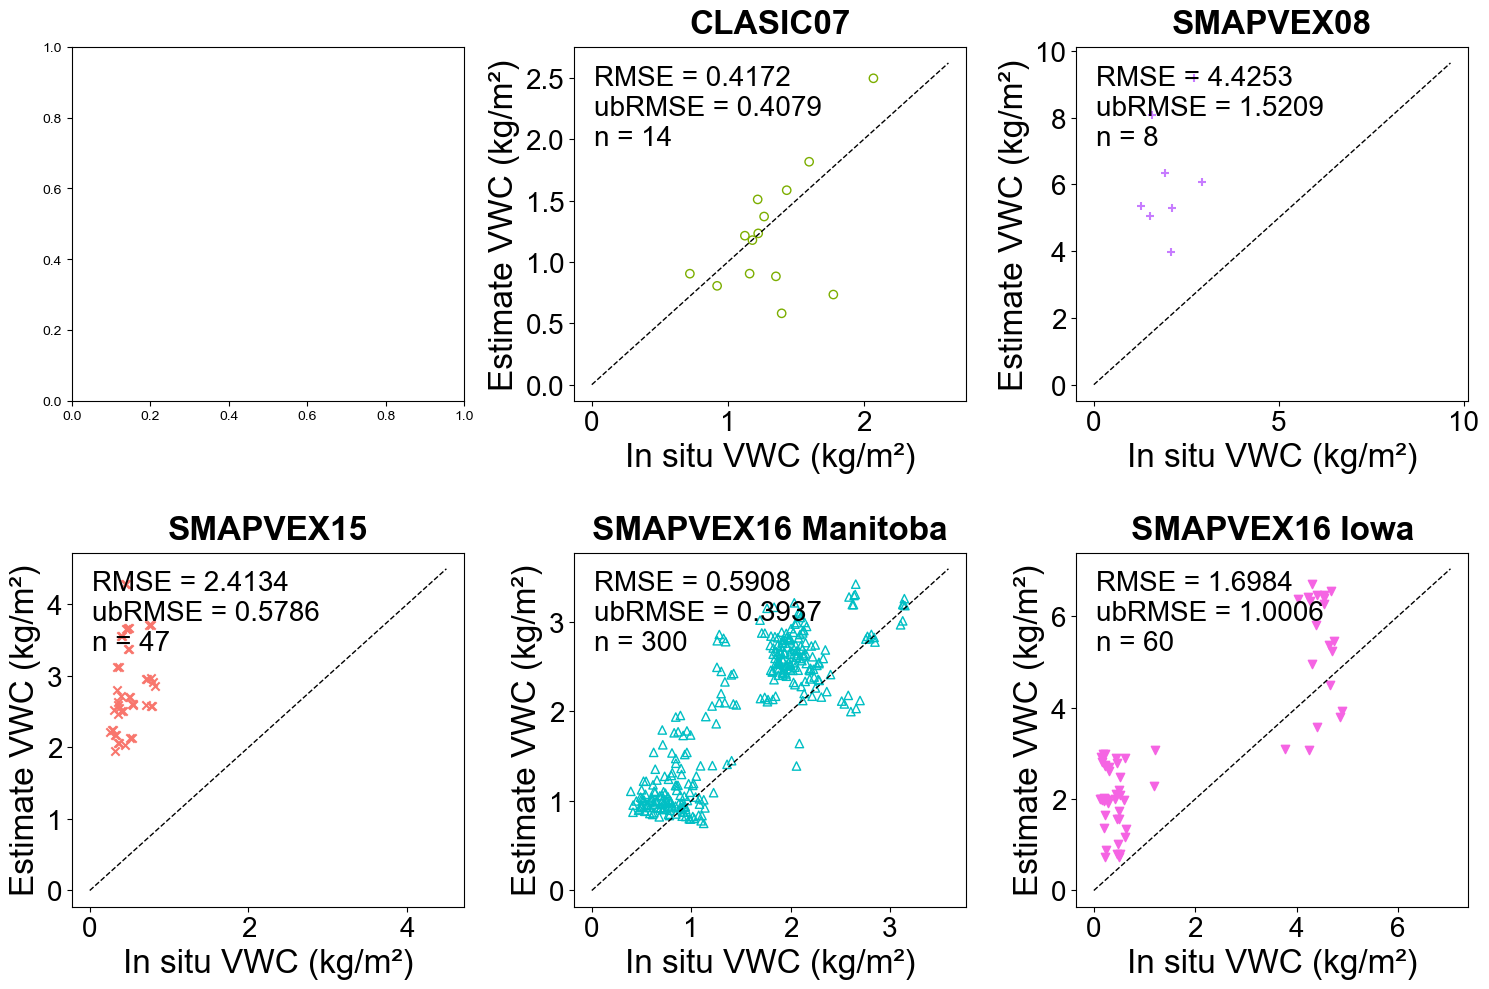

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 输入和sheet对应关系
INPUT_FILE = r"G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx"
OUTPUT_FILE = r"G:\文章\HUITU\Fig\Scatter_American_RFproducts_5Days.png"  # 更新文件名

# Sheet名称和绘制样式
SHEET_MAP = {
    "SMEX02": {"marker": "s", "color": "#619CFF"},
    "CLASIC07": {"marker": "o", "facecolor": "none", "edgecolor": "#7CAE00"},
    "SMAPVEX08": {"marker": "+", "color": "#C77CFF"},
    "SMAPVEX15": {"marker": "x", "color": "#F8766D"},
    "SMAPVEX16 Manitoba": {"marker": "^", "facecolor": "none", "edgecolor": "#00BFC4"},
    "SMAPVEX16 Iowa": {"marker": "v", "color": "#F564E3"},
}

# 计算指标函数
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean(((y_pred - y_true) - bias) ** 2))
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return rmse, ubrmse, r2, n

# 主函数
def main():
    # 全局字体设为 Arial
    plt.rcParams["font.family"] = "Arial"

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, (sheet, style) in enumerate(SHEET_MAP.items()):
        # 读取数据
        df = pd.read_excel(INPUT_FILE, sheet_name=sheet)
        
        # 使用新列"VWC RF products 5 Day"替代"VWC RF"
        # 处理无效值：将-9999替换为NaN
        df["VWC RF products 5 Day"] = df["VWC RF products 5 Day"].replace(-9999, np.nan)
        
        # 数据清洗：去除新列中的NaN值
        df = df.dropna(subset=["Map VWC", "VWC RF products 5 Day"])
        df = df.drop_duplicates(subset=["LonC", "LatC", "Map VWC"], keep="first")

        if df.empty:
            print(f"跳过 {sheet}，没有有效数据")
            continue

        y_true = df["Map VWC"].values
        y_pred = df["VWC RF products 5 Day"].values  # 使用新列

        rmse, ubrmse, r2, n = calc_metrics(y_true, y_pred)

        ax = axes[idx]
        ax.scatter(y_true, y_pred, **style)

        # 1:1 线
        max_val = max(np.max(y_true), np.max(y_pred)) * 1.05
        ax.plot([0, max_val], [0, max_val], "k--", lw=1)

        # 坐标轴标签
        ax.set_xlabel("In situ VWC (kg/m²)", fontsize=24)
        ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=24)
        ax.tick_params(axis='both', labelsize=20)
        # 标题
        ax.set_title(sheet, fontsize=24, fontweight="bold", pad=10)

        # 指标文字
        ax.text(
            0.05,
            0.95,
            f"RMSE = {rmse:.4f}\n"
            f"ubRMSE = {ubrmse:.4f}\n"
            f"n = {n}",
            transform=ax.transAxes,
            fontsize=20,
            verticalalignment="top",
        )

    # 布局调整并保存
    plt.tight_layout(h_pad=3.0)
    plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
    print(f"图像已保存到: {OUTPUT_FILE}")W
    plt.show()

if __name__ == "__main__":
    main()

#### 3'只绘制精度高的数据集（CLASIC07、SMAPVEX16 Manitoba + SMAPVEX16 Iowa）

✅ 图像已保存至:
G:\文章\HUITU\Fig\Scatter_CLASIC07_SMAPVEX16_Summary.png


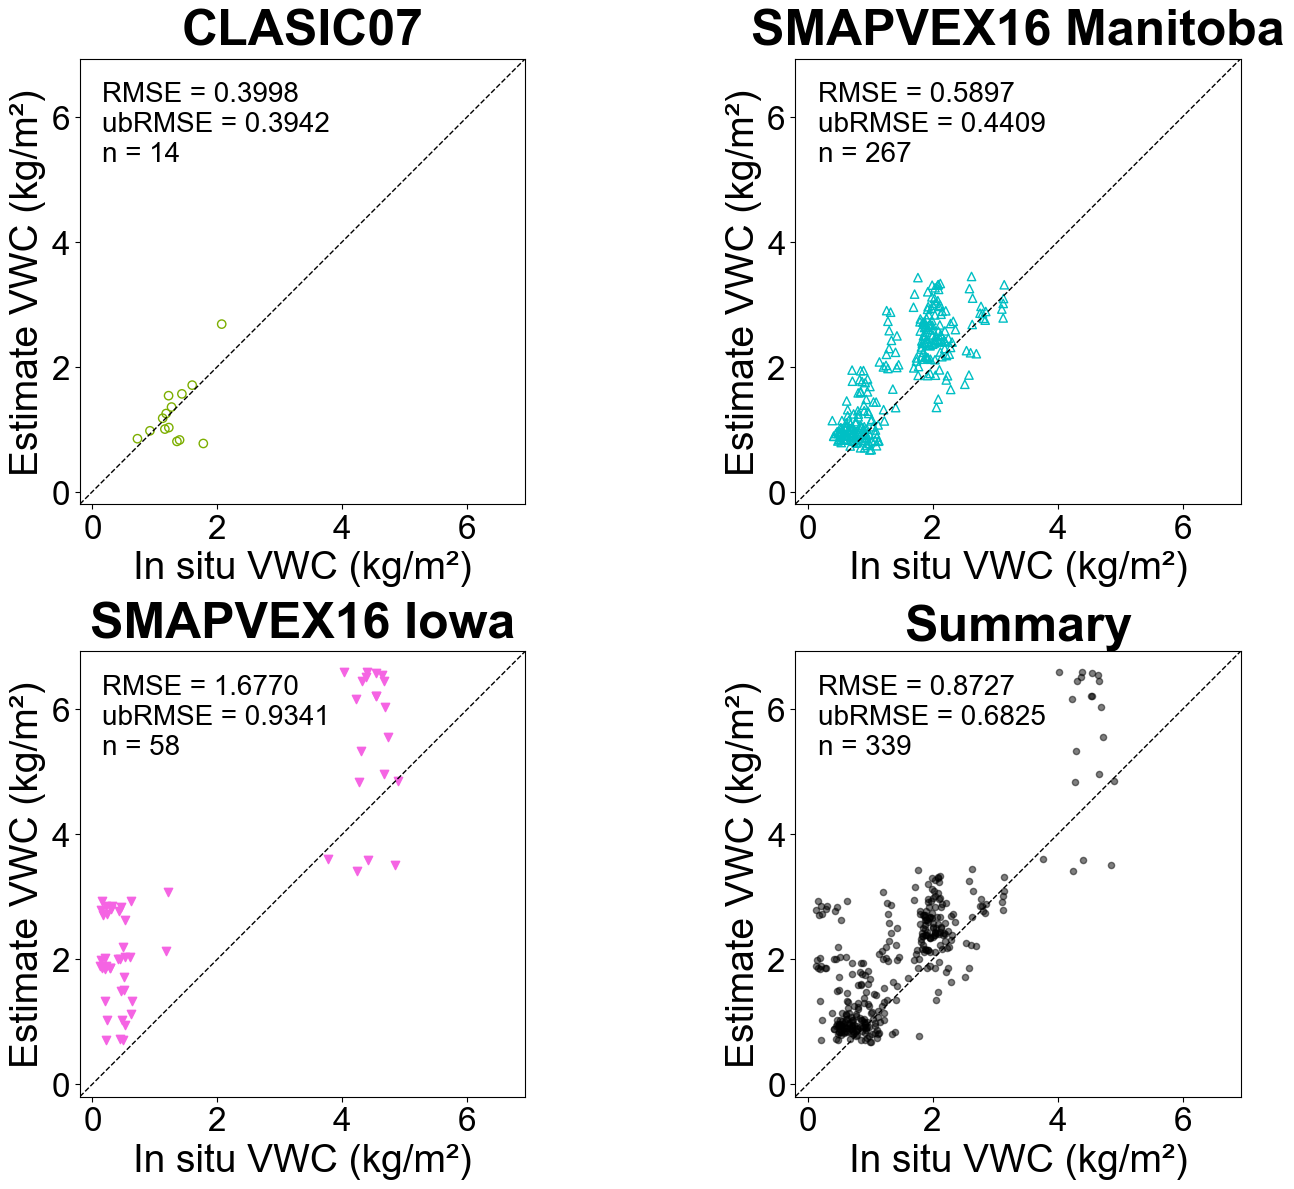

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 输入与输出路径
INPUT_FILE = r"G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx"
OUTPUT_FILE = r"G:\文章\HUITU\Fig\Scatter_CLASIC07_SMAPVEX16_Summary.png"

# 三套数据（每个独立绘制）
SHEET_MAP = {
    "CLASIC07": {"marker": "o", "facecolor": "none", "edgecolor": "#7CAE00"},
    "SMAPVEX16 Manitoba": {"marker": "^", "facecolor": "none", "edgecolor": "#00BFC4"},
    "SMAPVEX16 Iowa": {"marker": "v", "color": "#F564E3"},
}

# 计算指标函数
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean(((y_pred - y_true) - bias) ** 2))
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return rmse, ubrmse, r2, n

def main():
    plt.rcParams["font.family"] = "Arial"

    # 2×2 子图布局
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    all_true, all_pred = [], []

    # 用于统一坐标范围
    min_val, max_val = 9999, -9999

    # 缓存数据用于绘图
    data_bank = {}

    # ---- 读取数据并记录所有数据集的最小/最大值 ----
    for sheet, style in SHEET_MAP.items():
        df = pd.read_excel(INPUT_FILE, sheet_name=sheet)
        df["VWC RF products"] = df["VWC RF products"].replace(-9999, np.nan)
        df = df.dropna(subset=["Map VWC", "VWC RF products"])
        df = df.drop_duplicates(subset=["LonC", "LatC", "Map VWC"], keep="first")

        y_true = df["Map VWC"].values
        y_pred = df["VWC RF products"].values

        all_true.extend(y_true)
        all_pred.extend(y_pred)

        # 更新整体取值范围
        min_val = min(min_val, np.min(y_true), np.min(y_pred))
        max_val = max(max_val, np.max(y_true), np.max(y_pred))

        data_bank[sheet] = (y_true, y_pred, style)

    # 稍微扩展边界
    pad = (max_val - min_val) * 0.05
    min_val -= pad
    max_val += pad

    # ---- 绘制三个数据集子图 ----
    idx = 0
    for sheet, (y_true, y_pred, style) in data_bank.items():
        ax = axes[idx]
        idx += 1

        rmse, ubrmse, r2, n = calc_metrics(y_true, y_pred)

        ax.scatter(y_true, y_pred, **style)

        # 统一坐标范围
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)

        # 保持坐标轴为正方形（关键）
        ax.set_aspect("equal", adjustable="box")

        # 1:1 线
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

        ax.set_xlabel("In situ VWC (kg/m²)", fontsize=28)
        ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=28)
        ax.tick_params(axis="both", labelsize=24)
        ax.set_title(sheet, fontsize=36, fontweight="bold", pad=10)

        ax.text(
            0.05, 0.95,
            f"RMSE = {rmse:.4f}\n"
            f"ubRMSE = {ubrmse:.4f}\n"
            f"n = {n}",
            transform=ax.transAxes,
            fontsize=20,
            verticalalignment="top",
        )

    # ---- Summary 子图 ----
    summary_ax = axes[-1]
    all_true = np.array(all_true)
    all_pred = np.array(all_pred)

    rmse, ubrmse, r2, n = calc_metrics(all_true, all_pred)

    summary_ax.scatter(all_true, all_pred, s=20, color="black", alpha=0.5)

    summary_ax.set_xlim(min_val, max_val)
    summary_ax.set_ylim(min_val, max_val)

    # 保证 summary 也是正方形
    summary_ax.set_aspect("equal", adjustable="box")

    summary_ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

    summary_ax.set_title("Summary", fontsize=36, fontweight="bold")
    summary_ax.set_xlabel("In situ VWC (kg/m²)", fontsize=28)
    summary_ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=28)
    summary_ax.tick_params(axis="both", labelsize=24)

    summary_ax.text(
        0.05, 0.95,
        f"RMSE = {rmse:.4f}\n"
        f"ubRMSE = {ubrmse:.4f}\n"
        f"n = {n}",
        transform=summary_ax.transAxes,
        fontsize=20,
        verticalalignment="top",
    )

    plt.tight_layout()
    plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
    print(f"✅ 图像已保存至:\n{OUTPUT_FILE}")
    plt.show()

if __name__ == "__main__":
    main()


## 3.4 站点实测数据验证情况→中国SMELR

### 1’ 预备工作（再计算一遍）

In [1]:
# 数据预测
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import joblib
import os
from pathlib import Path
import warnings
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')

# 设置全局字体
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.titleweight'] = 'bold'

# 常量定义 - 更新为包含Hveg的新模型
MODEL_NAME = "RFR_6VOD_LAI_PFTs_Hveg.pkl"

# 列名到模型特征名的映射 - 添加Hveg特征
COLUMN_TO_FEATURE_MAPPING = {
    # VOD变量 (数据表列名 -> 模型特征名)
    'ku_vod_H': 'VOD_Ku_Hpol_Asc',
    'ku_vod_V': 'VOD_Ku_Vpol_Asc',
    'x_vod_H': 'VOD_X_Hpol_Asc',
    'x_vod_V': 'VOD_X_Vpol_Asc',
    'c_vod_H': 'VOD_C_Hpol_Asc',
    'c_vod_V': 'VOD_C_Vpol_Asc',
    
    # LAI变量
    'LAI_Satellite': 'LAI',
    
    # Hveg变量 - 新增
    'Hveg_Satellite': 'Hveg',
    
    # PFT变量（数据表列名 -> 模型特征名）
    'grassman': 'Grass_man',
    'grassnat': 'Grass_nat',
    'shrubbd': 'Shrub_bd',
    'shrubbe': 'Shrub_be',
    'shrubnd': 'Shrub_nd',
    'shrubne': 'Shrub_ne',
    'treebd': 'Tree_bd',
    'treebe': 'Tree_be',
    'treend': 'Tree_nd',
    'treene': 'Tree_ne'
}

# 植被类型映射
VEGETATION_TYPES = {
    'CornVegMeasured': 'Corn (2017)',
    'OatVegMeasured': 'Oat (2017)',
    'GrassVWC': 'Grass (2018)'
}

# 实测与拟合数据映射
FITTING_MAPPING = {
    'CornVegMeasured': 'CornVegFitting',
    'OatVegMeasured': 'OatVegFitting',
    'GrassVWC': 'GrassVWC'  # 2018年没有拟合数据
}

# 实测VWC列名映射
ACTUAL_COL_MAPPING = {
    'CornVegMeasured': 'total_VWC(kg/m2)',
    'OatVegMeasured': 'total_VWC(kg/m2)',
    'GrassVWC': 'vegetation water content(kg/m2)'
}

# 实测数据样式
ACTUAL_STYLE = {
    'color': 'black',
    'marker': 'o',
    'markersize': 8,
    'markerfacecolor': 'none',
    'markeredgewidth': 1.5,
    'label': 'Measured'
}

# 预测数据样式
PREDICTED_STYLE = {
    'color': 'red',
    'linestyle': '-',
    'linewidth': 2,
    'label': 'Predicted'
}

def load_data(file_path):
    """加载Excel文件中的所有工作表"""
    print(f"加载文件: {file_path}")
    data_dict = {}
    
    # 获取所有工作表名称
    xl = pd.ExcelFile(file_path)
    sheet_names = xl.sheet_names
    
    for sheet in sheet_names:
        try:
            df = pd.read_excel(file_path, sheet_name=sheet)
            print(f"  - {sheet}: {len(df)}行")
            
            # 确保日期是datetime类型
            if 'Date' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'])
            
            data_dict[sheet] = df
        except Exception as e:
            print(f"  加载 {sheet} 时出错: {str(e)}")
            data_dict[sheet] = pd.DataFrame()
    
    return data_dict

def predict_vwc_unified_model(df):
    """
    使用统一的机器学习模型预测VWC（6VOD+LAI+10PFT+Hveg）
    注意：在送入模型之前，会对10个PFT模型特征做除以100处理（统一为0-1比例）。
    """
    # 加载模型
    model_path = f"models/{MODEL_NAME}"
    if not os.path.exists(model_path):
        print(f"警告: 模型文件不存在: {model_path}")
        return pd.Series(np.nan, index=df.index)
    
    try:
        model = joblib.load(model_path)
        print(f"加载统一模型: {model_path}")
        if hasattr(model, 'feature_names_in_'):
            expected_features = list(model.feature_names_in_)
            print(f"  模型期望特征: {expected_features}")
        else:
            expected_features = []
            print("  警告: 模型没有 feature_names_in_ 属性，后续按 COLUMN_TO_FEATURE_MAPPING 顺序处理")
    except Exception as e:
        print(f"加载模型失败: {str(e)}")
        return pd.Series(np.nan, index=df.index)
    
    # 1. 优先使用地面实测数据替换卫星数据（LAI）
    if 'LAI' in df.columns:
        lai_mask = df['LAI'].notna() & (df['LAI'] > 0)
        if lai_mask.any():
            df.loc[lai_mask, 'LAI_Satellite'] = df.loc[lai_mask, 'LAI']
            print(f"  使用实测LAI替换了 {lai_mask.sum()} 行数据")
    
    # Hveg替换（仅Duolun表格）
    if 'Height(cm)' in df.columns:
        hveg_mask = df['Height(cm)'].notna() & (df['Height(cm)'] > 0)
        if hveg_mask.any():
            # 将高度从cm转换为m（除以100）
            df.loc[hveg_mask, 'Hveg_Satellite'] = df.loc[hveg_mask, 'Height(cm)'] / 100.0
            print(f"  使用实测Hveg替换了 {hveg_mask.sum()} 行数据（高度单位转换为m）")
    
    # 2. 检查所有必需特征（数据表中的列名）是否存在
    required_features = list(COLUMN_TO_FEATURE_MAPPING.keys())
    missing_features = [feat for feat in required_features if feat not in df.columns]
    if missing_features:
        print(f"  缺少特征: {', '.join(missing_features)}")
        return pd.Series(np.nan, index=df.index)
    
    # 3. 时间序列插值（按 Date 做 daily reindex + 时间插值）
    if 'Date' in df.columns and not df.empty:
        df = df.sort_values('Date')
        date_index = pd.DatetimeIndex(df['Date'])
        df_temp = df.set_index('Date')
        full_range = pd.date_range(start=date_index.min(), end=date_index.max(), freq='D')
        df_full = df_temp.reindex(full_range)
        # 对原始数据表列名进行插值（对 required_features 列插值）
        for col in required_features:
            if col in df_full.columns:
                df_full[col] = df_full[col].interpolate(method='time', limit_direction='both')
                print(f"  已完成 {col} 的时间序列插值")
        df = df_full.reset_index().rename(columns={'index': 'Date'})
    else:
        print("  无日期列或数据为空，跳过插值")
    
    # 4. 准备特征数据 - 应用列名映射：把数据表列映射为模型特征列
    X = pd.DataFrame(index=df.index)
    for data_col, model_feature in COLUMN_TO_FEATURE_MAPPING.items():
        if data_col in df.columns:
            X[model_feature] = df[data_col]
        else:
            X[model_feature] = np.nan  # 保证列存在，后面会 dropna
    
    # 5. ✅ 对 10 个 PFT 模型特征 /100 （将百分比转为比例）
    pft_model_features = [
        'Grass_man','Grass_nat',
        'Shrub_bd','Shrub_be','Shrub_nd','Shrub_ne',
        'Tree_bd','Tree_be','Tree_nd','Tree_ne'
    ]
    for pf in pft_model_features:
        if pf in X.columns:
            # 先打印一些信息（可删除）
            print(f"  PFT 调整: 对特征 {pf} 执行除以100（若存在）")
            X[pf] = X[pf] / 100.0
    
    # 6. 移除缺失值（删除含有 NaN 的行）
    initial_count = len(X)
    X = X.dropna()
    removed_count = initial_count - len(X)
    if removed_count > 0:
        print(f"  移除了 {removed_count} 行包含缺失值的数据")
    if X.empty:
        print("  无有效数据可用于预测（X 为空）")
        return pd.Series(np.nan, index=df.index)
    
    # 7. 确保特征顺序与模型期望一致（如果模型保存了 feature_names_in_）
    if hasattr(model, 'feature_names_in_') and expected_features:
        # 检查 expected_features 是否都在 X 中
        miss_in_X = [f for f in expected_features if f not in X.columns]
        if miss_in_X:
            print(f"  警告: X 中缺少模型期望的特征: {miss_in_X}")
            return pd.Series(np.nan, index=df.index)
        X = X[expected_features]
    
    # 8. 预测VWC 并返回与原始 df 相同索引长度的序列（预测在 X.index 对应位置）
    try:
        y_pred = model.predict(X)
        full_pred = pd.Series(np.nan, index=df.index)
        # X.index 已是 df.index 的子集（经过 reindex 或 reset），用原索引定位
        full_pred.loc[X.index] = y_pred
        return full_pred
    except Exception as e:
        print(f"  预测失败: {str(e)}")
        return pd.Series(np.nan, index=df.index)

def create_combined_plots(data_dict_2017, data_dict_2018):
    """创建组合时间序列图并保存预测结果"""
    print("创建组合时间序列图...")
    
    # 创建输出目录
    output_dir = Path("prediction_results")
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # 创建图形
    fig = plt.figure(figsize=(15, 12))
    gs = gridspec.GridSpec(3, 1, figure=fig, hspace=0.3)
    
    # 植被类型列表
    vegetation_types = [
        ('CornVegMeasured', data_dict_2017),  # 玉米
        ('OatVegMeasured', data_dict_2017),   # 燕麦
        ('GrassVWC', data_dict_2018)          # 草
    ]
    
    # 存储所有评估指标
    all_metrics = {}
    # 存储所有预测结果
    all_predictions = {}
    
    # 遍历所有植被类型
    for idx, (veg_type, data_dict) in enumerate(vegetation_types):
        ax = fig.add_subplot(gs[idx])
        
        # 获取当前植被类型的实测列名
        actual_col = ACTUAL_COL_MAPPING[veg_type]
        
        # 初始化Y轴范围
        y_min = float('inf')
        y_max = float('-inf')
        
        # 获取实测数据（测量表）
        if veg_type in data_dict:
            df_measured = data_dict[veg_type].copy()
            if 'Date' not in df_measured.columns:
                print(f"警告: {veg_type} 中没有 'Date' 列")
                continue
            df_measured = df_measured.sort_values('Date')
            
            # 更新Y轴范围（实测值）
            if actual_col in df_measured.columns:
                measured_values = df_measured[actual_col].dropna()
                if not measured_values.empty:
                    y_min = min(y_min, measured_values.min())
                    y_max = max(y_max, measured_values.max())
            
            # 获取拟合数据用于预测
            fitting_sheet = FITTING_MAPPING.get(veg_type, veg_type)
            if fitting_sheet in data_dict:
                df_fitting = data_dict[fitting_sheet].copy()
                if 'Date' not in df_fitting.columns:
                    print(f"警告: {fitting_sheet} 中没有 'Date' 列")
                    continue
                df_fitting = df_fitting.sort_values('Date')
            else:
                # 2018年没有单独的拟合数据
                df_fitting = df_measured.copy()
            
            metrics = []
            col_name = "Predicted_VWC"
            
            # 如果列不存在，使用模型预测
            if col_name not in df_fitting.columns:
                print(f"为 {fitting_sheet} 预测 VWC...")
                df_fitting[col_name] = predict_vwc_unified_model(df_fitting)
            
            # 只在有有效预测值的点进行绘制和评估
            if col_name in df_fitting.columns:
                pred_values = df_fitting[col_name].dropna()
                if not pred_values.empty:
                    y_min = min(y_min, pred_values.min())
                    y_max = max(y_max, pred_values.max())
                
                valid_mask = df_fitting[col_name].notna()
                valid_dates = df_fitting['Date'][valid_mask]
                valid_values = df_fitting[col_name][valid_mask]
                
                if len(valid_dates) > 3:
                    try:
                        date_numeric = (valid_dates - valid_dates.min()).dt.days
                        spline = make_interp_spline(date_numeric, valid_values, k=3)
                        dense_dates = np.linspace(date_numeric.min(), date_numeric.max(), 300)
                        dense_values = spline(dense_dates)
                        dense_dates = valid_dates.min() + pd.to_timedelta(dense_dates, unit='D')
                        ax.plot(dense_dates, dense_values,
                                color=PREDICTED_STYLE['color'],
                                linestyle=PREDICTED_STYLE['linestyle'],
                                linewidth=PREDICTED_STYLE['linewidth'],
                                label=PREDICTED_STYLE['label'])
                    except Exception as e:
                        print(f"样条插值失败: {str(e)}")
                        ax.plot(valid_dates, valid_values,
                                color=PREDICTED_STYLE['color'],
                                linestyle=PREDICTED_STYLE['linestyle'],
                                linewidth=PREDICTED_STYLE['linewidth'],
                                label=PREDICTED_STYLE['label'])
                else:
                    ax.plot(valid_dates, valid_values,
                            color=PREDICTED_STYLE['color'],
                            linestyle=PREDICTED_STYLE['linestyle'],
                            linewidth=PREDICTED_STYLE['linewidth'],
                            label=PREDICTED_STYLE['label'])
                
                # 找出同时有实测值和预测值的点
                common_data = pd.merge(
                    df_measured[['Date', actual_col]],
                    df_fitting[['Date', col_name]],
                    on='Date',
                    how='inner'
                ).dropna(subset=[actual_col, col_name])
                
                if not common_data.empty:
                    common_min = min(common_data[actual_col].min(), common_data[col_name].min())
                    common_max = max(common_data[actual_col].max(), common_data[col_name].max())
                    y_min = min(y_min, common_min)
                    y_max = max(y_max, common_max)
                    
                    ax.plot(common_data['Date'], common_data[actual_col],
                            linestyle='',
                            color=ACTUAL_STYLE['color'],
                            marker=ACTUAL_STYLE['marker'],
                            markersize=ACTUAL_STYLE['markersize'],
                            markerfacecolor=ACTUAL_STYLE['markerfacecolor'],
                            markeredgewidth=ACTUAL_STYLE['markeredgewidth'],
                            label=ACTUAL_STYLE['label'])
                    
                    rmse = np.sqrt(mean_squared_error(common_data[actual_col], common_data[col_name]))
                    r2 = r2_score(common_data[actual_col], common_data[col_name])
                    
                    metrics.append({'rmse': rmse, 'r2': r2})
                    
                    model_key = f"{veg_type}"
                    all_predictions[model_key] = {
                        'dates': common_data['Date'].tolist(),
                        'measured': common_data[actual_col].tolist(),
                        'predicted': common_data[col_name].tolist(),
                        'rmse': rmse,
                        'r2': r2
                    }
        
        # 设置子图标题与标签
        ax.set_title(VEGETATION_TYPES.get(veg_type, veg_type),
                     fontsize=16, fontweight='bold')
        if idx == 2:
            ax.set_xlabel('Date', fontsize=12, fontweight='bold')
        ax.set_ylabel('VWC (kg/m²)', fontsize=12, fontweight='bold')
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # 动态设置Y轴范围
        if y_min != float('inf') and y_max != float('-inf'):
            y_range = y_max - y_min
            padding = y_range * 0.1
            y_min = max(0, y_min - padding)
            y_max = y_max + padding
            ax.set_ylim(y_min, y_max)
        else:
            ax.set_ylim(0, 10)
        
        # 添加图例
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='best')
        
        # 添加评估指标文本框
        if metrics:
            metric_text = f"RMSE = {metrics[0]['rmse']:.3f}\nR² = {metrics[0]['r2']:.3f}"
            ax.text(0.02, 0.95, metric_text,
                    transform=ax.transAxes,
                    fontsize=12,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        all_metrics[veg_type] = metrics
    
    # 调整布局并保存图像
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    figures_dir = Path("figures")
    figures_dir.mkdir(parents=True, exist_ok=True)
    fig_path = figures_dir / "Combined_VWC_Time_Series_6VOD_LAI_PFT_Hveg.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"组合时间序列图已保存至: {fig_path}")
    plt.close()
    
    # 保存所有预测结果到CSV文件
    for model_key, data in all_predictions.items():
        df_out = pd.DataFrame({
            'Date': data['dates'],
            'Measured': data['measured'],
            'Predicted': data['predicted']
        })
        csv_path = output_dir / f"{model_key}_predictions_6VOD_LAI_PFT_Hveg.csv"
        df_out.to_csv(csv_path, index=False)
        print(f"保存预测结果至: {csv_path}")
    
    # 保存评估指标
    metrics_path = output_dir / "model_metrics_6VOD_LAI_PFT_Hveg.csv"
    metrics_data = []
    for veg_type, metrics in all_metrics.items():
        if metrics:
            metrics_data.append({
                'Vegetation': veg_type,
                'RMSE': metrics[0]['rmse'],
                'R2': metrics[0]['r2']
            })
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df.to_csv(metrics_path, index=False)
    print(f"保存模型评估指标至: {metrics_path}")

def main():
    # 2017年数据文件 - 使用ML结尾的文件
    file_2017 = r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\DuolunExp_Veg_ML_VODFilled.xlsx"
    data_2017 = load_data(file_2017)
    
    # 2018年数据文件 - 使用ML结尾的文件
    file_2018 = r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\ZhenglanqiExp_VWC_ML_VODFilled.xlsx"
    data_2018 = load_data(file_2018)
    
    # 创建组合时间序列图
    create_combined_plots(data_2017, data_2018)
    
    print("\n处理完成!")

if __name__ == "__main__":
    main()


加载文件: G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\DuolunExp_Veg_ML_VODFilled.xlsx
  - CornVegMeasured: 8行
  - CornVegFitting: 64行
  - OatVegMeasured: 7行
  - OatVegFitting: 64行
加载文件: G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\ZhenglanqiExp_VWC_ML_VODFilled.xlsx
  - GrassVWC: 13行
创建组合时间序列图...
为 CornVegFitting 预测 VWC...
加载统一模型: models/RFR_6VOD_LAI_PFTs_Hveg.pkl
  模型期望特征: ['VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc', 'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc', 'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc', 'LAI', 'Hveg', 'Grass_man', 'Grass_nat', 'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne', 'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne']
  使用实测LAI替换了 63 行数据
  使用实测Hveg替换了 63 行数据（高度单位转换为m）
  已完成 ku_vod_H 的时间序列插值
  已完成 ku_vod_V 的时间序列插值
  已完成 x_vod_H 的时间序列插值
  已完成 x_vod_V 的时间序列插值
  已完成 c_vod_H 的时间序列插值
  已完成 c_vod_V 的时间序列插值
  已完成 LAI_Satellite 的时间序列插值
  已完成 Hveg_Satellite 的时间序列插值
  已完成 grassman 的时间序列插值
  已完成 grassnat 的时间序列插值
  已完成 shrubbd 的时间序列插值
  已完成 shrubbe 的时间序列插值
  已完成 shrubnd 的时间序列插值
  已完成 shrubne 的时间序列插值
  已完成 tr

### 2‘ 预备工作（直接填充产品）

In [11]:
import os
import pandas as pd
import rasterio
from datetime import datetime
import numpy as np

def process_excel_file(excel_path, tif_folder):
    """
    处理单个Excel文件，添加VWC RF products列并导出CSV文件
    
    参数:
        excel_path: Excel文件路径
        tif_folder: TIFF文件所在文件夹
    """
    # 读取Excel文件
    with pd.ExcelFile(excel_path) as xls:
        sheet_names = xls.sheet_names
        sheets_dict = {sheet: pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_names}
    
    # 确定实测值列名
    filename = os.path.basename(excel_path)
    if "Duolun" in filename:
        insitu_col = "total_VWC(kg/m2)"
    elif "Zhenglanqi" in filename:
        insitu_col = "vegetation water content(kg/m2)"
    else:
        insitu_col = "Map VWC"  # 默认列名
    
    print(f"文件: {filename} 使用实测值列名: {insitu_col}")
    
    # 处理每个sheet
    for sheet_name, df in sheets_dict.items():
        print(f"  处理Sheet: {sheet_name}")
        
        # 添加新列
        df['VWC RF products'] = np.nan
        
        # 检查必要列是否存在
        required_cols = ['Date', 'row', 'col', insitu_col]
        if not all(col in df.columns for col in required_cols):
            missing = [col for col in required_cols if col not in df.columns]
            print(f"    缺少必要列: {missing}, 跳过处理")
            continue
        
        # 转换日期为字符串格式YYYYMMDD
        try:
            df['date_str'] = df['Date'].apply(
                lambda x: x.strftime('%Y%m%d') if isinstance(x, datetime) else str(x).split()[0].replace('-', '')
            )
        except Exception as e:
            print(f"    日期转换错误: {e}")
            continue
        
        # 分组处理相同日期的数据
        grouped = df.groupby('date_str')
        
        for date_str, group in grouped:
            tif_path = os.path.join(tif_folder, f"VWC-{date_str}.tif")
            
            # 检查TIFF文件是否存在
            if not os.path.exists(tif_path):
                print(f"    TIFF文件不存在: {os.path.basename(tif_path)}")
                continue
            
            try:
                # 读取TIFF文件
                with rasterio.open(tif_path) as src:
                    # 检查TIFF尺寸
                    if src.height != 1800 or src.width != 3600:
                        print(f"    警告: {os.path.basename(tif_path)} 尺寸不符 ({src.height}x{src.width})")
                    
                    # 提取数据
                    for idx, row in group.iterrows():
                        try:
                            # 转换为整数索引（假设行列索引从1开始）
                            row_idx = int(row['row']) - 1
                            col_idx = int(row['col']) - 1
                            
                            # 验证索引范围
                            if 0 <= row_idx < 1800 and 0 <= col_idx < 3600:
                                # 读取像素值
                                value = src.read(1, window=((row_idx, row_idx+1), (col_idx, col_idx+1)))
                                df.at[idx, 'VWC RF products'] = value[0, 0]
                            else:
                                print(f"    索引超出范围: row={row['row']}, col={row['col']}")
                        except (ValueError, TypeError) as e:
                            print(f"    行列索引错误: {e}")
            except rasterio.RasterioIOError as e:
                print(f"    无法读取TIFF文件: {e}")
        
        # 删除临时列
        df.drop('date_str', axis=1, inplace=True)
        
        # 导出实测值和预测值到CSV
        export_csv(df, excel_path, sheet_name, insitu_col)
    
    # 保存更新后的Excel文件
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        for sheet_name, df in sheets_dict.items():
            df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    print(f"文件处理完成: {filename}\n")

def export_csv(df, excel_path, sheet_name, insitu_col):
    """
    导出实测值和预测值到CSV文件
    
    参数:
        df: 包含数据的DataFrame
        excel_path: 原始Excel文件路径
        sheet_name: 当前sheet名称
        insitu_col: 实测值列名
    """
    # 创建新文件名（添加_new后缀）
    csv_filename = f"{sheet_name}_predictions_6VOD_LAI_PFT_Hveg_new.csv"
    csv_path = os.path.join(os.path.dirname(excel_path), csv_filename)
    
    # 创建包含实测值和预测值的新DataFrame
    result_df = pd.DataFrame({
        'Date': df['Date'],
        'Measured': df[insitu_col],
        'Predicted': df['VWC RF products']
    })
    
    # 保存到CSV
    result_df.to_csv(csv_path, index=False)
    print(f"    已导出CSV文件: {csv_filename}")

# 主函数
def main():
    # 配置路径
    tif_folder = r"G:\data\VWC\VWCMap\Daily"
    
    # 需要处理的Excel文件列表
    excel_files = [
        r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\DuolunExp_Veg_ML_VODFilled.xlsx",
        r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\ZhenglanqiExp_VWC_ML_VODFilled.xlsx"
    ]
    
    # 处理每个Excel文件
    for excel_path in excel_files:
        if os.path.exists(excel_path):
            process_excel_file(excel_path, tif_folder)
        else:
            print(f"文件不存在: {excel_path}")

if __name__ == "__main__":
    main()

文件: DuolunExp_Veg_ML_VODFilled.xlsx 使用实测值列名: total_VWC(kg/m2)
  处理Sheet: CornVegMeasured
    已导出CSV文件: CornVegMeasured_predictions_6VOD_LAI_PFT_Hveg_new.csv
  处理Sheet: CornVegFitting
    已导出CSV文件: CornVegFitting_predictions_6VOD_LAI_PFT_Hveg_new.csv
  处理Sheet: OatVegMeasured
    已导出CSV文件: OatVegMeasured_predictions_6VOD_LAI_PFT_Hveg_new.csv
  处理Sheet: OatVegFitting
    已导出CSV文件: OatVegFitting_predictions_6VOD_LAI_PFT_Hveg_new.csv
文件处理完成: DuolunExp_Veg_ML_VODFilled.xlsx

文件: ZhenglanqiExp_VWC_ML_VODFilled.xlsx 使用实测值列名: vegetation water content(kg/m2)
  处理Sheet: GrassVWC
    已导出CSV文件: GrassVWC_predictions_6VOD_LAI_PFT_Hveg_new.csv
文件处理完成: ZhenglanqiExp_VWC_ML_VODFilled.xlsx



### 3‘ 预备工作（处理SMELR相应区域的VWC产品）

#### 将图像范围处理至一致，分辨率为500m

In [1]:
import os
import rioxarray
from rasterio.enums import Resampling

# ==========================================================
# 1️⃣ 路径设置
# ==========================================================
reference_tif = r"G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_map\NDVI_SMELR.tif"
input_dir = r"G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据"
output_dir = r"G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据_重采样结果"

os.makedirs(output_dir, exist_ok=True)

# ==========================================================
# 2️⃣ 收集所有 TIF 文件
# ==========================================================
target_files = []
for root, _, files in os.walk(input_dir):
    for f in files:
        if f.lower().endswith(".tif"):
            in_path = os.path.join(root, f)
            rel_path = os.path.relpath(in_path, input_dir)  # 相对路径
            out_path = os.path.join(output_dir, rel_path)
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            target_files.append((in_path, out_path))

if not target_files:
    raise FileNotFoundError(f"❌ 未在 {input_dir} 中找到任何 .tif 文件")

print(f"🔍 共发现 {len(target_files)} 个 TIF 文件待重采样。\n")

# ==========================================================
# 3️⃣ 打开参考文件
# ==========================================================
ref_ds = rioxarray.open_rasterio(reference_tif, masked=True)
if ref_ds.rio.crs is None:
    ref_ds = ref_ds.rio.write_crs("EPSG:4326")
ref_ds = ref_ds.squeeze()  # 如果有多波段，取第一个波段

print("✅ 参考文件信息：")
print(f"  CRS: {ref_ds.rio.crs}")
print(f"  分辨率: {ref_ds.rio.resolution()}")
print(f"  边界: {ref_ds.rio.bounds()}\n")

# ==========================================================
# 4️⃣ 重采样匹配处理并输出至新文件夹
# ==========================================================
for in_path, out_path in target_files:
    print(f"🔧 正在处理: {os.path.basename(in_path)}")
    try:
        ds = rioxarray.open_rasterio(in_path, masked=True)
        if ds.rio.crs is None:
            ds = ds.rio.write_crs("EPSG:4326")
        ds = ds.squeeze()

        # 重采样匹配
        matched = ds.rio.reproject_match(ref_ds, resampling=Resampling.average)

        # 输出到新路径
        matched.rio.to_raster(out_path)
        print(f"✅ 已重采样并保存至: {out_path}\n")

    except Exception as e:
        print(f"⚠️ 处理失败: {in_path}\n   错误信息: {e}\n")

print("🎉 所有文件已成功重采样并保存至新文件夹！")
print(f"📂 输出文件夹路径：{output_dir}")


🔍 共发现 184 个 TIF 文件待重采样。

✅ 参考文件信息：
  CRS: EPSG:4326
  分辨率: (0.004491576420597608, -0.004491576420597608)
  边界: (115.49639607924688, 40.99910956721497, 117.50413073925402, 43.006844227222096)

🔧 正在处理: NDVI_20170504.tif
✅ 已重采样并保存至: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据_重采样结果\NDVI_20170504.tif

🔧 正在处理: NDVI_20170513.tif
✅ 已重采样并保存至: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据_重采样结果\NDVI_20170513.tif

🔧 正在处理: NDVI_20170517.tif
✅ 已重采样并保存至: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据_重采样结果\NDVI_20170517.tif

🔧 正在处理: NDVI_20170521.tif
✅ 已重采样并保存至: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据_重采样结果\NDVI_20170521.tif

🔧 正在处理: NDVI_20170525.tif
✅ 已重采样并保存至: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据_重采样结果\NDVI_20170525.tif

🔧 正在处理: NDVI_20170529.tif
✅ 已重采样并保存至: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据_重采样结果\NDVI_20170529.tif

🔧 正在处理: NDVI_20170602.tif
✅ 已重采样并保存至: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据_重采样结果\NDVI_20170602.tif

🔧 正在处理: NDVI_20170606.tif
✅ 已重采样并保存至: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据_重采样结果\NDVI_201706

#### 计算VWC

In [2]:
import os
import re
import xarray as xr
import rioxarray
import numpy as np
from rasterio.enums import Resampling

# ==========================================================
# 1. 路径设置
# ==========================================================
reference_tif = r"G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_map\NDVI_SMELR.tif"
target_dir = r"G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据_重采样结果"
output_dir = r"G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果"

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 自动查找所有 .tif 文件
target_files = []
for root, _, files in os.walk(target_dir):
    for f in files:
        if f.lower().endswith(".tif"):
            target_files.append(os.path.join(root, f))

if not target_files:
    raise FileNotFoundError(f"❌ 未在文件夹中找到任何 .tif 文件: {target_dir}")

print(f"🔍 共发现 {len(target_files)} 个待处理的 NDVI 文件。\n")

# ==========================================================
# 2. 打开参考文件（用于重采样匹配）
# ==========================================================
ref_ds = xr.open_dataarray(reference_tif)
ref_ds = ref_ds.rio.write_crs(ref_ds.rio.crs or "EPSG:4326")
print("✅ 参考文件信息：")
print(f"  CRS: {ref_ds.rio.crs}")
print(f"  分辨率: {ref_ds.rio.resolution()}")
print(f"  边界: {ref_ds.rio.bounds()}\n")

# ==========================================================
# 3. 主循环处理
# ==========================================================
for ndvi_path in target_files:
    ndvi_name = os.path.basename(ndvi_path)
    print(f"🔧 正在处理 NDVI 文件: {ndvi_name}")

    try:
        # ---------------------------
        # Step 1️⃣ 重采样匹配参考文件
        # ---------------------------
        ndvi_ds = xr.open_dataarray(ndvi_path)
        ndvi_ds = ndvi_ds.rio.write_crs(ndvi_ds.rio.crs or "EPSG:4326")
        ndvi_matched = ndvi_ds.rio.reproject_match(ref_ds, resampling=Resampling.average)

        # ---------------------------
        # Step 2️⃣ 解析时间与年份
        # ---------------------------
        match = re.search(r"(\d{8})", ndvi_name)
        if not match:
            print(f"⚠️ 无法从文件名中提取日期，跳过: {ndvi_name}")
            continue
        date_str = match.group(1)
        year = date_str[:4]

        # ---------------------------
        # Step 3️⃣ 根据年份选择相关路径
        # ---------------------------
        ndvi_max_path = fr"G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_max\NDVI_max_{year}.tif"
        stemfactor_path = fr"G:\data\VWC\test-VWC\SMELR\stemfactor\stemfactor{year}.tif"

        if not (os.path.exists(ndvi_max_path) and os.path.exists(stemfactor_path)):
            print(f"⚠️ 缺少对应年份的 NDVI_max 或 stemfactor 文件，跳过: {year}")
            continue

        # ---------------------------
        # Step 4️⃣ 打开并重投影匹配
        # ---------------------------
        ndvi_max = xr.open_dataarray(ndvi_max_path).rio.reproject_match(ndvi_matched)
        stemfactor = xr.open_dataarray(stemfactor_path).rio.reproject_match(ndvi_matched)

        # ---------------------------
        # Step 5️⃣ 计算 VWC
        # ---------------------------
        vwc = (
            1.9134 * ndvi_matched**2
            - 0.3215 * ndvi_matched
            + stemfactor * ((ndvi_max - 0.1) / (1 - 0.1))
        )

        vwc = vwc.rio.write_crs(ndvi_matched.rio.crs)
        vwc.rio.set_spatial_dims(
            x_dim=ndvi_matched.rio.x_dim, y_dim=ndvi_matched.rio.y_dim, inplace=True
        )

        # ---------------------------
        # Step 6️⃣ 保存结果
        # ---------------------------
        vwc_filename = f"VWC_{date_str}.tif"
        output_path = os.path.join(output_dir, vwc_filename)

        vwc.rio.to_raster(output_path)
        print(f"✅ 已计算并保存: {output_path}\n")

    except Exception as e:
        print(f"❌ 处理失败 {ndvi_name}: {e}\n")

print("🎉 所有 NDVI 文件的 VWC 计算完成！")


🔍 共发现 184 个待处理的 NDVI 文件。

✅ 参考文件信息：
  CRS: EPSG:4326
  分辨率: (0.004491576420597608, -0.004491576420597608)
  边界: (115.49639607924688, 40.99910956721497, 117.50413073925402, 43.006844227222096)

🔧 正在处理 NDVI 文件: NDVI_20170504.tif
✅ 已计算并保存: G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果\VWC_20170504.tif

🔧 正在处理 NDVI 文件: NDVI_20170513.tif
✅ 已计算并保存: G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果\VWC_20170513.tif

🔧 正在处理 NDVI 文件: NDVI_20170517.tif
✅ 已计算并保存: G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果\VWC_20170517.tif

🔧 正在处理 NDVI 文件: NDVI_20170521.tif
✅ 已计算并保存: G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果\VWC_20170521.tif

🔧 正在处理 NDVI 文件: NDVI_20170525.tif
✅ 已计算并保存: G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果\VWC_20170525.tif

🔧 正在处理 NDVI 文件: NDVI_20170529.tif
✅ 已计算并保存: G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果\VWC_20170529.tif

🔧 正在处理 NDVI 文件: NDVI_20170602.tif
✅ 已计算并保存: G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果\VWC_20170602.tif

🔧 正在处理 NDVI 文件: NDVI_20170606.tif
✅ 已计算并保存: G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果\VWC_20170606.tif


#### 将VWC图像重采样至0.1°

In [3]:
import os
import numpy as np
import rasterio
from rasterio.windows import from_bounds
from rasterio.transform import from_origin

# ==========================================================
# 1️⃣ 设置路径与参数
# ==========================================================
folder = r"G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果"

# 目标范围与分辨率
lat_min, lat_max = 40.95, 43.05
lon_min, lon_max = 115.45, 117.55
res = 0.1

# 目标输出大小
width = int(round((lon_max - lon_min) / res)) + 1
height = int(round((lat_max - lat_min) / res)) + 1
print(f"🎯 目标网格大小: {width} × {height}\n")

# ==========================================================
# 2️⃣ 遍历文件夹
# ==========================================================
tif_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(".tif")]

if not tif_files:
    raise FileNotFoundError(f"未找到任何 .tif 文件: {folder}")

print(f"🔍 共找到 {len(tif_files)} 个文件待重采样。\n")

# ==========================================================
# 3️⃣ 循环重采样
# ==========================================================
for src_path in tif_files:
    filename = os.path.basename(src_path)
    print(f"🔧 正在处理: {filename}")

    try:
        with rasterio.open(src_path) as src:
            src_crs = src.crs or "EPSG:4326"
            nodata = src.nodata
            src_data = src.read(1)
            print(f"   ➤ 源数据形状: {src_data.shape}, nodata={nodata}")

            # 提取感兴趣区域
            window = from_bounds(lon_min, lat_min, lon_max, lat_max, src.transform)
            data = src.read(1, window=window)
            transform = src.window_transform(window)

            # 转 float32，处理无效值
            data = data.astype("float32")
            if nodata is not None:
                data[data == nodata] = np.nan

            # 计算聚合系数
            orig_res_x = abs(src.transform.a)
            orig_res_y = abs(src.transform.e)
            factor_x = int(round(res / orig_res_x))
            factor_y = int(round(res / orig_res_y))
            print(f"   ➤ 聚合系数: X={factor_x}, Y={factor_y}")

            # 区域平均聚合
            out = np.full((height, width), np.nan, dtype=np.float32)
            for i in range(height):
                for j in range(width):
                    row_start = i * factor_y
                    row_end = row_start + factor_y
                    col_start = j * factor_x
                    col_end = col_start + factor_x

                    if row_end > data.shape[0] or col_end > data.shape[1]:
                        continue

                    block = data[row_start:row_end, col_start:col_end]
                    valid = block[np.isfinite(block)]
                    if valid.size > 0:
                        out[i, j] = valid.mean()

            # 定义输出地理变换
            dst_transform = from_origin(lon_min, lat_max, res, res)

            # 写出结果（覆盖原文件）
            profile = src.profile
            profile.update({
                "height": height,
                "width": width,
                "transform": dst_transform,
                "dtype": "float32",
                "nodata": np.nan,
                "compress": "lzw",
                "crs": src_crs
            })

        # 覆盖保存
        with rasterio.open(src_path, "w", **profile) as dst:
            dst.write(out, 1)

        print(f"✅ 已重采样并覆盖保存: {src_path}\n")

    except Exception as e:
        print(f"⚠️ 处理失败 {filename}: {e}\n")

print("🎉 所有文件已重采样完成！")


🎯 目标网格大小: 22 × 22

🔍 共找到 184 个文件待重采样。

🔧 正在处理: VWC_20170504.tif
   ➤ 源数据形状: (447, 447), nodata=None
   ➤ 聚合系数: X=22, Y=22
✅ 已重采样并覆盖保存: G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果\VWC_20170504.tif

🔧 正在处理: VWC_20170513.tif
   ➤ 源数据形状: (447, 447), nodata=None
   ➤ 聚合系数: X=22, Y=22
✅ 已重采样并覆盖保存: G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果\VWC_20170513.tif

🔧 正在处理: VWC_20170517.tif
   ➤ 源数据形状: (447, 447), nodata=None
   ➤ 聚合系数: X=22, Y=22
✅ 已重采样并覆盖保存: G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果\VWC_20170517.tif

🔧 正在处理: VWC_20170521.tif
   ➤ 源数据形状: (447, 447), nodata=None
   ➤ 聚合系数: X=22, Y=22
✅ 已重采样并覆盖保存: G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果\VWC_20170521.tif

🔧 正在处理: VWC_20170525.tif
   ➤ 源数据形状: (447, 447), nodata=None
   ➤ 聚合系数: X=22, Y=22
✅ 已重采样并覆盖保存: G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果\VWC_20170525.tif

🔧 正在处理: VWC_20170529.tif
   ➤ 源数据形状: (447, 447), nodata=None
   ➤ 聚合系数: X=22, Y=22
✅ 已重采样并覆盖保存: G:\data\VWC\test-VWC\SMELR\vwc\VWC计算结果\VWC_20170529.tif

🔧 正在处理: VWC_20170602.tif
   ➤ 源数据形状: (447, 

#### 与机器学习结果对比，填充结果对。

In [2]:
import os
import re
import numpy as np
import pandas as pd
import rioxarray

# -----------------------------
# 路径与参数
# -----------------------------
smelr_dir = r"G:\\data\\VWC\\test-VWC\\SMELR\\vwc\\VWC计算结果"
rf_dir = r"G:\\data\\VWC\\VWCMap\\Daily"
csv_path = r"G:\\data\\VWC\\test-VWC\\VWC Map Validation\\SMELR.csv"

lat_min, lat_max = 40.95, 43.05
lon_min, lon_max = 115.45, 117.55

# RF 网格定义（1800x3600, 原点与步长）
nrows, ncols = 1800, 3600
lat_top, lat_step = 89.95, -0.1
lon_left, lon_step = -179.95, 0.1

# 计算 RF 区域行列索引
row_start = int((lat_top - lat_max) / abs(lat_step))
row_end   = int((lat_top - lat_min) / abs(lat_step)) + 1
col_start = int((lon_min - lon_left) / lon_step)
col_end   = int((lon_max - lon_left) / lon_step) + 1

window_h = row_end - row_start
window_w = col_end - col_start

print(f"目标区域索引: rows {row_start}-{row_end}, cols {col_start}-{col_end}, 尺寸 {window_h}×{window_w}")

# -----------------------------
# 文件匹配（提取 YYYYMMDD）
# -----------------------------
def extract_date(fname):
    m = re.search(r"(\d{8})", fname)
    return m.group(1) if m else None

smelr_files = {extract_date(f): os.path.join(smelr_dir, f)
               for f in os.listdir(smelr_dir) if f.lower().endswith(".tif")}
rf_files = {extract_date(f): os.path.join(rf_dir, f)
            for f in os.listdir(rf_dir) if re.search(r"\d{8}", f)}

common_dates = sorted(set(smelr_files.keys()) & set(rf_files.keys()))
print(f"共匹配到 {len(common_dates)} 个日期。\n")

if not common_dates:
    raise SystemExit("❌ 未匹配到相同日期的文件。")

# -----------------------------
# 主循环
# -----------------------------
records = []
success_count = 0
fail_count = 0

for idx, date in enumerate(common_dates, 1):
    smelr_path = smelr_files[date]
    rf_path = rf_files[date]

    print(f"[{idx}/{len(common_dates)}] 正在处理日期: {date}...", end=" ")

    try:
        smelr_da = rioxarray.open_rasterio(smelr_path, masked=True)
        smelr_arr = smelr_da.squeeze().values
        rf_da = rioxarray.open_rasterio(rf_path, masked=True)
        rf_arr = rf_da.squeeze().values

        # 确保 RF 为 (1800, 3600)
        if rf_arr.shape == (ncols, nrows):
            rf_arr = rf_arr.T

        rf_region = rf_arr[row_start:row_end, col_start:col_end]

        # 调整 SMELR 方向以匹配
        if smelr_arr.shape != rf_region.shape:
            if smelr_arr.T.shape == rf_region.shape:
                smelr_arr = smelr_arr.T
            elif np.flipud(smelr_arr).shape == rf_region.shape:
                smelr_arr = np.flipud(smelr_arr)

        h = min(smelr_arr.shape[0], rf_region.shape[0])
        w = min(smelr_arr.shape[1], rf_region.shape[1])

        for i in range(h):
            for j in range(w):
                lon_center = lon_min + (j + 0.5) * 0.1
                lat_center = lat_max - (i + 0.5) * 0.1
                records.append({
                    "Date": pd.to_datetime(date, format="%Y%m%d"),
                    "LonC": round(lon_center, 6),
                    "LatC": round(lat_center, 6),
                    "Map VWC": float(smelr_arr[i, j]) if not np.isnan(smelr_arr[i, j]) else np.nan,
                    "VWC RF products": float(rf_region[i, j]) if not np.isnan(rf_region[i, j]) else np.nan
                })

        success_count += 1
        print("✅ 成功")

    except Exception as e:
        fail_count += 1
        print(f"⚠️ 失败 ({e})")

# -----------------------------
# 保存 CSV
# -----------------------------
print(f"\n处理完成：成功 {success_count} 个，失败 {fail_count} 个。")

if not records:
    raise SystemExit("❌ 无有效数据输出。")

df = pd.DataFrame.from_records(records)
df.sort_values("Date", inplace=True)

os.makedirs(os.path.dirname(csv_path), exist_ok=True)
df.to_csv(csv_path, index=False, encoding="utf-8-sig")

print(f"✅ 数据已保存为 CSV 文件：\n{csv_path}")


目标区域索引: rows 469-491, cols 2953-2976, 尺寸 22×23
共匹配到 184 个日期。

[1/184] 正在处理日期: 20170501... ✅ 成功
[2/184] 正在处理日期: 20170502... ✅ 成功
[3/184] 正在处理日期: 20170503... ✅ 成功
[4/184] 正在处理日期: 20170504... ✅ 成功
[5/184] 正在处理日期: 20170505... ✅ 成功
[6/184] 正在处理日期: 20170506... ✅ 成功
[7/184] 正在处理日期: 20170507... ✅ 成功
[8/184] 正在处理日期: 20170508... ✅ 成功
[9/184] 正在处理日期: 20170509... ✅ 成功
[10/184] 正在处理日期: 20170510... ✅ 成功
[11/184] 正在处理日期: 20170511... ✅ 成功
[12/184] 正在处理日期: 20170512... ✅ 成功
[13/184] 正在处理日期: 20170513... ✅ 成功
[14/184] 正在处理日期: 20170514... ✅ 成功
[15/184] 正在处理日期: 20170515... ✅ 成功
[16/184] 正在处理日期: 20170516... ✅ 成功
[17/184] 正在处理日期: 20170517... ✅ 成功
[18/184] 正在处理日期: 20170518... ✅ 成功
[19/184] 正在处理日期: 20170519... ✅ 成功
[20/184] 正在处理日期: 20170520... ✅ 成功
[21/184] 正在处理日期: 20170521... ✅ 成功
[22/184] 正在处理日期: 20170522... ✅ 成功
[23/184] 正在处理日期: 20170523... ✅ 成功
[24/184] 正在处理日期: 20170524... ✅ 成功
[25/184] 正在处理日期: 20170525... ✅ 成功
[26/184] 正在处理日期: 20170526... ✅ 成功
[27/184] 正在处理日期: 20170527... ✅ 成功
[28/184] 正在处理日期: 20170528... 

### 3.4.1 SMELR序列图

#### 1' 重新计算一遍的结果

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
from sklearn.metrics import mean_squared_error

# 全局字体设置
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 32
plt.rcParams['ytick.labelsize'] = 32
# 植被类型映射
VEGETATION_TYPES = {
    'CornVegMeasured': 'Corn (2017)',
    'OatVegMeasured': 'Oat (2017)',
    'GrassVWC': 'Grass (2018)'
}

# 样式
STYLE = {
    'measured': {'color': 'black', 'markersize': 8, 'markeredgewidth': 1.5, 'label': 'Measured'},
    'predicted': {'color': 'red', 'markersize': 7, 'markeredgewidth': 1.5, 'label': 'Predicted'}
}

def unbiased_rmse(y_true, y_pred):
    """计算无偏RMSE (ubRMSE)"""
    bias = np.mean(y_pred - y_true)
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse - bias**2)

def plot_from_predictions(prediction_dir, output_dir):
    fig = plt.figure(figsize=(15, 12))
    # 3行子图 + 1行图例
    gs = gridspec.GridSpec(4, 1, figure=fig, height_ratios=[1, 1, 1, 0.15], hspace=0.3)

    vegetation_types = ["CornVegMeasured", "OatVegMeasured", "GrassVWC"]

    for idx, veg_type in enumerate(vegetation_types):
        ax = fig.add_subplot(gs[idx])

        # 读取预测结果
        file_path = Path(prediction_dir) / f"{veg_type}_predictions_6VOD_LAI_PFT_Hveg.csv"
        df = pd.read_csv(file_path, parse_dates=['Date'])

        if df.empty:
            print(f"⚠️ 没有找到数据: {file_path}")
            continue

        # 转换日期为 DOY
        df['DOY'] = df['Date'].dt.dayofyear

        # 计算 RMSE 和 ubRMSE
        rmse = np.sqrt(mean_squared_error(df['Measured'], df['Predicted']))
        ubrmse = unbiased_rmse(df['Measured'], df['Predicted'])
        print(f"{VEGETATION_TYPES[veg_type]}: RMSE={rmse:.3f}, ubRMSE={ubrmse:.3f}")

        # 绘制实测点（空心圆）
        ax.plot(df['DOY'], df['Measured'],
                linestyle='', marker='o',
                markersize=STYLE['measured']['markersize'],
                markerfacecolor='none',
                markeredgewidth=STYLE['measured']['markeredgewidth'],
                color=STYLE['measured']['color'])

        # 绘制预测点（空心圆）
        ax.plot(df['DOY'], df['Predicted'],
                linestyle='', marker='o',
                markersize=STYLE['predicted']['markersize'],
                markerfacecolor='none',
                markeredgewidth=STYLE['predicted']['markeredgewidth'],
                color=STYLE['predicted']['color'])

        # 坐标设置
        ax.set_title(VEGETATION_TYPES[veg_type], fontsize=32, fontweight='bold')
        if idx == 2:
            ax.set_xlabel("Day of Year (DOY)", fontsize=32, fontweight='bold')
        ax.set_ylabel("VWC (kg/m²)", fontsize=32, fontweight='bold')

        # 每个图横轴范围：数据范围 ±3天
        min_doy = max(1, df['DOY'].min() - 3)
        max_doy = min(365, df['DOY'].max() + 3)
        ax.set_xlim(min_doy, max_doy)

        step = max(5, (max_doy - min_doy) // 10)
        ax.set_xticks(np.arange(min_doy, max_doy + 1, step))

        ax.grid(True, linestyle='--', alpha=0.3)

    # ======= 在最后一行绘制统一图例 =======
    legend_ax = fig.add_subplot(gs[3])
    legend_ax.axis("off")

    handles = [
        plt.Line2D([0], [0], marker='o', color=STYLE['measured']['color'],
                   markerfacecolor='none', markeredgewidth=1.5, markersize=8, linestyle='', label='In situ'),
        plt.Line2D([0], [0], marker='o', color=STYLE['predicted']['color'],
                   markerfacecolor='none', markeredgewidth=1.5, markersize=8, linestyle='', label='Observed')
    ]
    legend_ax.legend(handles=handles, loc='center', ncol=2, bbox_to_anchor=(0.5, -0.05), frameon=False, fontsize=36)

    # 保存主图
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    fig_path = output_dir / "Combined_VWC_Time_Series_from_Predictions.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ 主图已保存至: {fig_path}")

def main():
    prediction_dir = r"D:\Python\jupyter\jupyter\VWC_RFRegression\prediction_results"
    output_dir = r"G:\文章\HUITU\Fig"
    plot_from_predictions(prediction_dir, output_dir)

if __name__ == "__main__":
    main()


Corn (2017): RMSE=0.859, ubRMSE=0.674
Oat (2017): RMSE=0.385, ubRMSE=0.190
Grass (2018): RMSE=0.149, ubRMSE=0.090
✅ 主图已保存至: G:\文章\HUITU\Fig\Combined_VWC_Time_Series_from_Predictions.png


#### 2'直接填充的结果

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime

# 全局字体设置
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

# 植被类型映射
VEGETATION_TYPES = {
    'CornVegMeasured': 'Corn (2017)',
    'OatVegMeasured': 'Oat (2017)',
    'GrassVWC': 'Grass (2018)'
}

# 样式
STYLE = {
    'measured': {'color': 'black', 'markersize': 8, 'markeredgewidth': 1.5, 'label': 'Measured'},
    'predicted': {'color': 'red', 'markersize': 7, 'markeredgewidth': 1.5, 'label': 'Predicted'}
}

def unbiased_rmse(y_true, y_pred):
    """计算无偏RMSE (ubRMSE)"""
    bias = np.mean(y_pred - y_true)
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse - bias**2)

def plot_from_predictions(prediction_dir, output_dir):
    fig = plt.figure(figsize=(15, 12))
    # 3行子图 + 1行图例
    gs = gridspec.GridSpec(4, 1, figure=fig, height_ratios=[1, 1, 1, 0.15], hspace=0.6)

    vegetation_types = ["CornVegMeasured", "OatVegMeasured", "GrassVWC"]
    
    # 获取所有新的CSV文件
    csv_files = list(Path(prediction_dir).glob("*_new.csv"))
    print(f"找到 {len(csv_files)} 个新的CSV文件")
    
    # 创建文件映射字典 - 根据实际文件名格式
    file_map = {}
    for veg_type in vegetation_types:
        # 查找符合实际命名格式的文件
        pattern = f"{veg_type}_predictions_6VOD_LAI_PFT_Hveg_new.csv"
        found_files = list(Path(prediction_dir).glob(pattern))
        
        if found_files:
            file_map[veg_type] = found_files[0]
            print(f"找到 {veg_type} 对应的文件: {found_files[0]}")
        else:
            print(f"⚠️ 没有找到 {veg_type} 对应的CSV文件")
    
    print(f"文件映射: {file_map}")

    for idx, veg_type in enumerate(vegetation_types):
        ax = fig.add_subplot(gs[idx])
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.2f}"))
        # 检查是否有对应的CSV文件
        if veg_type not in file_map:
            print(f"⚠️ 没有找到 {veg_type} 对应的CSV文件，跳过")
            continue
            
        file_path = file_map[veg_type]
        print(f"处理文件: {file_path}")
        
        # 读取CSV文件
        df = pd.read_csv(file_path)
        
        # 处理无效值 (-9999)
        df = df.replace(-9999, np.nan)
        df = df.dropna(subset=['Measured', 'Predicted'])
        
        if df.empty:
            print(f"⚠️ 文件 {file_path} 中没有有效数据")
            continue
        
        # 检查Date列是否存在
        if 'Date' not in df.columns:
            print(f"⚠️ 文件 {file_path} 中没有Date列，跳过")
            continue
        
        # 转换日期为DOY（一年中的第几天）
        try:
            # 将Date列转换为datetime对象
            df['Date'] = pd.to_datetime(df['Date'])
            # 计算DOY（Day of Year）
            df['DOY'] = df['Date'].dt.dayofyear
        except Exception as e:
            print(f"⚠️ 日期转换错误: {e}")
            continue
        
        # 计算 RMSE 和 ubRMSE
        rmse = np.sqrt(mean_squared_error(df['Measured'], df['Predicted']))
        ubrmse = unbiased_rmse(df['Measured'], df['Predicted'])
        print(f"{VEGETATION_TYPES[veg_type]}: RMSE={rmse:.3f}, ubRMSE={ubrmse:.3f}")

        # 绘制实测点（空心圆）
        ax.plot(df['DOY'], df['Measured'],
                linestyle='', marker='o',
                markersize=STYLE['measured']['markersize'],
                markerfacecolor='none',
                markeredgewidth=STYLE['measured']['markeredgewidth'],
                color=STYLE['measured']['color'])

        # 绘制预测点（空心圆）
        ax.plot(df['DOY'], df['Predicted'],
                linestyle='', marker='o',
                markersize=STYLE['predicted']['markersize'],
                markerfacecolor='none',
                markeredgewidth=STYLE['predicted']['markeredgewidth'],
                color=STYLE['predicted']['color'])

        # 坐标设置
        ax.set_title(VEGETATION_TYPES[veg_type], fontsize=24, fontweight='bold')
        if idx == 2:
            ax.set_xlabel("Day of Year (DOY)", fontsize=24, fontweight='bold')
        ax.set_ylabel("VWC (kg/m²)", fontsize=24, fontweight='bold')

        # 设置x轴范围
        min_doy = max(1, df['DOY'].min() - 3)
        max_doy = min(365, df['DOY'].max() + 3)
        ax.set_xlim(min_doy, max_doy)

        # 设置x轴刻度
        step = max(5, (max_doy - min_doy) // 10)
        ax.set_xticks(np.arange(min_doy, max_doy + 1, step))

        ax.grid(True, linestyle='--', alpha=0.3)

        ax.tick_params(axis='both', labelsize=20)

    # ======= 在最后一行绘制统一图例 =======
    legend_ax = fig.add_subplot(gs[3])
    legend_ax.axis("off")

    handles = [
        plt.Line2D([0], [0], marker='o', color=STYLE['measured']['color'],
                   markerfacecolor='none', markeredgewidth=1.5, markersize=8, linestyle='', label='Measured'),
        plt.Line2D([0], [0], marker='o', color=STYLE['predicted']['color'],
                   markerfacecolor='none', markeredgewidth=1.5, markersize=8, linestyle='', label='Predicted')
    ]
    legend_ax.legend(handles=handles, loc='center', ncol=2, bbox_to_anchor=(0.5, -0.05), frameon=False, fontsize=24)

    # 保存主图（添加_new后缀）
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    fig_path = output_dir / "Combined_VWC_Time_Series_from_Predictions_new.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ 新图像已保存至: {fig_path}")

def main():
    prediction_dir = r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集"
    output_dir = r"G:\文章\HUITU\Fig"
    plot_from_predictions(prediction_dir, output_dir)

if __name__ == "__main__":
    main()

找到 5 个新的CSV文件
找到 CornVegMeasured 对应的文件: G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\CornVegMeasured_predictions_6VOD_LAI_PFT_Hveg_new.csv
找到 OatVegMeasured 对应的文件: G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\OatVegMeasured_predictions_6VOD_LAI_PFT_Hveg_new.csv
找到 GrassVWC 对应的文件: G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\GrassVWC_predictions_6VOD_LAI_PFT_Hveg_new.csv
文件映射: {'CornVegMeasured': WindowsPath('G:/data/VWC/test-VWC/多频多角度地基微波辐射计及地表参量观测数据集/CornVegMeasured_predictions_6VOD_LAI_PFT_Hveg_new.csv'), 'OatVegMeasured': WindowsPath('G:/data/VWC/test-VWC/多频多角度地基微波辐射计及地表参量观测数据集/OatVegMeasured_predictions_6VOD_LAI_PFT_Hveg_new.csv'), 'GrassVWC': WindowsPath('G:/data/VWC/test-VWC/多频多角度地基微波辐射计及地表参量观测数据集/GrassVWC_predictions_6VOD_LAI_PFT_Hveg_new.csv')}
处理文件: G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\CornVegMeasured_predictions_6VOD_LAI_PFT_Hveg_new.csv
Corn (2017): RMSE=1.756, ubRMSE=1.103
处理文件: G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\OatVegMeasured_predictions_6VOD_LAI_PFT_Hveg_new

### 3.4.2 SMELR散点图

#### 1' 重新计算一遍的结果（实测数据采样点）

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

# 设置全局字体
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# 植被类型标记样式
VEG_MARKERS = {
    'Corn': {'marker': 's', 'size': 80, 'color': '#1f77b4', 'label': 'Corn (2017)'},
    'Oat': {'marker': '^', 'size': 80, 'color': '#ff7f0e', 'label': 'Oat (2017)'},
    'Grass': {'marker': 'o', 'size': 80, 'color': '#2ca02c', 'label': 'Grass (2018)'}
}

def unbiased_rmse(y_true, y_pred):
    """计算 ubRMSE"""
    diff = y_pred - y_true
    bias = np.mean(diff)
    return np.sqrt(np.mean((diff - bias) ** 2))

def load_prediction_data(prediction_dir):
    """从CSV文件加载预测结果"""
    print(f"加载预测结果: {prediction_dir}")
    all_data = {}
    
    for csv_file in prediction_dir.glob("*_predictions_6VOD_LAI_PFT_Hveg.csv"):
        filename = csv_file.stem
        parts = filename.split('_')
        
        if len(parts) >= 1:
            veg_type = parts[0]
            df = pd.read_csv(csv_file)
            
            if 'Date' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'])
            
            all_data[veg_type] = df
    
    return all_data

def create_single_scatter_plot(prediction_dir, output_dir):
    all_data = load_prediction_data(prediction_dir)
    if not all_data:
        print("警告: 没有找到预测结果文件")
        return
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    all_actual, all_predicted = [], []
    metrics = {}
    
    # Corn
    if 'CornVegMeasured' in all_data:
        df = all_data['CornVegMeasured']
        if 'Measured' in df.columns and 'Predicted' in df.columns:
            actual, predicted = df['Measured'].values, df['Predicted'].values
            ax.scatter(actual, predicted,
                       marker=VEG_MARKERS['Corn']['marker'], s=VEG_MARKERS['Corn']['size'],
                       facecolor='none', edgecolor=VEG_MARKERS['Corn']['color'],
                       linewidths=1.5, label=VEG_MARKERS['Corn']['label'])
            rmse = np.sqrt(mean_squared_error(actual, predicted))
            ubrmse = unbiased_rmse(actual, predicted)
            metrics['Corn'] = {'RMSE': rmse, 'ubRMSE': ubrmse}
            all_actual.extend(actual); all_predicted.extend(predicted)
    
    # Oat
    if 'OatVegMeasured' in all_data:
        df = all_data['OatVegMeasured']
        if 'Measured' in df.columns and 'Predicted' in df.columns:
            actual, predicted = df['Measured'].values, df['Predicted'].values
            ax.scatter(actual, predicted,
                       marker=VEG_MARKERS['Oat']['marker'], s=VEG_MARKERS['Oat']['size'],
                       facecolor='none', edgecolor=VEG_MARKERS['Oat']['color'],
                       linewidths=1.5, label=VEG_MARKERS['Oat']['label'])
            rmse = np.sqrt(mean_squared_error(actual, predicted))
            ubrmse = unbiased_rmse(actual, predicted)
            metrics['Oat'] = {'RMSE': rmse, 'ubRMSE': ubrmse}
            all_actual.extend(actual); all_predicted.extend(predicted)
    
    # Grass
    if 'GrassVWC' in all_data:
        df = all_data['GrassVWC']
        if 'Measured' in df.columns and 'Predicted' in df.columns:
            actual, predicted = df['Measured'].values, df['Predicted'].values
            ax.scatter(actual, predicted,
                       marker=VEG_MARKERS['Grass']['marker'], s=VEG_MARKERS['Grass']['size'],
                       facecolor='none', edgecolor=VEG_MARKERS['Grass']['color'],
                       linewidths=1.5, label=VEG_MARKERS['Grass']['label'])
            rmse = np.sqrt(mean_squared_error(actual, predicted))
            ubrmse = unbiased_rmse(actual, predicted)
            metrics['Grass'] = {'RMSE': rmse, 'ubRMSE': ubrmse}
            all_actual.extend(actual); all_predicted.extend(predicted)
    
    if not all_actual:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center',
                transform=ax.transAxes, fontsize=20, color='red')
        return
    
    all_actual, all_predicted = np.array(all_actual), np.array(all_predicted)
    rmse_total = np.sqrt(mean_squared_error(all_actual, all_predicted))
    ubrmse_total = unbiased_rmse(all_actual, all_predicted)
    metrics['Total'] = {'RMSE': rmse_total, 'ubRMSE': ubrmse_total}
    
    # 1:1 参考线
    min_val = min(np.min(all_actual), np.min(all_predicted))
    max_val = max(np.max(all_actual), np.max(all_predicted))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1.5, label='1:1 Line')
    
    padding = (max_val - min_val) * 0.05
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    ax.set_aspect('equal')
    
    ax.set_xlabel('Insitu VWC (kg/m²)', fontsize=16)
    ax.set_ylabel('Model VWC (kg/m²)', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # 评估指标文本
    metric_text = "\n".join(
        f"{veg_type}: RMSE={metrics[veg_type]['RMSE']:.3f}, ubRMSE={metrics[veg_type]['ubRMSE']:.3f}"
        for veg_type in ['Corn', 'Oat', 'Grass', 'Total']
        if veg_type in metrics
    )
    
    ax.text(0.05, 0.95, metric_text, transform=ax.transAxes,
            fontsize=16, va='top')
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center',
               bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=20,frameon=False)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    # 保存到指定目录
    output_dir = Path(r"G:\文章\HUITU\Fig")
    output_dir.mkdir(parents=True, exist_ok=True)
    fig_path = output_dir / "Single_Scatter_Predictions_6VOD_LAI_PFT_Hveg.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ 散点图已保存至: {fig_path}")
    
    # 打印指标
    print("\n模型评估指标:")
    for veg_type, metric in metrics.items():
        print(f"{veg_type}: RMSE={metric['RMSE']:.4f}, ubRMSE={metric['ubRMSE']:.4f}")

def main():
    prediction_dir = Path(r"D:\Python\jupyter\jupyter\VWC_RFRegression\prediction_results")
    output_dir = Path(r"G:\文章\HUITU\Fig")
    create_single_scatter_plot(prediction_dir, output_dir)

if __name__ == "__main__":
    main()


加载预测结果: D:\Python\jupyter\jupyter\VWC_RFRegression\prediction_results
✅ 散点图已保存至: G:\文章\HUITU\Fig\Single_Scatter_Predictions_6VOD_LAI_PFT_Hveg.png

模型评估指标:
Corn: RMSE=0.8592, ubRMSE=0.6737
Oat: RMSE=0.3847, ubRMSE=0.1903
Grass: RMSE=0.1495, ubRMSE=0.0902
Total: RMSE=0.5082, ubRMSE=0.4750


#### 2' 直接填充的结果（实测数据采样点）

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

# 设置全局字体
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# 植被类型标记样式
VEG_MARKERS = {
    'Corn': {'marker': 's', 'size': 80, 'color': '#1f77b4', 'label': 'Corn (2017)'},
    'Oat': {'marker': '^', 'size': 80, 'color': '#ff7f0e', 'label': 'Oat (2017)'},
    'Grass': {'marker': 'o', 'size': 80, 'color': '#2ca02c', 'label': 'Grass (2018)'}
}

def unbiased_rmse(y_true, y_pred):
    """计算 ubRMSE"""
    diff = y_pred - y_true
    bias = np.mean(diff)
    return np.sqrt(np.mean((diff - bias) ** 2))

def load_new_prediction_data(prediction_dir):
    """从新的CSV文件加载预测结果"""
    print(f"加载新的预测结果: {prediction_dir}")
    all_data = {}
    
    # 查找所有以"_new.csv"结尾的文件
    for csv_file in Path(prediction_dir).glob("*_new.csv"):
        filename = csv_file.stem
        # 移除"_new"后缀
        base_name = filename.replace("_new", "")
        
        # 提取植被类型
        if "CornVegMeasured" in base_name:
            veg_type = "CornVegMeasured"
        elif "OatVegMeasured" in base_name:
            veg_type = "OatVegMeasured"
        elif "GrassVWC" in base_name:
            veg_type = "GrassVWC"
        else:
            continue
            
        print(f"处理文件: {csv_file.name}")
        
        # 读取CSV文件
        df = pd.read_csv(csv_file)
        
        # 处理无效值 (-9999)
        df = df.replace(-9999, np.nan)
        df = df.dropna(subset=['Measured', 'Predicted'])
        
        if df.empty:
            print(f"  警告: 文件 {csv_file.name} 中没有有效数据")
            continue
            
        all_data[veg_type] = df
    
    return all_data

def create_single_scatter_plot(prediction_dir, output_dir):
    # 使用新的数据加载函数
    all_data = load_new_prediction_data(prediction_dir)
    if not all_data:
        print("警告: 没有找到有效的预测结果文件")
        return
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    all_actual, all_predicted = [], []
    metrics = {}
    
    # Corn
    if 'CornVegMeasured' in all_data:
        df = all_data['CornVegMeasured']
        actual, predicted = df['Measured'].values, df['Predicted'].values
        ax.scatter(actual, predicted,
                   marker=VEG_MARKERS['Corn']['marker'], s=VEG_MARKERS['Corn']['size'],
                   facecolor='none', edgecolor=VEG_MARKERS['Corn']['color'],
                   linewidths=1.5, label=VEG_MARKERS['Corn']['label'])
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        ubrmse = unbiased_rmse(actual, predicted)
        metrics['Corn'] = {'RMSE': rmse, 'ubRMSE': ubrmse}
        all_actual.extend(actual); all_predicted.extend(predicted)
    
    # Oat
    if 'OatVegMeasured' in all_data:
        df = all_data['OatVegMeasured']
        actual, predicted = df['Measured'].values, df['Predicted'].values
        ax.scatter(actual, predicted,
                   marker=VEG_MARKERS['Oat']['marker'], s=VEG_MARKERS['Oat']['size'],
                   facecolor='none', edgecolor=VEG_MARKERS['Oat']['color'],
                   linewidths=1.5, label=VEG_MARKERS['Oat']['label'])
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        ubrmse = unbiased_rmse(actual, predicted)
        metrics['Oat'] = {'RMSE': rmse, 'ubRMSE': ubrmse}
        all_actual.extend(actual); all_predicted.extend(predicted)
    
    # Grass
    if 'GrassVWC' in all_data:
        df = all_data['GrassVWC']
        actual, predicted = df['Measured'].values, df['Predicted'].values
        ax.scatter(actual, predicted,
                   marker=VEG_MARKERS['Grass']['marker'], s=VEG_MARKERS['Grass']['size'],
                   facecolor='none', edgecolor=VEG_MARKERS['Grass']['color'],
                   linewidths=1.5, label=VEG_MARKERS['Grass']['label'])
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        ubrmse = unbiased_rmse(actual, predicted)
        metrics['Grass'] = {'RMSE': rmse, 'ubRMSE': ubrmse}
        all_actual.extend(actual); all_predicted.extend(predicted)
    
    if not all_actual:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center',
                transform=ax.transAxes, fontsize=20, color='red')
        return
    
    all_actual, all_predicted = np.array(all_actual), np.array(all_predicted)
    rmse_total = np.sqrt(mean_squared_error(all_actual, all_predicted))
    ubrmse_total = unbiased_rmse(all_actual, all_predicted)
    metrics['Total'] = {'RMSE': rmse_total, 'ubRMSE': ubrmse_total}
    
    # 1:1 参考线
    min_val = min(np.min(all_actual), np.min(all_predicted))
    max_val = max(np.max(all_actual), np.max(all_predicted))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1.5, label='1:1 Line')
    
    padding = (max_val - min_val) * 0.05
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    ax.set_aspect('equal')
    
    ax.set_xlabel('In situ VWC (kg/m²)', fontsize=16)
    ax.set_ylabel('Estimated VWC (kg/m²)', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # 评估指标文本
    metric_text = "\n".join(
        f"{veg_type}: RMSE={metrics[veg_type]['RMSE']:.3f}, ubRMSE={metrics[veg_type]['ubRMSE']:.3f}"
        for veg_type in ['Corn', 'Oat', 'Grass', 'Total']
        if veg_type in metrics
    )
    
    ax.text(0.05, 0.95, metric_text, transform=ax.transAxes,
            fontsize=16, va='top')
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center',
               bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=20, frameon=False)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    # 保存到指定目录，添加_new后缀
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    fig_path = output_dir / "Single_Scatter_Predictions_6VOD_LAI_PFT_Hveg_new.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ 新散点图已保存至: {fig_path}")
    
    # 打印指标
    print("\n模型评估指标:")
    for veg_type, metric in metrics.items():
        print(f"{veg_type}: RMSE={metric['RMSE']:.4f}, ubRMSE={metric['ubRMSE']:.4f}")

def main():
    prediction_dir = r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集"
    output_dir = r"G:\文章\HUITU\Fig"
    create_single_scatter_plot(prediction_dir, output_dir)

if __name__ == "__main__":
    main()

加载新的预测结果: G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集
处理文件: CornVegMeasured_predictions_6VOD_LAI_PFT_Hveg_new.csv
处理文件: OatVegMeasured_predictions_6VOD_LAI_PFT_Hveg_new.csv
处理文件: GrassVWC_predictions_6VOD_LAI_PFT_Hveg_new.csv
✅ 新散点图已保存至: G:\文章\HUITU\Fig\Single_Scatter_Predictions_6VOD_LAI_PFT_Hveg_new.png

模型评估指标:
Corn: RMSE=1.7560, ubRMSE=1.1026
Oat: RMSE=0.8797, ubRMSE=0.5631
Grass: RMSE=0.2645, ubRMSE=0.2489
Total: RMSE=1.0744, ubRMSE=0.9178


#### 3' 使用MODIS NDVI（MOD09GA）和MCD12计算的VWC作为地图来绘制（2017年7月25-8月25以及2018年9月，不然数据太多）

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt

# ===============================
# 输入与输出路径
# ===============================
CSV_PATH = r"G:\data\VWC\test-VWC\VWC Map Validation\SMELR.csv"
OUTPUT_PATH = r"G:\文章\HUITU\Fig\Scatter_SMELR_SelectedPeriods.png"

# ===============================
# 计算统计指标函数
# ===============================
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean(((y_pred - y_true) - bias) ** 2))
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return rmse, ubrmse, r2, n

# ===============================
# 主函数
# ===============================
def main():
    plt.rcParams["font.family"] = "Arial"

    # 1️⃣ 读取数据
    df = pd.read_csv(CSV_PATH, parse_dates=["Date"])

    # 2️⃣ 筛选时间段（2017-07-25 至 2017-08-25，2018年9月）
    mask_2017 = (df["Date"] >= "2017-07-25") & (df["Date"] <= "2017-08-25")
    mask_2018 = (df["Date"] >= "2018-09-01") & (df["Date"] <= "2018-09-30")
    df_sel = df[mask_2017 | mask_2018].copy()

    if df_sel.empty:
        print("⚠️ 没有找到符合条件的数据！")
        return

    # 3️⃣ 清理无效值
    df_sel = df_sel.replace(-9999, np.nan)
    df_sel = df_sel.dropna(subset=["Map VWC", "VWC RF products"])

    # 4️⃣ 计算指标
    y_true = df_sel["Map VWC"].values
    y_pred = df_sel["VWC RF products"].values
    rmse, ubrmse, r2, n = calc_metrics(y_true, y_pred)

    # 5️⃣ 绘制散点图
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(y_true, y_pred, s=15, color="black", alpha=0.4)

    # 1:1 线
    max_val = max(np.max(y_true), np.max(y_pred)) * 1.05
    ax.plot([0, max_val], [0, max_val], "k--", lw=1)

    # 坐标与样式
    ax.set_xlabel("In situ VWC (kg/m²)", fontsize=28)
    ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=28)
    ax.tick_params(axis="both", labelsize=24)
    ax.set_title("SMELR", fontsize=22, fontweight="bold", pad=10)

    # 6️⃣ 添加统计指标
    ax.text(
        0.05, 0.95,
        f"RMSE = {rmse:.4f}\n"
        f"ubRMSE = {ubrmse:.4f}\n"
        f"n = {n}",
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment="top",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7)
    )

    # 7️⃣ 保存图像
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"✅ 图像已保存：{OUTPUT_PATH}")

# ===============================
if __name__ == "__main__":
    main()


✅ 图像已保存：G:\文章\HUITU\Fig\Scatter_SMELR_SelectedPeriods.png


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# ===============================
# 输入与输出路径
# ===============================
CSV_PATH = r"G:\data\VWC\test-VWC\VWC Map Validation\SMELR.csv"
OUTPUT_PATH = r"G:\文章\HUITU\Fig\Hexbin_SMELR_SelectedPeriods.png"

# ===============================
# 计算统计指标函数
# ===============================
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean(((y_pred - y_true) - bias) ** 2))
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return rmse, ubrmse, r2, n

# ===============================
# 绘制 hexbin 散点密度图
# ===============================
def plot_hexbin_density(y_true, y_pred, save_path, vmax=200, gridsize=50):
    rmse, ubrmse, _, n = calc_metrics(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6))
    hb = ax.hexbin(
        y_true, y_pred,
        gridsize=gridsize,
        cmap='viridis',
        mincnt=1,
        vmin=0, vmax=vmax,
        linewidths=0.5
    )
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('Counts', fontsize=20)
    cb.ax.tick_params(labelsize=18)

    # 1:1 参考线
    max_val = max(np.nanmax(y_true), np.nanmax(y_pred)) * 1.05
    ax.plot([0, max_val], [0, max_val], 'r--', lw=1.2, alpha=0.8)

    # 坐标轴
    ax.set_xlabel("Observed VWC (kg/m²)", fontsize=20)
    ax.set_ylabel("Estimated VWC (kg/m²)", fontsize=20)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_title("SMELR", fontsize=22, fontweight='bold')
    ax.set_aspect('equal')

    # 添加统计指标
    ax.text(
        0.02, 0.98,
        f"RMSE = {rmse:.3f} kg/m²\nubRMSE = {ubrmse:.3f} kg/m²\nn = {n}",
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"✅ 六边形散点密度图已保存：{save_path}")

# ===============================
# 主函数
# ===============================
def main():
    plt.rcParams['font.family'] = 'Arial'

    # 读取数据
    df = pd.read_csv(CSV_PATH, parse_dates=["Date"])

    # 筛选时间段
    mask_2017 = (df["Date"] >= "2017-07-25") & (df["Date"] <= "2017-08-25")
    mask_2018 = (df["Date"] >= "2018-09-01") & (df["Date"] <= "2018-09-30")
    df_sel = df[mask_2017 | mask_2018].copy()

    if df_sel.empty:
        print("⚠️ 没有符合条件的数据！")
        return

    # 清理无效值
    df_sel = df_sel.replace(-9999, np.nan)
    df_sel = df_sel.dropna(subset=["Map VWC", "VWC RF products"])

    y_true = df_sel["Map VWC"].values
    y_pred = df_sel["VWC RF products"].values

    plot_hexbin_density(y_true, y_pred, OUTPUT_PATH, vmax=200, gridsize=50)

# ===============================
if __name__ == "__main__":
    main()


✅ 六边形散点密度图已保存：G:\文章\HUITU\Fig\Hexbin_SMELR_SelectedPeriods.png


## 3.5 补充：SMELR的补充处理（东北地理所，航带样方）

### 3.5.1 前置工作：将样方处理成0.1°像元平均

In [73]:
import pandas as pd
import numpy as np

# 文件路径
files = [
    r"G:\data\VWC\test-VWC\SMELR_航带样方\南北航带样方.xls",
    r"G:\data\VWC\test-VWC\SMELR_航带样方\微波辐射计观测样方.xls",
    r"G:\data\VWC\test-VWC\SMELR_航带样方\西南-东北航带样方.xls"
]

dfs = []
for f in files:
    df = pd.read_excel(f)
    
    # --- 日期列统一处理 ---
    if '日期' in df.columns:
        # 如果是数字，如 20180913
        if np.issubdtype(df['日期'].dtype, np.number):
            df['日期'] = pd.to_datetime(df['日期'].astype(str), format='%Y%m%d', errors='coerce')
        else:
            # 如果是字符串或混合，尝试多种格式解析
            df['日期'] = pd.to_datetime(df['日期'], errors='coerce')
    
    dfs.append(df)

# 合并
data = pd.concat(dfs, ignore_index=True)

# --- 生成全球网格 ---
latitudes = np.arange(89.95, -90, -0.1)
longitudes = np.arange(-179.95, 180, 0.1)

lat_idx = np.abs(latitudes[:, None] - data['纬度'].values).argmin(axis=0)
lon_idx = np.abs(longitudes[:, None] - data['经度'].values).argmin(axis=0)

data['row'] = lat_idx
data['col'] = lon_idx

# 转换类型
data['编号'] = data['编号'].astype(str)
data['样点编号'] = data['样点编号'].astype(str)
data['植被类型'] = data['植被类型'].astype(str)

# 替换经纬度为中心网格
data['经度'] = longitudes[data['col'].values]
data['纬度'] = latitudes[data['row'].values]

# 转换单位
data['植被含水量（kg/m^2）'] = data['植被含水量（g/m^2）'] / 1000

# ✅ 聚合时使用日期字符串（避免 datetime 精度问题）
data['日期'] = data['日期'].dt.strftime('%Y%m%d')

agg_data = data.groupby(['日期', 'row', 'col'], as_index=False).agg({
    '编号': lambda x: ','.join(x),
    '样点编号': lambda x: ','.join(x),
    '植被类型': lambda x: ','.join(x),
    '经度': 'first',
    '纬度': 'first',
    '植被含水量（kg/m^2）': 'mean'
})

agg_data.to_excel(r"G:\data\VWC\test-VWC\SMELR_航带样方\SMELR_HD.xlsx", index=False)


### 3.5.2 直接将VWC数据集填充，覆盖保存

In [74]:
import pandas as pd
import numpy as np
import rasterio
import os

# Excel 文件路径
file_path = r"G:\data\VWC\test-VWC\SMELR_航带样方\SMELR_HD.xlsx"
tif_folder = r"G:\data\VWC\VWCMap\Daily"

# 读取 Excel
df = pd.read_excel(file_path)

# 初始化新列
df['VWC_RFpredicted'] = np.nan

# 缓存 raster 数据
raster_cache = {}

# 遍历每一行数据
for idx, row in df.iterrows():
    try:
        # 处理整数日期 YYYYMMDD
        if isinstance(row['日期'], int):
            date_str = str(row['日期'])
        elif isinstance(row['日期'], str):
            date_str = row['日期']
        else:
            # 如果已经是 datetime 类型
            date_str = pd.to_datetime(row['日期']).strftime('%Y%m%d')
        
        tif_file = os.path.join(tif_folder, f"VWC-{date_str}.tif")
        
        if not os.path.exists(tif_file):
            print(f"[WARN] 文件不存在: {tif_file}")
            continue
        
        # 读取 raster 并缓存
        if date_str not in raster_cache:
            with rasterio.open(tif_file) as src:
                data = src.read(1)
                
                # 检查形状
                if data.shape == (3600, 1800):  # 可能需要转置
                    data = data.T
                elif data.shape != (1800, 3600):
                    print(f"[WARN] 文件 {tif_file} 形状异常: {data.shape}")
                    continue
                
                raster_cache[date_str] = data
        
        # 获取行列索引
        r_idx = int(row['row'])
        c_idx = int(row['col'])
        
        if r_idx < 0 or r_idx >= 1800 or c_idx < 0 or c_idx >= 3600:
            print(f"[WARN] 索引超出范围 row={r_idx}, col={c_idx}")
            continue
        
        value = raster_cache[date_str][r_idx, c_idx]
        
        # 无效值处理 (-9999)
        if value == -9999:
            df.at[idx, 'VWC_RFpredicted'] = np.nan
        else:
            df.at[idx, 'VWC_RFpredicted'] = value
            
    except Exception as e:
        print(f"[ERROR] 行 {idx} 处理失败: {e}")

# 覆盖保存 Excel
df.to_excel(file_path, index=False)
print("填充完成！")


填充完成！


### 3.5.3 填充卫星变量，覆盖保存

### 3.5.4 补充后的VWC散点图(填充VWC数据集文件的结果)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import warnings
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

# =============================
# 全局绘图设置
# =============================
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

# =============================
# 植被类型与样式设置
# =============================
VEG_MARKERS = {
    'Corn': {'marker': 's', 'size': 80, 'color': '#1f77b4', 'label': 'Corn (2017)'},
    'Oat': {'marker': '^', 'size': 80, 'color': '#ff7f0e', 'label': 'Oat (2017)'},
    'Grass': {'marker': 'o', 'size': 80, 'color': '#2ca02c', 'label': 'Grass (2018)'},
    'Flight': {'marker': 'x', 'size': 80, 'color': 'red', 'label': 'Flight (2018)'}
}

# =============================
# 误差计算函数
# =============================
def unbiased_rmse(y_true, y_pred):
    diff = y_pred - y_true
    bias = np.mean(diff)
    return np.sqrt(np.mean((diff - bias) ** 2))

# =============================
# 加载CSV预测数据
# =============================
def load_new_prediction_data(prediction_dir):
    print(f"加载新的预测结果: {prediction_dir}")
    all_data = {}
    
    for csv_file in Path(prediction_dir).glob("*_new.csv"):
        filename = csv_file.stem
        base_name = filename.replace("_new", "")
        
        if "CornVegMeasured" in base_name:
            veg_type = "CornVegMeasured"
        elif "OatVegMeasured" in base_name:
            veg_type = "OatVegMeasured"
        elif "GrassVWC" in base_name:
            veg_type = "GrassVWC"
        else:
            continue
        
        print(f"处理文件: {csv_file.name}")
        df = pd.read_csv(csv_file)
        df = df.replace(-9999, np.nan)
        df = df.dropna(subset=['Measured', 'Predicted'])
        
        if df.empty:
            print(f"警告: 文件 {csv_file.name} 中没有有效数据")
            continue
            
        all_data[veg_type] = df
    
    return all_data

# =============================
# 加载航带同步样方数据
# =============================
def load_flightline_data(file_path):
    print(f"加载航带同步样方数据: {file_path}")
    df = pd.read_excel(file_path)
    df = df.replace(-9999, np.nan)
    df = df.dropna(subset=['植被含水量（kg/m^2）', 'VWC_RFpredicted'])
    if df.empty:
        print("警告: 航带同步样方数据为空或无有效数据")
        return None
    return df

# =============================
# 主绘图函数
# =============================
def create_single_scatter_plot(prediction_dir, flight_file, output_dir):
    all_data = load_new_prediction_data(prediction_dir)
    flight_df = load_flightline_data(flight_file)
    
    if not all_data and flight_df is None:
        print("警告: 没有找到有效的数据源")
        return
    
    fig, ax = plt.subplots(figsize=(10, 8))
    all_actual, all_predicted = [], []
    metrics = {}
    
    # Corn
    if 'CornVegMeasured' in all_data:
        df = all_data['CornVegMeasured']
        actual, predicted = df['Measured'].values, df['Predicted'].values
        ax.scatter(actual, predicted,
                   marker=VEG_MARKERS['Corn']['marker'], s=VEG_MARKERS['Corn']['size'],
                   facecolor='none', edgecolor=VEG_MARKERS['Corn']['color'],
                   linewidths=1.5, label=VEG_MARKERS['Corn']['label'])
        metrics['Corn'] = {
            'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
            'ubRMSE': unbiased_rmse(actual, predicted)
        }
        all_actual.extend(actual)
        all_predicted.extend(predicted)
    
    # Oat
    if 'OatVegMeasured' in all_data:
        df = all_data['OatVegMeasured']
        actual, predicted = df['Measured'].values, df['Predicted'].values
        ax.scatter(actual, predicted,
                   marker=VEG_MARKERS['Oat']['marker'], s=VEG_MARKERS['Oat']['size'],
                   facecolor='none', edgecolor=VEG_MARKERS['Oat']['color'],
                   linewidths=1.5, label=VEG_MARKERS['Oat']['label'])
        metrics['Oat'] = {
            'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
            'ubRMSE': unbiased_rmse(actual, predicted)
        }
        all_actual.extend(actual)
        all_predicted.extend(predicted)
    
    # Grass
    if 'GrassVWC' in all_data:
        df = all_data['GrassVWC']
        actual, predicted = df['Measured'].values, df['Predicted'].values
        ax.scatter(actual, predicted,
                   marker=VEG_MARKERS['Grass']['marker'], s=VEG_MARKERS['Grass']['size'],
                   facecolor='none', edgecolor=VEG_MARKERS['Grass']['color'],
                   linewidths=1.5, label=VEG_MARKERS['Grass']['label'])
        metrics['Grass'] = {
            'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
            'ubRMSE': unbiased_rmse(actual, predicted)
        }
        all_actual.extend(actual)
        all_predicted.extend(predicted)
    
    # 航带同步数据
    if flight_df is not None and not flight_df.empty:
        actual = flight_df['植被含水量（kg/m^2）'].values
        predicted = flight_df['VWC_RFpredicted'].values
        ax.scatter(actual, predicted,
                   marker=VEG_MARKERS['Flight']['marker'], s=VEG_MARKERS['Flight']['size'],
                   color=VEG_MARKERS['Flight']['color'], linewidths=1.5,
                   label=VEG_MARKERS['Flight']['label'])
        metrics['Flight'] = {
            'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
            'ubRMSE': unbiased_rmse(actual, predicted)
        }
        all_actual.extend(actual)
        all_predicted.extend(predicted)
    
    # 如果无数据
    if not all_actual:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center',
                transform=ax.transAxes, fontsize=24, color='red')
        return
    
    # 计算总体指标
    all_actual, all_predicted = np.array(all_actual), np.array(all_predicted)
    metrics['Total'] = {
        'RMSE': np.sqrt(mean_squared_error(all_actual, all_predicted)),
        'ubRMSE': unbiased_rmse(all_actual, all_predicted)
    }
    
    # 绘制 1:1 参考线
    min_val = min(np.min(all_actual), np.min(all_predicted))
    max_val = max(np.max(all_actual), np.max(all_predicted))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1.5, label='1:1 Line')
    
    # 坐标轴、样式设置
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    ax.set_aspect('equal')
    ax.set_xlabel('In situ VWC (kg/m²)', fontsize=24)
    ax.set_ylabel('Estimated VWC (kg/m²)', fontsize=24)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    for label in ax.get_xticklabels():
        label.set_y(-0.02)  # x轴标签整体向下微移（单位是轴坐标，非像素）

    for label in ax.get_yticklabels():
        label.set_x(-0.02)  # y轴标签整体向左微移

    # 添加评估指标文本
    metric_text = "\n".join(
        f"{key}: RMSE={metrics[key]['RMSE']:.3f}, ubRMSE={metrics[key]['ubRMSE']:.3f}"
        for key in ['Corn', 'Oat', 'Grass', 'Flight', 'Total']
        if key in metrics
    )
    ax.text(0.02, 0.98, metric_text, transform=ax.transAxes,
            fontsize=20, va='top')
    
    # 图例
    handles, labels = ax.get_legend_handles_labels()

    # 调整布局：预留底部空间放 legend
    plt.subplots_adjust(right=0.8, top=0.98, bottom=0.12, left=0.1)

    # 绘制图例
    fig.legend(handles, labels,
            loc='center left',          # 图例放在右侧
            bbox_to_anchor=(0.78, 0.5), # 控制在图像右侧稍偏中间的位置
            ncol=1,                     # 一列竖排
            fontsize=24,
            frameon=False)

    # 统一坐标比例
    ax.set_aspect('equal', adjustable='box')

    # 保存输出
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    fig_path = output_dir / "SMELR_ScatterPlot.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"散点图已保存至: {fig_path}")
    
    # 打印精度指标
    print("\n模型评估指标:")
    for veg_type, metric in metrics.items():
        print(f"{veg_type}: RMSE={metric['RMSE']:.4f}, ubRMSE={metric['ubRMSE']:.4f}")

# =============================
# 主程序入口
# =============================
def main():
    prediction_dir = r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集"
    flight_file = r"G:\data\VWC\test-VWC\SMELR_航带样方\SMELR_HD.xlsx"
    output_dir = r"G:\文章\HUITU\Fig"
    create_single_scatter_plot(prediction_dir, flight_file, output_dir)

if __name__ == "__main__":
    main()


加载新的预测结果: G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集
处理文件: CornVegMeasured_predictions_6VOD_LAI_PFT_Hveg_new.csv
处理文件: OatVegMeasured_predictions_6VOD_LAI_PFT_Hveg_new.csv
处理文件: GrassVWC_predictions_6VOD_LAI_PFT_Hveg_new.csv
加载航带同步样方数据: G:\data\VWC\test-VWC\SMELR_航带样方\SMELR_HD.xlsx
散点图已保存至: G:\文章\HUITU\Fig\SMELR_ScatterPlot.png

模型评估指标:
Corn: RMSE=1.7560, ubRMSE=1.1026
Oat: RMSE=0.8797, ubRMSE=0.5631
Grass: RMSE=0.2645, ubRMSE=0.2489
Flight: RMSE=1.1313, ubRMSE=1.1313
Total: RMSE=1.0983, ubRMSE=1.0495


### 3.5.5 使用VWC地图和散点图来绘制SMELR的计算结果，(填充VWC数据集文件的结果，保存在3.3的表格中)——2017年7月月均 pyproj

#### 1’将图像统一范围和分辨率

In [ ]:
import os
import xarray as xr
import rioxarray
from rasterio.enums import Resampling

# ---------------------------
# 1. 文件路径设置
# ---------------------------
reference_tif = r"G:\data\VWC\test-VWC\SMELR\ndvi\ndvi_map\NDVI_SMELR.tif"

target_files = [
    r"G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_max_2017.tif",
    r"G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_max_2018.tif",
    r"G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_201706.tif",
    r"G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_201709.tif",
    r"G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_201809.tif"
]

# ---------------------------
# 2. 打开参考文件
# ---------------------------
ref_ds = xr.open_dataarray(reference_tif)
ref_ds = ref_ds.rio.write_crs(ref_ds.rio.crs or "EPSG:4326")  # 确保有 CRS

print("✅ 参考文件信息：")
print(f"  CRS: {ref_ds.rio.crs}")
print(f"  分辨率: {ref_ds.rio.resolution()}")
print(f"  边界: {ref_ds.rio.bounds()}")

# ---------------------------
# 3. 重采样匹配处理
# ---------------------------
for target_path in target_files:
    if not os.path.exists(target_path):
        print(f"❌ 文件不存在: {target_path}")
        continue

    print(f"\n🔧 正在处理: {target_path}")
    try:
        # 打开目标数据
        target_ds = xr.open_dataarray(target_path)
        target_ds = target_ds.rio.write_crs(target_ds.rio.crs or "EPSG:4326")

        # 使用参考数据重投影匹配（包括分辨率和边界）
        matched = target_ds.rio.reproject_match(
            ref_ds)

        # 覆盖保存
        matched.rio.to_raster(target_path)
        print(f"✅ 已重采样并覆盖保存: {target_path}")

    except Exception as e:
        print(f"⚠️ 处理失败: {target_path}，错误信息: {e}")

print("\n🎉 所有文件处理完成！")


✅ 参考文件信息：
  CRS: EPSG:4326
  分辨率: (0.004491576420597608, -0.004491576420597608)
  边界: (115.49639607924688, 40.99910956721497, 117.50413073925402, 43.006844227222096)

🔧 正在处理: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_max_2017.tif
⚠️ 处理失败: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_max_2017.tif，错误信息: Deleting G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_max_2017.tif failed: Permission denied

🔧 正在处理: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_max_2018.tif
✅ 已重采样并覆盖保存: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_max_2018.tif

🔧 正在处理: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_201706.tif
⚠️ 处理失败: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_201706.tif，错误信息: Deleting G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_201706.tif failed: Permission denied

🔧 正在处理: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_201709.tif
⚠️ 处理失败: G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_201709.tif，错误信息: Deleting G:\data\VWC\test-VWC\SMELR\vwc\散点图计算数据\NDVI_201709.tif failed: Permission denied

🔧 正在处理: G:\data\VWC

# 4.结果空间类图像绘制

## 4.0 前置工作（VWC数据集的生成）

### （2）日数据合成为月度数据集



In [17]:
# 月度数据合成（适配单波段VWC图像）
import os
import numpy as np
from osgeo import gdal, osr
import datetime
import re
import logging
from tqdm import tqdm

# ============================== 配置日志 ==============================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('vwc_monthly_composite.log')
    ]
)
logger = logging.getLogger()

# ============================== 配置参数 ==============================
INPUT_DIR = r'G:\data\VWC\VWCMap\Daily'  # 每日VWC数据目录
OUTPUT_DIR = r'G:\data\VWC\VWCMap\Monthly'  # 月度合成输出目录
START_YEAR = 2002
END_YEAR = 2020
NODATA_VALUE = -9999.0
OVERWRITE_EXISTING = True  # 是否覆盖已存在的月度合成文件

# 确保输出目录存在
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================== 辅助函数 ==============================
def get_daily_files_for_month(year, month):
    """获取指定年月的所有每日文件（仅TIFF格式）"""
    files = []
    pattern = re.compile(r'VWC-(\d{4})(\d{2})(\d{2})\.tif$')  # 匹配YYYYMMDD格式的文件名
    
    for filename in os.listdir(INPUT_DIR):
        if not filename.endswith('.tif'):
            continue
            
        match = pattern.match(filename)
        if not match:
            continue
            
        file_year = int(match.group(1))
        file_month = int(match.group(2))
        file_day = int(match.group(3))
        
        if file_year == year and file_month == month:
            file_path = os.path.join(INPUT_DIR, filename)
            files.append({
                'path': file_path,
                'date': datetime.date(file_year, file_month, file_day)
            })
    
    # 按日期排序
    files.sort(key=lambda x: x['date'])
    return files

def create_monthly_geotiff(data, output_path, year, month, nodata=NODATA_VALUE):
    """创建地理参考的月度TIFF文件（单波段）"""
    try:
        driver = gdal.GetDriverByName('GTiff')
        rows, cols = data.shape
        
        # 创建数据集
        out_ds = driver.Create(
            output_path, 
            cols, 
            rows, 
            1,  # 单波段
            gdal.GDT_Float32,
            options=['COMPRESS=LZW', 'TILED=YES']
        )
        
        # 设置地理变换
        out_ds.SetGeoTransform((-180, 0.1, 0, 90, 0, -0.1))
        
        # 设置坐标系 (WGS84)
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(4326)
        out_ds.SetProjection(srs.ExportToWkt())
        
        # 添加日期元数据
        out_ds.SetMetadata({
            'YEAR': str(year),
            'MONTH': str(month),
            'PRODUCTION_DATE': datetime.date.today().isoformat()
        })
        
        # 写入波段数据
        band = out_ds.GetRasterBand(1)
        band.WriteArray(data)
        band.SetNoDataValue(nodata)
        band.SetDescription('VWC')
        
        # 清理
        out_ds.FlushCache()
        out_ds = None
        logger.info(f"成功创建月度合成GeoTIFF: {output_path}")
        return True
    except Exception as e:
        logger.error(f"创建GeoTIFF失败: {str(e)}")
        return False

def generate_monthly_composites():
    """生成月度合成数据"""
    total_months = (END_YEAR - START_YEAR + 1) * 12
    processed = 0
    
    # 进度条初始化
    pbar = tqdm(total=total_months, desc="月度合成进度")
    
    for year in range(START_YEAR, END_YEAR + 1):
        for month in range(1, 13):
            # 输出文件名 - 格式：VWC-YYYYMM.tif
            output_filename = f'VWC-{year}{str(month).zfill(2)}.tif'
            output_path = os.path.join(OUTPUT_DIR, output_filename)
            
            # 检查文件是否已存在
            if os.path.exists(output_path):
                if OVERWRITE_EXISTING:
                    try:
                        os.remove(output_path)
                        logger.info(f"已删除现有文件: {output_path}")
                    except Exception as e:
                        logger.error(f"删除文件失败: {output_path} - {str(e)}")
                        pbar.update(1)
                        processed += 1
                        continue
                else:
                    logger.info(f"月度合成已存在: {output_path} - 跳过")
                    pbar.update(1)
                    processed += 1
                    continue
            
            # 获取该月的所有每日文件
            files = get_daily_files_for_month(year, month)
            
            if not files:
                logger.warning(f"在{year}年{month}月未找到任何每日文件")
                pbar.update(1)
                processed += 1
                continue
            
            logger.info(f"生成{year}年{month}月合成 ({len(files)}个每日文件)")
            
            # 初始化数据数组
            monthly_sum = None
            valid_count = None
            rows, cols = 0, 0
            
            # 用于存储每日数据的列表（用于中值计算）
            daily_arrays = []
            
            # 处理每个文件
            for file_info in files:
                try:
                    # 打开文件
                    ds = gdal.Open(file_info['path'])
                    if ds is None:
                        logger.warning(f"无法打开文件: {file_info['path']}")
                        continue
                    
                    # 获取图像尺寸（只在第一次确定）
                    if rows == 0:
                        rows = ds.RasterYSize
                        cols = ds.RasterXSize
                        monthly_sum = np.zeros((rows, cols), dtype=np.float32)
                        valid_count = np.zeros((rows, cols), dtype=np.uint16)
                    
                    # 读取唯一波段
                    band = ds.GetRasterBand(1)
                    data = band.ReadAsArray()
                    nodata = band.GetNoDataValue()
                    
                    if nodata is None:
                        nodata = NODATA_VALUE
                    
                    # 创建有效值掩膜
                    valid_mask = (data != nodata) & (~np.isnan(data))
                    
                    # 累加有效值
                    monthly_sum += np.where(valid_mask, data, 0)
                    valid_count += valid_mask.astype(np.uint16)
                    
                    # 收集每日数据用于中值计算
                    daily_arrays.append(data)
                    
                    # 关闭数据集
                    ds = None
                    
                except Exception as e:
                    logger.error(f"处理文件 {file_info['path']} 错误: {str(e)}")
            
            # 计算月度平均值 (避免除以零)
            if monthly_sum is not None and valid_count is not None:
                # 计算平均值
                with np.errstate(divide='ignore', invalid='ignore'):
                    monthly_avg = np.where(
                        valid_count > 0,
                        monthly_sum / valid_count,
                        NODATA_VALUE  # 无效值
                    )
                
                # 计算中值（更健壮的指标）
                if daily_arrays:
                    # 创建数据堆栈
                    stack = np.stack(daily_arrays, axis=0)
                    
                    # 创建有效值掩膜
                    valid_mask = (stack != NODATA_VALUE) & (~np.isnan(stack))
                    
                    # 计算中值
                    monthly_median = np.full((rows, cols), NODATA_VALUE, dtype=np.float32)
                    for i in range(rows):
                        for j in range(cols):
                            # 获取该像素的所有有效值
                            pixel_values = stack[:, i, j][valid_mask[:, i, j]]
                            if len(pixel_values) > 0:
                                monthly_median[i, j] = np.median(pixel_values)
                
                # 保存合成结果 - 使用中值作为更健壮的指标
                success = create_monthly_geotiff(monthly_median, output_path, year, month)
                
                if success:
                    # 输出质量报告
                    valid_percent = (valid_count > 0).sum() / (rows * cols) * 100
                    logger.info(f"月度合成完成: {year}年{month}月, 有效数据: {valid_percent:.2f}%")
                else:
                    logger.error(f"保存月度合成失败: {output_path}")
            
            # 更新进度条
            pbar.update(1)
            processed += 1
    
    # 关闭进度条
    pbar.close()
    logger.info(f"月度合成处理完成! 共处理 {processed} 个月份")

# ============================== 执行主函数 ==============================
if __name__ == "__main__":
    logger.info(f"输入目录: {INPUT_DIR}")
    logger.info(f"输出目录: {OUTPUT_DIR}")
    logger.info(f"生成月度合成数据: {START_YEAR} 到 {END_YEAR}")
    logger.info(f"覆盖模式: {'开启' if OVERWRITE_EXISTING else '关闭'}")
    
    try:
        generate_monthly_composites()
        logger.info("月度合成数据生成完成")
    except Exception as e:
        logger.error(f"处理过程中发生错误: {str(e)}", exc_info=True)

2025-11-14 16:49:26,446 - INFO - 输入目录: G:\data\VWC\VWCMap\Daily
2025-11-14 16:49:26,450 - INFO - 输出目录: G:\data\VWC\VWCMap\Monthly
2025-11-14 16:49:26,450 - INFO - 生成月度合成数据: 2002 到 2020
2025-11-14 16:49:26,451 - INFO - 覆盖模式: 开启
月度合成进度:   0%|          | 0/228 [00:00<?, ?it/s]2025-11-14 16:49:26,476 - WARNING - 在2002年1月未找到任何每日文件
2025-11-14 16:49:26,491 - WARNING - 在2002年2月未找到任何每日文件
2025-11-14 16:49:26,507 - WARNING - 在2002年3月未找到任何每日文件
2025-11-14 16:49:26,522 - WARNING - 在2002年4月未找到任何每日文件
2025-11-14 16:49:26,539 - WARNING - 在2002年5月未找到任何每日文件
2025-11-14 16:49:26,553 - INFO - 生成2002年6月合成 (29个每日文件)
c:\Users\Ronin\.conda\envs\Project312\Lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
2025-11-14 16:50:06,529 - INFO - 成功创建月度合成GeoTIFF: G:\data\VWC\VWCMap\Monthly\VWC-200206.tif
2025-11-14 16:50:06,538 - INFO - 月度合成完成: 2002年6月, 有效数据: 16.16%
月

## 4.1 相关性结果图

### （1）VOD部分

In [9]:
import os
import numpy as np
import h5py
from datetime import datetime, timedelta
from osgeo import gdal, osr
import logging
from tqdm import tqdm

# ============================== 日志配置 ==============================
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler("vwc_vod_corr_2015_8day.log")
    ]
)
logger = logging.getLogger()

# ============================== 路径配置 ==============================
VWC_DIR = r"E:\data\VWC\VWCMap\8Day"
VOD_DIR = r"E:\data\VOD\mat\kuxcVOD\ASC"
CORR_OUTPUT_DIR = r"E:\data\VWC\VWCMap\VOD_VWC_Correlation_8Day"
os.makedirs(CORR_OUTPUT_DIR, exist_ok=True)

# ============================== 参数 ==============================
NODATA_VALUE = -9999.0
START_DATE = datetime(2015, 1, 1)
END_DATE   = datetime(2015, 12, 31)
ROWS, COLS = 1800, 3600
WINDOW_DAYS = 8  # 8日合成

VOD_KEYS = [
    "VOD_Ku_Hpol_Asc", "VOD_Ku_Vpol_Asc",
    "VOD_X_Hpol_Asc",  "VOD_X_Vpol_Asc",
    "VOD_C_Hpol_Asc",  "VOD_C_Vpol_Asc"
]
VOD_MAPPING = {
    "ku_vod_H": "VOD_Ku_Hpol_Asc",
    "ku_vod_V": "VOD_Ku_Vpol_Asc",
    "x_vod_H":  "VOD_X_Hpol_Asc",
    "x_vod_V":  "VOD_X_Vpol_Asc",
    "c_vod_H":  "VOD_C_Hpol_Asc",
    "c_vod_V":  "VOD_C_Vpol_Asc"
}

# ============================== 辅助函数 ==============================
def create_singleband_geotiff(data, output_path, nodata=-9999):
    """保存单波段GeoTIFF"""
    driver = gdal.GetDriverByName("GTiff")
    rows, cols = data.shape
    ds = driver.Create(output_path, cols, rows, 1, gdal.GDT_Float32,
                       options=["COMPRESS=LZW", "TILED=YES"])
    ds.SetGeoTransform((-180, 0.1, 0, 90, 0, -0.1))
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    ds.SetProjection(srs.ExportToWkt())
    band = ds.GetRasterBand(1)
    band.WriteArray(data)
    band.SetNoDataValue(nodata)
    band.SetDescription("Correlation")
    ds.FlushCache()
    ds = None

def get_vod_file(date):
    """找到对应日期的VOD文件"""
    date_str = date.strftime("%Y%m%d")
    candidates = [
        f"MCCA_AMSR2_010D_CCXH_VSM_VOD_Asc_{date_str}_V0.nc4.mat",
        f"MCCA_AMSR2_010D_CCXH_VSM_VOD_Asc_{date_str}_V0.mat",
        f"MCCA_AMSR2_010D_CCXH_VSM_VOD_Asc_{date_str}_V1.nc4.mat",
        f"MCCA_AMSR2_010D_CCXH_VSM_VOD_Asc_{date_str}.mat"
    ]
    for fn in candidates:
        path = os.path.join(VOD_DIR, fn)
        if os.path.exists(path):
            return path
    return None

def load_vod_data(vod_file):
    """加载单日VOD矩阵"""
    vod_data = {}
    if not vod_file or not os.path.exists(vod_file):
        return vod_data
    with h5py.File(vod_file, "r") as f:
        for k in f.keys():
            if k in VOD_MAPPING:
                vod_data[VOD_MAPPING[k]] = np.array(f[k][:]).T
    return vod_data

# ============================== 主函数 ==============================
def main():
    # 1. 筛选2015年每日VWC文件
    daily_vwc_files = []
    for f in os.listdir(VWC_DIR):
        if not f.endswith(".tif"):
            continue
        try:
            date_str = f.split("-")[1].split(".")[0]
            date = datetime.strptime(date_str, "%Y%m%d")
        except Exception:
            continue
        if START_DATE <= date <= END_DATE:
            daily_vwc_files.append({"date": date, "path": os.path.join(VWC_DIR, f)})
    daily_vwc_files.sort(key=lambda x: x["date"])
    N_PERIODS = len(daily_vwc_files)
    logger.info(f"2015年8日合成VWC文件数量: {N_PERIODS}")

    if N_PERIODS == 0:
        logger.error("没有找到VWC数据，程序退出")
        return

    # 2. 将所有VWC数据一次性读取到内存
    logger.info("加载所有VWC数据到内存...")
    vwc_stack = np.full((N_PERIODS, ROWS, COLS), np.nan, dtype=np.float32)
    for t_idx, file_info in enumerate(tqdm(daily_vwc_files, desc="读取VWC")):
        ds = gdal.Open(file_info["path"])
        vwc_data = ds.GetRasterBand(1).ReadAsArray().astype(np.float32)
        nodata = ds.GetRasterBand(1).GetNoDataValue() or NODATA_VALUE
        vwc_data[vwc_data == nodata] = np.nan
        vwc_stack[t_idx, :, :] = vwc_data
        ds = None

    # 3. 按8日窗口合成VOD数据
    logger.info("按8日窗口合成VOD数据...")
    vod_stack_8d = {key: np.full((N_PERIODS, ROWS, COLS), np.nan, dtype=np.float32) for key in VOD_KEYS}

    for t_idx, file_info in enumerate(tqdm(daily_vwc_files, desc="合成VOD")):
        period_start = file_info['date'] - timedelta(days=WINDOW_DAYS//2)
        vod_accum = {key: [] for key in VOD_KEYS}

        for offset in range(WINDOW_DAYS):
            vod_date = period_start + timedelta(days=offset)
            vod_file = get_vod_file(vod_date)
            vod_data = load_vod_data(vod_file)
            if not vod_data:
                continue
            for key in VOD_KEYS:
                if key in vod_data:
                    vod_accum[key].append(vod_data[key])

        # 对每个key求平均，忽略NaN
        for key in VOD_KEYS:
            if vod_accum[key]:
                vod_stack_8d[key][t_idx, :, :] = np.nanmean(np.stack(vod_accum[key], axis=0), axis=0)

    # 4. 计算逐像元相关性（按行向量化）
    logger.info("开始计算逐像元相关性...")
    corr_maps = {key: np.full((ROWS, COLS), NODATA_VALUE, dtype=np.float32) for key in VOD_KEYS}

    for i in tqdm(range(ROWS), desc="行进度"):
        vwc_row = vwc_stack[:, i, :]  # [time, cols]
        valid_mask_row = ~np.isnan(vwc_row)

        for key in VOD_KEYS:
            vod_row = vod_stack_8d[key][:, i, :]
            valid_mask = valid_mask_row & ~np.isnan(vod_row)

            for j in range(COLS):
                mask = valid_mask[:, j]
                if np.sum(mask) < 2:
                    continue
                vwc_valid = vwc_row[mask, j]
                vod_valid = vod_row[mask, j]
                v_mean = vwc_valid.mean()
                vod_mean = vod_valid.mean()
                numerator = np.sum((vwc_valid - v_mean) * (vod_valid - vod_mean))
                denominator = np.sqrt(np.sum((vwc_valid - v_mean)**2) * np.sum((vod_valid - vod_mean)**2))
                if denominator != 0:
                    corr_maps[key][i, j] = numerator / denominator

    # 5. 保存结果
    logger.info("保存结果...")
    for key, corr_map in corr_maps.items():
        out_file = os.path.join(CORR_OUTPUT_DIR, f"VOD_VWC_Corr_{key}_2015_8Day.tif")
        create_singleband_geotiff(corr_map, out_file)
        logger.info(f"保存完成: {out_file}")

    logger.info("全部计算完成！")

# ============================== 执行 ==============================
if __name__ == "__main__":
    main()


2025-09-15 19:21:50,974 - INFO - 2015年8日合成VWC文件数量: 46
2025-09-15 19:21:50,975 - INFO - 加载所有VWC数据到内存...
读取VWC: 100%|█████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  8.85it/s]
2025-09-15 19:21:56,621 - INFO - 按8日窗口合成VOD数据...
C:\Users\thy01\AppData\Local\Temp\ipykernel_3488\1574757193.py:145: RuntimeWarning: Mean of empty slice0:00<?, ?it/s]
  vod_stack_8d[key][t_idx, :, :] = np.nanmean(np.stack(vod_accum[key], axis=0), axis=0)
合成VOD: 100%|█████████████████████████████████████████████████████████████████████████| 46/46 [04:27<00:00,  5.81s/it]
2025-09-15 19:26:27,491 - INFO - 开始计算逐像元相关性...
C:\Users\thy01\AppData\Local\Temp\ipykernel_3488\1574757193.py:167: RuntimeWarning: invalid value encountered in subtract
  numerator = np.sum((vwc_valid - v_mean) * (vod_valid - vod_mean))
D:\ProgramData\anaconda3\envs\project\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis

In [ ]:
# 颜色条生成
import matplotlib.pyplot as plt
import matplotlib as mpl

# 自定义颜色映射（从 -1 到 1）
colors = [
    "#67001f",  # -1.0
    "#b2182b",  # -0.8
    "#d6604d",  # -0.6
    "#f4a582",  # -0.4
    "#fddbc7",  # -0.2
    "#f7f7f7",  #  0
    "#d1e5f0",  #  0.2
    "#92c5de",  #  0.4
    "#4393c3",  #  0.6
    "#2166ac",  #  0.8
    "#053061"   #  1.0
]
bounds = [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# 创建 colormap & norm
cmap = mpl.colors.LinearSegmentedColormap.from_list("corr_colormap", colors, N=256)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

# 绘制颜色条
fig, ax = plt.subplots(figsize=(8, 1.0))
fig.subplots_adjust(bottom=0.5)

cbar = mpl.colorbar.ColorbarBase(
    ax, cmap=cmap, norm=norm, orientation="horizontal"
)

# 设置刻度
cbar.set_ticks(bounds)
cbar.set_ticklabels([str(b) for b in bounds])
cbar.set_label("相关性系数", fontsize=12)

# 保存为高分辨率图片
plt.savefig(r"E:\文章\HUITU\Fig\correlation_colormap.png", dpi=300, bbox_inches="tight")
plt.close()

print("颜色条已保存到 E:\\文章\\HUITU\\Fig\\correlation_colormap.png")


### （2）LAI部分

### （3）Hveg部分

### （4）PFT部分

## 4.2 空间分布图（使用Project312）

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from osgeo import gdal
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl

# ==========================================================
# 配置参数
# ==========================================================
VWC_DIR = r"G:\data\VWC\VWCMap\Monthly"
SPECIFIC_MONTHS = {
    "2015-01": "201501",
    "2015-04": "201504",
    "2015-07": "201507",
    "2015-10": "201510"
}
BAND = 1  # 读取第一个波段
OUTPUT_DIR = r"G:\文章\HUITU\Fig"
OUTPUT_NAME = "Global_VWC_Seasonal_2015_6VOD_LAI_PFTs_Hveg"

# 掩膜相关参数
MAIN_TYPE_FILE = r'G:\data\ESACCI PFT\Resample\Data\mainType.tif'
MASK_TYPES = [0, 1, 2]  # 0=water, 1=bare, 2=snowice
NODATA_VALUE = -9999.0


# ==========================================================
# 掩膜处理函数
# ==========================================================
def load_main_type_mask():
    """加载主地物类型掩膜"""
    ds = gdal.Open(MAIN_TYPE_FILE, gdal.GA_ReadOnly)
    if ds is None:
        raise FileNotFoundError(f"无法打开主地物类型文件: {MAIN_TYPE_FILE}")

    band = ds.GetRasterBand(1)
    main_type = band.ReadAsArray()
    mask = np.isin(main_type, MASK_TYPES)

    nodata = band.GetNoDataValue()
    if nodata is not None:
        mask = np.logical_and(mask, main_type != nodata)

    geotransform = ds.GetGeoTransform()
    projection = ds.GetProjection()
    ds = None

    print("成功加载主地物类型掩膜")
    return mask, geotransform, projection


def apply_mask_to_vwc_file(file_path, mask, ref_geotransform, ref_projection):
    """对单个VWC文件应用掩膜"""
    ds = gdal.Open(file_path, gdal.GA_Update)
    if ds is None:
        raise FileNotFoundError(f"无法打开VWC文件: {file_path}")

    if (ds.GetGeoTransform() != ref_geotransform or
        ds.GetProjection() != ref_projection):
        raise ValueError("空间参考不匹配，请确保文件投影一致")

    band = ds.GetRasterBand(BAND)
    data = band.ReadAsArray()
    data[mask] = NODATA_VALUE
    band.WriteArray(data)
    band.SetNoDataValue(NODATA_VALUE)

    ds.FlushCache()
    ds = None
    print(f"成功掩膜处理: {os.path.basename(file_path)}")


# ==========================================================
# 数据读取函数
# ==========================================================
def read_vwc_tif(file_path, band=1, no_data=-9999):
    """读取VWC TIFF文件"""
    ds = gdal.Open(file_path)
    if ds is None:
        raise FileNotFoundError(f"无法打开文件: {file_path}")

    band = ds.GetRasterBand(band)
    data = band.ReadAsArray()

    geotransform = ds.GetGeoTransform()
    projection = ds.GetProjection()
    x_size = ds.RasterXSize
    y_size = ds.RasterYSize
    lon_min = geotransform[0]
    lat_max = geotransform[3]
    lon_max = lon_min + geotransform[1] * x_size
    lat_min = lat_max + geotransform[5] * y_size

    data = data.astype(np.float32)
    data[data == no_data] = np.nan

    ds = None
    return data, (lon_min, lon_max, lat_min, lat_max), projection


# ==========================================================
# 自定义颜色映射
# ==========================================================
def create_custom_cmap():
    colors = [
        '#fe3c19',  # 0
        '#ffac18',  # 5
        '#f2fe2a',  # 10
        '#7cb815',  # 15
        '#147218'   # 20
    ]
    return LinearSegmentedColormap.from_list('custom_vwc', colors, N=256)


# ==========================================================
# 绘制地图
# ==========================================================
def plot_vwc_map(ax, data, extent, month_label, vmin=0, vmax=20):
    cmap = create_custom_cmap()
    ax.coastlines(linewidth=0.5, color='gray')
    ax.add_feature(NaturalEarthFeature('physical', 'ocean', '50m',
                                       facecolor='lightblue', alpha=0.3))
    ax.add_feature(NaturalEarthFeature('cultural', 'admin_0_countries', '50m',
                                       edgecolor='gray', facecolor='none', linewidth=0.3))

    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
    gl.xlabel_style = {'fontsize': 16}
    gl.ylabel_style = {'fontsize': 16}
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    im = ax.imshow(data, origin='upper', extent=extent,
                   transform=ccrs.PlateCarree(),
                   cmap=cmap, vmin=vmin, vmax=vmax,
                   interpolation='nearest')
    ax.set_title(f"{month_label}", fontsize=24, pad=10)
    return im


# ==========================================================
# 主程序
# ==========================================================
def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print("======== 开始掩膜处理 ========")

    mask, ref_geotransform, ref_projection = load_main_type_mask()

    for label, month_code in SPECIFIC_MONTHS.items():
        file_path = os.path.join(VWC_DIR, f"VWC-{month_code}.tif")
        if os.path.exists(file_path):
            apply_mask_to_vwc_file(file_path, mask, ref_geotransform, ref_projection)
        else:
            print(f"警告: 文件不存在 - {file_path}")

    print("======== 掩膜处理完成 ========")

    vwc_data = []
    for label, month_code in SPECIFIC_MONTHS.items():
        file_path = os.path.join(VWC_DIR, f"VWC-{month_code}.tif")
        if not os.path.exists(file_path):
            continue
        data, extent, projection = read_vwc_tif(file_path, band=BAND, no_data=NODATA_VALUE)
        vwc_data.append({"data": data, "extent": extent, "label": label})

    if not vwc_data:
        print("错误: 无有效数据，无法绘制")
        return

    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(3, 2, figure=fig,
                           wspace=0.20, hspace=0.04,
                           top=0.95, bottom=0.1,
                           left=0.05, right=0.95,
                           height_ratios=[1, 1, 0.05])

    axs = [
        fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree()),
        fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree()),
        fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree()),
        fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
    ]

    for i in range(4):
        if i < len(vwc_data):
            ax = axs[i]
            data = vwc_data[i]['data']
            extent = vwc_data[i]['extent']
            label = vwc_data[i]['label']
            ax.set_global()
            plot_vwc_map(ax, data, extent, label)

    # 颜色条跨两列
    cax = fig.add_subplot(gs[2, :])
    norm = mpl.colors.Normalize(vmin=0, vmax=20)
    cmap = create_custom_cmap()
    ticks = [0, 5, 10, 15, 20]
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=cax, orientation='horizontal', ticks=ticks)
    cbar.set_label('VWC (kg/m²)', fontsize=24)
    cbar.ax.tick_params(labelsize=16)

    plt.suptitle("", fontsize=24, y=0.98)

    output_path = os.path.join(OUTPUT_DIR, f"{OUTPUT_NAME}.png")
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    print(f"结果已保存至: {output_path}")
    plt.close()


if __name__ == "__main__":
    main()


======== 开始掩膜处理 ========
成功加载主地物类型掩膜
成功掩膜处理: VWC-201501.tif
成功掩膜处理: VWC-201504.tif
成功掩膜处理: VWC-201507.tif
成功掩膜处理: VWC-201510.tif
======== 掩膜处理完成 ========
结果已保存至: G:\文章\HUITU\Fig\Global_VWC_Seasonal_2015_6VOD_LAI_PFTs_Hveg.png


## 4.3 空间分布图的进一步细化工作（加入SMAP的VWC产品，绘制各种对比的图像）

### 4.3.1 前置处理工作

#### 1' 测试集数据初步处理（来自LFMC）

In [10]:
# 样本点数据的整理（实测+验证数据集） 
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib

# ================= 配置部分 =================
SEED = 42
DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
MODEL_PATH = r"models\RFR_6VOD_LAI_PFTs_Hveg.pkl"
SAVE_PATH = r"G:\文章\HUITU\Fig\MLInsitu.xlsx"

vod_columns = [
    'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
    'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
    'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
]
pft_columns = [
    'Grass_man', 'Grass_nat',
    'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
    'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
]
FEATURE_COLUMNS = vod_columns + ['LAI', 'Hveg'] + pft_columns
# ============================================

# --- 载入并清洗数据（与 density_plot.py 完全一致） ---
def load_and_clean(feature_cols):
    df = pd.read_excel(DATA_FILE_PATH)

    # 构造目标变量
    df['AGB'] = pd.to_numeric(df['AGB'], errors='coerce')
    df['LFMCValue'] = pd.to_numeric(df['LFMCValue'], errors='coerce')
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000.0
    df = df[df['VWC_sample'].notna()]
    df = df[df['VWC_sample'] <= 30]

    for c in feature_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna(subset=feature_cols + ['VWC_sample'])

    X = df[feature_cols].copy()
    y = df['VWC_sample'].copy()
    return X, y, df

# 1. 加载数据
X, y, df = load_and_clean(FEATURE_COLUMNS)

# 2. 生成和训练时完全一致的测试集索引
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index, test_size=0.333, random_state=SEED, shuffle=True
)

# 3. 根据 idx_test 提取测试集的完整行
test_rows = df.loc[idx_test].copy()

# 4. 选取 2015-2020 年的数据（列名是 SamplingDate）
if not pd.api.types.is_datetime64_any_dtype(test_rows['SamplingDate']):
    test_rows['SamplingDate'] = pd.to_datetime(test_rows['SamplingDate'], errors='coerce')

mask = (test_rows['SamplingDate'].dt.year >= 2015) & (test_rows['SamplingDate'].dt.year <= 2020)
test_rows_filtered = test_rows.loc[mask]

# 5. 保存到 Excel
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
test_rows_filtered.to_excel(SAVE_PATH, index=False)

print(f"已保存筛选后的测试集到: {SAVE_PATH}")


已保存筛选后的测试集到: G:\文章\HUITU\Fig\MLInsitu.xlsx


#### 2' SMAP中心经纬度保存

In [14]:
# tif文件整理为每日的数据

import os
import re
import calendar
import rasterio

# 输入/输出路径
INPUT_DIR = r"G:\data\VWC\test-VWC\SMAP VWC"
OUTPUT_DIR = os.path.join(INPUT_DIR, "Daily")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 正则匹配文件名中的年月，例如 SMAP_VWC_2015_1.tif
pattern = re.compile(r"SMAP_VWC_(\d{4})_(\d{1,2})\.tif")

def split_multiband_tif(file_path):
    fname = os.path.basename(file_path)
    m = pattern.match(fname)
    if not m:
        print(f"跳过不匹配的文件: {fname}")
        return
    year, month = int(m.group(1)), int(m.group(2))

    # 确定这个月的天数
    ndays = calendar.monthrange(year, month)[1]

    with rasterio.open(file_path) as src:
        for band in range(1, src.count + 1):
            if band > ndays:
                print(f"警告: {fname} 波段数 {src.count} 超过该月天数 {ndays}")
                break

            # 生成 YYYYMMDD 格式日期
            date_str = f"{year}{month:02d}{band:02d}"

            out_name = f"SMAP_VWC_{date_str}.tif"
            out_path = os.path.join(OUTPUT_DIR, out_name)

            # 读取单个波段
            data = src.read(band)

            # 写单波段 GeoTIFF
            profile = src.profile
            profile.update(count=1)

            with rasterio.open(out_path, "w", **profile) as dst:
                dst.write(data, 1)

            print(f"已保存: {out_path}")

def main():
    for fname in os.listdir(INPUT_DIR):
        if fname.endswith(".tif") and pattern.match(fname):
            split_multiband_tif(os.path.join(INPUT_DIR, fname))

if __name__ == "__main__":
    main()


已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150701.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150702.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150703.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150704.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150705.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150706.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150707.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150708.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150709.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150710.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150711.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150712.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150713.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150714.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150715.tif
已保存: G:\data\VWC\test-VWC\SMAP VWC\Daily\SMAP_VWC_20150

#### 3' 把 Excel 文件中的实测/模型 VWC（植被含水量）数据，与对应日期和地理位置的 SMAP 遥感 VWC 栅格数据匹配起来，生成一个时空对齐的数据表
提取的 SMAP 栅格值保存在 df['PreStudy_VWC'] 中

In [ ]:
import pandas as pd 
import numpy as np
import rasterio
import os
from datetime import timedelta

# 路径设置
excel_file = r'G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx'
raster_folder = r'G:\data\VWC\test-VWC\SMAP VWC\Daily'
lat_csv = r'G:\data\VWC\test-VWC\SMAP VWC\SMAP_VWC_2015_3_center_lat.csv'
lon_csv = r'G:\data\VWC\test-VWC\SMAP VWC\SMAP_VWC_2015_3_center_lon.csv'

# 读取纬度和经度中心数组
lat_arr = pd.read_csv(lat_csv)['Latitude'].values
lon_arr = pd.read_csv(lon_csv)['Longitude'].values

# sheet 名称
sheet_names = ['SMAPVEX15', 'SMAPVEX16 Manitoba', 'SMAPVEX16 Iowa']
df_list = []

# 最近点索引函数
def find_nearest_index(value, array):
    return np.abs(array - value).argmin()

# 遍历 sheet
for sheet in sheet_names:
    df = pd.read_excel(excel_file, sheet_name=sheet)

    # 转换 Date 类型
    df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')

    df = df.rename(columns={
        'LonC': 'Lon',
        'LatC': 'Lat',
        'Map VWC': 'Observed_VWC', # 对应数据集地图的VWC
        'VWC RF': 'NewMethod_VWC'  # 对应使用随机森林估算的VWC
    })
    df['ExperimentName'] = sheet

    pre_values = []

    for i, row in df.iterrows():
        date = row['Date']
        lat_val = row['Lat']
        lon_val = row['Lon']

        # 优先尝试当天 raster
        values_day0 = []
        date_str = date.strftime('%Y%m%d')
        raster_path = os.path.join(raster_folder, f'SMAP_VWC_{date_str}.tif')

        if os.path.exists(raster_path):
            try:
                with rasterio.open(raster_path) as src:
                    band = src.read(1)
                    nrows, ncols = band.shape
                    r = find_nearest_index(lat_val, lat_arr)
                    c = find_nearest_index(lon_val, lon_arr)
                    x, y = rasterio.transform.xy(src.transform, r, c)
                    if not np.isclose(y, lat_arr[r], atol=0.05):
                        r = nrows - 1 - r
                        x, y = rasterio.transform.xy(src.transform, r, c)
                    value = band[r, c]
                    if value > 0:
                        values_day0.append(value)
            except Exception as e:
                print(f"❌ 提取当天影像失败: {e}")

        # 如果当天有值，直接使用；否则计算前后 1 天均值
        if len(values_day0) > 0:
            pre_values.append(values_day0[0])
        else:
            # 当天缺失，才读取前后 1 天
            values_3days = []
            for offset in [-1, 0, 1]:
                date_offset = date + timedelta(days=offset)
                date_str = date_offset.strftime('%Y%m%d')
                raster_path = os.path.join(raster_folder, f'SMAP_VWC_{date_str}.tif')

                if not os.path.exists(raster_path):
                    continue

                try:
                    with rasterio.open(raster_path) as src:
                        band = src.read(1)
                        nrows, ncols = band.shape
                        r = find_nearest_index(lat_val, lat_arr)
                        c = find_nearest_index(lon_val, lon_arr)
                        x, y = rasterio.transform.xy(src.transform, r, c)
                        if not np.isclose(y, lat_arr[r], atol=0.05):
                            r = nrows - 1 - r
                            x, y = rasterio.transform.xy(src.transform, r, c)
                        value = band[r, c]
                        if value > 0:
                            values_3days.append(value)
                except Exception as e:
                    print(f"❌ 提取邻近影像失败: {e}")
                    continue
            if len(values_3days) > 0:
                pre_values.append(np.mean(values_3days))
            else:
                pre_values.append(np.nan)

    df['PreStudy_VWC'] = pre_values
    df_list.append(df)

# 合并所有实验
final_df = pd.concat(df_list, ignore_index=True)

# 保存
save_path = r'G:\data\VWC\test-VWC\VWC_TimeSpace_Matched.csv'
final_df.to_csv(save_path, index=False)

print("✅ 完成：已保存至", save_path)


✅ 完成：已保存至 G:\data\VWC\test-VWC\VWC_TimeSpace_Matched.csv


#### 4' 1'中的测试集+3'的实测数据实测集

In [ ]:
# 提取测试集中符合要求的内容
import os
import pandas as pd
import numpy as np
import joblib

# ==========================
# 文件路径
# ==========================
TEST_FILE = r'G:\文章\HUITU\Fig\MLInsitu.xlsx'  # 测试集文件
OUTPUT_FILE = r'G:\data\VWC\test-VWC\VWC_Filled_TestSet.xlsx'
MODEL_PATH = r"models/RFR_6VOD_LAI_PFTs_Hveg.pkl"

# ==========================
# 读取测试集
# ==========================
df_test = pd.read_excel(TEST_FILE)

# ==========================
# 加载模型
# ==========================
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"模型文件不存在: {MODEL_PATH}")
model = joblib.load(MODEL_PATH)

# ==========================
# 特征列定义
# ==========================
vod_columns = [
    'VOD_Ku_Hpol_Asc','VOD_Ku_Vpol_Asc','VOD_X_Hpol_Asc','VOD_X_Vpol_Asc',
    'VOD_C_Hpol_Asc','VOD_C_Vpol_Asc'
]
veg_columns = [
    'LAI','Hveg',
    'Grass_man','Grass_nat','Shrub_bd','Shrub_be','Shrub_nd','Shrub_ne',
    'Tree_bd','Tree_be','Tree_nd','Tree_ne'
]
FEATURE_COLUMNS = vod_columns + ['LAI','Hveg'] + [
    'Grass_man','Grass_nat','Shrub_bd','Shrub_be','Shrub_nd','Shrub_ne',
    'Tree_bd','Tree_be','Tree_nd','Tree_ne'
]

# ==========================
# 先生成 NewMethod_VWC
# ==========================
X = df_test[FEATURE_COLUMNS].copy()

newmethod_vwc = []
for _, row in X.iterrows():
    if row.isna().any():
        newmethod_vwc.append(np.nan)
    else:
        row_df = pd.DataFrame([row.values], columns=FEATURE_COLUMNS)
        pred = model.predict(row_df)[0]
        newmethod_vwc.append(pred)

df_test['NewMethod_VWC'] = newmethod_vwc

# ==========================
# 创建填充后的 DataFrame
# ==========================
df_filled = pd.DataFrame()

# 列映射
df_filled['Lon'] = df_test['Longitude'] if 'Longitude' in df_test.columns else np.nan
df_filled['Lat'] = df_test['Latitude'] if 'Latitude' in df_test.columns else np.nan
df_filled['Date'] = pd.to_datetime(df_test['SamplingDate'], errors='coerce') if 'SamplingDate' in df_test.columns else pd.NaT
df_filled['Observed_VWC'] = df_test['VWC_sample'] if 'VWC_sample' in df_test.columns else np.nan
df_filled['row'] = df_test['RowVOD'] if 'RowVOD' in df_test.columns else np.nan
df_filled['col'] = df_test['ColVOD'] if 'ColVOD' in df_test.columns else np.nan

# 从 Date 拆分年/月/日
df_filled['YYYY'] = df_filled['Date'].dt.year
df_filled['MM'] = df_filled['Date'].dt.month
df_filled['DD'] = df_filled['Date'].dt.day

# 直接复制 VOD 列
for col in vod_columns:
    df_filled[col] = df_test[col] if col in df_test.columns else np.nan

# 直接复制植被列
for col in veg_columns:
    df_filled[col] = df_test[col] if col in df_test.columns else np.nan

# SiteName → ExperimentName
if 'SiteName' in df_test.columns:
    df_filled['ExperimentName'] = 'Globe LFMC(' + df_test['SiteName'].astype(str) + ')'
else:
    df_filled['ExperimentName'] = np.nan

# NewMethod_VWC
df_filled['NewMethod_VWC'] = df_test['NewMethod_VWC']

# PreStudy_VWC 列暂时填 NaN
df_filled['PreStudy_VWC'] = np.nan

# ==========================
# 保存到 Excel
# ==========================
df_filled.to_excel(OUTPUT_FILE, index=False)
print(f"✅ 测试集填充完成，已保存至: {OUTPUT_FILE}")

# 打印前5行检查
print(df_filled.head())
print(df_filled.dtypes)


c:\Users\Ronin\.conda\envs\Project312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Ronin\.conda\envs\Project312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ 测试集填充完成，已保存至: G:\data\VWC\test-VWC\VWC_Filled_TestSet.xlsx
      Lon    Lat       Date  Observed_VWC  row  col  YYYY  MM  DD  \
0 -109.85  40.65 2017-05-23     15.403692  494  702  2017   5  23   
1  -97.65  29.55 2019-02-15      1.038608  605  824  2019   2  15   
2 -111.65  37.85 2015-05-15      1.295410  522  684  2015   5  15   
3 -105.95  38.85 2018-05-30      0.907721  512  741  2018   5  30   
4 -110.65  44.15 2019-05-29      6.510775  459  694  2019   5  29   

   VOD_Ku_Hpol_Asc  ...  Shrub_be  Shrub_nd  Shrub_ne   Tree_bd  Tree_be  \
0         0.935954  ...       0.0       0.0  0.003511  0.015340      0.0   
1         1.026262  ...       0.0       0.0  0.062762  0.100856      0.0   
2         0.941027  ...       0.0       0.0  0.053989  0.000000      0.0   
3         0.672067  ...       0.0       0.0  0.045478  0.000000      0.0   
4         0.981206  ...       0.0       0.0  0.014375  0.000000      0.0   

    Tree_nd   Tree_ne                   ExperimentName  NewMethod_V

In [ ]:
# 为测试集部分填充SMAP VWC
import pandas as pd 
import numpy as np
import rasterio
import os
from datetime import timedelta

# 路径设置
excel_file = r'G:\data\VWC\test-VWC\VWC_Filled_TestSet.xlsx'
raster_folder = r'G:\data\VWC\test-VWC\SMAP VWC\Daily'
lat_csv = r'G:\data\VWC\test-VWC\SMAP VWC\SMAP_VWC_2015_3_center_lat.csv'
lon_csv = r'G:\data\VWC\test-VWC\SMAP VWC\SMAP_VWC_2015_3_center_lon.csv'

# 读取纬度和经度中心数组
lat_arr = pd.read_csv(lat_csv)['Latitude'].values
lon_arr = pd.read_csv(lon_csv)['Longitude'].values

# 读取 Excel 表格并自动解析日期
df = pd.read_excel(excel_file, parse_dates=['Date'])

# 最近点索引函数
def find_nearest_index(value, array):
    return np.abs(array - value).argmin()

# 初始化填充值列表
pre_values = []

# 遍历每一行
for i, row in df.iterrows():
    date = row['Date']
    lat_val = row['Lat']
    lon_val = row['Lon']

    # 先尝试读取当天影像
    values_day0 = []
    date_str = date.strftime('%Y%m%d')
    raster_path = os.path.join(raster_folder, f'SMAP_VWC_{date_str}.tif')

    if os.path.exists(raster_path):
        try:
            with rasterio.open(raster_path) as src:
                band = src.read(1)
                nrows, ncols = band.shape
                r = find_nearest_index(lat_val, lat_arr)
                c = find_nearest_index(lon_val, lon_arr)
                x, y = rasterio.transform.xy(src.transform, r, c)
                if not np.isclose(y, lat_arr[r], atol=0.05):
                    r = nrows - 1 - r
                    x, y = rasterio.transform.xy(src.transform, r, c)
                value = band[r, c]
                if value > 0:
                    values_day0.append(value)
        except Exception as e:
            print(f"❌ 提取当天影像失败: {e}")

    # 如果当天有值，直接使用
    if len(values_day0) > 0:
        pre_values.append(values_day0[0])
    else:
        # 当天缺失，读取前后 1 天共 3 天
        values_3days = []
        for offset in [-1, 0, 1]:
            date_offset = date + timedelta(days=offset)
            date_str = date_offset.strftime('%Y%m%d')
            raster_path = os.path.join(raster_folder, f'SMAP_VWC_{date_str}.tif')

            if not os.path.exists(raster_path):
                continue

            try:
                with rasterio.open(raster_path) as src:
                    band = src.read(1)
                    nrows, ncols = band.shape
                    r = find_nearest_index(lat_val, lat_arr)
                    c = find_nearest_index(lon_val, lon_arr)
                    x, y = rasterio.transform.xy(src.transform, r, c)
                    if not np.isclose(y, lat_arr[r], atol=0.05):
                        r = nrows - 1 - r
                        x, y = rasterio.transform.xy(src.transform, r, c)
                    value = band[r, c]
                    if value > 0:
                        values_3days.append(value)
            except Exception as e:
                print(f"❌ 提取邻近影像失败: {e}")
                continue

        if len(values_3days) > 0:
            pre_values.append(np.mean(values_3days))
        else:
            pre_values.append(np.nan)

# 将填充值写入 DataFrame
df['PreStudy_VWC'] = pre_values

# 覆盖保存回原 Excel
df.to_excel(excel_file, index=False)

print("✅ 填充完成：已覆盖保存至", excel_file)


✅ 填充完成：已覆盖保存至 G:\data\VWC\test-VWC\VWC_Filled_TestSet.xlsx


In [ ]:
# 填充实测实验数据
import pandas as pd

# ==========================
# 文件路径
# ==========================
CSV_FILE = r'G:\data\VWC\test-VWC\VWC_TimeSpace_Matched.csv'
EXCEL_FILE = r'G:\data\VWC\test-VWC\VWC_Filled_TestSet.xlsx'
OUTPUT_CSV = r'G:\data\VWC\test-VWC\VWC_Merged.csv'

# ==========================
# 读取 CSV 和 Excel
# ==========================
df_csv = pd.read_csv(CSV_FILE)
df_excel = pd.read_excel(EXCEL_FILE)

# ==========================
# CSV 的 Date 列转换为 datetime
# ==========================
df_csv['Date'] = pd.to_datetime(df_csv['Date'], errors='coerce')

# ==========================
# 垂直拼接两个表格
# ==========================
df_merged = pd.concat([df_csv, df_excel], ignore_index=True)

# ==========================
# 保存为新的 CSV
# ==========================
df_merged.to_csv(OUTPUT_CSV, index=False)
print(f"✅ 合并完成，已保存为: {OUTPUT_CSV}")


✅ 合并完成，已保存为: G:\data\VWC\test-VWC\VWC_Merged.csv


### 4.3.2 泰勒图绘制

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_taylor_monthly_variant(df, obs_col, model_cols, labels,
                                fig_path, legend_path,
                                rmsd_levels=None, std_margin=1.2):
    """
    绘制按月份分组的泰勒图变体：
    - 用总体观测SDV作为RMSD圆弧基准
    - 按月份绘制每个模型点
    - 打印每组数据的std、corr、rmse
    - 保留原有标记和字体细节
    """
    # 1. 数据预处理
    df = df.dropna(subset=[obs_col] + model_cols + ['Date']).copy()
    df['Month'] = df['Date'].dt.month

    obs = df[obs_col].values
    std_obs = np.std(obs, ddof=1)
    print(f"总体观测 SDV (RMSD圆心基准) = {std_obs:.4f}")

    # 2. RMSD等值线级别
    std_max = std_obs * std_margin
    if std_max == 0:
        std_max = 1.0
    if rmsd_levels is None:
        rmsd_levels = np.linspace(0.1 * std_max, 0.5 * std_max, 3)

    # 3. 创建极坐标图
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='polar')
    ax.set_thetalim(0, np.pi / 2)
    xymax = 7
    ax.set_ylim(0, xymax)

    # 4. 绘制 RMSD 等值线
    thetas = np.linspace(0, np.pi / 2, 400)
    sigmas = np.linspace(0, ax.get_ylim()[1], 400)
    TT, SS = np.meshgrid(thetas, sigmas)  
    RMS = np.sqrt(np.clip(std_obs**2 + SS**2 - 2 * std_obs * SS * np.cos(TT), 0, None)) # 计算 RMSD

    # 设定等值线水平
    rmsd_levels = [1.0, 2.0, 3.0]
    cs = ax.contour(TT, SS, RMS, levels=rmsd_levels,
                    colors='red', linestyles='--', linewidths=1.2)

    # 给每条线标注数值
    ax.clabel(cs, inline=1, fontsize=9, fmt="%.1f")


    # 5. 绘制标准差同心圆
    r_ticks = np.arange(0, xymax, 2)
    for r in r_ticks:
        ax.plot(np.linspace(0, np.pi/2, 200), np.full(200, r), color='k', linestyle='-', linewidth=0.6)
    ax.set_yticks(r_ticks)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # 6. 相关系数径向刻度
    cor_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1.0]
    theta_ticks_deg = np.degrees(np.arccos(cor_ticks))
    ax.set_thetagrids(theta_ticks_deg, labels=[f"{c:.2f}" for c in cor_ticks], fontsize=12)

    # 7. 绘制观测点
    obs_handle, = ax.plot(0.0, std_obs, marker='o', color='k', markersize=8, label='In situ VWC', linestyle="None")

    # 8. 绘制每个月模型点，并打印指标
    colors = ['C0', 'C1', 'C2', 'C3', 'C4']
    model_handles = []
    months = range(1, 13)
    print("\n各组数据指标 (std, corr, rmse)：")
    for i, (model_col, lab) in enumerate(zip(model_cols, labels)):
        for m in months:
            df_month = df[df['Month'] == m].dropna(subset=[obs_col, model_col])
            if df_month.empty:
                print(f"{lab} - Month {m}: 无有效数据")
                continue
            obs_m = df_month[obs_col].values
            mod_m = df_month[model_col].values
            std_m = np.std(mod_m, ddof=1)
            corr = np.corrcoef(obs_m, mod_m)[0, 1]
            rmse = np.sqrt(np.mean((mod_m - obs_m)**2))
            print(f"{lab} - Month {m}: std={std_m:.4f}, corr={corr:.4f}, rmse={rmse:.4f}")

            theta = np.arccos(np.clip(corr, -1.0, 1.0))
            h, = ax.plot(theta, std_m, marker='o', color=colors[i % len(colors)], markersize=8, linestyle="None")
            if m == 1:  # 每个模型只记录一次句柄用于图例
                model_handles.append(h)

    # 9. 圆弧上的 Correlation Coefficient
    theta_arc = np.pi / 4
    r_arc = xymax * 1.1
    ax.text(theta_arc, r_arc, "Correlation Coefficient",
            ha='center', va='center',
            fontsize=16, fontweight='bold',
            rotation=-45, rotation_mode='anchor')

    # 10. 坐标轴标签（SDV）
    ax.set_xlabel("SDV", labelpad=15, fontsize=16, fontweight='bold')
    ax.set_ylabel("SDV", labelpad=15, fontsize=16, fontweight='bold')

    # 11. 网格美化
    ax.grid(True, linewidth=0.6, linestyle='--', alpha=0.4)

    # 12. 保存主图（略微修改名字后缀）
    fig_path_modified = fig_path.replace(".png", "_monthly.png")
    os.makedirs(os.path.dirname(fig_path_modified), exist_ok=True)
    fig.savefig(fig_path_modified, dpi=300, bbox_inches='tight')
    print(f"\n✅ 主图已保存：{fig_path_modified}")

    # 13. 保存图例
    handles = [obs_handle] + model_handles
    legend_labels = ['Observed'] + labels
    fig_leg = plt.figure(figsize=(3, 1.5))
    ax_leg = fig_leg.add_subplot(111)
    ax_leg.axis('off')
    fig_leg.legend(handles, legend_labels, loc='center', frameon=False, ncol=3)
    legend_path_modified = legend_path.replace(".png", "_monthly.png")
    os.makedirs(os.path.dirname(legend_path_modified), exist_ok=True)
    fig_leg.savefig(legend_path_modified, dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.close(fig_leg)
    print(f"✅ 图例已单独保存：{legend_path_modified}")

    plt.close(fig)


# ========== 使用示例 ==========
if __name__ == "__main__":
    csv_path = r"G:\data\VWC\test-VWC\VWC_Merged.csv"
    df = pd.read_csv(csv_path, parse_dates=["Date"])

    plot_taylor_monthly_variant(
        df,
        obs_col="Observed_VWC",
        model_cols=["NewMethod_VWC", "PreStudy_VWC"],
        labels=["RF VWC", "SMAP VWC"],
        fig_path=r"G:\文章\HUITU\Fig\Taylor.png",
        legend_path=r"G:\文章\HUITU\Fig\Taylor_legend.png"
    )


总体观测 SDV (RMSD圆心基准) = 4.3311

各组数据指标 (std, corr, rmse)：
RF VWC - Month 1: std=5.3627, corr=0.8896, rmse=2.5573
RF VWC - Month 2: std=5.3939, corr=0.9178, rmse=2.3653
RF VWC - Month 3: std=5.7447, corr=0.9197, rmse=2.5051
RF VWC - Month 4: std=3.6572, corr=0.8576, rmse=2.8876
RF VWC - Month 5: std=3.9505, corr=0.8564, rmse=2.2206
RF VWC - Month 6: std=3.7321, corr=0.8863, rmse=2.0157
RF VWC - Month 7: std=3.4765, corr=0.8986, rmse=1.8162
RF VWC - Month 8: std=3.3165, corr=0.9430, rmse=1.3746
RF VWC - Month 9: std=4.1067, corr=0.8898, rmse=2.1316
RF VWC - Month 10: std=4.2176, corr=0.8994, rmse=2.2922
RF VWC - Month 11: std=3.9080, corr=0.8629, rmse=2.5142
RF VWC - Month 12: std=5.5736, corr=0.9379, rmse=1.9296
SMAP VWC - Month 1: std=1.8000, corr=0.9005, rmse=5.6480
SMAP VWC - Month 2: std=1.7560, corr=0.8979, rmse=4.8763
SMAP VWC - Month 3: std=1.7378, corr=0.8316, rmse=5.6707
SMAP VWC - Month 4: std=3.5709, corr=0.6434, rmse=4.1772
SMAP VWC - Month 5: std=3.3756, corr=0.5476, rmse=3.7

### 4.3.3 箱线图

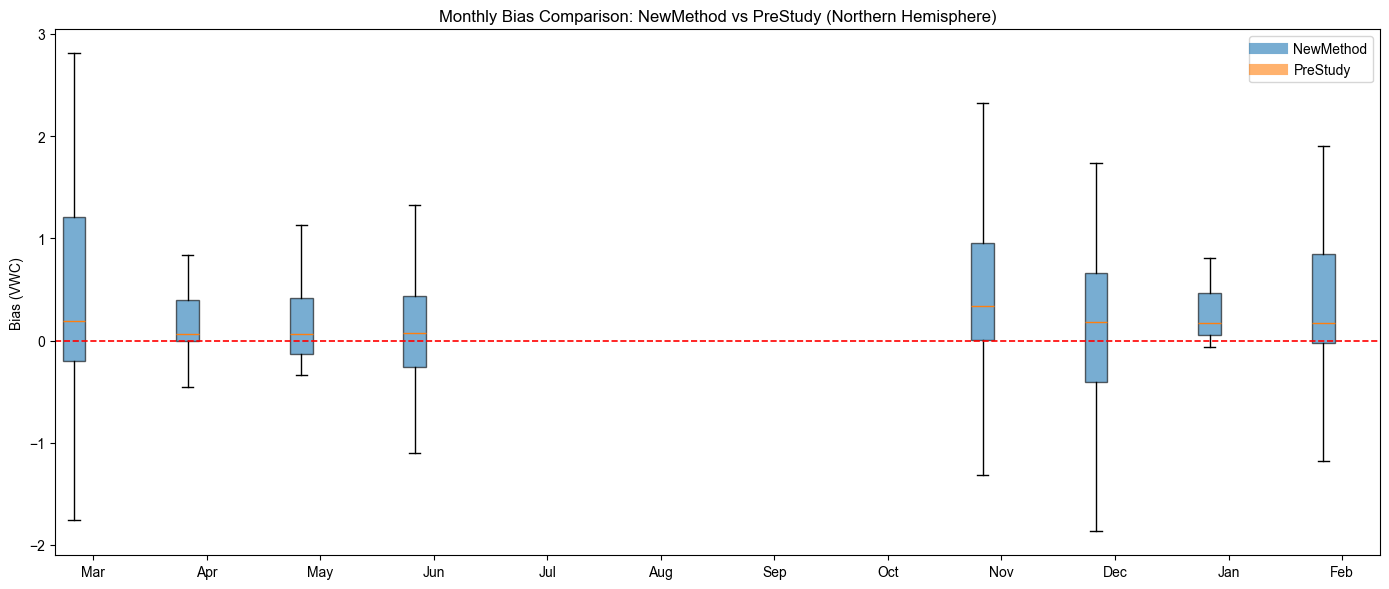

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ========== 参数设置 ==========
csv_path = r"G:\data\VWC\test-VWC\VWC_Merged.csv"
obs_col = "Observed_VWC"
model_cols = ["NewMethod_VWC", "PreStudy_VWC"]
model_labels = ["NewMethod", "PreStudy"]

# ========== 1. 读取数据并筛选北半球 ==========
df = pd.read_csv(csv_path, parse_dates=["Date"])
df = df[df["Lat"] > 0].copy()  # 只取北半球
df["Month"] = df["Date"].dt.month

# ========== 2. 计算 Bias ==========
for col in model_cols:
    df[f"Bias_{col}"] = df[col] - df[obs_col]

# ========== 3. 按月份收集 Bias 数据 ==========
months = range(1, 13)
bias_data = {col: [] for col in model_cols}

for m in months:
    df_month = df[df["Month"] == m]
    for col in model_cols:
        bias_values = df_month[f"Bias_{col}"].values
        bias_data[col].append(bias_values)

# ========== 4. 绘制箱线图 ==========
fig, ax = plt.subplots(figsize=(14, 6))

# 每个月两个箱子的偏移量
positions = []
for i in range(12):
    positions.append(i*3 + 1)  # NewMethod
    positions.append(i*3 + 2)  # PreStudy

# 准备绘制数据
box_data = []
for i in range(12):
    box_data.append(bias_data["NewMethod_VWC"][i])
    box_data.append(bias_data["PreStudy_VWC"][i])

# 绘制箱线图（去除异常值）
bplot = ax.boxplot(box_data,
                   positions=positions,
                   widths=0.6,
                   patch_artist=True,
                   showfliers=False)  # 去除异常点

# 设置颜色
colors = ['C0', 'C1'] * 12
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

# 添加 Bias=0 的红色水平虚线
ax.axhline(0, color='r', linestyle='--', linewidth=1.2)

# 设置 x 轴标签为月份（按照季节顺序排列）
# 春:3-5, 夏:6-8, 秋:9-11, 冬:12,1,2
month_labels = ["Mar", "Apr", "May", "Jun", "Jul", "Aug",
                "Sep", "Oct", "Nov", "Dec", "Jan", "Feb"]
ax.set_xticks([i*3 + 1.5 for i in range(12)])
ax.set_xticklabels(month_labels)

# 添加图例
handles = [plt.Line2D([0], [0], color='C0', lw=8, alpha=0.6),
           plt.Line2D([0], [0], color='C1', lw=8, alpha=0.6)]
ax.legend(handles, model_labels, loc='upper right')

ax.set_ylabel("Bias (VWC)")
ax.set_title("Monthly Bias Comparison: NewMethod vs PreStudy (Northern Hemisphere)")

plt.tight_layout()
plt.show()


In [83]:
import pandas as pd
import numpy as np

# 读取数据
csv_path = r"G:\data\VWC\test-VWC\VWC_Merged.csv"
df = pd.read_csv(csv_path, parse_dates=["Date"])
df = df[df["Lat"] > 0].copy()
df["Month"] = df["Date"].dt.month

obs_col = "Observed_VWC"
model_cols = ["NewMethod_VWC", "PreStudy_VWC"]
model_labels = ["NewMethod", "PreStudy"]

# 计算 Bias
for col in model_cols:
    df[f"Bias_{col}"] = df[col] - df[obs_col]

# 按月份打印统计指标
months = range(1, 13)
print("\n每组数据的 Bias 统计指标（2 × 12 = 24 组）\n")
for col, label in zip(model_cols, model_labels):
    for m in months:
        bias_values = df[df["Month"]==m][f"Bias_{col}"].dropna()
        if len(bias_values) == 0:
            print(f"{label} - Month {m}: 无有效数据")
        else:
            print(f"{label} - Month {m}: count={len(bias_values)}, mean={bias_values.mean():.4f}, "
                  f"std={bias_values.std():.4f}, min={bias_values.min():.4f}, max={bias_values.max():.4f}, "
                  f"25%={bias_values.quantile(0.25):.4f}, 50%={bias_values.median():.4f}, 75%={bias_values.quantile(0.75):.4f}")



每组数据的 Bias 统计指标（2 × 12 = 24 组）

NewMethod - Month 1: count=42, mean=0.2667, std=1.9911, min=-6.6163, max=4.8524, 25%=-0.1958, 50%=0.1949, 75%=1.2042
NewMethod - Month 2: count=44, mean=-0.1240, std=1.3901, min=-7.7791, max=1.3505, 25%=-0.0025, 50%=0.0627, 75%=0.3968
NewMethod - Month 3: count=65, mean=-0.1046, std=1.4097, min=-5.6532, max=2.9189, 25%=-0.1342, 50%=0.0633, 75%=0.4119
NewMethod - Month 4: count=141, mean=-0.1591, std=1.9879, min=-16.4213, max=5.6964, 25%=-0.2549, 50%=0.0726, 75%=0.4363
NewMethod - Month 5: count=305, mean=0.2029, std=1.7633, min=-9.9613, max=8.7588, 25%=-0.0706, 50%=0.2465, 75%=0.7377
NewMethod - Month 6: count=640, mean=0.0821, std=1.7828, min=-14.7142, max=9.3323, 25%=-0.0872, 50%=0.2161, 75%=0.5656
NewMethod - Month 7: count=627, mean=0.2398, std=1.5711, min=-16.0541, max=4.9463, 25%=-0.0416, 50%=0.3577, 75%=1.0203
NewMethod - Month 8: count=757, mean=-0.0773, std=1.2992, min=-8.8621, max=7.1005, 25%=-0.6688, 50%=0.0154, 75%=0.4325
NewMethod - Month 9

### 4.3.4 SSIM图

## 4.4 单日数据的GIF的VWC动图绘制

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from osgeo import gdal
from matplotlib.colors import LinearSegmentedColormap
import imageio
from tqdm import tqdm
import shutil
import gc

# ==========================================================
# 配置参数
# ==========================================================
VWC_DIR = r"G:\data\VWC\VWCMap\Daily"
OUTPUT_GIF = r"G:\文章\HUITU\Fig\VWC_dynamic_2015_2020.gif"
TEMP_FRAME_DIR = r"G:\文章\HUITU\Fig\_frames_temp"
os.makedirs(TEMP_FRAME_DIR, exist_ok=True)

BAND = 1
NODATA_VALUE = -9999
VMIN, VMAX = 0, 20
FPS = 3  # 每秒帧数
FRAME_STEP = 1  # 每3天取一帧

# ==========================================================
# 自定义颜色映射
# ==========================================================
def create_custom_cmap():
    colors = [
        '#fe3c19',  # 0
        '#ffac18',  # 5
        '#f2fe2a',  # 10
        '#7cb815',  # 15
        '#147218'   # 20
    ]
    return LinearSegmentedColormap.from_list('custom_vwc', colors, N=256)

# ==========================================================
# 读取 TIFF 并返回数据与范围
# ==========================================================
def read_vwc_tif(file_path):
    ds = gdal.Open(file_path)
    if ds is None:
        raise FileNotFoundError(file_path)
    band = ds.GetRasterBand(BAND)
    data = band.ReadAsArray().astype(np.float32)
    data[data == NODATA_VALUE] = np.nan
    gt = ds.GetGeoTransform()
    lon_min, lat_max = gt[0], gt[3]
    lon_max = lon_min + gt[1] * ds.RasterXSize
    lat_min = lat_max + gt[5] * ds.RasterYSize
    extent = (lon_min, lon_max, lat_min, lat_max)
    ds = None
    return data, extent

# ==========================================================
# 主程序
# ==========================================================
def main():
    all_files = sorted(glob.glob(os.path.join(VWC_DIR, "VWC-*.tif")))

    # 过滤 2015–2020 年文件
    files = []
    for f in all_files:
        basename = os.path.basename(f)
        try:
            year = int(basename[4:8])  # 提取YYYY
            if 2015 <= year <= 2020:
                files.append(f)
        except ValueError:
            continue

    if not files:
        print("❌ 未找到 2015–2020 年的 VWC 文件。")
        return

    # 抽帧，减小总帧数
    files = files[::FRAME_STEP]

    cmap = create_custom_cmap()

    # 使用第一帧extent确保所有帧一致
    first_data, base_extent = read_vwc_tif(files[0])

    print(f"共检测到 {len(files)} 张抽帧后的图像，将绘制为GIF。")

    # 创建一次 fig 和 ax
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.5, color='gray')
    im = ax.imshow(first_data, origin='upper', extent=base_extent, transform=ccrs.PlateCarree(),
                   cmap=cmap, vmin=VMIN, vmax=VMAX, interpolation='nearest')
    ax.set_title("", fontsize=12)
    ax.axis('off')

    # 循环绘制每帧
    for idx, file in enumerate(tqdm(files, desc="绘制帧")):
        data, _ = read_vwc_tif(file)
        im.set_data(data)
        date_label = os.path.basename(file).replace("VWC-", "").replace(".tif", "")
        ax.set_title(date_label, fontsize=12)

        frame_path = os.path.join(TEMP_FRAME_DIR, f"frame_{idx:04d}.png")
        fig.savefig(frame_path, dpi=100, bbox_inches='tight', pad_inches=0)

        # 每100帧强制释放内存
        if idx % 100 == 0:
            gc.collect()

    print("✅ 所有帧绘制完成，开始生成GIF...")

    # 读取帧并生成GIF
    frame_paths = sorted(glob.glob(os.path.join(TEMP_FRAME_DIR, "frame_*.png")))
    with imageio.get_writer(OUTPUT_GIF, mode='I', fps=FPS) as writer:
        for frame_path in tqdm(frame_paths, desc="合成GIF"):
            image = imageio.imread(frame_path)
            writer.append_data(image)

    print(f"✅ GIF已保存至: {OUTPUT_GIF}")

    # 删除临时帧文件夹
    shutil.rmtree(TEMP_FRAME_DIR, ignore_errors=True)
    print("🧹 已清理临时帧文件。")

if __name__ == "__main__":
    main()


共检测到 2192 张抽帧后的图像，将绘制为GIF。


绘制帧:   0%|          | 9/2192 [00:02<10:20,  3.52it/s]

## 4.5 VWC产品与干旱指数、野火遥感产品的相关性

### 4.5.1 SPEI & VWC （2003.1-2020.12）

In [5]:
import os
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin

SPEI_DIR = Path(r"G:\data\spei01\DATA")
VWC_DIR = Path(r"G:\data\VWC\VWCMap\Monthly")
OUTPUT_PATH = Path(r"G:\文章\HUITU\Fig\Corr_SPEI_VWC.tif")

START = "2003-01"
END = "2020-12"
MIN_SAMPLES = 60
ROWS_HALF, COLS_HALF = 360, 720
NODATA = -9999.0

def month_iter():
    return pd.date_range(start=START, end=END, freq="MS")

def read_tif(path):
    with rasterio.open(path) as src:
        data = src.read(1).astype(np.float32)
        nodata = src.nodata
    if nodata is not None:
        data = np.where(data == nodata, np.nan, data)
    return data

def aggregate_vwc(vwc_01deg):
    reshaped = vwc_01deg.reshape(ROWS_HALF, 5, COLS_HALF, 5)
    block_mean = np.nanmean(reshaped, axis=(1, 3))
    all_nan = np.isnan(reshaped).all(axis=(1, 3))
    block_mean[all_nan] = np.nan
    return block_mean

def save_geotiff(array, path):
    path.parent.mkdir(parents=True, exist_ok=True)
    transform = from_origin(-180, 90, 0.5, 0.5)
    with rasterio.open(
        path, "w",
        driver="GTiff",
        height=ROWS_HALF,
        width=COLS_HALF,
        count=1,
        dtype=np.float32,
        crs="EPSG:4326",
        transform=transform,
        nodata=NODATA,
        compress="lzw"
    ) as dst:
        data = np.where(np.isnan(array), NODATA, array).astype(np.float32)
        dst.write(data, 1)

def main():
    spei_list, vwc_list = [], []

    for date in month_iter():
        spei_path = SPEI_DIR / f"{date.year}-{date.month}.tif"
        vwc_path = VWC_DIR / f"VWC-{date.year}{date.month:02d}.tif"

        if not (spei_path.exists() and vwc_path.exists()):
            print(f"[WARN] 缺少文件，跳过 {date:%Y-%m}")
            continue

        spei = read_tif(spei_path)
        vwc = read_tif(vwc_path)

        if spei.shape != (ROWS_HALF, COLS_HALF):
            raise ValueError(f"SPEI 维度异常: {spei.shape} ({spei_path})")
        if vwc.shape != (ROWS_HALF * 5, COLS_HALF * 5):
            raise ValueError(f"VWC 维度异常: {vwc.shape} ({vwc_path})")

        vwc_half = aggregate_vwc(vwc)
        spei_list.append(spei)
        vwc_list.append(vwc_half)

    if len(spei_list) == 0:
        raise RuntimeError("未找到任何成对的 SPEI/VWC 数据，无法计算相关性。")

    spei_stack = np.stack(spei_list, axis=0)
    vwc_stack = np.stack(vwc_list, axis=0)

    valid_mask = (~np.isnan(spei_stack)) & (~np.isnan(vwc_stack))
    spei_stack = np.where(valid_mask, spei_stack, np.nan)
    vwc_stack = np.where(valid_mask, vwc_stack, np.nan)

    counts = np.sum(~np.isnan(spei_stack), axis=0)

    spei_mean = np.nanmean(spei_stack, axis=0)
    vwc_mean = np.nanmean(vwc_stack, axis=0)

    numerator = np.nansum(
        (spei_stack - spei_mean[np.newaxis, :, :]) *
        (vwc_stack - vwc_mean[np.newaxis, :, :]),
        axis=0
    )
    spei_var = np.nansum((spei_stack - spei_mean[np.newaxis, :, :]) ** 2, axis=0)
    vwc_var = np.nansum((vwc_stack - vwc_mean[np.newaxis, :, :]) ** 2, axis=0)

    denom = np.sqrt(spei_var * vwc_var)
    corr = np.full((ROWS_HALF, COLS_HALF), np.nan, dtype=np.float32)

    valid = (counts >= MIN_SAMPLES) & (denom > 0)
    corr[valid] = numerator[valid] / denom[valid]

    save_geotiff(corr, OUTPUT_PATH)
    print(f"✅ 相关性结果已保存：{OUTPUT_PATH}")

if __name__ == "__main__":
    main()

C:\Users\Ronin\AppData\Local\Temp\ipykernel_19608\2307105716.py:33: RuntimeWarning: Mean of empty slice
  block_mean = np.nanmean(reshaped, axis=(1, 3))


[WARN] 缺少文件，跳过 2011-11
[WARN] 缺少文件，跳过 2011-12
[WARN] 缺少文件，跳过 2012-01
[WARN] 缺少文件，跳过 2012-02
[WARN] 缺少文件，跳过 2012-03
[WARN] 缺少文件，跳过 2012-04
[WARN] 缺少文件，跳过 2012-05
[WARN] 缺少文件，跳过 2012-06


C:\Users\Ronin\AppData\Local\Temp\ipykernel_19608\2307105716.py:91: RuntimeWarning: Mean of empty slice
  spei_mean = np.nanmean(spei_stack, axis=0)
C:\Users\Ronin\AppData\Local\Temp\ipykernel_19608\2307105716.py:92: RuntimeWarning: Mean of empty slice
  vwc_mean = np.nanmean(vwc_stack, axis=0)


✅ 相关性结果已保存：G:\文章\HUITU\Fig\Corr_SPEI_VWC.tif
